In [1]:
import pandas as pd
import numpy as np
from datetime import date
import re

import train_test_split as tts
import evaluation as eva
import data_util as util
import feature_selection_missing_data as femd
import do

import decision_tree
import logistic
import svm
import knn
import boosting
import bagging

In [2]:
data = util.read_csv_data("projects_2012_2013.csv")

In [3]:
femd.summarize_missing_values(data)

{'date_posted': (0, 124976),
 'datefullyfunded': (0, 124976),
 'eligible_double_your_impact_match': (0, 124976),
 'grade_level': (3, 124976),
 'poverty_level': (0, 124976),
 'primary_focus_area': (15, 124976),
 'primary_focus_subject': (15, 124976),
 'projectid': (0, 124976),
 'resource_type': (17, 124976),
 'school_charter': (0, 124976),
 'school_city': (0, 124976),
 'school_county': (0, 124976),
 'school_district': (172, 124976),
 'school_latitude': (0, 124976),
 'school_longitude': (0, 124976),
 'school_magnet': (0, 124976),
 'school_metro': (15224, 124976),
 'school_ncesid': (9233, 124976),
 'school_state': (0, 124976),
 'schoolid': (0, 124976),
 'secondary_focus_area': (40556, 124976),
 'secondary_focus_subject': (40556, 124976),
 'students_reached': (59, 124976),
 'teacher_acctid': (0, 124976),
 'teacher_prefix': (0, 124976),
 'total_price_including_optional_support': (0, 124976)}

Due to the fact the columns which contain the missing values are categorical, using origin method to fill the missing in column mean is not appropriate. Therefore, I use the most frequent value in given columns instead to fill in the missing value, which are less restricted to the type of the data.

In [4]:
data = femd.fill_na_freq(data)

In [5]:
femd.summarize_missing_values(data)

{'date_posted': (0, 124976),
 'datefullyfunded': (0, 124976),
 'eligible_double_your_impact_match': (0, 124976),
 'grade_level': (0, 124976),
 'poverty_level': (0, 124976),
 'primary_focus_area': (0, 124976),
 'primary_focus_subject': (0, 124976),
 'projectid': (0, 124976),
 'resource_type': (0, 124976),
 'school_charter': (0, 124976),
 'school_city': (0, 124976),
 'school_county': (0, 124976),
 'school_district': (0, 124976),
 'school_latitude': (0, 124976),
 'school_longitude': (0, 124976),
 'school_magnet': (0, 124976),
 'school_metro': (0, 124976),
 'school_ncesid': (0, 124976),
 'school_state': (0, 124976),
 'schoolid': (0, 124976),
 'secondary_focus_area': (0, 124976),
 'secondary_focus_subject': (0, 124976),
 'students_reached': (0, 124976),
 'teacher_acctid': (0, 124976),
 'teacher_prefix': (0, 124976),
 'total_price_including_optional_support': (0, 124976)}

After the missing value is filled, the summary statistics that all the data I am going to use is complete right now. Then we move on to define features and classifiers. First of all, we exclude personal and geographical identification recods of the variables and focus on the features representing the characteristics of the projects. We find out that lots of the features are categorical in this case. In order to make use of these features, we thransform them to binary variables

In [6]:
features = ["school_charter", "school_magnet", "primary_focus_subject", "primary_focus_area", "secondary_focus_subject",
           "secondary_focus_area", "resource_type", "poverty_level", "grade_level", 'eligible_double_your_impact_match',
           'total_price_including_optional_support', 'students_reached']
cat_features = ["school_charter", "school_magnet", "primary_focus_subject", "primary_focus_area", "secondary_focus_subject",
           "secondary_focus_area", "resource_type", "poverty_level", "grade_level", 'eligible_double_your_impact_match']
selected_columns = ["school_charter", "school_magnet", "primary_focus_subject", "primary_focus_area", "secondary_focus_subject",
           "secondary_focus_area", "resource_type", "poverty_level", "grade_level", 'eligible_double_your_impact_match',
           'date_posted', 'datefullyfunded', 'total_price_including_optional_support', 'students_reached']

In [7]:
data = data[selected_columns]
for feature in cat_features:
    data = util.category_to_binary(data, feature)
data = data[data.columns[10:]]

In [8]:
final_features = data.columns[2:]

In [9]:
def define_date(date_string):
    full_date = re.findall("([0-9]*)/([0-9]*)/([0-9]*)", date_string)[0]
    i_year, i_month, i_day = int("20" + full_date[2]), int(full_date[0]), int(full_date[1])
    return date(i_year, i_month, i_day)

In [10]:
data["date_posted"] = data.apply(lambda x: define_date(x["date_posted"]), axis=1)
data['datefullyfunded'] = data.apply(lambda x: define_date(x['datefullyfunded']), axis=1)
data["accept_day"] = data.apply(lambda x: (x['datefullyfunded'] - x["date_posted"]).days, axis=1)
data["classifier"] = 0
data.loc[data["accept_day"] > 60, "classifier"] = 1

Considering the scale may be effective in svm and logistics models, I normalized the continuous variables in the dataset with function normalization_column in data_util.py file

In [11]:
numerical_columns = ['total_price_including_optional_support', 'students_reached']
for column in numerical_columns:
    data = util.normalization_column(data, column)

In [12]:
def time_setter(time_object):
    time = 0
    if (time_object - date(2012, 6, 30)).days > 0:
        if (time_object - date(2012, 12, 31)).days > 0:
            if (time_object - date(2013, 6, 30)).days > 0:
                time = 3
            else:
                time = 2         
        else:
            time = 1

    return time 

In [13]:
data["time"] = data.apply(lambda x: time_setter(x["date_posted"]), axis=1)
classifier = 'classifier'
time_index = "time"

In [73]:
data[data["classifier"]==1].shape[0] / data.shape[0]

0.2881353219818205

The total number of features is 92 in this case, I am applying select_K_best_features function from featue_selection_missing_data.py to select the k features which contain the most variance in the pool of features. In this analysis, the number of k will be set to 30.

In [14]:
Kfeatures = list(femd.select_K_best_features(data, final_features, classifier, k=30)[1].index)

In [15]:
data_dict = tts.rolling_window_split(data, time_index, Kfeatures, classifier)

In [20]:
threshold_list = [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
opt = []

In [21]:
# accuracy for models
decision_tree_accuracy = do.cross_validate_performance(data_dict, "decision_tree", opt, "accuracy", threshold_list)
random_forest_accuracy = do.cross_validate_performance(data_dict, "random_forest", opt, "accuracy", threshold_list)
svm_accuracy = do.cross_validate_performance(data_dict, "svm", opt, "accuracy", threshold_list)
logistics_accuracy = do.cross_validate_performance(data_dict, "logistics", opt, "accuracy", threshold_list)
knn_accuracy = do.cross_validate_performance(data_dict, "knn", opt, "accuracy", threshold_list)


# precision for models
decision_tree_precision = do.cross_validate_performance(data_dict, "decision_tree", opt, "precision", threshold_list)
random_forest_precision = do.cross_validate_performance(data_dict, "random_forest", opt, "precision", threshold_list)
svm_precision = do.cross_validate_performance(data_dict, "svm", opt, "precision", threshold_list)
logistics_precision = do.cross_validate_performance(data_dict, "logistics", opt, "precision", threshold_list)
knn_precision = do.cross_validate_performance(data_dict, "knn", opt, "precision", threshold_list)


# recall for models
decision_tree_recall = do.cross_validate_performance(data_dict, "decision_tree", opt, "recall", threshold_list)
random_forest_recall = do.cross_validate_performance(data_dict, "random_forest", opt, "recall", threshold_list)
svm_recall = do.cross_validate_performance(data_dict, "svm", opt, "recall", threshold_list)
logistics_recall = do.cross_validate_performance(data_dict, "logistics", opt, "recall", threshold_list)
knn_recall = do.cross_validate_performance(data_dict, "knn", opt, "recall", threshold_list)


# f1 for models
decision_tree_f1 = do.cross_validate_performance(data_dict, "decision_tree", opt, "f1", threshold_list)
random_forest_f1 = do.cross_validate_performance(data_dict, "random_forest", opt, "f1", threshold_list)
svm_f1 = do.cross_validate_performance(data_dict, "svm", opt, "f1", threshold_list)
logistics_f1 = do.cross_validate_performance(data_dict, "logistics", opt, "f1", threshold_list)
knn_f1 = do.cross_validate_performance(data_dict, "knn", opt, "f1", threshold_list)


# AUC_ROC for models
decision_tree_AUC_ROC = do.cross_validate_performance(data_dict, "decision_tree", opt, "AUC_ROC", threshold_list)
random_forest_AUC_ROC = do.cross_validate_performance(data_dict, "random_forest", opt, "AUC_ROC", threshold_list)
svm_AUC_ROC = do.cross_validate_performance(data_dict, "svm", opt, "AUC_ROC", threshold_list)
logistics_AUC_ROC = do.cross_validate_performance(data_dict, "logistics", opt, "AUC_ROC", threshold_list)
knn_AUC_ROC = do.cross_validate_performance(data_dict, "knn", opt, "AUC_ROC", threshold_list)


operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.28287350021316765
operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.28287350021316765
operating best_threshold, eval_method: accuracy, threshold: 0.07051282051282051, score: 0.2965771362445947
operating best_threshold, eval_method: accuracy, threshold: 0.14285714285714285, score: 0.3312016566173336
operating best_threshold, eval_method: accuracy, threshold: 0.20045558086560364, score: 0.4085510688836104
operating best_threshold, eval_method: accuracy, threshold: 0.23687423687423687, score: 0.47003471587794626
operating best_threshold, eval_method: accuracy, threshold: 0.26807057484348323, score: 0.5295389487788538
operating best_threshold, eval_method: accuracy, threshold: 0.315, score: 0.5791765637371338
operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.29356233631768075
operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.29356233631768075
ope

operating best_threshold, eval_method: accuracy, threshold: 0.31758530183727035, score: 0.5815518606492478
operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.3255070345331628
operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.3255070345331628
operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.3255070345331628
operating best_threshold, eval_method: accuracy, threshold: 0.021505376344086023, score: 0.33138437176441926
operating best_threshold, eval_method: accuracy, threshold: 0.14864864864864866, score: 0.4071198002314392
operating best_threshold, eval_method: accuracy, threshold: 0.22099447513812154, score: 0.47219684511846033
operating best_threshold, eval_method: accuracy, threshold: 0.2733516483516483, score: 0.5320360557890249
operating best_threshold, eval_method: accuracy, threshold: 0.3107344632768362, score: 0.581034167732505
operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.34122053718

operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.306535111760765
operating best_threshold, eval_method: accuracy, threshold: 0.10572687224669604, score: 0.3371094463731043
operating best_threshold, eval_method: accuracy, threshold: 0.1953125, score: 0.40121201047566846
operating best_threshold, eval_method: accuracy, threshold: 0.25, score: 0.46385285340154697
operating best_threshold, eval_method: accuracy, threshold: 0.26521739130434785, score: 0.5249101650526828
operating best_threshold, eval_method: accuracy, threshold: 0.2995049504950495, score: 0.573908276996163
operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.317223947865278
operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.317223947865278
operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.317223947865278
operating best_threshold, eval_method: accuracy, threshold: 0.08333333333333333, score: 0.3276996162981911
operating best_threshol

operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.3557159388513308
operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.3557159388513308
operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.3557159388513308
operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.3557159388513308
operating best_threshold, eval_method: accuracy, threshold: 0.125, score: 0.4009074852305256
operating best_threshold, eval_method: accuracy, threshold: 0.21223021582733814, score: 0.46893842499543215
operating best_threshold, eval_method: accuracy, threshold: 0.2760084925690021, score: 0.5336195870637676
operating best_threshold, eval_method: accuracy, threshold: 0.30289330922242313, score: 0.5789633960655338
operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.3690236920640721
operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.3690236920640721
operating best_threshold, eval_method: a

operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.3479731294880704
operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.3479731294880704
operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.3479731294880704
operating best_threshold, eval_method: accuracy, threshold: 0.07462686567164178, score: 0.3793375028955293
operating best_threshold, eval_method: accuracy, threshold: 0.16693163751987283, score: 0.45179522816770906
operating best_threshold, eval_method: accuracy, threshold: 0.2070921985815603, score: 0.5068334491545055
operating best_threshold, eval_method: accuracy, threshold: 0.2510158013544018, score: 0.5570071809126709
operating best_threshold, eval_method: accuracy, threshold: 0.27941176470588236, score: 0.5856381746583276
operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.35983321751216124
operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.35983321751216124
operating

operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.3990734306231179
operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.3990734306231179
operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.3990734306231179
operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.3990734306231179
operating best_threshold, eval_method: accuracy, threshold: 0.0874751491053678, score: 0.440722724113968
operating best_threshold, eval_method: accuracy, threshold: 0.16363636363636364, score: 0.49798471160528146
operating best_threshold, eval_method: accuracy, threshold: 0.22736030828516374, score: 0.5432939541348158
operating best_threshold, eval_method: accuracy, threshold: 0.2727272727272727, score: 0.590687977762335
operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.41542738012508684
operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.41542738012508684
operating best_threshold, e

operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.3751216122307158
operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.3751216122307158
operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.3751216122307158
operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.3751216122307158
operating best_threshold, eval_method: accuracy, threshold: 0.14014447884416942, score: 0.44313180449386147
operating best_threshold, eval_method: accuracy, threshold: 0.2, score: 0.4992819087329164
operating best_threshold, eval_method: accuracy, threshold: 0.24946695095948823, score: 0.5428769979152189
operating best_threshold, eval_method: accuracy, threshold: 0.2753623188405797, score: 0.5888811674774149
operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.38290479499652535
operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.38290479499652535
operating best_threshold, eval_method: a

operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.426082927959231
operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.426082927959231
operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.426082927959231
operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.426082927959231
operating best_threshold, eval_method: accuracy, threshold: 0.04093567251461988, score: 0.42997451934213576
operating best_threshold, eval_method: accuracy, threshold: 0.1519434628975265, score: 0.49997683576557794
operating best_threshold, eval_method: accuracy, threshold: 0.22123893805309736, score: 0.5561269400046328
operating best_threshold, eval_method: accuracy, threshold: 0.26506024096385544, score: 0.5976372480889507
operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.4361825341672458
operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.4361825341672458
operating best_threshold, eva

operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.37670659089365366
operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.37670659089365366
operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.37670659089365366
operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.37670659089365366
operating best_threshold, eval_method: accuracy, threshold: 0.10204081632653061, score: 0.4110308601444517
operating best_threshold, eval_method: accuracy, threshold: 0.19047619047619047, score: 0.4794529852604886
operating best_threshold, eval_method: accuracy, threshold: 0.25, score: 0.5337242737790658
operating best_threshold, eval_method: accuracy, threshold: 0.2801664355062413, score: 0.5802975071886249
operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.4006384857472774
operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.4006384857472774
operating best_threshold, eval_method:

operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.44567210813503294
operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.44567210813503294
operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.44567210813503294
operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.44567210813503294
operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.44567210813503294
operating best_threshold, eval_method: accuracy, threshold: 0.07407407407407407, score: 0.46392102701111687
operating best_threshold, eval_method: accuracy, threshold: 0.17647058823529413, score: 0.5263884800869427
operating best_threshold, eval_method: accuracy, threshold: 0.27607361963190186, score: 0.5755428260918786
operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.2964883283899744
operating best_threshold, eval_method: accuracy, threshold: 0.006493506493506494, score: 0.3042769488532162
operating best_thre

operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.3122693413634614
operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.3122693413634614
operating best_threshold, eval_method: accuracy, threshold: 0.04375, score: 0.32535603504879207
operating best_threshold, eval_method: accuracy, threshold: 0.08695652173913043, score: 0.3658161070482487
operating best_threshold, eval_method: accuracy, threshold: 0.16684723726977252, score: 0.44546833608802955
operating best_threshold, eval_method: accuracy, threshold: 0.2125984251968504, score: 0.504562229719021
operating best_threshold, eval_method: accuracy, threshold: 0.26727509778357234, score: 0.5567278737518963
operating best_threshold, eval_method: accuracy, threshold: 0.32222222222222224, score: 0.5992030248828311
operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.31996739647247946
operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.31996739647247946
oper

operating best_threshold, eval_method: accuracy, threshold: 0.05166839079405832, score: 0.2648151531761983
operating best_threshold, eval_method: accuracy, threshold: 0.07096774193548387, score: 0.27385955295694014
operating best_threshold, eval_method: accuracy, threshold: 0.10477383830180456, score: 0.2988915281076801
operating best_threshold, eval_method: accuracy, threshold: 0.14134800056491792, score: 0.3384189049272185
operating best_threshold, eval_method: accuracy, threshold: 0.19682974477426143, score: 0.40754613557463915
operating best_threshold, eval_method: accuracy, threshold: 0.2354988940223292, score: 0.4746634996041172
operating best_threshold, eval_method: accuracy, threshold: 0.27079300794126837, score: 0.5394664717705098
operating best_threshold, eval_method: accuracy, threshold: 0.3095130461203706, score: 0.5847798282477618
operating best_threshold, eval_method: accuracy, threshold: 0.030817845198279986, score: 0.2646324380291126
operating best_threshold, eval_metho

operating best_threshold, eval_method: accuracy, threshold: 0.054517405063291155, score: 0.2660332541567696
operating best_threshold, eval_method: accuracy, threshold: 0.06953501602903345, score: 0.27465131859431147
operating best_threshold, eval_method: accuracy, threshold: 0.10449912212146104, score: 0.3006273220049942
operating best_threshold, eval_method: accuracy, threshold: 0.14566642948889835, score: 0.3388452402704184
operating best_threshold, eval_method: accuracy, threshold: 0.19856149625576985, score: 0.4142761434922955
operating best_threshold, eval_method: accuracy, threshold: 0.244250457270122, score: 0.47898775808514527
operating best_threshold, eval_method: accuracy, threshold: 0.27876822092197157, score: 0.5342590900785675
operating best_threshold, eval_method: accuracy, threshold: 0.31604250594327954, score: 0.5860283817528473
operating best_threshold, eval_method: accuracy, threshold: 0.04735821421935782, score: 0.2654851087155125
operating best_threshold, eval_metho

operating best_threshold, eval_method: accuracy, threshold: 0.05823612552575483, score: 0.26627687435288383
operating best_threshold, eval_method: accuracy, threshold: 0.07378900148687467, score: 0.27535172665813995
operating best_threshold, eval_method: accuracy, threshold: 0.11470354831294413, score: 0.30004872403922284
operating best_threshold, eval_method: accuracy, threshold: 0.15345703291646884, score: 0.3401851513490468
operating best_threshold, eval_method: accuracy, threshold: 0.19554117095134058, score: 0.41455021621292404
operating best_threshold, eval_method: accuracy, threshold: 0.23584602393712062, score: 0.478744137889031
operating best_threshold, eval_method: accuracy, threshold: 0.27790877642731127, score: 0.5359035264023387
operating best_threshold, eval_method: accuracy, threshold: 0.316581830998744, score: 0.5856934039831903
operating best_threshold, eval_method: accuracy, threshold: 0.055906428963794635, score: 0.2656069188135696
operating best_threshold, eval_meth

operating best_threshold, eval_method: accuracy, threshold: 0.04248515231070551, score: 0.26530239356842683
operating best_threshold, eval_method: accuracy, threshold: 0.0662528604118993, score: 0.2740422681040258
operating best_threshold, eval_method: accuracy, threshold: 0.09899597466673517, score: 0.2999878189901943
operating best_threshold, eval_method: accuracy, threshold: 0.13100754220638672, score: 0.34240818563858944
operating best_threshold, eval_method: accuracy, threshold: 0.19189592024855778, score: 0.41260125464401
operating best_threshold, eval_method: accuracy, threshold: 0.23919806383800585, score: 0.47938364090383095
operating best_threshold, eval_method: accuracy, threshold: 0.2880705289124725, score: 0.5345940678482246
operating best_threshold, eval_method: accuracy, threshold: 0.3243009897780319, score: 0.5835312747426762
operating best_threshold, eval_method: accuracy, threshold: 0.009230769230769232, score: 0.26627687435288383
operating best_threshold, eval_method

operating best_threshold, eval_method: accuracy, threshold: 0.038107246802162056, score: 0.266185516779341
operating best_threshold, eval_method: accuracy, threshold: 0.05090478132658312, score: 0.27492539131494
operating best_threshold, eval_method: accuracy, threshold: 0.10156914574682932, score: 0.3012972775443084
operating best_threshold, eval_method: accuracy, threshold: 0.14238348714524313, score: 0.3402460563980754
operating best_threshold, eval_method: accuracy, threshold: 0.19405552602252132, score: 0.41522017175223824
operating best_threshold, eval_method: accuracy, threshold: 0.2386160061939108, score: 0.4787136853645167
operating best_threshold, eval_method: accuracy, threshold: 0.27886921313960134, score: 0.5361166940739387
operating best_threshold, eval_method: accuracy, threshold: 0.3223671893727872, score: 0.5849929959193617
operating best_threshold, eval_method: accuracy, threshold: 0.04257355988396187, score: 0.26578963396065536
operating best_threshold, eval_method: 

operating best_threshold, eval_method: accuracy, threshold: 0.05928415896832365, score: 0.26609415920579815
operating best_threshold, eval_method: accuracy, threshold: 0.07813773116380804, score: 0.27538217918265423
operating best_threshold, eval_method: accuracy, threshold: 0.10813304448610271, score: 0.30096229977465133
operating best_threshold, eval_method: accuracy, threshold: 0.1452843664908895, score: 0.3414032523296181
operating best_threshold, eval_method: accuracy, threshold: 0.1976611669274283, score: 0.41589012729155245
operating best_threshold, eval_method: accuracy, threshold: 0.23915063492776728, score: 0.4816675802424021
operating best_threshold, eval_method: accuracy, threshold: 0.2765547943032658, score: 0.5381570132163956
operating best_threshold, eval_method: accuracy, threshold: 0.31706522458396036, score: 0.5872464827334186
operating best_threshold, eval_method: accuracy, threshold: 0.04373212953928158, score: 0.2663682319264267
operating best_threshold, eval_metho

operating best_threshold, eval_method: accuracy, threshold: 0.041565379628123234, score: 0.3242529534398888
operating best_threshold, eval_method: accuracy, threshold: 0.0648634663582032, score: 0.33245309242529536
operating best_threshold, eval_method: accuracy, threshold: 0.10368334249587685, score: 0.35649756775538566
operating best_threshold, eval_method: accuracy, threshold: 0.13716045119828696, score: 0.3948112114894603
operating best_threshold, eval_method: accuracy, threshold: 0.183194710840963, score: 0.46231179059532085
operating best_threshold, eval_method: accuracy, threshold: 0.2254368982857775, score: 0.5191568218670373
operating best_threshold, eval_method: accuracy, threshold: 0.2649089258754725, score: 0.5677553856845031
operating best_threshold, eval_method: accuracy, threshold: 0.2999493600941813, score: 0.6065786425758629
operating best_threshold, eval_method: accuracy, threshold: 0.033962264150943396, score: 0.3222608292795923
operating best_threshold, eval_method:

operating best_threshold, eval_method: accuracy, threshold: 0.06482730707954668, score: 0.323882325689136
operating best_threshold, eval_method: accuracy, threshold: 0.08154981552131488, score: 0.33236043548760713
operating best_threshold, eval_method: accuracy, threshold: 0.11037056531495278, score: 0.35737780866342367
operating best_threshold, eval_method: accuracy, threshold: 0.13649861237833608, score: 0.39453324067639567
operating best_threshold, eval_method: accuracy, threshold: 0.1822701069530564, score: 0.4639796154737086
operating best_threshold, eval_method: accuracy, threshold: 0.2264268975682943, score: 0.521241602965022
operating best_threshold, eval_method: accuracy, threshold: 0.2638164083841546, score: 0.571693305536252
operating best_threshold, eval_method: accuracy, threshold: 0.2987266818024216, score: 0.6123233727125319
operating best_threshold, eval_method: accuracy, threshold: 0.05567118829232688, score: 0.32355802640722725
operating best_threshold, eval_method: a

operating best_threshold, eval_method: accuracy, threshold: 0.06586557169873967, score: 0.3244845957841093
operating best_threshold, eval_method: accuracy, threshold: 0.0817192485211744, score: 0.33337966180217743
operating best_threshold, eval_method: accuracy, threshold: 0.11030582579278367, score: 0.35774843641417653
operating best_threshold, eval_method: accuracy, threshold: 0.13333132888663787, score: 0.39675700718091267
operating best_threshold, eval_method: accuracy, threshold: 0.17960258481078828, score: 0.46536946953903174
operating best_threshold, eval_method: accuracy, threshold: 0.22550486884974813, score: 0.5245772527217976
operating best_threshold, eval_method: accuracy, threshold: 0.260713858958027, score: 0.5717859624739402
operating best_threshold, eval_method: accuracy, threshold: 0.2975905683412777, score: 0.6125086865879082
operating best_threshold, eval_method: accuracy, threshold: 0.051997200128483266, score: 0.3242066249710447
operating best_threshold, eval_metho

operating best_threshold, eval_method: accuracy, threshold: 0.039256540729666146, score: 0.32337271253185085
operating best_threshold, eval_method: accuracy, threshold: 0.05500985590746229, score: 0.3329627055825805
operating best_threshold, eval_method: accuracy, threshold: 0.0858145366198261, score: 0.3566828816307621
operating best_threshold, eval_method: accuracy, threshold: 0.11772561308376955, score: 0.3940236275191105
operating best_threshold, eval_method: accuracy, threshold: 0.1673431932733146, score: 0.4610145934676859
operating best_threshold, eval_method: accuracy, threshold: 0.22004863309465747, score: 0.521704887653463
operating best_threshold, eval_method: accuracy, threshold: 0.26211931923784687, score: 0.5691452397498262
operating best_threshold, eval_method: accuracy, threshold: 0.3002245953562258, score: 0.6075515404215891
operating best_threshold, eval_method: accuracy, threshold: 0.026529274314639518, score: 0.3234190410006949
operating best_threshold, eval_method:

operating best_threshold, eval_method: accuracy, threshold: 0.04718595130359836, score: 0.32434561037757703
operating best_threshold, eval_method: accuracy, threshold: 0.06857585656483166, score: 0.3330553625202687
operating best_threshold, eval_method: accuracy, threshold: 0.10082888717472097, score: 0.35691452397498263
operating best_threshold, eval_method: accuracy, threshold: 0.14082706113432802, score: 0.3950891823025249
operating best_threshold, eval_method: accuracy, threshold: 0.18150620903607423, score: 0.4650914987259671
operating best_threshold, eval_method: accuracy, threshold: 0.2268078825576756, score: 0.5245309242529534
operating best_threshold, eval_method: accuracy, threshold: 0.26602049125987703, score: 0.5731758165392634
operating best_threshold, eval_method: accuracy, threshold: 0.2982072448135209, score: 0.6115821172110262
operating best_threshold, eval_method: accuracy, threshold: 0.04285714285714286, score: 0.3242529534398888
operating best_threshold, eval_method

operating best_threshold, eval_method: accuracy, threshold: 0.05685130141375299, score: 0.3241139680333565
operating best_threshold, eval_method: accuracy, threshold: 0.078612015686602, score: 0.33273106323836
operating best_threshold, eval_method: accuracy, threshold: 0.11631114640943638, score: 0.3565438962242298
operating best_threshold, eval_method: accuracy, threshold: 0.14386853152851387, score: 0.3942089413944869
operating best_threshold, eval_method: accuracy, threshold: 0.19194667627127543, score: 0.4625897614083855
operating best_threshold, eval_method: accuracy, threshold: 0.23291203846800837, score: 0.5232800555941626
operating best_threshold, eval_method: accuracy, threshold: 0.26763893816430057, score: 0.5723419041000695
operating best_threshold, eval_method: accuracy, threshold: 0.29929499092787654, score: 0.6109335186472087
operating best_threshold, eval_method: accuracy, threshold: 0.04778195310459229, score: 0.32392865415798006
operating best_threshold, eval_method: a

operating best_threshold, eval_method: accuracy, threshold: 0.04754544872398532, score: 0.2936581610704825
operating best_threshold, eval_method: accuracy, threshold: 0.06226358505456615, score: 0.30246564176874136
operating best_threshold, eval_method: accuracy, threshold: 0.09369671396407982, score: 0.3286163878008468
operating best_threshold, eval_method: accuracy, threshold: 0.1276394813742158, score: 0.3708877668847782
operating best_threshold, eval_method: accuracy, threshold: 0.18195097595844312, score: 0.44304571286254446
operating best_threshold, eval_method: accuracy, threshold: 0.22526046306805225, score: 0.5064867434962755
operating best_threshold, eval_method: accuracy, threshold: 0.269321791869037, score: 0.5574071139085742
operating best_threshold, eval_method: accuracy, threshold: 0.311906142747249, score: 0.5985917087418208
operating best_threshold, eval_method: accuracy, threshold: 0.04317827874110948, score: 0.29374872642470623
operating best_threshold, eval_method: 

operating best_threshold, eval_method: accuracy, threshold: 0.051026597565503276, score: 0.2947449453211674
operating best_threshold, eval_method: accuracy, threshold: 0.06826393732556245, score: 0.3031222405868635
operating best_threshold, eval_method: accuracy, threshold: 0.10008262071719143, score: 0.32877487717073833
operating best_threshold, eval_method: accuracy, threshold: 0.13455814513335712, score: 0.3704349401136595
operating best_threshold, eval_method: accuracy, threshold: 0.18596641822874022, score: 0.4468720990784975
operating best_threshold, eval_method: accuracy, threshold: 0.2358091472916644, score: 0.5077320171168519
operating best_threshold, eval_method: accuracy, threshold: 0.28214278400754395, score: 0.5593089863472729
operating best_threshold, eval_method: accuracy, threshold: 0.3212310702315314, score: 0.6002218851178481
operating best_threshold, eval_method: accuracy, threshold: 0.04942040667197552, score: 0.2937034437475944
operating best_threshold, eval_method

operating best_threshold, eval_method: accuracy, threshold: 0.04894791889884009, score: 0.2942015531958249
operating best_threshold, eval_method: accuracy, threshold: 0.06358733427247121, score: 0.30357506735798223
operating best_threshold, eval_method: accuracy, threshold: 0.10034585506728454, score: 0.3292729866189689
operating best_threshold, eval_method: accuracy, threshold: 0.13324725594468761, score: 0.37077456019199856
operating best_threshold, eval_method: accuracy, threshold: 0.187041684045605, score: 0.44707587112550096
operating best_threshold, eval_method: accuracy, threshold: 0.23698733136823896, score: 0.5080489958566351
operating best_threshold, eval_method: accuracy, threshold: 0.28456756166422065, score: 0.56032784658229
operating best_threshold, eval_method: accuracy, threshold: 0.32454378800766853, score: 0.6042520433808046
operating best_threshold, eval_method: accuracy, threshold: 0.04964493087756275, score: 0.29433740122716057
operating best_threshold, eval_method

operating best_threshold, eval_method: accuracy, threshold: 0.06022998157323199, score: 0.29329589965358754
operating best_threshold, eval_method: accuracy, threshold: 0.07883628417655868, score: 0.3031675232639754
operating best_threshold, eval_method: accuracy, threshold: 0.10773358675921271, score: 0.3287295944936265
operating best_threshold, eval_method: accuracy, threshold: 0.1422911907225822, score: 0.36841986098218127
operating best_threshold, eval_method: accuracy, threshold: 0.19691154744815892, score: 0.43878914121402857
operating best_threshold, eval_method: accuracy, threshold: 0.2484807273504334, score: 0.5023660198790952
operating best_threshold, eval_method: accuracy, threshold: 0.28304682233800793, score: 0.5490298186428781
operating best_threshold, eval_method: accuracy, threshold: 0.3187854146931413, score: 0.5954445626825458
operating best_threshold, eval_method: accuracy, threshold: 0.0440087145969499, score: 0.2935902370548147
operating best_threshold, eval_method:

operating best_threshold, eval_method: accuracy, threshold: 0.046595460730712225, score: 0.2943826839042724
operating best_threshold, eval_method: accuracy, threshold: 0.06342885295066449, score: 0.30334865397242283
operating best_threshold, eval_method: accuracy, threshold: 0.09661829913554755, score: 0.3290012905562977
operating best_threshold, eval_method: accuracy, threshold: 0.13333671129856756, score: 0.37129531097878504
operating best_threshold, eval_method: accuracy, threshold: 0.1895544542538542, score: 0.44349853963366315
operating best_threshold, eval_method: accuracy, threshold: 0.2364163284841915, score: 0.5067584395589467
operating best_threshold, eval_method: accuracy, threshold: 0.28270999059847257, score: 0.5591731383159373
operating best_threshold, eval_method: accuracy, threshold: 0.3222322132558415, score: 0.6008558425974143
operating best_threshold, eval_method: accuracy, threshold: 0.044469345214131706, score: 0.29386193311748593
operating best_threshold, eval_met

operating best_threshold, eval_method: accuracy, threshold: 0.049451529495270576, score: 0.29415627051871307
operating best_threshold, eval_method: accuracy, threshold: 0.06605270607627492, score: 0.303303371295311
operating best_threshold, eval_method: accuracy, threshold: 0.09822454009106427, score: 0.3300201507913148
operating best_threshold, eval_method: accuracy, threshold: 0.1314684995815319, score: 0.37158964838001224
operating best_threshold, eval_method: accuracy, threshold: 0.18725171310965877, score: 0.4463060656145991
operating best_threshold, eval_method: accuracy, threshold: 0.23874291864469505, score: 0.5093169108157675
operating best_threshold, eval_method: accuracy, threshold: 0.2833008805473708, score: 0.5591052143002694
operating best_threshold, eval_method: accuracy, threshold: 0.31854146703142966, score: 0.6025086603119977
operating best_threshold, eval_method: accuracy, threshold: 0.047663125785516444, score: 0.2939751398102656
operating best_threshold, eval_metho

C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: accuracy, threshold: -0.03504695618814795, score: 0.26487605822522686
operating best_threshold, eval_method: accuracy, threshold: -0.02510035767452096, score: 0.2715147085693404
operating best_threshold, eval_method: accuracy, threshold: -0.025015967147136407, score: 0.29408002923442356
operating best_threshold, eval_method: accuracy, threshold: -0.015021927845287459, score: 0.3260551799744199
operating best_threshold, eval_method: accuracy, threshold: -0.005042179937928392, score: 0.3963396065533833
operating best_threshold, eval_method: accuracy, threshold: 0.004901669372376976, score: 0.44883975881600585
operating best_threshold, eval_method: accuracy, threshold: 0.0050599982828986225, score: 0.5018576039953713
operating best_threshold, eval_method: accuracy, threshold: 0.014957459102019567, score: 0.5637371338083927


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: accuracy, threshold: 0.8268391322709319, score: 0.26384067239174125
operating best_threshold, eval_method: accuracy, threshold: 0.8608790813547702, score: 0.27035751263779767
operating best_threshold, eval_method: accuracy, threshold: 0.9295771558479486, score: 0.28823314452768134
operating best_threshold, eval_method: accuracy, threshold: 0.9799436353240667, score: 0.3178939034045922
operating best_threshold, eval_method: accuracy, threshold: 1.029156118969079, score: 0.3733174980205859
operating best_threshold, eval_method: accuracy, threshold: 1.0801681469899513, score: 0.42484316949875145
operating best_threshold, eval_method: accuracy, threshold: 1.1162787425575307, score: 0.4717096047262318
operating best_threshold, eval_method: accuracy, threshold: 1.150101378523662, score: 0.5270722942931969


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: accuracy, threshold: -2.061328232669443, score: 0.2639624824897984
operating best_threshold, eval_method: accuracy, threshold: -1.9246990180958639, score: 0.2702966075887691
operating best_threshold, eval_method: accuracy, threshold: -1.7004347931102999, score: 0.29219197271453806
operating best_threshold, eval_method: accuracy, threshold: -1.3668878059658864, score: 0.32562884463121994
operating best_threshold, eval_method: accuracy, threshold: -1.037533247269361, score: 0.3818442048845849
operating best_threshold, eval_method: accuracy, threshold: -0.8378311663332769, score: 0.43306535111760763
operating best_threshold, eval_method: accuracy, threshold: -0.6136850728332005, score: 0.4882148730129728
operating best_threshold, eval_method: accuracy, threshold: -0.4190531411822433, score: 0.5369389122358244


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: accuracy, threshold: -1.2897936962469088, score: 0.2637797673427127
operating best_threshold, eval_method: accuracy, threshold: -1.2053118028225693, score: 0.26944393690236923
operating best_threshold, eval_method: accuracy, threshold: -1.1110562668676778, score: 0.2899993909495097
operating best_threshold, eval_method: accuracy, threshold: -0.8085477667132193, score: 0.321426396248249
operating best_threshold, eval_method: accuracy, threshold: -0.6104340558160761, score: 0.3805651988549851
operating best_threshold, eval_method: accuracy, threshold: -0.3964274363302064, score: 0.4302637188622937
operating best_threshold, eval_method: accuracy, threshold: -0.17962021723550353, score: 0.47813508739874533
operating best_threshold, eval_method: accuracy, threshold: 0.018626529371515488, score: 0.5233570863024545


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: accuracy, threshold: -2.111456312077184, score: 0.26438881783299834
operating best_threshold, eval_method: accuracy, threshold: -2.052563027176803, score: 0.2720628540105975
operating best_threshold, eval_method: accuracy, threshold: -1.9308706595804133, score: 0.29334916864608074
operating best_threshold, eval_method: accuracy, threshold: -1.7796764118425195, score: 0.3224617820817346
operating best_threshold, eval_method: accuracy, threshold: -1.5615557721292255, score: 0.38129605944332784
operating best_threshold, eval_method: accuracy, threshold: -1.3673558142162825, score: 0.43787684999086424
operating best_threshold, eval_method: accuracy, threshold: -1.235722273098748, score: 0.48894573360131555
operating best_threshold, eval_method: accuracy, threshold: -1.1100631636595288, score: 0.5320056032645106


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: accuracy, threshold: 2.751419939173545, score: 0.2582374078811133
operating best_threshold, eval_method: accuracy, threshold: 2.7515434848636495, score: 0.2592118886655704
operating best_threshold, eval_method: accuracy, threshold: 2.751578687853113, score: 0.27130154089774045
operating best_threshold, eval_method: accuracy, threshold: 2.7515993976729844, score: 0.3012668250197941
operating best_threshold, eval_method: accuracy, threshold: 2.7516141995467667, score: 0.3592484316949875
operating best_threshold, eval_method: accuracy, threshold: 2.751626665208672, score: 0.4058407942018393
operating best_threshold, eval_method: accuracy, threshold: 2.751637723277608, score: 0.4521590839880626
operating best_threshold, eval_method: accuracy, threshold: 2.7516484245203294, score: 0.507339058407942


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: accuracy, threshold: 104.6626691267281, score: 0.2573238321456849
operating best_threshold, eval_method: accuracy, threshold: 104.66690120849324, score: 0.2600036543029417
operating best_threshold, eval_method: accuracy, threshold: 104.66766782624597, score: 0.2788537669772824
operating best_threshold, eval_method: accuracy, threshold: 104.66787123683548, score: 0.3081490955600219
operating best_threshold, eval_method: accuracy, threshold: 104.6680448593259, score: 0.3641817406663012
operating best_threshold, eval_method: accuracy, threshold: 104.66816052536537, score: 0.41984895547840917
operating best_threshold, eval_method: accuracy, threshold: 104.66826583230538, score: 0.47164869967720324
operating best_threshold, eval_method: accuracy, threshold: 104.66835248517427, score: 0.5250015226262257


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: accuracy, threshold: 319.44839990743367, score: 0.2572629270966563
operating best_threshold, eval_method: accuracy, threshold: 319.4837173033271, score: 0.25960777148425607
operating best_threshold, eval_method: accuracy, threshold: 319.4902906137486, score: 0.277513855898654
operating best_threshold, eval_method: accuracy, threshold: 319.49210846723923, score: 0.3059565137949936
operating best_threshold, eval_method: accuracy, threshold: 319.4933664123287, score: 0.36211096899933004
operating best_threshold, eval_method: accuracy, threshold: 319.4942177578939, score: 0.42140203422863753
operating best_threshold, eval_method: accuracy, threshold: 319.49491789008437, score: 0.4748157622266886
operating best_threshold, eval_method: accuracy, threshold: 319.49550476384405, score: 0.5217126499786833


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: accuracy, threshold: 3456.113416621886, score: 0.25750654729277056
operating best_threshold, eval_method: accuracy, threshold: 3456.2106133498482, score: 0.26128266033254155
operating best_threshold, eval_method: accuracy, threshold: 3456.2636825562317, score: 0.2790364821243681
operating best_threshold, eval_method: accuracy, threshold: 3456.281287430891, score: 0.3069918996284792
operating best_threshold, eval_method: accuracy, threshold: 3456.2958681574264, score: 0.36789694865704364
operating best_threshold, eval_method: accuracy, threshold: 3456.3020863887955, score: 0.4303855289603508
operating best_threshold, eval_method: accuracy, threshold: 3456.3079140833916, score: 0.48650953164017297
operating best_threshold, eval_method: accuracy, threshold: 3456.313967697132, score: 0.5401668798343383


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: accuracy, threshold: 5366.299650157204, score: 0.25787197758694197
operating best_threshold, eval_method: accuracy, threshold: 5367.108132881955, score: 0.26085632498934164
operating best_threshold, eval_method: accuracy, threshold: 5367.423760662226, score: 0.2754430842316828
operating best_threshold, eval_method: accuracy, threshold: 5367.604860538964, score: 0.3006577745295085
operating best_threshold, eval_method: accuracy, threshold: 5367.734460609703, score: 0.35541141360618794
operating best_threshold, eval_method: accuracy, threshold: 5367.828730959994, score: 0.40651074974115353
operating best_threshold, eval_method: accuracy, threshold: 5367.892490319516, score: 0.4595285949205189
operating best_threshold, eval_method: accuracy, threshold: 5367.959075977204, score: 0.504415616054571


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: accuracy, threshold: -0.00017474668020590423, score: 0.2621353310189415
operating best_threshold, eval_method: accuracy, threshold: 0.0003960317608760871, score: 0.2676167854315123
operating best_threshold, eval_method: accuracy, threshold: 0.0009200077280139055, score: 0.28549241732139596
operating best_threshold, eval_method: accuracy, threshold: 0.0012274455302417444, score: 0.3157622266885925
operating best_threshold, eval_method: accuracy, threshold: 0.0015491630954659543, score: 0.3731956879225288
operating best_threshold, eval_method: accuracy, threshold: 0.0017959580696582434, score: 0.4305682441074365
operating best_threshold, eval_method: accuracy, threshold: 0.001946802032311408, score: 0.48638772154211585
operating best_threshold, eval_method: accuracy, threshold: 0.00207923209583713, score: 0.5428467019915951


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: accuracy, threshold: -0.005073781467058478, score: 0.26085632498934164
operating best_threshold, eval_method: accuracy, threshold: 0.002753565626145648, score: 0.26627687435288383
operating best_threshold, eval_method: accuracy, threshold: 0.007422730393306846, score: 0.28360436080151047
operating best_threshold, eval_method: accuracy, threshold: 0.011039284705192304, score: 0.31381326511967844
operating best_threshold, eval_method: accuracy, threshold: 0.013934634310913288, score: 0.37082039101041475
operating best_threshold, eval_method: accuracy, threshold: 0.015649038108529606, score: 0.4321517753821792
operating best_threshold, eval_method: accuracy, threshold: 0.0167417271178108, score: 0.4863268164930873
operating best_threshold, eval_method: accuracy, threshold: 0.018539825273592714, score: 0.5410804555697667


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: accuracy, threshold: 0.07091353523007798, score: 0.25939460381265605
operating best_threshold, eval_method: accuracy, threshold: 0.13656502951752872, score: 0.2626834764601986
operating best_threshold, eval_method: accuracy, threshold: 0.1792013090465555, score: 0.2767829953103112
operating best_threshold, eval_method: accuracy, threshold: 0.20404688532645177, score: 0.30309397649065106
operating best_threshold, eval_method: accuracy, threshold: 0.23999904006858308, score: 0.35431512272367377
operating best_threshold, eval_method: accuracy, threshold: 0.25472576590196705, score: 0.39774042268104026
operating best_threshold, eval_method: accuracy, threshold: 0.26604262272327395, score: 0.44418052256532065
operating best_threshold, eval_method: accuracy, threshold: 0.27313111514376553, score: 0.4946708082100006


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: accuracy, threshold: 0.46761132905270425, score: 0.2610999451854559
operating best_threshold, eval_method: accuracy, threshold: 0.8535595721671584, score: 0.26621596930385527
operating best_threshold, eval_method: accuracy, threshold: 1.112020414094193, score: 0.2847006516840246
operating best_threshold, eval_method: accuracy, threshold: 1.4044933562868127, score: 0.31411779036482124
operating best_threshold, eval_method: accuracy, threshold: 1.5762102067512977, score: 0.3767890858152141
operating best_threshold, eval_method: accuracy, threshold: 1.6912326055842788, score: 0.4342834520981789
operating best_threshold, eval_method: accuracy, threshold: 1.8137375842511114, score: 0.48949387904257263
operating best_threshold, eval_method: accuracy, threshold: 1.9155697141889014, score: 0.5426639868445094


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: accuracy, threshold: -1.1964360380264554, score: 0.2595773189597418
operating best_threshold, eval_method: accuracy, threshold: -0.898305143682655, score: 0.26505877337231254
operating best_threshold, eval_method: accuracy, threshold: -0.5779315423275182, score: 0.2829953103112248
operating best_threshold, eval_method: accuracy, threshold: -0.3116504494944965, score: 0.3156099640660211
operating best_threshold, eval_method: accuracy, threshold: -0.03230272565281804, score: 0.3757536999817285
operating best_threshold, eval_method: accuracy, threshold: 0.14556231466355998, score: 0.4312381996467507
operating best_threshold, eval_method: accuracy, threshold: 0.30025390892891984, score: 0.4859004811498873
operating best_threshold, eval_method: accuracy, threshold: 0.4586161265960169, score: 0.5346245203727389


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: accuracy, threshold: 0.01671999842597597, score: 0.2621353310189415
operating best_threshold, eval_method: accuracy, threshold: 0.01792281481718128, score: 0.26877398136305497
operating best_threshold, eval_method: accuracy, threshold: 0.019375787062904517, score: 0.288415859674767
operating best_threshold, eval_method: accuracy, threshold: 0.020806678269298783, score: 0.3204519154637919
operating best_threshold, eval_method: accuracy, threshold: 0.022048869071962907, score: 0.3802606736098423
operating best_threshold, eval_method: accuracy, threshold: 0.023076417667780205, score: 0.4379377550398928
operating best_threshold, eval_method: accuracy, threshold: 0.023787204176201095, score: 0.4897984042877154
operating best_threshold, eval_method: accuracy, threshold: 0.02442299911762357, score: 0.5393142091479384


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: accuracy, threshold: -0.09177167363308514, score: 0.261221755283513
operating best_threshold, eval_method: accuracy, threshold: -0.07597169318754685, score: 0.26390157744076986
operating best_threshold, eval_method: accuracy, threshold: -0.051919810271450456, score: 0.27117973079968327
operating best_threshold, eval_method: accuracy, threshold: -0.02371842978352695, score: 0.28342164565442474
operating best_threshold, eval_method: accuracy, threshold: 0.01984653680327473, score: 0.31003715207990745
operating best_threshold, eval_method: accuracy, threshold: 0.05666471397202183, score: 0.34785918752664596
operating best_threshold, eval_method: accuracy, threshold: 0.08137226999189537, score: 0.3903404592240697
operating best_threshold, eval_method: accuracy, threshold: 0.10121370113550451, score: 0.4401607893294354


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: accuracy, threshold: -1.2215843905457502, score: 0.2614044704305987
operating best_threshold, eval_method: accuracy, threshold: -1.0964761901863527, score: 0.26420610268591266
operating best_threshold, eval_method: accuracy, threshold: -0.8943902601842689, score: 0.26935257932882634
operating best_threshold, eval_method: accuracy, threshold: -0.6439202188062049, score: 0.28217309214933917
operating best_threshold, eval_method: accuracy, threshold: -0.06824945934051535, score: 0.30930629149156463
operating best_threshold, eval_method: accuracy, threshold: 0.475686241748867, score: 0.3410987270844753
operating best_threshold, eval_method: accuracy, threshold: 0.7709061278563651, score: 0.383579998781899
operating best_threshold, eval_method: accuracy, threshold: 0.9798619841946025, score: 0.4297460259455509


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: accuracy, threshold: -14.219896760257276, score: 0.2613435653815701
operating best_threshold, eval_method: accuracy, threshold: -12.87302678057139, score: 0.26420610268591266
operating best_threshold, eval_method: accuracy, threshold: -10.929628038457288, score: 0.27008343991716915
operating best_threshold, eval_method: accuracy, threshold: -8.655024213842662, score: 0.282690785066082
operating best_threshold, eval_method: accuracy, threshold: -2.979924526658051, score: 0.3104025823740788
operating best_threshold, eval_method: accuracy, threshold: 2.5227373248869407, score: 0.342682258359218
operating best_threshold, eval_method: accuracy, threshold: 5.466051907237939, score: 0.3845544795663561
operating best_threshold, eval_method: accuracy, threshold: 7.572837776358217, score: 0.43084231682806506


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: accuracy, threshold: -108.68953204187599, score: 0.26116085023448443
operating best_threshold, eval_method: accuracy, threshold: -97.72714495770502, score: 0.26384067239174125
operating best_threshold, eval_method: accuracy, threshold: -82.7752758068011, score: 0.27197149643705465
operating best_threshold, eval_method: accuracy, threshold: -67.37751901074272, score: 0.2829953103112248
operating best_threshold, eval_method: accuracy, threshold: -26.495639148210373, score: 0.3108289177172788
operating best_threshold, eval_method: accuracy, threshold: 10.658576421024662, score: 0.34481393507521774
operating best_threshold, eval_method: accuracy, threshold: 33.01326755746848, score: 0.3886960229002984
operating best_threshold, eval_method: accuracy, threshold: 49.7132404743708, score: 0.43547110055423593
cross_validation is operated, method:svm, eval_method:accuracy, df_name:1


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: accuracy, threshold: 2.367417065133506, score: 0.31484827426453554
operating best_threshold, eval_method: accuracy, threshold: 2.4233220918156766, score: 0.3139217048876535
operating best_threshold, eval_method: accuracy, threshold: 2.4553518769795173, score: 0.3164234422052351
operating best_threshold, eval_method: accuracy, threshold: 2.4671904586525044, score: 0.3232337271253185
operating best_threshold, eval_method: accuracy, threshold: 2.4778867159942624, score: 0.3437109103544128
operating best_threshold, eval_method: accuracy, threshold: 2.4844961694792063, score: 0.3667361593699328
operating best_threshold, eval_method: accuracy, threshold: 2.490003051493876, score: 0.396015751679407
operating best_threshold, eval_method: accuracy, threshold: 2.494385619373005, score: 0.4343293954134816


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: accuracy, threshold: 1.5643600738268384, score: 0.3170720407690526
operating best_threshold, eval_method: accuracy, threshold: 1.5899897340008038, score: 0.32068566133889276
operating best_threshold, eval_method: accuracy, threshold: 1.6463224926453155, score: 0.3357887421820709
operating best_threshold, eval_method: accuracy, threshold: 1.7023067808027985, score: 0.35520037062775073
operating best_threshold, eval_method: accuracy, threshold: 1.7378892369212764, score: 0.395135510771369
operating best_threshold, eval_method: accuracy, threshold: 1.782393557042154, score: 0.4347000231642344
operating best_threshold, eval_method: accuracy, threshold: 1.8128989596171126, score: 0.46726893676164005
operating best_threshold, eval_method: accuracy, threshold: 1.8383954012002433, score: 0.5014130182997452


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: accuracy, threshold: -1.6457701393283553, score: 0.32189020152883946
operating best_threshold, eval_method: accuracy, threshold: -1.4795976414017753, score: 0.3268936761640028
operating best_threshold, eval_method: accuracy, threshold: -1.280570539686223, score: 0.34329395413481584
operating best_threshold, eval_method: accuracy, threshold: -1.1397337499596485, score: 0.3695621959694232
operating best_threshold, eval_method: accuracy, threshold: -0.9313741214058879, score: 0.4178364605049803
operating best_threshold, eval_method: accuracy, threshold: -0.8426994353107893, score: 0.4668983090108872
operating best_threshold, eval_method: accuracy, threshold: -0.7238859118142489, score: 0.5072040769052583
operating best_threshold, eval_method: accuracy, threshold: -0.6210196904923473, score: 0.546444290016215


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: accuracy, threshold: -5.4276645598195365, score: 0.3223534862172805
operating best_threshold, eval_method: accuracy, threshold: -5.156011673629527, score: 0.33013666898309013
operating best_threshold, eval_method: accuracy, threshold: -4.7823687746610215, score: 0.3490386842714848
operating best_threshold, eval_method: accuracy, threshold: -4.444429573167112, score: 0.3791058605513088
operating best_threshold, eval_method: accuracy, threshold: -4.108491792494692, score: 0.43525596479036366
operating best_threshold, eval_method: accuracy, threshold: -3.9019020334474614, score: 0.48598563817465834
operating best_threshold, eval_method: accuracy, threshold: -3.7247431048152224, score: 0.5330553625202687
operating best_threshold, eval_method: accuracy, threshold: -3.570949954855362, score: 0.5766504517025712


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: accuracy, threshold: -14.30916409393048, score: 0.3222608292795923
operating best_threshold, eval_method: accuracy, threshold: -13.981347979024008, score: 0.32888580032429926
operating best_threshold, eval_method: accuracy, threshold: -13.64629917142323, score: 0.3507991660875608
operating best_threshold, eval_method: accuracy, threshold: -13.26100430348621, score: 0.37956914523974983
operating best_threshold, eval_method: accuracy, threshold: -12.80981350125985, score: 0.43006717627982394
operating best_threshold, eval_method: accuracy, threshold: -12.45147222797284, score: 0.4714384989576095
operating best_threshold, eval_method: accuracy, threshold: -12.166589114557194, score: 0.5169330553625203
operating best_threshold, eval_method: accuracy, threshold: -11.897253466990662, score: 0.5558952976604123


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: accuracy, threshold: 2.0567580343442913, score: 0.31466296038915914
operating best_threshold, eval_method: accuracy, threshold: 2.0568159474714007, score: 0.31735001158211723
operating best_threshold, eval_method: accuracy, threshold: 2.056848050019374, score: 0.3256891359740561
operating best_threshold, eval_method: accuracy, threshold: 2.056860206574706, score: 0.3448227936066713
operating best_threshold, eval_method: accuracy, threshold: 2.056873021266011, score: 0.38077368542969653
operating best_threshold, eval_method: accuracy, threshold: 2.0568784384112, score: 0.4202918693537179
operating best_threshold, eval_method: accuracy, threshold: 2.0568873072484055, score: 0.4555941626129256
operating best_threshold, eval_method: accuracy, threshold: 2.0568923321026014, score: 0.49585360203845263


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: accuracy, threshold: 8.8661949966244, score: 0.31466296038915914
operating best_threshold, eval_method: accuracy, threshold: 8.86661151289455, score: 0.3182765809589993
operating best_threshold, eval_method: accuracy, threshold: 8.866856681849011, score: 0.33059995367153117
operating best_threshold, eval_method: accuracy, threshold: 8.866992042301822, score: 0.3528839471855455
operating best_threshold, eval_method: accuracy, threshold: 8.867114033538728, score: 0.3979152189020153
operating best_threshold, eval_method: accuracy, threshold: 8.867172337559827, score: 0.435394950196896
operating best_threshold, eval_method: accuracy, threshold: 8.86721527738321, score: 0.47857308315960156
operating best_threshold, eval_method: accuracy, threshold: 8.867255789928416, score: 0.5168867268936762


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: accuracy, threshold: 84.93752348249832, score: 0.31447764651378274
operating best_threshold, eval_method: accuracy, threshold: 84.9403135784102, score: 0.317257354644429
operating best_threshold, eval_method: accuracy, threshold: 84.94242836123925, score: 0.3277739170720408
operating best_threshold, eval_method: accuracy, threshold: 84.94356426084094, score: 0.3464906184850591
operating best_threshold, eval_method: accuracy, threshold: 84.94510836529976, score: 0.38003242992819086
operating best_threshold, eval_method: accuracy, threshold: 84.94571944439107, score: 0.4206624971044707
operating best_threshold, eval_method: accuracy, threshold: 84.94628935197743, score: 0.4552235348621728
operating best_threshold, eval_method: accuracy, threshold: 84.94685057267104, score: 0.49798471160528146


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: accuracy, threshold: 926.9864287379874, score: 0.31549687282835304
operating best_threshold, eval_method: accuracy, threshold: 927.0105589859459, score: 0.31836923789668753
operating best_threshold, eval_method: accuracy, threshold: 927.0430737790273, score: 0.32948807041927264
operating best_threshold, eval_method: accuracy, threshold: 927.0558901638694, score: 0.3469539031735001
operating best_threshold, eval_method: accuracy, threshold: 927.0724170083023, score: 0.3824415103080843
operating best_threshold, eval_method: accuracy, threshold: 927.0830615841795, score: 0.4195506138522122
operating best_threshold, eval_method: accuracy, threshold: 927.0894539096489, score: 0.46662033819782256
operating best_threshold, eval_method: accuracy, threshold: 927.093463147373, score: 0.5117905953208246


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: accuracy, threshold: 9520.950936835596, score: 0.3142923326384063
operating best_threshold, eval_method: accuracy, threshold: 9521.359034494792, score: 0.31735001158211723
operating best_threshold, eval_method: accuracy, threshold: 9521.540003664497, score: 0.32948807041927264
operating best_threshold, eval_method: accuracy, threshold: 9521.651271310093, score: 0.3476951586750058
operating best_threshold, eval_method: accuracy, threshold: 9521.767447760089, score: 0.38021774380356727
operating best_threshold, eval_method: accuracy, threshold: 9521.82309138453, score: 0.4214964095436646
operating best_threshold, eval_method: accuracy, threshold: 9521.887766148375, score: 0.4598563817465833
operating best_threshold, eval_method: accuracy, threshold: 9521.953528254548, score: 0.4996525364836692


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: accuracy, threshold: 2.8364924330517056e-05, score: 0.3160528144544823
operating best_threshold, eval_method: accuracy, threshold: 0.00021868208271658065, score: 0.32068566133889276
operating best_threshold, eval_method: accuracy, threshold: 0.0006000830662203276, score: 0.33671531155895296
operating best_threshold, eval_method: accuracy, threshold: 0.0007484892536820469, score: 0.36437340745888347
operating best_threshold, eval_method: accuracy, threshold: 0.0009217019169348241, score: 0.40968264998841786
operating best_threshold, eval_method: accuracy, threshold: 0.0012200577625416965, score: 0.4581885568681955
operating best_threshold, eval_method: accuracy, threshold: 0.0013934290017270895, score: 0.4976604123233727
operating best_threshold, eval_method: accuracy, threshold: 0.001587514336034655, score: 0.5312485522353486


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: accuracy, threshold: 0.00393658332375718, score: 0.31586750057910584
operating best_threshold, eval_method: accuracy, threshold: 0.006015960801831453, score: 0.3213342599027102
operating best_threshold, eval_method: accuracy, threshold: 0.00790053486547469, score: 0.33671531155895296
operating best_threshold, eval_method: accuracy, threshold: 0.009778148958810427, score: 0.36168635626592543
operating best_threshold, eval_method: accuracy, threshold: 0.011998319460426052, score: 0.4151494093120222
operating best_threshold, eval_method: accuracy, threshold: 0.013398422563114623, score: 0.4599490386842715
operating best_threshold, eval_method: accuracy, threshold: 0.014766557559413866, score: 0.5022932592077832
operating best_threshold, eval_method: accuracy, threshold: 0.01622020159606183, score: 0.5391243919388464


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: accuracy, threshold: 0.03534842895566925, score: 0.3152189020152884
operating best_threshold, eval_method: accuracy, threshold: 0.05566444320114464, score: 0.32003706277507527
operating best_threshold, eval_method: accuracy, threshold: 0.0885122489566395, score: 0.3320824646745425
operating best_threshold, eval_method: accuracy, threshold: 0.09642080150384688, score: 0.3506601806810285
operating best_threshold, eval_method: accuracy, threshold: 0.10967652790689768, score: 0.38994672226082927
operating best_threshold, eval_method: accuracy, threshold: 0.12759984589349685, score: 0.43215195737780865
operating best_threshold, eval_method: accuracy, threshold: 0.13962440829503703, score: 0.474774148714385
operating best_threshold, eval_method: accuracy, threshold: 0.14843258194680387, score: 0.5189251795228168


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: accuracy, threshold: 0.5580734085988792, score: 0.31633078526754693
operating best_threshold, eval_method: accuracy, threshold: 0.6259940785274307, score: 0.32272411396803335
operating best_threshold, eval_method: accuracy, threshold: 0.7031748284213543, score: 0.34042158906648134
operating best_threshold, eval_method: accuracy, threshold: 0.7663495095111952, score: 0.3693768820940468
operating best_threshold, eval_method: accuracy, threshold: 0.8527681869074282, score: 0.41829974519342134
operating best_threshold, eval_method: accuracy, threshold: 0.9417844703912707, score: 0.4560574473013667
operating best_threshold, eval_method: accuracy, threshold: 1.0902918255493765, score: 0.4939541348158443
operating best_threshold, eval_method: accuracy, threshold: 1.2129507369847428, score: 0.5399583043780403


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: accuracy, threshold: -0.34244695348399445, score: 0.31475561732684737
operating best_threshold, eval_method: accuracy, threshold: 2.801920742854144, score: 0.31382904794996525
operating best_threshold, eval_method: accuracy, threshold: 3.6780973097552954, score: 0.32661570535093815
operating best_threshold, eval_method: accuracy, threshold: 4.069218709363272, score: 0.34732453092425297
operating best_threshold, eval_method: accuracy, threshold: 4.416990067685583, score: 0.3891128098216354
operating best_threshold, eval_method: accuracy, threshold: 4.63521628010611, score: 0.4254806578642576
operating best_threshold, eval_method: accuracy, threshold: 4.882924084090368, score: 0.4613388927495946
operating best_threshold, eval_method: accuracy, threshold: 5.011814829312561, score: 0.49817002548065786


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: accuracy, threshold: -0.04080577511749868, score: 0.31596015751679407
operating best_threshold, eval_method: accuracy, threshold: -0.037844668339923664, score: 0.31549687282835304
operating best_threshold, eval_method: accuracy, threshold: -0.03251936978404553, score: 0.3151262450776002
operating best_threshold, eval_method: accuracy, threshold: -0.026985523569565878, score: 0.31980542043085475
operating best_threshold, eval_method: accuracy, threshold: -0.015034776915008763, score: 0.3289784572619875
operating best_threshold, eval_method: accuracy, threshold: -0.0019442741171108863, score: 0.3497799397729905
operating best_threshold, eval_method: accuracy, threshold: 0.005550074704620225, score: 0.3788742182070883
operating best_threshold, eval_method: accuracy, threshold: 0.010388112403880989, score: 0.40912670836228865


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: accuracy, threshold: -0.5258901297439914, score: 0.3145703034514709
operating best_threshold, eval_method: accuracy, threshold: -0.4570863789494085, score: 0.313273106323836
operating best_threshold, eval_method: accuracy, threshold: -0.27409368287608155, score: 0.313273106323836
operating best_threshold, eval_method: accuracy, threshold: -0.19247306493079036, score: 0.316377113736391
operating best_threshold, eval_method: accuracy, threshold: -0.018419328839054522, score: 0.3277739170720408
operating best_threshold, eval_method: accuracy, threshold: 0.16233289625277847, score: 0.3487607134584202
operating best_threshold, eval_method: accuracy, threshold: 0.26851069955780565, score: 0.3760018531387538
operating best_threshold, eval_method: accuracy, threshold: 0.32973502977005364, score: 0.40662497104470696


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: accuracy, threshold: -5.882010886453548, score: 0.31401436182534165
operating best_threshold, eval_method: accuracy, threshold: -4.891408229157585, score: 0.31373639101227707
operating best_threshold, eval_method: accuracy, threshold: -2.6887768135978196, score: 0.313273106323836
operating best_threshold, eval_method: accuracy, threshold: -1.8417747353688356, score: 0.3170257123002085
operating best_threshold, eval_method: accuracy, threshold: 0.03236055494613914, score: 0.3279592309474172
operating best_threshold, eval_method: accuracy, threshold: 1.9664221690329518, score: 0.34811211489460275
operating best_threshold, eval_method: accuracy, threshold: 3.0867439466747824, score: 0.3768357655779476
operating best_threshold, eval_method: accuracy, threshold: 3.7336922902801097, score: 0.4075515404215891


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: accuracy, threshold: -41.82933204999516, score: 0.3153115589529766
operating best_threshold, eval_method: accuracy, threshold: -37.241829112036534, score: 0.31484827426453554
operating best_threshold, eval_method: accuracy, threshold: -26.90961806177526, score: 0.31577484364141767
operating best_threshold, eval_method: accuracy, threshold: -18.715184453747646, score: 0.3195274496177901
operating best_threshold, eval_method: accuracy, threshold: -3.148157783855054, score: 0.32990502663886956
operating best_threshold, eval_method: accuracy, threshold: 13.124938525707398, score: 0.350891823025249
operating best_threshold, eval_method: accuracy, threshold: 22.57526599894068, score: 0.37961547370859394
operating best_threshold, eval_method: accuracy, threshold: 28.47354742149585, score: 0.40764419735927726


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: accuracy, threshold: -371.78999623360517, score: 0.3162381283298587
operating best_threshold, eval_method: accuracy, threshold: -324.9920145308744, score: 0.31596015751679407
operating best_threshold, eval_method: accuracy, threshold: -255.74564037259705, score: 0.31688672689367614
operating best_threshold, eval_method: accuracy, threshold: -178.7714498680487, score: 0.3211952744961779
operating best_threshold, eval_method: accuracy, threshold: -37.73746289378678, score: 0.3304609682649988
operating best_threshold, eval_method: accuracy, threshold: 112.1449690310584, score: 0.3517257354644429
operating best_threshold, eval_method: accuracy, threshold: 197.8003556265375, score: 0.3791521890201529
operating best_threshold, eval_method: accuracy, threshold: 255.44585217837408, score: 0.40866342367384756
cross_validation is operated, method:svm, eval_method:accuracy, df_name:2


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: accuracy, threshold: 0.4682777697922961, score: 0.2872733035977087
operating best_threshold, eval_method: accuracy, threshold: 0.4753201962092436, score: 0.29071478705821086
operating best_threshold, eval_method: accuracy, threshold: 0.48388669795236106, score: 0.30251092444585326
operating best_threshold, eval_method: accuracy, threshold: 0.4911765325266692, score: 0.3221183236352933
operating best_threshold, eval_method: accuracy, threshold: 0.49771704581118215, score: 0.3691443838159712
operating best_threshold, eval_method: accuracy, threshold: 0.504023937278403, score: 0.4090837050286413
operating best_threshold, eval_method: accuracy, threshold: 0.5090308371703738, score: 0.4538003486766138
operating best_threshold, eval_method: accuracy, threshold: 0.5133797290444947, score: 0.4955736183123146


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: accuracy, threshold: 1.072265621467407, score: 0.2886317839110648
operating best_threshold, eval_method: accuracy, threshold: 1.110893073786213, score: 0.2928430728824688
operating best_threshold, eval_method: accuracy, threshold: 1.1591518129250304, score: 0.30450336223877555
operating best_threshold, eval_method: accuracy, threshold: 1.1999479097906929, score: 0.3240201960739919
operating best_threshold, eval_method: accuracy, threshold: 1.2504796112122003, score: 0.36201236217085153
operating best_threshold, eval_method: accuracy, threshold: 1.2773700392816931, score: 0.39998188692915526
operating best_threshold, eval_method: accuracy, threshold: 1.301825320657843, score: 0.4497249077365454
operating best_threshold, eval_method: accuracy, threshold: 1.32616327700479, score: 0.49598116240632145


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: accuracy, threshold: -0.8696044758764572, score: 0.28731858627482054
operating best_threshold, eval_method: accuracy, threshold: -0.6244419996677892, score: 0.29107704847510585
operating best_threshold, eval_method: accuracy, threshold: -0.42302216948857696, score: 0.2997486811420291
operating best_threshold, eval_method: accuracy, threshold: -0.18685516762371546, score: 0.3146919645889465
operating best_threshold, eval_method: accuracy, threshold: 0.09371875729815562, score: 0.3504426381687685
operating best_threshold, eval_method: accuracy, threshold: 0.32672522984111607, score: 0.3940724975660561
operating best_threshold, eval_method: accuracy, threshold: 0.6923191470795238, score: 0.433740122716055
operating best_threshold, eval_method: accuracy, threshold: 0.9390261390661379, score: 0.4672945864559513


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: accuracy, threshold: -16.162166424150364, score: 0.2930242035909163
operating best_threshold, eval_method: accuracy, threshold: -15.940442540253715, score: 0.3003147146059275
operating best_threshold, eval_method: accuracy, threshold: -15.674527112908029, score: 0.32388434804265626
operating best_threshold, eval_method: accuracy, threshold: -15.377140301219393, score: 0.3595670976068105
operating best_threshold, eval_method: accuracy, threshold: -15.007031829156178, score: 0.4252043380804673
operating best_threshold, eval_method: accuracy, threshold: -14.700677912182915, score: 0.4830303167523264
operating best_threshold, eval_method: accuracy, threshold: -14.44256677526829, score: 0.5368940611768968
operating best_threshold, eval_method: accuracy, threshold: -14.180956902688449, score: 0.5847352095455883


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: accuracy, threshold: -1.2802535151532064, score: 0.2881789571399461
operating best_threshold, eval_method: accuracy, threshold: -1.0577621161932045, score: 0.2916204406004483
operating best_threshold, eval_method: accuracy, threshold: -1.0300956799334944, score: 0.3076278669594946
operating best_threshold, eval_method: accuracy, threshold: -0.8305229462320046, score: 0.325378676387348
operating best_threshold, eval_method: accuracy, threshold: -0.7848194032347312, score: 0.3773858310503317
operating best_threshold, eval_method: accuracy, threshold: -0.5794985473694698, score: 0.41447234360495394
operating best_threshold, eval_method: accuracy, threshold: -0.4251869630076801, score: 0.46860778409219556
operating best_threshold, eval_method: accuracy, threshold: 0.06914599670472332, score: 0.5141847986052935


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: accuracy, threshold: 1.8663588484655214, score: 0.28582425793012883
operating best_threshold, eval_method: accuracy, threshold: 1.8664046207177414, score: 0.28749971698326804
operating best_threshold, eval_method: accuracy, threshold: 1.8664294584965009, score: 0.2973034165779881
operating best_threshold, eval_method: accuracy, threshold: 1.866443215871089, score: 0.3187674055290149
operating best_threshold, eval_method: accuracy, threshold: 1.8664600596006, score: 0.3618991554780719
operating best_threshold, eval_method: accuracy, threshold: 1.8664684093532733, score: 0.4062761790477053
operating best_threshold, eval_method: accuracy, threshold: 1.8664742436704138, score: 0.4537550659995019
operating best_threshold, eval_method: accuracy, threshold: 1.8664799827448433, score: 0.4945321167387416


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: accuracy, threshold: 88.66767321511009, score: 0.2862770847012475
operating best_threshold, eval_method: accuracy, threshold: 88.67463173151232, score: 0.2874544343061562
operating best_threshold, eval_method: accuracy, threshold: 88.6803621445509, score: 0.2912355378449974
operating best_threshold, eval_method: accuracy, threshold: 88.68255778467739, score: 0.3057712771979079
operating best_threshold, eval_method: accuracy, threshold: 88.68286936386298, score: 0.34967283265786675
operating best_threshold, eval_method: accuracy, threshold: 88.68299554430374, score: 0.39518192315529693
operating best_threshold, eval_method: accuracy, threshold: 88.68306859339363, score: 0.4446985305771277
operating best_threshold, eval_method: accuracy, threshold: 88.68313055331271, score: 0.4953019222496434


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: accuracy, threshold: 364.2115941834449, score: 0.28582425793012883
operating best_threshold, eval_method: accuracy, threshold: 364.23184871941396, score: 0.28568840989879324
operating best_threshold, eval_method: accuracy, threshold: 364.249043497483, score: 0.2921411913872348
operating best_threshold, eval_method: accuracy, threshold: 364.25450438624034, score: 0.31161274254533927
operating best_threshold, eval_method: accuracy, threshold: 364.25631644655977, score: 0.353793556275047
operating best_threshold, eval_method: accuracy, threshold: 364.2571277359186, score: 0.39522720583240883
operating best_threshold, eval_method: accuracy, threshold: 364.2575978798194, score: 0.4404419589286119
operating best_threshold, eval_method: accuracy, threshold: 364.25811522942354, score: 0.4853397332850318


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: accuracy, threshold: 855.7047862215975, score: 0.28582425793012883
operating best_threshold, eval_method: accuracy, threshold: 855.8191304274253, score: 0.2872733035977087
operating best_threshold, eval_method: accuracy, threshold: 855.9183350610604, score: 0.2926393008354654
operating best_threshold, eval_method: accuracy, threshold: 855.9532167400039, score: 0.31039011026331875
operating best_threshold, eval_method: accuracy, threshold: 855.969215013046, score: 0.3517558358050128
operating best_threshold, eval_method: accuracy, threshold: 855.9768880840442, score: 0.3879366948173976
operating best_threshold, eval_method: accuracy, threshold: 855.981444873295, score: 0.42305341091765347
operating best_threshold, eval_method: accuracy, threshold: 855.9844643477869, score: 0.4584871057576924


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: accuracy, threshold: 2047.5479214424713, score: 0.28550727919034574
operating best_threshold, eval_method: accuracy, threshold: 2048.176519954846, score: 0.28641293273258317
operating best_threshold, eval_method: accuracy, threshold: 2048.67152303365, score: 0.2929109968981366
operating best_threshold, eval_method: accuracy, threshold: 2048.887811480496, score: 0.3061335386148029
operating best_threshold, eval_method: accuracy, threshold: 2049.02763481928, score: 0.35048792084588043
operating best_threshold, eval_method: accuracy, threshold: 2049.099212635819, score: 0.3947743790612901
operating best_threshold, eval_method: accuracy, threshold: 2049.1596815352777, score: 0.43496275499807546
operating best_threshold, eval_method: accuracy, threshold: 2049.225767632758, score: 0.4814454230534109


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: accuracy, threshold: 6.505427004977511e-05, score: 0.2889940453279598
operating best_threshold, eval_method: accuracy, threshold: 0.00039193609986135384, score: 0.29560531618629293
operating best_threshold, eval_method: accuracy, threshold: 0.0007913406587259837, score: 0.3115674598682274
operating best_threshold, eval_method: accuracy, threshold: 0.0010315679966506474, score: 0.34231439762718774
operating best_threshold, eval_method: accuracy, threshold: 0.001336044834199537, score: 0.3988045373242466
operating best_threshold, eval_method: accuracy, threshold: 0.0015158903961617924, score: 0.45577014513098013
operating best_threshold, eval_method: accuracy, threshold: 0.0016688105981694952, score: 0.5096338895555506
operating best_threshold, eval_method: accuracy, threshold: 0.001803873919094652, score: 0.5595127583942763


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: accuracy, threshold: 0.002996456488330564, score: 0.289265741390631
operating best_threshold, eval_method: accuracy, threshold: 0.005025907204880639, score: 0.2955600335091811
operating best_threshold, eval_method: accuracy, threshold: 0.009516775481716732, score: 0.3141938551407159
operating best_threshold, eval_method: accuracy, threshold: 0.011431006501163864, score: 0.34706907872393417
operating best_threshold, eval_method: accuracy, threshold: 0.012874180662563569, score: 0.4100346412479906
operating best_threshold, eval_method: accuracy, threshold: 0.013781910182187319, score: 0.46392102701111687
operating best_threshold, eval_method: accuracy, threshold: 0.01452887485644834, score: 0.5132112210473884
operating best_threshold, eval_method: accuracy, threshold: 0.015265831013709971, score: 0.5538524237552924


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: accuracy, threshold: 0.10683445537633024, score: 0.2863223673783594
operating best_threshold, eval_method: accuracy, threshold: 0.15445430733712145, score: 0.2891751760364073
operating best_threshold, eval_method: accuracy, threshold: 0.18152717363268528, score: 0.2999298118504766
operating best_threshold, eval_method: accuracy, threshold: 0.22179447642479724, score: 0.3193107976543573
operating best_threshold, eval_method: accuracy, threshold: 0.24111385359062804, score: 0.36416328933366543
operating best_threshold, eval_method: accuracy, threshold: 0.24863168773527555, score: 0.405325242828356
operating best_threshold, eval_method: accuracy, threshold: 0.25870604944635356, score: 0.4482305793918536
operating best_threshold, eval_method: accuracy, threshold: 0.26709938527861155, score: 0.49290194036271423


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: accuracy, threshold: 0.9459509495172425, score: 0.2877714130459393
operating best_threshold, eval_method: accuracy, threshold: 1.1332675197042934, score: 0.2937034437475944
operating best_threshold, eval_method: accuracy, threshold: 1.5279243340893403, score: 0.31256367876468855
operating best_threshold, eval_method: accuracy, threshold: 1.6476499047665023, score: 0.3447143795141169
operating best_threshold, eval_method: accuracy, threshold: 1.7873223552287794, score: 0.39830642787601606
operating best_threshold, eval_method: accuracy, threshold: 1.890349508162291, score: 0.45395883804650533
operating best_threshold, eval_method: accuracy, threshold: 1.9804160311961505, score: 0.4994000045282677
operating best_threshold, eval_method: accuracy, threshold: 2.1198463529068787, score: 0.5499807548622274


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: accuracy, threshold: 0.22439679474134497, score: 0.28568840989879324
operating best_threshold, eval_method: accuracy, threshold: 1.4598053325783114, score: 0.2865261394253628
operating best_threshold, eval_method: accuracy, threshold: 2.289648557222577, score: 0.2968505898068694
operating best_threshold, eval_method: accuracy, threshold: 2.553375883743392, score: 0.32157493150995087
operating best_threshold, eval_method: accuracy, threshold: 2.8042905128990965, score: 0.3659293137410284
operating best_threshold, eval_method: accuracy, threshold: 2.9342413248204693, score: 0.41651006407498814
operating best_threshold, eval_method: accuracy, threshold: 3.0968987271920883, score: 0.4577852242624584
operating best_threshold, eval_method: accuracy, threshold: 3.2308279375246216, score: 0.49833586161613874


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: accuracy, threshold: -0.09414645836625227, score: 0.2861412366699119
operating best_threshold, eval_method: accuracy, threshold: -0.09211629697794747, score: 0.2871374555663731
operating best_threshold, eval_method: accuracy, threshold: -0.07316433730011151, score: 0.29051101501120746
operating best_threshold, eval_method: accuracy, threshold: -0.026838604334913186, score: 0.2992052890166867
operating best_threshold, eval_method: accuracy, threshold: -0.008542971886547906, score: 0.31720515316865533
operating best_threshold, eval_method: accuracy, threshold: 0.014300820105854635, score: 0.33934838227636016
operating best_threshold, eval_method: accuracy, threshold: 0.03833101248918221, score: 0.3708877668847782
operating best_threshold, eval_method: accuracy, threshold: 0.051420630959095985, score: 0.40772522471528516


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: accuracy, threshold: -0.9243439338481745, score: 0.28618651934702377
operating best_threshold, eval_method: accuracy, threshold: -0.9017317265874987, score: 0.28725066225915274
operating best_threshold, eval_method: accuracy, threshold: -0.7231392386405182, score: 0.29064686304254306
operating best_threshold, eval_method: accuracy, threshold: -0.2698890763231843, score: 0.2999298118504766
operating best_threshold, eval_method: accuracy, threshold: -0.08916986045694673, score: 0.3168428917517604
operating best_threshold, eval_method: accuracy, threshold: 0.13636177877891492, score: 0.3394389476305839
operating best_threshold, eval_method: accuracy, threshold: 0.37545577529032703, score: 0.37115946294744945
operating best_threshold, eval_method: accuracy, threshold: 0.5048082732313663, score: 0.4078157900695089


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: accuracy, threshold: -9.174011213093312, score: 0.2862318020241357
operating best_threshold, eval_method: accuracy, threshold: -8.937895426922458, score: 0.2874544343061562
operating best_threshold, eval_method: accuracy, threshold: -7.214783798901374, score: 0.29064686304254306
operating best_threshold, eval_method: accuracy, threshold: -2.721996926343267, score: 0.2998845291733647
operating best_threshold, eval_method: accuracy, threshold: -0.934819822123683, score: 0.3175221319084384
operating best_threshold, eval_method: accuracy, threshold: 1.313194317746244, score: 0.34020875314148574
operating best_threshold, eval_method: accuracy, threshold: 3.6830333453278348, score: 0.37183870310412753
operating best_threshold, eval_method: accuracy, threshold: 4.9827177319507445, score: 0.40872144361174634


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: accuracy, threshold: -74.97655823161764, score: 0.2863223673783594
operating best_threshold, eval_method: accuracy, threshold: -70.46893726101926, score: 0.2881336744628342
operating best_threshold, eval_method: accuracy, threshold: -62.4671840002035, score: 0.2918694953245636
operating best_threshold, eval_method: accuracy, threshold: -30.72504854853701, score: 0.3010165961011615
operating best_threshold, eval_method: accuracy, threshold: -13.077058280445772, score: 0.31811080671089276
operating best_threshold, eval_method: accuracy, threshold: 7.147724113155371, score: 0.3421106255801843
operating best_threshold, eval_method: accuracy, threshold: 28.013967305307723, score: 0.37337831412593114
operating best_threshold, eval_method: accuracy, threshold: 39.93136026826798, score: 0.4108044467588924


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: accuracy, threshold: -660.6865810039787, score: 0.2869563248579256
operating best_threshold, eval_method: accuracy, threshold: -618.7486154590857, score: 0.28840537052550547
operating best_threshold, eval_method: accuracy, threshold: -536.5251403462075, score: 0.29254873548124166
operating best_threshold, eval_method: accuracy, threshold: -319.05111316339105, score: 0.30155998822650393
operating best_threshold, eval_method: accuracy, threshold: -156.5214262387089, score: 0.3182013720651165
operating best_threshold, eval_method: accuracy, threshold: 31.991286051239356, score: 0.34233703896574363
operating best_threshold, eval_method: accuracy, threshold: 229.39716172745267, score: 0.37365001018860233
operating best_threshold, eval_method: accuracy, threshold: 341.39605074197556, score: 0.41107614282156363
cross_validation is operated, method:svm, eval_method:accuracy, df_name:3


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: accuracy, threshold: 0.18906857995221366, score: 0.2657287289116268
operating best_threshold, eval_method: accuracy, threshold: 0.1988751344313374, score: 0.2726109994518546
operating best_threshold, eval_method: accuracy, threshold: 0.20980779500348976, score: 0.29895243315670866
operating best_threshold, eval_method: accuracy, threshold: 0.22109231921914907, score: 0.336104513064133
operating best_threshold, eval_method: accuracy, threshold: 0.25128597717880236, score: 0.3983494731713259
operating best_threshold, eval_method: accuracy, threshold: 0.2785889760500726, score: 0.45846275656251906
operating best_threshold, eval_method: accuracy, threshold: 0.29597644590899336, score: 0.5179974419879408
operating best_threshold, eval_method: accuracy, threshold: 0.3109774612094225, score: 0.5721420305743347


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: accuracy, threshold: 0.12345041739214262, score: 0.2646933430781412
operating best_threshold, eval_method: accuracy, threshold: 0.15276411901529519, score: 0.27212375905962605
operating best_threshold, eval_method: accuracy, threshold: 0.17788857475417447, score: 0.2972470917839089
operating best_threshold, eval_method: accuracy, threshold: 0.1981053311286064, score: 0.3343991716913332
operating best_threshold, eval_method: accuracy, threshold: 0.23181296553713437, score: 0.40419635787806807
operating best_threshold, eval_method: accuracy, threshold: 0.2611884616721243, score: 0.4637005907789756
operating best_threshold, eval_method: accuracy, threshold: 0.28480575745064185, score: 0.5234788964005116
operating best_threshold, eval_method: accuracy, threshold: 0.30717678186829545, score: 0.5771362445946769


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: accuracy, threshold: 0.11219993808834958, score: 0.2648151531761983
operating best_threshold, eval_method: accuracy, threshold: 0.14372440993573682, score: 0.2718801388635118
operating best_threshold, eval_method: accuracy, threshold: 0.17334346978114115, score: 0.2963335160484804
operating best_threshold, eval_method: accuracy, threshold: 0.19386796726626454, score: 0.3335465010049333
operating best_threshold, eval_method: accuracy, threshold: 0.22906318791123728, score: 0.4045008831232109
operating best_threshold, eval_method: accuracy, threshold: 0.2586459505530363, score: 0.4654059321517754
operating best_threshold, eval_method: accuracy, threshold: 0.28283309486346386, score: 0.5241488519398259
operating best_threshold, eval_method: accuracy, threshold: 0.30593708286255983, score: 0.5781716304281624


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: accuracy, threshold: 0.11227645825710525, score: 0.2648151531761983
operating best_threshold, eval_method: accuracy, threshold: 0.14240102876279523, score: 0.2718801388635118
operating best_threshold, eval_method: accuracy, threshold: 0.17281638172565, score: 0.2962117059504233
operating best_threshold, eval_method: accuracy, threshold: 0.19346272483741, score: 0.33348559595590477
operating best_threshold, eval_method: accuracy, threshold: 0.228743637065605, score: 0.40443997807418236
operating best_threshold, eval_method: accuracy, threshold: 0.2584306830675344, score: 0.4651623119556611
operating best_threshold, eval_method: accuracy, threshold: 0.2825983355049916, score: 0.5237225165966258
operating best_threshold, eval_method: accuracy, threshold: 0.30561203979690005, score: 0.5779280102320482


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: accuracy, threshold: 0.11223442574439821, score: 0.2648151531761983
operating best_threshold, eval_method: accuracy, threshold: 0.14233387333036288, score: 0.2718801388635118
operating best_threshold, eval_method: accuracy, threshold: 0.17276819899999823, score: 0.29615080090139473
operating best_threshold, eval_method: accuracy, threshold: 0.19341534527039644, score: 0.33342469090687615
operating best_threshold, eval_method: accuracy, threshold: 0.22872976201845918, score: 0.40443997807418236
operating best_threshold, eval_method: accuracy, threshold: 0.2584349576381119, score: 0.4651623119556611
operating best_threshold, eval_method: accuracy, threshold: 0.2826108977496487, score: 0.523844326694683
operating best_threshold, eval_method: accuracy, threshold: 0.30560038054041894, score: 0.5777452950849625


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: accuracy, threshold: 0.14956419064097246, score: 0.2643279127839698
operating best_threshold, eval_method: accuracy, threshold: 0.16698444921249167, score: 0.2721846641086546
operating best_threshold, eval_method: accuracy, threshold: 0.18713782332647913, score: 0.29706437663682317
operating best_threshold, eval_method: accuracy, threshold: 0.20416095488894992, score: 0.33397283634813324
operating best_threshold, eval_method: accuracy, threshold: 0.23716873175755204, score: 0.40236920640721113
operating best_threshold, eval_method: accuracy, threshold: 0.26525684582453035, score: 0.4619343443571472
operating best_threshold, eval_method: accuracy, threshold: 0.2860435894181225, score: 0.5209817893903405
operating best_threshold, eval_method: accuracy, threshold: 0.3071251731818398, score: 0.5737864668981059


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: accuracy, threshold: 0.11914797119192728, score: 0.26475424812716974
operating best_threshold, eval_method: accuracy, threshold: 0.14843789893296722, score: 0.27194104391254037
operating best_threshold, eval_method: accuracy, threshold: 0.1762755411652581, score: 0.2963335160484804
operating best_threshold, eval_method: accuracy, threshold: 0.19565618855097916, score: 0.3331810707107619
operating best_threshold, eval_method: accuracy, threshold: 0.2305347295947774, score: 0.40364821243681104
operating best_threshold, eval_method: accuracy, threshold: 0.25998260184266264, score: 0.4636701382544613
operating best_threshold, eval_method: accuracy, threshold: 0.2836189229238968, score: 0.5232352762043974
operating best_threshold, eval_method: accuracy, threshold: 0.3059645430801442, score: 0.5767099092514769
operating best_threshold, eval_method: accuracy, threshold: 0.11304595147889224, score: 0.26487605822522686
operating best_threshold, eval_method

C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: accuracy, threshold: 0.11230330643466768, score: 0.2648151531761983
operating best_threshold, eval_method: accuracy, threshold: 0.14237843699289654, score: 0.2718801388635118
operating best_threshold, eval_method: accuracy, threshold: 0.17282138555605497, score: 0.2962117059504233
operating best_threshold, eval_method: accuracy, threshold: 0.193423520071463, score: 0.33348559595590477
operating best_threshold, eval_method: accuracy, threshold: 0.22877004972499204, score: 0.40443997807418236
operating best_threshold, eval_method: accuracy, threshold: 0.25842952852079243, score: 0.4651623119556611
operating best_threshold, eval_method: accuracy, threshold: 0.28260228926913816, score: 0.523844326694683
operating best_threshold, eval_method: accuracy, threshold: 0.30559543992017285, score: 0.5778062001339911


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: accuracy, threshold: 0.11224271594669957, score: 0.2648151531761983
operating best_threshold, eval_method: accuracy, threshold: 0.14233596064874396, score: 0.2718801388635118
operating best_threshold, eval_method: accuracy, threshold: 0.17277032500831882, score: 0.2962117059504233
operating best_threshold, eval_method: accuracy, threshold: 0.1934051123385816, score: 0.33342469090687615
operating best_threshold, eval_method: accuracy, threshold: 0.22872674965069983, score: 0.4043790730251538
operating best_threshold, eval_method: accuracy, threshold: 0.25842785404491, score: 0.4651623119556611
operating best_threshold, eval_method: accuracy, threshold: 0.2826158930182693, score: 0.523844326694683
operating best_threshold, eval_method: accuracy, threshold: 0.30559701702013015, score: 0.5778062001339911
cross_validation is operated, method:logistics, eval_method:accuracy, df_name:1


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: accuracy, threshold: 0.16380167335536347, score: 0.3242992819087329
operating best_threshold, eval_method: accuracy, threshold: 0.17133348666930573, score: 0.3322677785499189
operating best_threshold, eval_method: accuracy, threshold: 0.19057666676459534, score: 0.35422747278202454
operating best_threshold, eval_method: accuracy, threshold: 0.21218463693483067, score: 0.3832754227472782
operating best_threshold, eval_method: accuracy, threshold: 0.2373275326176892, score: 0.44350243224461433
operating best_threshold, eval_method: accuracy, threshold: 0.25643576273315405, score: 0.49469539031735
operating best_threshold, eval_method: accuracy, threshold: 0.27129054102825956, score: 0.5419504285383369
operating best_threshold, eval_method: accuracy, threshold: 0.283696647924788, score: 0.5858234885337039


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: accuracy, threshold: 0.1342194143576332, score: 0.3231873986564744
operating best_threshold, eval_method: accuracy, threshold: 0.15049683924029192, score: 0.33152652304841324
operating best_threshold, eval_method: accuracy, threshold: 0.17188579629344156, score: 0.3547834144081538
operating best_threshold, eval_method: accuracy, threshold: 0.1977863840625342, score: 0.3863331016909891
operating best_threshold, eval_method: accuracy, threshold: 0.22755657289928327, score: 0.44378040305767896
operating best_threshold, eval_method: accuracy, threshold: 0.24687459189084354, score: 0.4971971276349317
operating best_threshold, eval_method: accuracy, threshold: 0.2652765326707129, score: 0.5445448227936067
operating best_threshold, eval_method: accuracy, threshold: 0.28307075833288703, score: 0.5848969191568218


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: accuracy, threshold: 0.12932460659819464, score: 0.3230947417187862
operating best_threshold, eval_method: accuracy, threshold: 0.1471346642707561, score: 0.33143386611072506
operating best_threshold, eval_method: accuracy, threshold: 0.17039080729785427, score: 0.35506138522121844
operating best_threshold, eval_method: accuracy, threshold: 0.1955000372567157, score: 0.387167014130183
operating best_threshold, eval_method: accuracy, threshold: 0.22543250497275605, score: 0.4446143154968728
operating best_threshold, eval_method: accuracy, threshold: 0.2456560925498304, score: 0.4975677553856845
operating best_threshold, eval_method: accuracy, threshold: 0.26463515979462715, score: 0.5447301366689831
operating best_threshold, eval_method: accuracy, threshold: 0.2828440129260126, score: 0.5848042622191336


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: accuracy, threshold: 0.12899820217991165, score: 0.3230947417187862
operating best_threshold, eval_method: accuracy, threshold: 0.14690680894143446, score: 0.33143386611072506
operating best_threshold, eval_method: accuracy, threshold: 0.17024542701629936, score: 0.3549687282835302
operating best_threshold, eval_method: accuracy, threshold: 0.19521288181576618, score: 0.3869817002548066
operating best_threshold, eval_method: accuracy, threshold: 0.22519645003834052, score: 0.4446143154968728
operating best_threshold, eval_method: accuracy, threshold: 0.2455253913995204, score: 0.49728978457261985
operating best_threshold, eval_method: accuracy, threshold: 0.26450018901234046, score: 0.5448227936066713
operating best_threshold, eval_method: accuracy, threshold: 0.28285483581318843, score: 0.5849895760945101


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: accuracy, threshold: 0.12878638976850568, score: 0.3230947417187862
operating best_threshold, eval_method: accuracy, threshold: 0.1468950524191417, score: 0.33143386611072506
operating best_threshold, eval_method: accuracy, threshold: 0.1702292477750989, score: 0.3549687282835302
operating best_threshold, eval_method: accuracy, threshold: 0.1951878644803497, score: 0.3869817002548066
operating best_threshold, eval_method: accuracy, threshold: 0.22517862316883996, score: 0.4446143154968728
operating best_threshold, eval_method: accuracy, threshold: 0.245510696650722, score: 0.49728978457261985
operating best_threshold, eval_method: accuracy, threshold: 0.2644993605297822, score: 0.5447301366689831
operating best_threshold, eval_method: accuracy, threshold: 0.28286032968766567, score: 0.5850822330321983


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: accuracy, threshold: 0.14357996637859047, score: 0.3240213110956683
operating best_threshold, eval_method: accuracy, threshold: 0.15636886165370759, score: 0.3322677785499189
operating best_threshold, eval_method: accuracy, threshold: 0.17626214984939503, score: 0.3555246699096595
operating best_threshold, eval_method: accuracy, threshold: 0.2006572085113898, score: 0.3856845031271717
operating best_threshold, eval_method: accuracy, threshold: 0.22960067688536867, score: 0.44276117674310866
operating best_threshold, eval_method: accuracy, threshold: 0.24853675205058187, score: 0.4949733611304146
operating best_threshold, eval_method: accuracy, threshold: 0.2662753633729332, score: 0.5403752605976373
operating best_threshold, eval_method: accuracy, threshold: 0.28397502622193066, score: 0.5813759555246699


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: accuracy, threshold: 0.1318753679966049, score: 0.323465369469539
operating best_threshold, eval_method: accuracy, threshold: 0.14902619538378808, score: 0.33157285151725735
operating best_threshold, eval_method: accuracy, threshold: 0.1711380584553544, score: 0.35515404215890667
operating best_threshold, eval_method: accuracy, threshold: 0.1963219023030372, score: 0.3863331016909891
operating best_threshold, eval_method: accuracy, threshold: 0.22649564413834694, score: 0.44452165855918463
operating best_threshold, eval_method: accuracy, threshold: 0.24612008350086567, score: 0.49691915682186705
operating best_threshold, eval_method: accuracy, threshold: 0.2649699944806863, score: 0.5430623117905953
operating best_threshold, eval_method: accuracy, threshold: 0.28320565741493736, score: 0.583599722029187


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: accuracy, threshold: 0.12924348561328106, score: 0.3230947417187862
operating best_threshold, eval_method: accuracy, threshold: 0.14724544701366798, score: 0.33143386611072506
operating best_threshold, eval_method: accuracy, threshold: 0.17044370273278278, score: 0.35506138522121844
operating best_threshold, eval_method: accuracy, threshold: 0.1953086138624185, score: 0.3870743571924948
operating best_threshold, eval_method: accuracy, threshold: 0.225370646195796, score: 0.44452165855918463
operating best_threshold, eval_method: accuracy, threshold: 0.2456142009630255, score: 0.49710447069724345
operating best_threshold, eval_method: accuracy, threshold: 0.26461601182176975, score: 0.5445448227936067
operating best_threshold, eval_method: accuracy, threshold: 0.2829307287363845, score: 0.5847116052814455


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: accuracy, threshold: 0.1289763529377645, score: 0.3230947417187862
operating best_threshold, eval_method: accuracy, threshold: 0.14689454421953474, score: 0.33143386611072506
operating best_threshold, eval_method: accuracy, threshold: 0.1701966022445779, score: 0.3549687282835302
operating best_threshold, eval_method: accuracy, threshold: 0.19522801584828897, score: 0.3869817002548066
operating best_threshold, eval_method: accuracy, threshold: 0.2252128184999404, score: 0.44470697243456103
operating best_threshold, eval_method: accuracy, threshold: 0.2455387254196483, score: 0.4971971276349317
operating best_threshold, eval_method: accuracy, threshold: 0.2644956749501522, score: 0.5448227936066713
operating best_threshold, eval_method: accuracy, threshold: 0.28287576805923126, score: 0.5849895760945101


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: accuracy, threshold: 0.12878434861831814, score: 0.3230947417187862
operating best_threshold, eval_method: accuracy, threshold: 0.1468844392616423, score: 0.33143386611072506
operating best_threshold, eval_method: accuracy, threshold: 0.170178410861241, score: 0.3549687282835302
operating best_threshold, eval_method: accuracy, threshold: 0.19521010309445552, score: 0.3869817002548066
operating best_threshold, eval_method: accuracy, threshold: 0.22518368512104336, score: 0.44470697243456103
operating best_threshold, eval_method: accuracy, threshold: 0.24551752056173082, score: 0.4973824415103081
operating best_threshold, eval_method: accuracy, threshold: 0.2645002851193249, score: 0.5447301366689831
operating best_threshold, eval_method: accuracy, threshold: 0.2828653204916691, score: 0.5850822330321983
cross_validation is operated, method:logistics, eval_method:accuracy, df_name:2


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: accuracy, threshold: 0.15550196408978573, score: 0.29356759571625873
operating best_threshold, eval_method: accuracy, threshold: 0.16242405937375742, score: 0.3023071523988498
operating best_threshold, eval_method: accuracy, threshold: 0.17711113886782914, score: 0.32442774016799875
operating best_threshold, eval_method: accuracy, threshold: 0.19517222660531158, score: 0.3598614350080377
operating best_threshold, eval_method: accuracy, threshold: 0.2268816791245615, score: 0.4234835963502162
operating best_threshold, eval_method: accuracy, threshold: 0.25216315565982833, score: 0.48212466321008896
operating best_threshold, eval_method: accuracy, threshold: 0.273527309558332, score: 0.5387506509384835
operating best_threshold, eval_method: accuracy, threshold: 0.291049523116477, score: 0.5892408359182195


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: accuracy, threshold: 0.1346188305296321, score: 0.29311476894514005
operating best_threshold, eval_method: accuracy, threshold: 0.14761648487241297, score: 0.30131093350238863
operating best_threshold, eval_method: accuracy, threshold: 0.16610520287526637, score: 0.3248352842620056
operating best_threshold, eval_method: accuracy, threshold: 0.18616840046093802, score: 0.3603369031177123
operating best_threshold, eval_method: accuracy, threshold: 0.21958169894160462, score: 0.42407227115267054
operating best_threshold, eval_method: accuracy, threshold: 0.24630989882193877, score: 0.4852944506079199
operating best_threshold, eval_method: accuracy, threshold: 0.26825156918629045, score: 0.541377046210972
operating best_threshold, eval_method: accuracy, threshold: 0.29031545573726913, score: 0.5900332827676772


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: accuracy, threshold: 0.13191620255341302, score: 0.29306948626802815
operating best_threshold, eval_method: accuracy, threshold: 0.14531984876971824, score: 0.3009486720854937
operating best_threshold, eval_method: accuracy, threshold: 0.16462230375523465, score: 0.32488056693911743
operating best_threshold, eval_method: accuracy, threshold: 0.18479746144680936, score: 0.36020105508637673
operating best_threshold, eval_method: accuracy, threshold: 0.2184659243410833, score: 0.42457038060090113
operating best_threshold, eval_method: accuracy, threshold: 0.24536496945017888, score: 0.48552086399347927
operating best_threshold, eval_method: accuracy, threshold: 0.26754424759196244, score: 0.5411506328254126
operating best_threshold, eval_method: accuracy, threshold: 0.29027724900983615, score: 0.5899427174134535


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: accuracy, threshold: 0.13170726148457967, score: 0.29306948626802815
operating best_threshold, eval_method: accuracy, threshold: 0.14502993368214295, score: 0.30090338940838185
operating best_threshold, eval_method: accuracy, threshold: 0.1644793690245152, score: 0.32474471890778184
operating best_threshold, eval_method: accuracy, threshold: 0.18473872509409936, score: 0.36020105508637673
operating best_threshold, eval_method: accuracy, threshold: 0.2183572934113035, score: 0.42452509792378923
operating best_threshold, eval_method: accuracy, threshold: 0.24526297890428705, score: 0.48552086399347927
operating best_threshold, eval_method: accuracy, threshold: 0.26749866621703555, score: 0.5410600674711888
operating best_threshold, eval_method: accuracy, threshold: 0.2901503310364043, score: 0.5899880000905654


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: accuracy, threshold: 0.13168951694463482, score: 0.29306948626802815
operating best_threshold, eval_method: accuracy, threshold: 0.14501780803757908, score: 0.30090338940838185
operating best_threshold, eval_method: accuracy, threshold: 0.16445573345894118, score: 0.3247900015848937
operating best_threshold, eval_method: accuracy, threshold: 0.1847146750609014, score: 0.36020105508637673
operating best_threshold, eval_method: accuracy, threshold: 0.21834076240342504, score: 0.42452509792378923
operating best_threshold, eval_method: accuracy, threshold: 0.2452539266111466, score: 0.4855435053320352
operating best_threshold, eval_method: accuracy, threshold: 0.2674867689845729, score: 0.541014784794077
operating best_threshold, eval_method: accuracy, threshold: 0.2901617083141343, score: 0.5898974347363416


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: accuracy, threshold: 0.13960644663331245, score: 0.29329589965358754
operating best_threshold, eval_method: accuracy, threshold: 0.15155114859878935, score: 0.3011298027939412
operating best_threshold, eval_method: accuracy, threshold: 0.16897849133875134, score: 0.3242918921366631
operating best_threshold, eval_method: accuracy, threshold: 0.18847623726276055, score: 0.359748228315258
operating best_threshold, eval_method: accuracy, threshold: 0.22102746486947528, score: 0.4229402042248738
operating best_threshold, eval_method: accuracy, threshold: 0.24802848829497995, score: 0.4838001222632282
operating best_threshold, eval_method: accuracy, threshold: 0.2692719551835234, score: 0.5394751737722734
operating best_threshold, eval_method: accuracy, threshold: 0.29032092207992777, score: 0.5875427355265244


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: accuracy, threshold: 0.13274692487236778, score: 0.2931600516222519
operating best_threshold, eval_method: accuracy, threshold: 0.14615926347186955, score: 0.30099395476260554
operating best_threshold, eval_method: accuracy, threshold: 0.1653102534961399, score: 0.32474471890778184
operating best_threshold, eval_method: accuracy, threshold: 0.1853041829028291, score: 0.35983879366948174
operating best_threshold, eval_method: accuracy, threshold: 0.21872076058331116, score: 0.4240269884755587
operating best_threshold, eval_method: accuracy, threshold: 0.24591896600161464, score: 0.48502275454524874
operating best_threshold, eval_method: accuracy, threshold: 0.26773940264153084, score: 0.5403808273145109
operating best_threshold, eval_method: accuracy, threshold: 0.2900997608089598, score: 0.5895351733194466


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: accuracy, threshold: 0.13179773509032122, score: 0.29306948626802815
operating best_threshold, eval_method: accuracy, threshold: 0.14515963879387062, score: 0.30090338940838185
operating best_threshold, eval_method: accuracy, threshold: 0.1645366489465306, score: 0.32474471890778184
operating best_threshold, eval_method: accuracy, threshold: 0.18480998449605318, score: 0.36020105508637673
operating best_threshold, eval_method: accuracy, threshold: 0.21838071978846366, score: 0.4243439672153418
operating best_threshold, eval_method: accuracy, threshold: 0.2454018797013683, score: 0.4853850159621437
operating best_threshold, eval_method: accuracy, threshold: 0.267519034703259, score: 0.5409695021169652
operating best_threshold, eval_method: accuracy, threshold: 0.2902308356078789, score: 0.5898974347363416


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: accuracy, threshold: 0.13166419164496188, score: 0.29306948626802815
operating best_threshold, eval_method: accuracy, threshold: 0.14497684775724132, score: 0.30090338940838185
operating best_threshold, eval_method: accuracy, threshold: 0.16445853539604433, score: 0.3247900015848937
operating best_threshold, eval_method: accuracy, threshold: 0.18470656536294752, score: 0.36015577240926483
operating best_threshold, eval_method: accuracy, threshold: 0.2183524611381833, score: 0.4244798152466774
operating best_threshold, eval_method: accuracy, threshold: 0.24529455196502736, score: 0.4854755813163674
operating best_threshold, eval_method: accuracy, threshold: 0.267476530683474, score: 0.541014784794077
operating best_threshold, eval_method: accuracy, threshold: 0.2901592295448873, score: 0.5898974347363416


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: accuracy, threshold: 0.13165075714076308, score: 0.29306948626802815
operating best_threshold, eval_method: accuracy, threshold: 0.14496419841558167, score: 0.30090338940838185
operating best_threshold, eval_method: accuracy, threshold: 0.16444324028694454, score: 0.32474471890778184
operating best_threshold, eval_method: accuracy, threshold: 0.18470187803415203, score: 0.36020105508637673
operating best_threshold, eval_method: accuracy, threshold: 0.21834201889239782, score: 0.42452509792378923
operating best_threshold, eval_method: accuracy, threshold: 0.2452918482568197, score: 0.4854755813163674
operating best_threshold, eval_method: accuracy, threshold: 0.26747995044116757, score: 0.5410600674711888
operating best_threshold, eval_method: accuracy, threshold: 0.2901499452294961, score: 0.5898974347363416
cross_validation is operated, method:logistics, eval_method:accuracy, df_name:3
operating best_threshold, eval_method: accuracy, threshold: 0

operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.2696266520494549
operating best_threshold, eval_method: accuracy, threshold: 0.043478260869565216, score: 0.29146111212619524
operating best_threshold, eval_method: accuracy, threshold: 0.08695652173913043, score: 0.3275473536756197
operating best_threshold, eval_method: accuracy, threshold: 0.13043478260869565, score: 0.3762713928984713
operating best_threshold, eval_method: accuracy, threshold: 0.17391304347826086, score: 0.43407028442657897
operating best_threshold, eval_method: accuracy, threshold: 0.21739130434782608, score: 0.48882392350325843
operating best_threshold, eval_method: accuracy, threshold: 0.2608695652173913, score: 0.5445215908398806
operating best_threshold, eval_method: accuracy, threshold: 0.30434782608695654, score: 0.5945550886168464
operating best_threshold, eval_method: accuracy, threshold: 0.07608695652173914, score: 0.26728180766185516
operating best_threshold, eval_method: accuracy, 

operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.2696571045739692
operating best_threshold, eval_method: accuracy, threshold: 0.043478260869565216, score: 0.2913393020281381
operating best_threshold, eval_method: accuracy, threshold: 0.08695652173913043, score: 0.3272123759059626
operating best_threshold, eval_method: accuracy, threshold: 0.13043478260869565, score: 0.37599732017784276
operating best_threshold, eval_method: accuracy, threshold: 0.17391304347826086, score: 0.4336744016078933
operating best_threshold, eval_method: accuracy, threshold: 0.21739130434782608, score: 0.48824532553748706
operating best_threshold, eval_method: accuracy, threshold: 0.2608695652173913, score: 0.5440343504476521
operating best_threshold, eval_method: accuracy, threshold: 0.30434782608695654, score: 0.5936415128814179
operating best_threshold, eval_method: accuracy, threshold: 0.007554088129997367, score: 0.26384067239174125
operating best_threshold, eval_method: accuracy, 

operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.271362445946769
operating best_threshold, eval_method: accuracy, threshold: 0.002198543359949989, score: 0.27346367013825446
operating best_threshold, eval_method: accuracy, threshold: 0.015608922060759884, score: 0.2965771362445947
operating best_threshold, eval_method: accuracy, threshold: 0.03797843936140961, score: 0.3321456848772763
operating best_threshold, eval_method: accuracy, threshold: 0.08552375355061581, score: 0.39329435410195507
operating best_threshold, eval_method: accuracy, threshold: 0.13686553396018095, score: 0.4516413910713198
operating best_threshold, eval_method: accuracy, threshold: 0.19730194664448913, score: 0.505511906937085
operating best_threshold, eval_method: accuracy, threshold: 0.2627845304724276, score: 0.555027711797308
operating best_threshold, eval_method: accuracy, threshold: 0.007588052715886574, score: 0.2639624824897984
operating best_threshold, eval_method: accuracy, thr

operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.2713928984712833
operating best_threshold, eval_method: accuracy, threshold: 0.0023420909137142278, score: 0.27346367013825446
operating best_threshold, eval_method: accuracy, threshold: 0.016037651234767695, score: 0.2966989463426518
operating best_threshold, eval_method: accuracy, threshold: 0.03841022499689779, score: 0.3321456848772763
operating best_threshold, eval_method: accuracy, threshold: 0.086200194330396, score: 0.3930507339058408
operating best_threshold, eval_method: accuracy, threshold: 0.13776698308737967, score: 0.45176320116937696
operating best_threshold, eval_method: accuracy, threshold: 0.19860832652036164, score: 0.5054510018880565
operating best_threshold, eval_method: accuracy, threshold: 0.26367776803313936, score: 0.5547840916011937
cross_validation is operated, method:knn, eval_method:accuracy, df_name:1
operating best_threshold, eval_method: accuracy, threshold: 0.05434782608695653, sc

operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.3312948807041927
operating best_threshold, eval_method: accuracy, threshold: 0.043478260869565216, score: 0.36214964095436647
operating best_threshold, eval_method: accuracy, threshold: 0.043478260869565216, score: 0.36214964095436647
operating best_threshold, eval_method: accuracy, threshold: 0.08695652173913043, score: 0.4025943942552699
operating best_threshold, eval_method: accuracy, threshold: 0.17391304347826086, score: 0.4970118137595552
operating best_threshold, eval_method: accuracy, threshold: 0.21739130434782608, score: 0.5463053046096826
operating best_threshold, eval_method: accuracy, threshold: 0.21739130434782605, score: 0.4970118137595552
operating best_threshold, eval_method: accuracy, threshold: 0.2608695652173913, score: 0.5884178827889738
operating best_threshold, eval_method: accuracy, threshold: 0.05434782608695653, score: 0.3288394718554552
operating best_threshold, eval_method: accuracy, t

operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.33134120917303683
operating best_threshold, eval_method: accuracy, threshold: 0.043478260869565216, score: 0.36196432707899007
operating best_threshold, eval_method: accuracy, threshold: 0.043478260869565216, score: 0.36196432707899007
operating best_threshold, eval_method: accuracy, threshold: 0.08695652173913043, score: 0.40250173731758165
operating best_threshold, eval_method: accuracy, threshold: 0.17391304347826086, score: 0.49691915682186705
operating best_threshold, eval_method: accuracy, threshold: 0.21739130434782608, score: 0.5462589761408385
operating best_threshold, eval_method: accuracy, threshold: 0.21739130434782605, score: 0.49691915682186705
operating best_threshold, eval_method: accuracy, threshold: 0.2608695652173913, score: 0.588510539726662
operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.323465369469539
operating best_threshold, eval_method: accuracy, threshold: 0.0,

operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.3388464211257818
operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.3388464211257818
operating best_threshold, eval_method: accuracy, threshold: 0.004387838879323664, score: 0.3440352096363215
operating best_threshold, eval_method: accuracy, threshold: 0.021443471482676307, score: 0.3762334954829743
operating best_threshold, eval_method: accuracy, threshold: 0.06224510235426223, score: 0.43219828584665276
operating best_threshold, eval_method: accuracy, threshold: 0.10865708555036585, score: 0.48431781329627055
operating best_threshold, eval_method: accuracy, threshold: 0.1633497888946723, score: 0.527866574009729
operating best_threshold, eval_method: accuracy, threshold: 0.2287396395750918, score: 0.562844567987028
operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.323465369469539
operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.323465369469

operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.3388927495946259
operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.3388927495946259
operating best_threshold, eval_method: accuracy, threshold: 0.004407051913987496, score: 0.34422052351169796
operating best_threshold, eval_method: accuracy, threshold: 0.021632436241885114, score: 0.3762334954829743
operating best_threshold, eval_method: accuracy, threshold: 0.0627672752330579, score: 0.43219828584665276
operating best_threshold, eval_method: accuracy, threshold: 0.1095724947344534, score: 0.4844104702339588
operating best_threshold, eval_method: accuracy, threshold: 0.16428451530324728, score: 0.5276812601343526
operating best_threshold, eval_method: accuracy, threshold: 0.2294958267766793, score: 0.5632151957377809
cross_validation is operated, method:knn, eval_method:accuracy, df_name:2
operating best_threshold, eval_method: accuracy, threshold: 0.043478260869565216, score: 0.2953336201

operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.3031901646025313
operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.3031901646025313
operating best_threshold, eval_method: accuracy, threshold: 0.043478260869565216, score: 0.33266918740235923
operating best_threshold, eval_method: accuracy, threshold: 0.08695652173913043, score: 0.37659338420087396
operating best_threshold, eval_method: accuracy, threshold: 0.17391304347826086, score: 0.47777752620734937
operating best_threshold, eval_method: accuracy, threshold: 0.21739130434782608, score: 0.5271582855978445
operating best_threshold, eval_method: accuracy, threshold: 0.2608695652173913, score: 0.5747503792424208
operating best_threshold, eval_method: accuracy, threshold: 0.30434782608695654, score: 0.612176511875382
operating best_threshold, eval_method: accuracy, threshold: 0.043478260869565216, score: 0.29433740122716057
operating best_threshold, eval_method: accuracy, threshold: 0.065

operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.3032354472796432
operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.3032354472796432
operating best_threshold, eval_method: accuracy, threshold: 0.043478260869565216, score: 0.3327144700794711
operating best_threshold, eval_method: accuracy, threshold: 0.08695652173913043, score: 0.37659338420087396
operating best_threshold, eval_method: accuracy, threshold: 0.17391304347826086, score: 0.4778680915615731
operating best_threshold, eval_method: accuracy, threshold: 0.21739130434782608, score: 0.5274299816605158
operating best_threshold, eval_method: accuracy, threshold: 0.2608695652173913, score: 0.5746371725496411
operating best_threshold, eval_method: accuracy, threshold: 0.30434782608695654, score: 0.6119727398283786
operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.2958317295718523
operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.2958317295

operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.3134014082912582
operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.3134014082912582
operating best_threshold, eval_method: accuracy, threshold: 0.004221220675262429, score: 0.3181334480494487
operating best_threshold, eval_method: accuracy, threshold: 0.022540700209030616, score: 0.3534992188738198
operating best_threshold, eval_method: accuracy, threshold: 0.06723596017036428, score: 0.41664591210632373
operating best_threshold, eval_method: accuracy, threshold: 0.12157238227392624, score: 0.47424547739262346
operating best_threshold, eval_method: accuracy, threshold: 0.18403391125873186, score: 0.5236715194602305
operating best_threshold, eval_method: accuracy, threshold: 0.2510300811788354, score: 0.5680711843684199
operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.29578644689474043
operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.2957864

operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.31344669096837
operating best_threshold, eval_method: accuracy, threshold: 0.0, score: 0.31344669096837
operating best_threshold, eval_method: accuracy, threshold: 0.004269659421305654, score: 0.3182240134036724
operating best_threshold, eval_method: accuracy, threshold: 0.02272496182089448, score: 0.3535445015509317
operating best_threshold, eval_method: accuracy, threshold: 0.06756489014167727, score: 0.4164194987207644
operating best_threshold, eval_method: accuracy, threshold: 0.1221165855117919, score: 0.47442660810107096
operating best_threshold, eval_method: accuracy, threshold: 0.1842995105306781, score: 0.5238073674915661
operating best_threshold, eval_method: accuracy, threshold: 0.25211534331819097, score: 0.5685466524780945
cross_validation is operated, method:knn, eval_method:accuracy, df_name:3
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.2602386934673367
operating best

operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.26776566399579665
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.26776566399579665
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.26776566399579665
operating best_threshold, eval_method: precision, threshold: 0.07216494845360824, score: 0.27227638686007405
operating best_threshold, eval_method: precision, threshold: 0.1623134328358209, score: 0.29062021439509955
operating best_threshold, eval_method: precision, threshold: 0.22911051212938005, score: 0.306543199091465
operating best_threshold, eval_method: precision, threshold: 0.2777777777777778, score: 0.32209680699613585
operating best_threshold, eval_method: precision, threshold: 0.31758530183727035, score: 0.33786598064437096
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.2691492582500757
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.2691492582500

operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.26316464627028413
operating best_threshold, eval_method: precision, threshold: 0.11082474226804123, score: 0.27418308464506436
operating best_threshold, eval_method: precision, threshold: 0.208955223880597, score: 0.2877673159760607
operating best_threshold, eval_method: precision, threshold: 0.2641509433962264, score: 0.29798067716946647
operating best_threshold, eval_method: precision, threshold: 0.2796005706134094, score: 0.3107254710684397
operating best_threshold, eval_method: precision, threshold: 0.31461761858664083, score: 0.3248837361629659
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.2677699132688665
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.2677699132688665
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.2677699132688665
operating best_threshold, eval_method: precision, threshold: 0.075, score: 0.2713918223666396

operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.2736178904005262
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.2736178904005262
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.2736178904005262
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.2736178904005262
operating best_threshold, eval_method: precision, threshold: 0.14285714285714285, score: 0.28939619899812624
operating best_threshold, eval_method: precision, threshold: 0.21495327102803738, score: 0.3048955926587907
operating best_threshold, eval_method: precision, threshold: 0.2727272727272727, score: 0.3211004517537181
operating best_threshold, eval_method: precision, threshold: 0.30687830687830686, score: 0.3370224473207028
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.27490448563746994
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.27490448563746994
operating best

operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.3218638343693407
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.3218638343693407
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.3218638343693407
operating best_threshold, eval_method: precision, threshold: 0.09090909090909091, score: 0.33316126367953747
operating best_threshold, eval_method: precision, threshold: 0.1991304347826095, score: 0.35041695621959695
operating best_threshold, eval_method: precision, threshold: 0.22928915018706575, score: 0.36981598461961
operating best_threshold, eval_method: precision, threshold: 0.24736842105263157, score: 0.379919233510175
operating best_threshold, eval_method: precision, threshold: 0.2878787878787879, score: 0.39398161047645586
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.32320086990905494
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.32320086990905494


operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.33035005030980247
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.33035005030980247
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.33035005030980247
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.33035005030980247
operating best_threshold, eval_method: precision, threshold: 0.11147540983606558, score: 0.34809942371500086
operating best_threshold, eval_method: precision, threshold: 0.17205882352941176, score: 0.3705905932656334
operating best_threshold, eval_method: precision, threshold: 0.24345549738219896, score: 0.39195621132793906
operating best_threshold, eval_method: precision, threshold: 0.28233151183970856, score: 0.4122137404580153
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.3326448527013806
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.3326448527013806
operating 

operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.32594392144953943
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.32594392144953943
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.32594392144953943
operating best_threshold, eval_method: precision, threshold: 0.06666666666666667, score: 0.33022416902860086
operating best_threshold, eval_method: precision, threshold: 0.15853658536585366, score: 0.35063651688658953
operating best_threshold, eval_method: precision, threshold: 0.21875, score: 0.36742800397219466
operating best_threshold, eval_method: precision, threshold: 0.24390243902439024, score: 0.38409266409266407
operating best_threshold, eval_method: precision, threshold: 0.2857142857142857, score: 0.40137508129703614
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.3273883374689826
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.3273883374689826
opera

operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.33823776223776225
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.33823776223776225
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.33823776223776225
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.33823776223776225
operating best_threshold, eval_method: precision, threshold: 0.08387096774193549, score: 0.3457369732800093
operating best_threshold, eval_method: precision, threshold: 0.17183098591549295, score: 0.37115538914148166
operating best_threshold, eval_method: precision, threshold: 0.22532588454376165, score: 0.3931583880037488
operating best_threshold, eval_method: precision, threshold: 0.27611940298507465, score: 0.4139054355919583
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.33916849015317285
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.33916849015317285
operating

operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.293380543418211
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.293380543418211
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.293380543418211
operating best_threshold, eval_method: precision, threshold: 0.01360544217687075, score: 0.2940465701699182
operating best_threshold, eval_method: precision, threshold: 0.1411764705882353, score: 0.31810845249893815
operating best_threshold, eval_method: precision, threshold: 0.21514629948364888, score: 0.336015637726014
operating best_threshold, eval_method: precision, threshold: 0.2681544456252214, score: 0.35850684233227464
operating best_threshold, eval_method: precision, threshold: 0.2964352720450281, score: 0.36916439600363304
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.29993160054719564
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.29993160054719564
op

operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.30835123907749606
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.30835123907749606
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.30835123907749606
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.30835123907749606
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.30835123907749606
operating best_threshold, eval_method: precision, threshold: 0.14285714285714285, score: 0.3303179200156194
operating best_threshold, eval_method: precision, threshold: 0.22532188841201717, score: 0.35020969509200134
operating best_threshold, eval_method: precision, threshold: 0.2916666666666667, score: 0.3688416655314898
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.31121945383303923
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.31121945383303923
operating best_threshold,

operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.3012869038607116
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.3012869038607116
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.3012869038607116
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.3012869038607116
operating best_threshold, eval_method: precision, threshold: 0.1, score: 0.3111558758440674
operating best_threshold, eval_method: precision, threshold: 0.1890798786653185, score: 0.33473732327684724
operating best_threshold, eval_method: precision, threshold: 0.24675324675324675, score: 0.3542551577669903
operating best_threshold, eval_method: precision, threshold: 0.2951167728237792, score: 0.3713292470954167
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.3041681994397125
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.3041681994397125
operating best_threshold, eval_me

operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.30983422806914046
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.30983422806914046
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.30983422806914046
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.30983422806914046
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.30983422806914046
operating best_threshold, eval_method: precision, threshold: 0.1541501976284585, score: 0.32653656639004147
operating best_threshold, eval_method: precision, threshold: 0.2222222222222222, score: 0.34994693753790174
operating best_threshold, eval_method: precision, threshold: 0.29493087557603687, score: 0.3695405687332759
cross_validation is operated, method:decision_tree, eval_method:precision, df_name:3
operating best_threshold, eval_method: precision, threshold: 0.08786308271395883, score: 0.25860530929896336
operating best_th

operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.2666380420781451
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.2666380420781451
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.2666380420781451
operating best_threshold, eval_method: precision, threshold: 0.022608695652173914, score: 0.27129551227773074
operating best_threshold, eval_method: precision, threshold: 0.09074319159101768, score: 0.2851161020175105
operating best_threshold, eval_method: precision, threshold: 0.17092551892551894, score: 0.29841200783119426
operating best_threshold, eval_method: precision, threshold: 0.2276923076923077, score: 0.31079640627379324
operating best_threshold, eval_method: precision, threshold: 0.2955272363818091, score: 0.3203605578902491
operating best_threshold, eval_method: precision, threshold: 0.05653398486806911, score: 0.25902113390961945
operating best_threshold, eval_method: precision, threshold: 0.0765820041

operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.2623599417610939
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.2623599417610939
operating best_threshold, eval_method: precision, threshold: 0.00905638665132339, score: 0.26471342479805104
operating best_threshold, eval_method: precision, threshold: 0.037662349185592206, score: 0.27224741151789944
operating best_threshold, eval_method: precision, threshold: 0.1, score: 0.2851967663209274
operating best_threshold, eval_method: precision, threshold: 0.17211153630873982, score: 0.29784642157929087
operating best_threshold, eval_method: precision, threshold: 0.23661050624487306, score: 0.3103903355159637
operating best_threshold, eval_method: precision, threshold: 0.3, score: 0.32213487286574133
operating best_threshold, eval_method: precision, threshold: 0.08167013612827816, score: 0.25914183698596405
operating best_threshold, eval_method: precision, threshold: 0.09883047794154814, scor

operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.2619540013787053
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.2619540013787053
operating best_threshold, eval_method: precision, threshold: 0.015384615384615385, score: 0.26622856226959446
operating best_threshold, eval_method: precision, threshold: 0.05218019125412214, score: 0.27325640418259955
operating best_threshold, eval_method: precision, threshold: 0.1142187246125948, score: 0.28866214878550217
operating best_threshold, eval_method: precision, threshold: 0.17939443184775222, score: 0.3016183764030279
operating best_threshold, eval_method: precision, threshold: 0.2410648581463059, score: 0.3124904836826879
operating best_threshold, eval_method: precision, threshold: 0.3007155235140908, score: 0.3225118772079425
operating best_threshold, eval_method: precision, threshold: 0.04968722688595396, score: 0.25912824141007107
operating best_threshold, eval_method: precision, threshol

operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.2706487949994986
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.2706487949994986
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.2706487949994986
operating best_threshold, eval_method: precision, threshold: 0.01707317073170732, score: 0.2726472877398396
operating best_threshold, eval_method: precision, threshold: 0.1, score: 0.2879076501066748
operating best_threshold, eval_method: precision, threshold: 0.18797868797868797, score: 0.2993472584856397
operating best_threshold, eval_method: precision, threshold: 0.24761904761904763, score: 0.31149121916556693
operating best_threshold, eval_method: precision, threshold: 0.30859390696180905, score: 0.3208018523031928
operating best_threshold, eval_method: precision, threshold: 0.06120436610721216, score: 0.2591054509659161
operating best_threshold, eval_method: precision, threshold: 0.08027116711858252, score: 0.

operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.2633403294536666
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.2633403294536666
operating best_threshold, eval_method: precision, threshold: 0.011264720942140297, score: 0.2649501394811941
operating best_threshold, eval_method: precision, threshold: 0.04285714285714286, score: 0.2727272727272727
operating best_threshold, eval_method: precision, threshold: 0.11387196135914601, score: 0.28802588996763756
operating best_threshold, eval_method: precision, threshold: 0.18288556404835477, score: 0.30032199112348795
operating best_threshold, eval_method: precision, threshold: 0.2422951717374581, score: 0.3112374378235712
operating best_threshold, eval_method: precision, threshold: 0.3071929728113311, score: 0.32342166320674076
operating best_threshold, eval_method: precision, threshold: 0.06491467607098272, score: 0.2592478611435957
operating best_threshold, eval_method: precision, threshol

operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.26171789500015635
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.26171789500015635
operating best_threshold, eval_method: precision, threshold: 0.015867973760099338, score: 0.2660597512501603
operating best_threshold, eval_method: precision, threshold: 0.052353757638618895, score: 0.27346552074169317
operating best_threshold, eval_method: precision, threshold: 0.11989748614051073, score: 0.28679101636848114
operating best_threshold, eval_method: precision, threshold: 0.18320857780135574, score: 0.3008398972975325
operating best_threshold, eval_method: precision, threshold: 0.24359494215082006, score: 0.31259199106735014
operating best_threshold, eval_method: precision, threshold: 0.3036409257139079, score: 0.32389305073390584
cross_validation is operated, method:random_forest, eval_method:precision, df_name:1
operating best_threshold, eval_method: precision, threshold: 0.0628469826501

operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.32349759024294283
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.32349759024294283
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.32349759024294283
operating best_threshold, eval_method: precision, threshold: 0.02959183673469388, score: 0.3325438912629357
operating best_threshold, eval_method: precision, threshold: 0.09054963665516139, score: 0.3533124855223535
operating best_threshold, eval_method: precision, threshold: 0.16000000000000003, score: 0.36899245332980274
operating best_threshold, eval_method: precision, threshold: 0.214452161759791, score: 0.3855300748976913
operating best_threshold, eval_method: precision, threshold: 0.27541174218954056, score: 0.40050050977847806
operating best_threshold, eval_method: precision, threshold: 0.07384528473232368, score: 0.31756282465253405
operating best_threshold, eval_method: precision, threshold: 0.086507892

operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.32137062136107664
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.32137062136107664
operating best_threshold, eval_method: precision, threshold: 0.014285714285714285, score: 0.3258673693456302
operating best_threshold, eval_method: precision, threshold: 0.04356631196955327, score: 0.3352208380520951
operating best_threshold, eval_method: precision, threshold: 0.10908411070171205, score: 0.35302293259207784
operating best_threshold, eval_method: precision, threshold: 0.17311223696917183, score: 0.36951485869349393
operating best_threshold, eval_method: precision, threshold: 0.22711981546684282, score: 0.38560728901243146
operating best_threshold, eval_method: precision, threshold: 0.2750303025961026, score: 0.40187175685693105
operating best_threshold, eval_method: precision, threshold: 0.07613733308137272, score: 0.3176564181758622
operating best_threshold, eval_method: precision, thre

operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.3174901371407101
operating best_threshold, eval_method: precision, threshold: 0.004287897879302558, score: 0.3190201456540244
operating best_threshold, eval_method: precision, threshold: 0.025213675213675214, score: 0.3255462348809988
operating best_threshold, eval_method: precision, threshold: 0.05652053274139844, score: 0.33474030987800485
operating best_threshold, eval_method: precision, threshold: 0.11250820384245033, score: 0.3533124855223535
operating best_threshold, eval_method: precision, threshold: 0.16752333035809341, score: 0.36932344763670066
operating best_threshold, eval_method: precision, threshold: 0.22707856169961055, score: 0.38414022083236815
operating best_threshold, eval_method: precision, threshold: 0.27295451818634986, score: 0.40105663175456485
operating best_threshold, eval_method: precision, threshold: 0.0647108407391526, score: 0.3175776862598278
operating best_threshold, eval_method: 

operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.32515670499975324
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.32515670499975324
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.32515670499975324
operating best_threshold, eval_method: precision, threshold: 0.03329054343175011, score: 0.33341915550978374
operating best_threshold, eval_method: precision, threshold: 0.10128205128205128, score: 0.35134665508253693
operating best_threshold, eval_method: precision, threshold: 0.17818181818181822, score: 0.3668917129997352
operating best_threshold, eval_method: precision, threshold: 0.22761310035587057, score: 0.38116938286861823
operating best_threshold, eval_method: precision, threshold: 0.2756772240831106, score: 0.40011119347664936
operating best_threshold, eval_method: precision, threshold: 0.06066626562129718, score: 0.31748408835642083
operating best_threshold, eval_method: precision, threshold: 0.080762

operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.3210847393003527
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.3210847393003527
operating best_threshold, eval_method: precision, threshold: 0.015614035087719297, score: 0.32637534139680063
operating best_threshold, eval_method: precision, threshold: 0.04820041054594657, score: 0.3363196375244568
operating best_threshold, eval_method: precision, threshold: 0.11646200954856982, score: 0.35279467130031855
operating best_threshold, eval_method: precision, threshold: 0.1800045528439857, score: 0.3700443444304719
operating best_threshold, eval_method: precision, threshold: 0.23356583109563028, score: 0.38605297706386593
operating best_threshold, eval_method: precision, threshold: 0.28247042208286544, score: 0.4008524833209785
operating best_threshold, eval_method: precision, threshold: 0.058290684564613914, score: 0.3177329526840455
operating best_threshold, eval_method: precision, thresh

operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.31851572800904127
operating best_threshold, eval_method: precision, threshold: 0.0036363636363636364, score: 0.31933210349557734
operating best_threshold, eval_method: precision, threshold: 0.02222222222222222, score: 0.32590352631322245
operating best_threshold, eval_method: precision, threshold: 0.0560107793831975, score: 0.3359073359073359
operating best_threshold, eval_method: precision, threshold: 0.11737263783682979, score: 0.3534487751201714
operating best_threshold, eval_method: precision, threshold: 0.1769399197955654, score: 0.371177015755329
operating best_threshold, eval_method: precision, threshold: 0.23347254855645247, score: 0.3876100726093002
operating best_threshold, eval_method: precision, threshold: 0.2800187617260788, score: 0.40455893254262415
cross_validation is operated, method:random_forest, eval_method:precision, df_name:2
operating best_threshold, eval_method: precision, threshold: 0.03

operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.2935279339633928
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.2935279339633928
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.2935279339633928
operating best_threshold, eval_method: precision, threshold: 0.03690009393055607, score: 0.30362264150943397
operating best_threshold, eval_method: precision, threshold: 0.10576923076923077, score: 0.3212385373032945
operating best_threshold, eval_method: precision, threshold: 0.18641537324464155, score: 0.33610428257213093
operating best_threshold, eval_method: precision, threshold: 0.241321044546851, score: 0.3539001471753651
operating best_threshold, eval_method: precision, threshold: 0.2975792436988808, score: 0.36678012253233494
operating best_threshold, eval_method: precision, threshold: 0.0593706830157811, score: 0.2873581625183016
operating best_threshold, eval_method: precision, threshold: 0.07355423083025

operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.28945902019967495
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.28945902019967495
operating best_threshold, eval_method: precision, threshold: 0.014110429447852759, score: 0.295578596114885
operating best_threshold, eval_method: precision, threshold: 0.05, score: 0.3055604500717396
operating best_threshold, eval_method: precision, threshold: 0.12260816292690442, score: 0.32391815017122805
operating best_threshold, eval_method: precision, threshold: 0.19016119011423013, score: 0.33974835850826407
operating best_threshold, eval_method: precision, threshold: 0.24721508653997565, score: 0.3560377358490566
operating best_threshold, eval_method: precision, threshold: 0.3015122610884008, score: 0.3711452248335824
operating best_threshold, eval_method: precision, threshold: 0.06245011424267042, score: 0.2873284537968893
operating best_threshold, eval_method: precision, threshold: 0.076436833

operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.2876806765172232
operating best_threshold, eval_method: precision, threshold: 0.003508771929824561, score: 0.28908091123330715
operating best_threshold, eval_method: precision, threshold: 0.02137283110324201, score: 0.29542854418915054
operating best_threshold, eval_method: precision, threshold: 0.06047535331473499, score: 0.305298379792694
operating best_threshold, eval_method: precision, threshold: 0.1271256267201219, score: 0.3232005887181229
operating best_threshold, eval_method: precision, threshold: 0.18939400939400938, score: 0.3418618191227843
operating best_threshold, eval_method: precision, threshold: 0.24747764063163968, score: 0.3581402369990188
operating best_threshold, eval_method: precision, threshold: 0.2996127946127946, score: 0.3724584522030521
operating best_threshold, eval_method: precision, threshold: 0.0850369935069338, score: 0.2869036183157221
operating best_threshold, eval_method: precis

operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.2941499391364537
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.2941499391364537
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.2941499391364537
operating best_threshold, eval_method: precision, threshold: 0.04444444444444444, score: 0.30439925504605625
operating best_threshold, eval_method: precision, threshold: 0.12283155572709203, score: 0.32217620695523913
operating best_threshold, eval_method: precision, threshold: 0.19639154884170296, score: 0.3395982272830201
operating best_threshold, eval_method: precision, threshold: 0.2511787963453701, score: 0.3581081081081081
operating best_threshold, eval_method: precision, threshold: 0.30411616886577997, score: 0.37074629570891293
operating best_threshold, eval_method: precision, threshold: 0.05262548246111313, score: 0.2872729768058923
operating best_threshold, eval_method: precision, threshold: 0.06870393420

operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.2898321999675076
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.2898321999675076
operating best_threshold, eval_method: precision, threshold: 0.018430261762571863, score: 0.2952952952952953
operating best_threshold, eval_method: precision, threshold: 0.05931079423875176, score: 0.30529069913708523
operating best_threshold, eval_method: precision, threshold: 0.13319242018537464, score: 0.32420117170916707
operating best_threshold, eval_method: precision, threshold: 0.19529861566407453, score: 0.34024453357484796
operating best_threshold, eval_method: precision, threshold: 0.25062781467562173, score: 0.358726914925825
operating best_threshold, eval_method: precision, threshold: 0.306193945698639, score: 0.37204456925446144
operating best_threshold, eval_method: precision, threshold: 0.05289517142259129, score: 0.2871554386366236
operating best_threshold, eval_method: precision, threshol

operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.2883937417912855
operating best_threshold, eval_method: precision, threshold: 0.0016025641025641027, score: 0.28915384259901106
operating best_threshold, eval_method: precision, threshold: 0.01912762765653598, score: 0.2956527956527957
operating best_threshold, eval_method: precision, threshold: 0.059614088093700925, score: 0.3056757572708061
operating best_threshold, eval_method: precision, threshold: 0.12828023882332884, score: 0.3234153384480367
operating best_threshold, eval_method: precision, threshold: 0.1948610361184804, score: 0.341333247080894
operating best_threshold, eval_method: precision, threshold: 0.25367520833318075, score: 0.35843714609286526
operating best_threshold, eval_method: precision, threshold: 0.30231963452246835, score: 0.3718697640719105
cross_validation is operated, method:random_forest, eval_method:precision, df_name:3


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: precision, threshold: -0.03504695618814795, score: 0.25848226644929095
operating best_threshold, eval_method: precision, threshold: -0.02510035767452096, score: 0.25940772505515675
operating best_threshold, eval_method: precision, threshold: -0.025015967147136407, score: 0.26368765226311064
operating best_threshold, eval_method: precision, threshold: -0.015021927845287459, score: 0.2683223929078974
operating best_threshold, eval_method: precision, threshold: -0.005042179937928392, score: 0.28328892272554246
operating best_threshold, eval_method: precision, threshold: 0.004901669372376976, score: 0.2898285913164535
operating best_threshold, eval_method: precision, threshold: 0.0050599982828986225, score: 0.2989900015226108
operating best_threshold, eval_method: precision, threshold: 0.014957459102019567, score: 0.32066508313539194


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: precision, threshold: 0.8268391322709319, score: 0.2579593343381833
operating best_threshold, eval_method: precision, threshold: 0.8608790813547702, score: 0.2588173145644946
operating best_threshold, eval_method: precision, threshold: 0.9295771558479486, score: 0.26061033465828953
operating best_threshold, eval_method: precision, threshold: 0.9799436353240667, score: 0.26378831968599853
operating best_threshold, eval_method: precision, threshold: 1.029156118969079, score: 0.26889988580129426
operating best_threshold, eval_method: precision, threshold: 1.0801681469899513, score: 0.2726877229618028
operating best_threshold, eval_method: precision, threshold: 1.1162787425575307, score: 0.2738669238187078
operating best_threshold, eval_method: precision, threshold: 1.150101378523662, score: 0.2840002436201961


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: precision, threshold: -2.061328232669443, score: 0.2580208557630195
operating best_threshold, eval_method: precision, threshold: -1.9246990180958639, score: 0.25878624032814396
operating best_threshold, eval_method: precision, threshold: -1.7004347931102999, score: 0.26269393511988715
operating best_threshold, eval_method: precision, threshold: -1.3668878059658864, score: 0.2680855383366042
operating best_threshold, eval_method: precision, threshold: -1.037533247269361, score: 0.274229158736201
operating best_threshold, eval_method: precision, threshold: -0.8378311663332769, score: 0.2785608631340816
operating best_threshold, eval_method: precision, threshold: -0.6136850728332005, score: 0.28762117444044055
operating best_threshold, eval_method: precision, threshold: -0.4190531411822433, score: 0.29386686156282354


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: precision, threshold: -1.2897936962469088, score: 0.25792857362576516
operating best_threshold, eval_method: precision, threshold: -1.2053118028225693, score: 0.258351201019235
operating best_threshold, eval_method: precision, threshold: -1.1110562668676778, score: 0.26153994101807926
operating best_threshold, eval_method: precision, threshold: -0.8085477667132193, score: 0.2657508289909995
operating best_threshold, eval_method: precision, threshold: -0.6104340558160761, score: 0.273429767795965
operating best_threshold, eval_method: precision, threshold: -0.3964274363302064, score: 0.27655964500130514
operating best_threshold, eval_method: precision, threshold: -0.17962021723550353, score: 0.2792102324637093
operating best_threshold, eval_method: precision, threshold: 0.018626529371515488, score: 0.28028503562945367


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: precision, threshold: -2.111456312077184, score: 0.25823618074994614
operating best_threshold, eval_method: precision, threshold: -2.052563027176803, score: 0.25968739318231254
operating best_threshold, eval_method: precision, threshold: -1.9308706595804133, score: 0.26330298756250803
operating best_threshold, eval_method: precision, threshold: -1.7796764118425195, score: 0.2663260472355688
operating best_threshold, eval_method: precision, threshold: -1.5615557721292255, score: 0.273886562618957
operating best_threshold, eval_method: precision, threshold: -1.3673558142162825, score: 0.28199773775341513
operating best_threshold, eval_method: precision, threshold: -1.235722273098748, score: 0.2882302187484139
operating best_threshold, eval_method: precision, threshold: -1.1100631636595288, score: 0.2889335525915098


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: precision, threshold: 2.751419939173545, score: 0.25512934879571814
operating best_threshold, eval_method: precision, threshold: 2.7515434848636495, score: 0.25313072931232716
operating best_threshold, eval_method: precision, threshold: 2.751578687853113, score: 0.251698935760995
operating best_threshold, eval_method: precision, threshold: 2.7515993976729844, score: 0.2545509914055627
operating best_threshold, eval_method: precision, threshold: 2.7516141995467667, score: 0.26010658545869814
operating best_threshold, eval_method: precision, threshold: 2.751626665208672, score: 0.2591142434525363
operating best_threshold, eval_method: precision, threshold: 2.751637723277608, score: 0.2575749885804192
operating best_threshold, eval_method: precision, threshold: 2.7516484245203294, score: 0.2642670077349412


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: precision, threshold: 104.6626691267281, score: 0.2546679381094466
operating best_threshold, eval_method: precision, threshold: 104.66690120849324, score: 0.2535346943848855
operating best_threshold, eval_method: precision, threshold: 104.66766782624597, score: 0.255673804333889
operating best_threshold, eval_method: precision, threshold: 104.66787123683548, score: 0.25837450091358194
operating best_threshold, eval_method: precision, threshold: 104.6680448593259, score: 0.26318995051389416
operating best_threshold, eval_method: precision, threshold: 104.66816052536537, score: 0.26912033411641867
operating best_threshold, eval_method: precision, threshold: 104.66826583230538, score: 0.2738161701263767
operating best_threshold, eval_method: precision, threshold: 104.66835248517427, score: 0.28192947195322493


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: precision, threshold: 319.44839990743367, score: 0.25462208139785275
operating best_threshold, eval_method: precision, threshold: 319.4837173033271, score: 0.253325046612803
operating best_threshold, eval_method: precision, threshold: 319.4902906137486, score: 0.25496858571611747
operating best_threshold, eval_method: precision, threshold: 319.49210846723923, score: 0.2571563916897882
operating best_threshold, eval_method: precision, threshold: 319.4933664123287, score: 0.26189569851541683
operating best_threshold, eval_method: precision, threshold: 319.4942177578939, score: 0.2702197085055471
operating best_threshold, eval_method: precision, threshold: 319.49491789008437, score: 0.2764553621275948
operating best_threshold, eval_method: precision, threshold: 319.49550476384405, score: 0.27864059930568247


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: precision, threshold: 3456.113416621886, score: 0.2547602202467009
operating best_threshold, eval_method: precision, threshold: 3456.2106133498482, score: 0.254187253348249
operating best_threshold, eval_method: precision, threshold: 3456.2636825562317, score: 0.2557699705090396
operating best_threshold, eval_method: precision, threshold: 3456.281287430891, score: 0.25773160993435745
operating best_threshold, eval_method: precision, threshold: 3456.2958681574264, score: 0.26551199086410354
operating best_threshold, eval_method: precision, threshold: 3456.3020863887955, score: 0.2766466544853389
operating best_threshold, eval_method: precision, threshold: 3456.3079140833916, score: 0.28620007105516926
operating best_threshold, eval_method: precision, threshold: 3456.313967697132, score: 0.29709482916133745


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: precision, threshold: 5366.299650157204, score: 0.2549447845212095
operating best_threshold, eval_method: precision, threshold: 5367.108132881955, score: 0.2539697336937945
operating best_threshold, eval_method: precision, threshold: 5367.423760662226, score: 0.2538787023977433
operating best_threshold, eval_method: precision, threshold: 5367.604860538964, score: 0.25421262773228664
operating best_threshold, eval_method: precision, threshold: 5367.734460609703, score: 0.2577084126379901
operating best_threshold, eval_method: precision, threshold: 5367.828730959994, score: 0.259592795614722
operating best_threshold, eval_method: precision, threshold: 5367.892490319516, score: 0.26371618535248437
operating best_threshold, eval_method: precision, threshold: 5367.959075977204, score: 0.2613435653815701


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: precision, threshold: -0.00017474668020590423, score: 0.25709803439047646
operating best_threshold, eval_method: precision, threshold: 0.0003960317608760871, score: 0.2574189739287157
operating best_threshold, eval_method: precision, threshold: 0.0009200077280139055, score: 0.2591678420310296
operating best_threshold, eval_method: precision, threshold: 0.0012274455302417444, score: 0.26260404682953237
operating best_threshold, eval_method: precision, threshold: 0.0015491630954659543, score: 0.2688237533307956
operating best_threshold, eval_method: precision, threshold: 0.0017959580696582434, score: 0.2767771687113895
operating best_threshold, eval_method: precision, threshold: 0.001946802032311408, score: 0.286098563670507
operating best_threshold, eval_method: precision, threshold: 0.00207923209583713, score: 0.2997746513185943


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: precision, threshold: -0.005073781467058478, score: 0.2564520594296964
operating best_threshold, eval_method: precision, threshold: 0.002753565626145648, score: 0.25673534072900156
operating best_threshold, eval_method: precision, threshold: 0.007422730393306846, score: 0.2581741248878061
operating best_threshold, eval_method: precision, threshold: 0.011039284705192304, score: 0.26152128307504907
operating best_threshold, eval_method: precision, threshold: 0.013934634310913288, score: 0.26733917015607156
operating best_threshold, eval_method: precision, threshold: 0.015649038108529606, score: 0.27790829200382844
operating best_threshold, eval_method: precision, threshold: 0.0167417271178108, score: 0.2860478099781759
operating best_threshold, eval_method: precision, threshold: 0.018539825273592714, score: 0.29800840489676594


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: precision, threshold: 0.07091353523007798, score: 0.255713802331662
operating best_threshold, eval_method: precision, threshold: 0.13656502951752872, score: 0.2549019607843137
operating best_threshold, eval_method: precision, threshold: 0.1792013090465555, score: 0.2545839210155148
operating best_threshold, eval_method: precision, threshold: 0.20404688532645177, score: 0.2555660824253908
operating best_threshold, eval_method: precision, threshold: 0.23999904006858308, score: 0.2570232204035021
operating best_threshold, eval_method: precision, threshold: 0.25472576590196705, score: 0.2533281127642913
operating best_threshold, eval_method: precision, threshold: 0.26604262272327395, score: 0.2509262548850429
operating best_threshold, eval_method: precision, threshold: 0.27313111514376553, score: 0.25159875753699984


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: precision, threshold: 0.46761132905270425, score: 0.2565751022793688
operating best_threshold, eval_method: precision, threshold: 0.8535595721671584, score: 0.25670426649265093
operating best_threshold, eval_method: precision, threshold: 1.112020414094193, score: 0.2587511219387101
operating best_threshold, eval_method: precision, threshold: 1.4044933562868127, score: 0.26169046491168707
operating best_threshold, eval_method: precision, threshold: 1.5762102067512977, score: 0.2710696612105063
operating best_threshold, eval_method: precision, threshold: 1.6912326055842788, score: 0.2794309579744192
operating best_threshold, eval_method: precision, threshold: 1.8137375842511114, score: 0.288687001979394
operating best_threshold, eval_method: precision, threshold: 1.9155697141889014, score: 0.29959193617150864


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: precision, threshold: -1.1964360380264554, score: 0.2558060844689163
operating best_threshold, eval_method: precision, threshold: -0.898305143682655, score: 0.25611385600198877
operating best_threshold, eval_method: precision, threshold: -0.5779315423275182, score: 0.25785357097063727
operating best_threshold, eval_method: precision, threshold: -0.3116504494944965, score: 0.2625114201603898
operating best_threshold, eval_method: precision, threshold: -0.03230272565281804, score: 0.2704225352112676
operating best_threshold, eval_method: precision, threshold: 0.14556231466355998, score: 0.2772557208735752
operating best_threshold, eval_method: precision, threshold: 0.30025390892891984, score: 0.2856925341318581
operating best_threshold, eval_method: precision, threshold: 0.4586161265960169, score: 0.2915524696997381


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: precision, threshold: 0.01671999842597597, score: 0.25709803439047646
operating best_threshold, eval_method: precision, threshold: 0.01792281481718128, score: 0.2580093844193779
operating best_threshold, eval_method: precision, threshold: 0.019375787062904517, score: 0.26070650083344016
operating best_threshold, eval_method: precision, threshold: 0.020806678269298783, score: 0.2652094471137579
operating best_threshold, eval_method: precision, threshold: 0.022048869071962907, score: 0.27323943661971833
operating best_threshold, eval_method: precision, threshold: 0.023076417667780205, score: 0.282041242495432
operating best_threshold, eval_method: precision, threshold: 0.023787204176201095, score: 0.2889407704410496
operating best_threshold, eval_method: precision, threshold: 0.02442299911762357, score: 0.29624215847493757


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: precision, threshold: -0.09177167363308514, score: 0.256636623704205
operating best_threshold, eval_method: precision, threshold: -0.07597169318754685, score: 0.25552344551132655
operating best_threshold, eval_method: precision, threshold: -0.051919810271450456, score: 0.25163482497756123
operating best_threshold, eval_method: precision, threshold: -0.02371842978352695, score: 0.24463693577857482
operating best_threshold, eval_method: precision, threshold: 0.01984653680327473, score: 0.2293490673772364
operating best_threshold, eval_method: precision, threshold: 0.05666471397202183, score: 0.21769772905246673
operating best_threshold, eval_method: precision, threshold: 0.08137226999189537, score: 0.20605999086433538
operating best_threshold, eval_method: precision, threshold: 0.10121370113550451, score: 0.19708873865643461


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: precision, threshold: -1.2215843905457502, score: 0.2567289058414593
operating best_threshold, eval_method: precision, threshold: -1.0964761901863527, score: 0.2556788166930798
operating best_threshold, eval_method: precision, threshold: -0.8943902601842689, score: 0.2506731632260546
operating best_threshold, eval_method: precision, threshold: -0.6439202188062049, score: 0.24393462592630188
operating best_threshold, eval_method: precision, threshold: -0.06824945934051535, score: 0.22889227255424438
operating best_threshold, eval_method: precision, threshold: 0.475686241748867, score: 0.21286870268859306
operating best_threshold, eval_method: precision, threshold: 0.7709061278563651, score: 0.20042633101558138
operating best_threshold, eval_method: precision, threshold: 0.9798619841946025, score: 0.18667397527255009


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: precision, threshold: -14.219896760257276, score: 0.2566981451290412
operating best_threshold, eval_method: precision, threshold: -12.87302678057139, score: 0.2556788166930798
operating best_threshold, eval_method: precision, threshold: -10.929628038457288, score: 0.25105782792665726
operating best_threshold, eval_method: precision, threshold: -8.655024213842662, score: 0.24423089937064357
operating best_threshold, eval_method: precision, threshold: -2.979924526658051, score: 0.2295774647887324
operating best_threshold, eval_method: precision, threshold: 2.5227373248869407, score: 0.21399982598103193
operating best_threshold, eval_method: precision, threshold: 5.466051907237939, score: 0.20123839009287925
operating best_threshold, eval_method: precision, threshold: 7.572837776358217, score: 0.18777026615506426


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: precision, threshold: -108.68953204187599, score: 0.2566058629917869
operating best_threshold, eval_method: precision, threshold: -97.72714495770502, score: 0.2554923712749759
operating best_threshold, eval_method: precision, threshold: -82.7752758068011, score: 0.25205154506988076
operating best_threshold, eval_method: precision, threshold: -67.37751901074272, score: 0.2444000812072816
operating best_threshold, eval_method: precision, threshold: -26.495639148210373, score: 0.22984392843547774
operating best_threshold, eval_method: precision, threshold: 10.658576421024662, score: 0.21552249195162274
operating best_threshold, eval_method: precision, threshold: 33.01326755746848, score: 0.2046896411713952
operating best_threshold, eval_method: precision, threshold: 49.7132404743708, score: 0.19239904988123516
cross_validation is operated, method:svm, eval_method:precision, df_name:1


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: precision, threshold: 2.367417065133506, score: 0.31302353877111705
operating best_threshold, eval_method: precision, threshold: 2.4233220918156766, score: 0.3106415165697537
operating best_threshold, eval_method: precision, threshold: 2.4553518769795173, score: 0.30597415264569616
operating best_threshold, eval_method: precision, threshold: 2.4671904586525044, score: 0.29898074745186864
operating best_threshold, eval_method: precision, threshold: 2.4778867159942624, score: 0.2866574009728978
operating best_threshold, eval_method: precision, threshold: 2.4844961694792063, score: 0.27261896882652725
operating best_threshold, eval_method: precision, threshold: 2.490003051493876, score: 0.2591305690680256
operating best_threshold, eval_method: precision, threshold: 2.494385619373005, score: 0.24925871015567086


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: precision, threshold: 1.5643600738268384, score: 0.31414666105105526
operating best_threshold, eval_method: precision, threshold: 1.5899897340008038, score: 0.3140925637025481
operating best_threshold, eval_method: precision, threshold: 1.6463224926453155, score: 0.31616678858814923
operating best_threshold, eval_method: precision, threshold: 1.7023067808027985, score: 0.31674045094203646
operating best_threshold, eval_method: precision, threshold: 1.7378892369212764, score: 0.3187977762334955
operating best_threshold, eval_method: precision, threshold: 1.782393557042154, score: 0.3211543553084459
operating best_threshold, eval_method: precision, threshold: 1.8128989596171126, score: 0.3185082233032198
operating best_threshold, eval_method: precision, threshold: 1.8383954012002433, score: 0.3163454410674574


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: precision, threshold: -1.6457701393283553, score: 0.3165800926575881
operating best_threshold, eval_method: precision, threshold: -1.4795976414017753, score: 0.31725996312579774
operating best_threshold, eval_method: precision, threshold: -1.280570539686223, score: 0.3201170446232626
operating best_threshold, eval_method: precision, threshold: -1.1397337499596485, score: 0.3247194481622568
operating best_threshold, eval_method: precision, threshold: -0.9313741214058879, score: 0.33298586981700257
operating best_threshold, eval_method: precision, threshold: -0.8426994353107893, score: 0.3441657290356741
operating best_threshold, eval_method: precision, threshold: -0.7238859118142489, score: 0.35178750675623505
operating best_threshold, eval_method: precision, threshold: -0.6210196904923473, score: 0.3613787991104522


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: precision, threshold: -5.4276645598195365, score: 0.31681407646590853
operating best_threshold, eval_method: precision, threshold: -5.156011673629527, score: 0.3189145747648088
operating best_threshold, eval_method: precision, threshold: -4.7823687746610215, score: 0.32314069739088025
operating best_threshold, eval_method: precision, threshold: -4.444429573167112, score: 0.33002162050859674
operating best_threshold, eval_method: precision, threshold: -4.108491792494692, score: 0.34387305999536716
operating best_threshold, eval_method: precision, threshold: -3.9019020334474614, score: 0.35779998676285657
operating best_threshold, eval_method: precision, threshold: -3.7247431048152224, score: 0.373349803134409
operating best_threshold, eval_method: precision, threshold: -3.570949954855362, score: 0.39158636026686433


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: precision, threshold: -14.30916409393048, score: 0.31676727970424445
operating best_threshold, eval_method: precision, threshold: -13.981347979024008, score: 0.318267776096823
operating best_threshold, eval_method: precision, threshold: -13.64629917142323, score: 0.324067300658376
operating best_threshold, eval_method: precision, threshold: -13.26100430348621, score: 0.3302790075157006
operating best_threshold, eval_method: precision, threshold: -12.80981350125985, score: 0.3406300671762798
operating best_threshold, eval_method: precision, threshold: -12.45147222797284, score: 0.3474088291746641
operating best_threshold, eval_method: precision, threshold: -12.166589114557194, score: 0.3598949888039534
operating best_threshold, eval_method: precision, threshold: -11.897253466990662, score: 0.3708302446256486


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: precision, threshold: 2.0567580343442913, score: 0.31292994524778883
operating best_threshold, eval_method: precision, threshold: 2.0568159474714007, score: 0.31239067744527965
operating best_threshold, eval_method: precision, threshold: 2.056848050019374, score: 0.3108510119483053
operating best_threshold, eval_method: precision, threshold: 2.056860206574706, score: 0.3109749819829095
operating best_threshold, eval_method: precision, threshold: 2.056873021266011, score: 0.3098216353949502
operating best_threshold, eval_method: precision, threshold: 2.0568784384112, score: 0.3108743133231849
operating best_threshold, eval_method: precision, threshold: 2.0568873072484055, score: 0.30877924484595787
operating best_threshold, eval_method: precision, threshold: 2.0568923321026014, score: 0.3107857672349889


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: precision, threshold: 8.8661949966244, score: 0.31292994524778883
operating best_threshold, eval_method: precision, threshold: 8.86661151289455, score: 0.3128634236278542
operating best_threshold, eval_method: precision, threshold: 8.866856681849011, score: 0.3134357473786881
operating best_threshold, eval_method: precision, threshold: 8.866992042301822, score: 0.31545351590651705
operating best_threshold, eval_method: precision, threshold: 8.867114033538728, score: 0.3205350938151494
operating best_threshold, eval_method: precision, threshold: 8.867172337559827, score: 0.3216625852141108
operating best_threshold, eval_method: precision, threshold: 8.86721527738321, score: 0.3279283453015211
operating best_threshold, eval_method: precision, threshold: 8.867255789928416, score: 0.331819866567828


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: precision, threshold: 84.93752348249832, score: 0.31283635172446067
operating best_threshold, eval_method: precision, threshold: 84.9403135784102, score: 0.31234340282702217
operating best_threshold, eval_method: precision, threshold: 84.94242836123925, score: 0.31193913382754584
operating best_threshold, eval_method: precision, threshold: 84.94356426084094, score: 0.3119015752084835
operating best_threshold, eval_method: precision, threshold: 84.94510836529976, score: 0.30935835070650913
operating best_threshold, eval_method: precision, threshold: 84.94571944439107, score: 0.3111390561916738
operating best_threshold, eval_method: precision, threshold: 84.94628935197743, score: 0.30847038838699714
operating best_threshold, eval_method: precision, threshold: 84.94685057267104, score: 0.31291697553743514


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: precision, threshold: 926.9864287379874, score: 0.31335111610276567
operating best_threshold, eval_method: precision, threshold: 927.0105589859459, score: 0.3129106982461117
operating best_threshold, eval_method: precision, threshold: 927.0430737790273, score: 0.31285052426237503
operating best_threshold, eval_method: precision, threshold: 927.0558901638694, score: 0.31215896221558737
operating best_threshold, eval_method: precision, threshold: 927.0724170083023, score: 0.3108640259439426
operating best_threshold, eval_method: precision, threshold: 927.0830615841795, score: 0.3103448275862069
operating best_threshold, eval_method: precision, threshold: 927.0894539096489, score: 0.31796772450003863
operating best_threshold, eval_method: precision, threshold: 927.093463147373, score: 0.32672349888806523


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: precision, threshold: 9520.950936835596, score: 0.3127427582011325
operating best_threshold, eval_method: precision, threshold: 9521.359034494792, score: 0.31239067744527965
operating best_threshold, eval_method: precision, threshold: 9521.540003664497, score: 0.31285052426237503
operating best_threshold, eval_method: precision, threshold: 9521.651271310093, score: 0.31257078142695355
operating best_threshold, eval_method: precision, threshold: 9521.767447760089, score: 0.3094741718786194
operating best_threshold, eval_method: precision, threshold: 9521.82309138453, score: 0.31173472764577403
operating best_threshold, eval_method: precision, threshold: 9521.887766148375, score: 0.3123310941240059
operating best_threshold, eval_method: precision, threshold: 9521.953528254548, score: 0.3145848776871757


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: precision, threshold: 2.8364924330517056e-05, score: 0.31363189667275027
operating best_threshold, eval_method: precision, threshold: 0.00021868208271658065, score: 0.3140925637025481
operating best_threshold, eval_method: precision, threshold: 0.0006000830662203276, score: 0.31665447451841017
operating best_threshold, eval_method: precision, threshold: 0.0007484892536820469, score: 0.3218367136826933
operating best_threshold, eval_method: precision, threshold: 0.0009217019169348241, score: 0.327889738244151
operating best_threshold, eval_method: precision, threshold: 0.0012200577625416965, score: 0.33794427162618307
operating best_threshold, eval_method: precision, threshold: 0.0013934290017270895, score: 0.3438344529379971
operating best_threshold, eval_method: precision, threshold: 0.001587514336034655, score: 0.346182357301705


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: precision, threshold: 0.00393658332375718, score: 0.31353830314942205
operating best_threshold, eval_method: precision, threshold: 0.006015960801831453, score: 0.3144234860303503
operating best_threshold, eval_method: precision, threshold: 0.00790053486547469, score: 0.31665447451841017
operating best_threshold, eval_method: precision, threshold: 0.009778148958810427, score: 0.32034386904149076
operating best_threshold, eval_method: precision, threshold: 0.011998319460426052, score: 0.33130646282140375
operating best_threshold, eval_method: precision, threshold: 0.013398422563114623, score: 0.3392018002515057
operating best_threshold, eval_method: precision, threshold: 0.014766557559413866, score: 0.3476951586750058
operating best_threshold, eval_method: precision, threshold: 0.01622020159606183, score: 0.354058561897702


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: precision, threshold: 0.03534842895566925, score: 0.3132107258177734
operating best_threshold, eval_method: precision, threshold: 0.05566444320114464, score: 0.3137616413747459
operating best_threshold, eval_method: precision, threshold: 0.0885122489566395, score: 0.3142160448671056
operating best_threshold, eval_method: precision, threshold: 0.09642080150384688, score: 0.3142180582724184
operating best_threshold, eval_method: precision, threshold: 0.10967652790689768, score: 0.3155547834144082
operating best_threshold, eval_method: precision, threshold: 0.12759984589349685, score: 0.3193460851148322
operating best_threshold, eval_method: precision, threshold: 0.13962440829503703, score: 0.32476256659717395
operating best_threshold, eval_method: precision, threshold: 0.14843258194680387, score: 0.3338584136397331


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: precision, threshold: 0.5580734085988792, score: 0.3137722869577425
operating best_threshold, eval_method: precision, threshold: 0.6259940785274307, score: 0.31513260530421217
operating best_threshold, eval_method: precision, threshold: 0.7031748284213543, score: 0.3186052182394538
operating best_threshold, eval_method: precision, threshold: 0.7663495095111952, score: 0.3246164933594152
operating best_threshold, eval_method: precision, threshold: 0.8527681869074282, score: 0.3332754227472782
operating best_threshold, eval_method: precision, threshold: 0.9417844703912707, score: 0.33642200013237145
operating best_threshold, eval_method: precision, threshold: 1.0902918255493765, score: 0.3407458883483901
operating best_threshold, eval_method: precision, threshold: 1.2129507369847428, score: 0.3548925129725723


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: precision, threshold: -0.34244695348399445, score: 0.31297674200945297
operating best_threshold, eval_method: precision, threshold: 2.801920742854144, score: 0.31059424195149626
operating best_threshold, eval_method: precision, threshold: 3.6780973097552954, score: 0.3113386978785662
operating best_threshold, eval_method: precision, threshold: 4.069218709363272, score: 0.3123648718212705
operating best_threshold, eval_method: precision, threshold: 4.416990067685583, score: 0.315033588139912
operating best_threshold, eval_method: precision, threshold: 4.63521628010611, score: 0.3145807134820306
operating best_threshold, eval_method: precision, threshold: 4.882924084090368, score: 0.31356651995984863
operating best_threshold, eval_method: precision, threshold: 5.011814829312561, score: 0.3131022979985174


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: precision, threshold: -0.04080577511749868, score: 0.31358509991108613
operating best_threshold, eval_method: precision, threshold: -0.037844668339923664, score: 0.31144518508013047
operating best_threshold, eval_method: precision, threshold: -0.03251936978404553, score: 0.3052913923433309
operating best_threshold, eval_method: precision, threshold: -0.026985523569565878, score: 0.29707608359929993
operating best_threshold, eval_method: precision, threshold: -0.015034776915008763, score: 0.27744961779013205
operating best_threshold, eval_method: precision, threshold: -0.0019442741171108863, score: 0.2605069825931564
operating best_threshold, eval_method: precision, threshold: 0.005550074704620225, score: 0.24484595784109336
operating best_threshold, eval_method: precision, threshold: 0.010388112403880989, score: 0.22405485544848036


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: precision, threshold: -0.5258901297439914, score: 0.31288314848612475
operating best_threshold, eval_method: precision, threshold: -0.4570863789494085, score: 0.3103105942419515
operating best_threshold, eval_method: precision, threshold: -0.27409368287608155, score: 0.3043160204828091
operating best_threshold, eval_method: precision, threshold: -0.19247306493079036, score: 0.29517141974673117
operating best_threshold, eval_method: precision, threshold: -0.018419328839054522, score: 0.27669678017141536
operating best_threshold, eval_method: precision, threshold: 0.16233289625277847, score: 0.2597789397048117
operating best_threshold, eval_method: precision, threshold: 0.26851069955780565, score: 0.24241254150899683
operating best_threshold, eval_method: precision, threshold: 0.32973502977005364, score: 0.22155300222386953


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: precision, threshold: -5.882010886453548, score: 0.3126023679161402
operating best_threshold, eval_method: precision, threshold: -4.891408229157585, score: 0.3105469673332388
operating best_threshold, eval_method: precision, threshold: -2.6887768135978196, score: 0.3043160204828091
operating best_threshold, eval_method: precision, threshold: -1.8417747353688356, score: 0.2955317615566766
operating best_threshold, eval_method: precision, threshold: 0.03236055494613914, score: 0.2768126013435256
operating best_threshold, eval_method: precision, threshold: 1.9664221690329518, score: 0.25931563968495597
operating best_threshold, eval_method: precision, threshold: 3.0867439466747824, score: 0.2431472473168095
operating best_threshold, eval_method: precision, threshold: 3.7336922902801097, score: 0.22247961452928094


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: precision, threshold: -41.82933204999516, score: 0.3132575225794375
operating best_threshold, eval_method: precision, threshold: -37.241829112036534, score: 0.3111142627523283
operating best_threshold, eval_method: precision, threshold: -26.90961806177526, score: 0.30563277249451354
operating best_threshold, eval_method: precision, threshold: -18.715184453747646, score: 0.29692165139503757
operating best_threshold, eval_method: precision, threshold: -3.148157783855054, score: 0.2780287236506833
operating best_threshold, eval_method: precision, threshold: 13.124938525707398, score: 0.2613012111986233
operating best_threshold, eval_method: precision, threshold: 22.57526599894068, score: 0.24546367075901473
operating best_threshold, eval_method: precision, threshold: 28.47354742149585, score: 0.22257227575982208


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: precision, threshold: -371.78999623360517, score: 0.3137254901960784
operating best_threshold, eval_method: precision, threshold: -324.9920145308744, score: 0.31168155817141774
operating best_threshold, eval_method: precision, threshold: -255.74564037259705, score: 0.30621799561082663
operating best_threshold, eval_method: precision, threshold: -178.7714498680487, score: 0.29784824462061155
operating best_threshold, eval_method: precision, threshold: -37.73746289378678, score: 0.2783761871670141
operating best_threshold, eval_method: precision, threshold: 112.1449690310584, score: 0.26189688265272354
operating best_threshold, eval_method: precision, threshold: 197.8003556265375, score: 0.24507760018531388
operating best_threshold, eval_method: precision, threshold: 255.44585217837408, score: 0.22359154929577466
cross_validation is operated, method:svm, eval_method:precision, df_name:2


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: precision, threshold: 0.4682777697922961, score: 0.28379645511720986
operating best_threshold, eval_method: precision, threshold: 0.4753201962092436, score: 0.2833445001501744
operating best_threshold, eval_method: precision, threshold: 0.48388669795236106, score: 0.2827112827112827
operating best_threshold, eval_method: precision, threshold: 0.4911765325266692, score: 0.28153459119496854
operating best_threshold, eval_method: precision, threshold: 0.49771704581118215, score: 0.2836158831687091
operating best_threshold, eval_method: precision, threshold: 0.504023937278403, score: 0.2812368599799463
operating best_threshold, eval_method: precision, threshold: 0.5090308371703738, score: 0.2820377358490566
operating best_threshold, eval_method: precision, threshold: 0.5133797290444947, score: 0.2802155504234026


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: precision, threshold: 1.072265621467407, score: 0.28448256146369355
operating best_threshold, eval_method: precision, threshold: 1.110893073786213, score: 0.284430376822309
operating best_threshold, eval_method: precision, threshold: 1.1591518129250304, score: 0.2837599504266171
operating best_threshold, eval_method: precision, threshold: 1.1999479097906929, score: 0.28259119496855345
operating best_threshold, eval_method: precision, threshold: 1.2504796112122003, score: 0.27912703804347827
operating best_threshold, eval_method: precision, threshold: 1.2773700392816931, score: 0.2747355823656888
operating best_threshold, eval_method: precision, threshold: 1.301825320657843, score: 0.27864150943396226
operating best_threshold, eval_method: precision, threshold: 1.32616327700479, score: 0.2806231037449622


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: precision, threshold: -0.8696044758764572, score: 0.2838193253287593
operating best_threshold, eval_method: precision, threshold: -0.6244419996677892, score: 0.28352933022202714
operating best_threshold, eval_method: precision, threshold: -0.42302216948857696, score: 0.2812574479241146
operating best_threshold, eval_method: precision, threshold: -0.18685516762371546, score: 0.27740880503144655
operating best_threshold, eval_method: precision, threshold: 0.09371875729815562, score: 0.2719270936518269
operating best_threshold, eval_method: precision, threshold: 0.32672522984111607, score: 0.27050718074783286
operating best_threshold, eval_method: precision, threshold: 0.6923191470795238, score: 0.26532075471698113
operating best_threshold, eval_method: precision, threshold: 0.9390261390661379, score: 0.25185722051096215


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: precision, threshold: -16.162166424150364, score: 0.28670097198399086
operating best_threshold, eval_method: precision, threshold: -15.940442540253715, score: 0.28824249705427074
operating best_threshold, eval_method: precision, threshold: -15.674527112908029, score: 0.2939606272939606
operating best_threshold, eval_method: precision, threshold: -15.377140301219393, score: 0.30233962264150943
operating best_threshold, eval_method: precision, threshold: -15.007031829156178, score: 0.3186539495655619
operating best_threshold, eval_method: precision, threshold: -14.700677912182915, score: 0.33405569751269526
operating best_threshold, eval_method: precision, threshold: -14.44256677526829, score: 0.3512830188679245
operating best_threshold, eval_method: precision, threshold: -14.180956902688449, score: 0.36937916044015756


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: precision, threshold: -1.2802535151532064, score: 0.28425385934819897
operating best_threshold, eval_method: precision, threshold: -1.0577621161932045, score: 0.28380657532980613
operating best_threshold, eval_method: precision, threshold: -1.0300956799334944, score: 0.28540445207111875
operating best_threshold, eval_method: precision, threshold: -0.8305229462320046, score: 0.28334591194968556
operating best_threshold, eval_method: precision, threshold: -0.7848194032347312, score: 0.28876687515919963
operating best_threshold, eval_method: precision, threshold: -0.5794985473694698, score: 0.28508587508490474
operating best_threshold, eval_method: precision, threshold: -0.4251869630076801, score: 0.294377358490566
operating best_threshold, eval_method: precision, threshold: 0.06914599670472332, score: 0.2988089307549477


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: precision, threshold: 1.8663588484655214, score: 0.2830646083476272
operating best_threshold, eval_method: precision, threshold: 1.8664046207177414, score: 0.2817041332624818
operating best_threshold, eval_method: precision, threshold: 1.8664294584965009, score: 0.2799704466371133
operating best_threshold, eval_method: precision, threshold: 1.866443215871089, score: 0.27967295597484276
operating best_threshold, eval_method: precision, threshold: 1.8664600596006, score: 0.27908753856168456
operating best_threshold, eval_method: precision, threshold: 1.8664684093532733, score: 0.2792314907655982
operating best_threshold, eval_method: precision, threshold: 1.8664742436704138, score: 0.282
operating best_threshold, eval_method: precision, threshold: 1.8664799827448433, score: 0.2791740252683059


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: precision, threshold: 88.66767321511009, score: 0.2832933104631218
operating best_threshold, eval_method: precision, threshold: 88.67463173151232, score: 0.2816810295035002
operating best_threshold, eval_method: precision, threshold: 88.6803621445509, score: 0.27677677677677676
operating best_threshold, eval_method: precision, threshold: 88.68255778467739, score: 0.2724528301886792
operating best_threshold, eval_method: precision, threshold: 88.68286936386298, score: 0.27144595703733054
operating best_threshold, eval_method: precision, threshold: 88.68299554430374, score: 0.2713070479024485
operating best_threshold, eval_method: precision, threshold: 88.68306859339363, score: 0.27443580647596044
operating best_threshold, eval_method: precision, threshold: 88.68313055331271, score: 0.27994384820902957


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: precision, threshold: 364.2115941834449, score: 0.2830646083476272
operating best_threshold, eval_method: precision, threshold: 364.23184871941396, score: 0.2807799829032184
operating best_threshold, eval_method: precision, threshold: 364.249043497483, score: 0.2772534439201106
operating best_threshold, eval_method: precision, threshold: 364.25450438624034, score: 0.27569811320754717
operating best_threshold, eval_method: precision, threshold: 364.25631644655977, score: 0.2740214530325758
operating best_threshold, eval_method: precision, threshold: 364.2571277359186, score: 0.271339392567196
operating best_threshold, eval_method: precision, threshold: 364.2575978798194, score: 0.27090566037735847
operating best_threshold, eval_method: precision, threshold: 364.25811522942354, score: 0.2699814336820178


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: precision, threshold: 855.7047862215975, score: 0.2830646083476272
operating best_threshold, eval_method: precision, threshold: 855.8191304274253, score: 0.2815886144675739
operating best_threshold, eval_method: precision, threshold: 855.9183350610604, score: 0.27751561084894416
operating best_threshold, eval_method: precision, threshold: 855.9532167400039, score: 0.2750188679245283
operating best_threshold, eval_method: precision, threshold: 855.969215013046, score: 0.2727478561118501
operating best_threshold, eval_method: precision, threshold: 855.9768880840442, score: 0.2661319015428405
operating best_threshold, eval_method: precision, threshold: 855.981444873295, score: 0.2564150943396226
operating best_threshold, eval_method: precision, threshold: 855.9844643477869, score: 0.24312819816148168


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: precision, threshold: 2047.5479214424713, score: 0.28290451686678103
operating best_threshold, eval_method: precision, threshold: 2048.176519954846, score: 0.28114964304692375
operating best_threshold, eval_method: precision, threshold: 2048.67152303365, score: 0.27765861099194433
operating best_threshold, eval_method: precision, threshold: 2048.887811480496, score: 0.2726540880503145
operating best_threshold, eval_method: precision, threshold: 2049.02763481928, score: 0.2719553958056208
operating best_threshold, eval_method: precision, threshold: 2049.099212635819, score: 0.27101594591972056
operating best_threshold, eval_method: precision, threshold: 2049.1596815352777, score: 0.26633962264150945
operating best_threshold, eval_method: precision, threshold: 2049.225767632758, score: 0.2660870352760042


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: precision, threshold: 6.505427004977511e-05, score: 0.2846655231560892
operating best_threshold, eval_method: precision, threshold: 0.00039193609986135384, score: 0.2858397061201858
operating best_threshold, eval_method: precision, threshold: 0.0007913406587259837, score: 0.2874779541446208
operating best_threshold, eval_method: precision, threshold: 0.0010315679966506474, score: 0.2927547169811321
operating best_threshold, eval_method: precision, threshold: 0.001336044834199537, score: 0.30215379390371605
operating best_threshold, eval_method: precision, threshold: 0.0015158903961617924, score: 0.31458420933467024
operating best_threshold, eval_method: precision, threshold: 0.0016688105981694952, score: 0.3285660377358491
operating best_threshold, eval_method: precision, threshold: 0.001803873919094652, score: 0.3441561382058597


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: precision, threshold: 0.002996456488330564, score: 0.28480274442538595
operating best_threshold, eval_method: precision, threshold: 0.005025907204880639, score: 0.28581660236120415
operating best_threshold, eval_method: precision, threshold: 0.009516775481716732, score: 0.28886028886028886
operating best_threshold, eval_method: precision, threshold: 0.011431006501163864, score: 0.29539622641509433
operating best_threshold, eval_method: precision, threshold: 0.012874180662563569, score: 0.3091727280446042
operating best_threshold, eval_method: precision, threshold: 0.013781910182187319, score: 0.3204062489892292
operating best_threshold, eval_method: precision, threshold: 0.01452887485644834, score: 0.33154716981132076
operating best_threshold, eval_method: precision, threshold: 0.015265831013709971, score: 0.3384956754064212


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: precision, threshold: 0.10683445537633024, score: 0.28331618067467124
operating best_threshold, eval_method: precision, threshold: 0.15445430733712145, score: 0.2825589723448005
operating best_threshold, eval_method: precision, threshold: 0.18152717363268528, score: 0.28135278135278136
operating best_threshold, eval_method: precision, threshold: 0.22179447642479724, score: 0.2799748427672956
operating best_threshold, eval_method: precision, threshold: 0.24111385359062804, score: 0.2805026462513797
operating best_threshold, eval_method: precision, threshold: 0.24863168773527555, score: 0.2785522528058997
operating best_threshold, eval_method: precision, threshold: 0.25870604944635356, score: 0.2773962264150943
operating best_threshold, eval_method: precision, threshold: 0.26709938527861155, score: 0.2775438119820677


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: precision, threshold: 0.9459509495172425, score: 0.28404802744425384
operating best_threshold, eval_method: precision, threshold: 1.1332675197042934, score: 0.2848693482429591
operating best_threshold, eval_method: precision, threshold: 1.5279243340893403, score: 0.288002288002288
operating best_threshold, eval_method: precision, threshold: 1.6476499047665023, score: 0.2940880503144654
operating best_threshold, eval_method: precision, threshold: 1.7873223552287794, score: 0.3018312530072741
operating best_threshold, eval_method: precision, threshold: 1.890349508162291, score: 0.31329042274476826
operating best_threshold, eval_method: precision, threshold: 1.9804160311961505, score: 0.3200377358490566
operating best_threshold, eval_method: precision, threshold: 2.1198463529068787, score: 0.33461642967122546


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: precision, threshold: 0.22439679474134497, score: 0.28299599771297884
operating best_threshold, eval_method: precision, threshold: 1.4598053325783114, score: 0.2812023473961462
operating best_threshold, eval_method: precision, threshold: 2.289648557222577, score: 0.2797321130654464
operating best_threshold, eval_method: precision, threshold: 2.553375883743392, score: 0.28123270440251574
operating best_threshold, eval_method: precision, threshold: 2.8042905128990965, score: 0.28160643024934195
operating best_threshold, eval_method: precision, threshold: 2.9342413248204693, score: 0.2865413849985445
operating best_threshold, eval_method: precision, threshold: 3.0968987271920883, score: 0.28535849056603774
operating best_threshold, eval_method: precision, threshold: 3.2308279375246216, score: 0.2829778562695286


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: precision, threshold: -0.09414645836625227, score: 0.2832246998284734
operating best_threshold, eval_method: precision, threshold: -0.09211629697794747, score: 0.2815193031906291
operating best_threshold, eval_method: precision, threshold: -0.07316433730011151, score: 0.2763954430621097
operating best_threshold, eval_method: precision, threshold: -0.026838604334913186, score: 0.2688050314465409
operating best_threshold, eval_method: precision, threshold: -0.008542971886547906, score: 0.25115331276710157
operating best_threshold, eval_method: precision, threshold: 0.014300820105854635, score: 0.23142607626871947
operating best_threshold, eval_method: precision, threshold: 0.03833101248918221, score: 0.2129433962264151
operating best_threshold, eval_method: precision, threshold: 0.051420630959095985, score: 0.19236516777611737


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: precision, threshold: -0.9243439338481745, score: 0.2832475700400229
operating best_threshold, eval_method: precision, threshold: -0.9017317265874987, score: 0.2815821088623972
operating best_threshold, eval_method: precision, threshold: -0.7231392386405182, score: 0.2764669431336098
operating best_threshold, eval_method: precision, threshold: -0.2698890763231843, score: 0.2692075471698113
operating best_threshold, eval_method: precision, threshold: -0.08916986045694673, score: 0.25092689553675035
operating best_threshold, eval_method: precision, threshold: 0.13636177877891492, score: 0.23149076559821458
operating best_threshold, eval_method: precision, threshold: 0.37545577529032703, score: 0.21316981132075472
operating best_threshold, eval_method: precision, threshold: 0.5048082732313663, score: 0.1924557351809084


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: precision, threshold: -9.174011213093312, score: 0.28327044025157233
operating best_threshold, eval_method: precision, threshold: -8.937895426922458, score: 0.2816507613744021
operating best_threshold, eval_method: precision, threshold: -7.214783798901374, score: 0.2764669431336098
operating best_threshold, eval_method: precision, threshold: -2.721996926343267, score: 0.2691823899371069
operating best_threshold, eval_method: precision, threshold: -0.934819822123683, score: 0.2513514278436589
operating best_threshold, eval_method: precision, threshold: 1.313194317746244, score: 0.2320406248989229
operating best_threshold, eval_method: precision, threshold: 3.6830333453278348, score: 0.21373584905660378
operating best_threshold, eval_method: precision, threshold: 4.9827177319507445, score: 0.19336140922881856


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: precision, threshold: -74.97655823161764, score: 0.28331618067467124
operating best_threshold, eval_method: precision, threshold: -70.46893726101926, score: 0.282027585888224
operating best_threshold, eval_method: precision, threshold: -62.4671840002035, score: 0.27711044377711047
operating best_threshold, eval_method: precision, threshold: -30.72504854853701, score: 0.269811320754717
operating best_threshold, eval_method: precision, threshold: -13.077058280445772, score: 0.25171935584297966
operating best_threshold, eval_method: precision, threshold: 7.147724113155371, score: 0.23339910081832002
operating best_threshold, eval_method: precision, threshold: 28.013967305307723, score: 0.2149973582911918
operating best_threshold, eval_method: precision, threshold: 39.93136026826798, score: 0.1954444595390119


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: precision, threshold: -660.6865810039787, score: 0.28363636363636363
operating best_threshold, eval_method: precision, threshold: -618.7486154590857, score: 0.28216620844211354
operating best_threshold, eval_method: precision, threshold: -536.5251403462075, score: 0.2774679441346108
operating best_threshold, eval_method: precision, threshold: -319.05111316339105, score: 0.27011320754716983
operating best_threshold, eval_method: precision, threshold: -156.5214262387089, score: 0.25177596015056747
operating best_threshold, eval_method: precision, threshold: 31.991286051239356, score: 0.23356082414205775
operating best_threshold, eval_method: precision, threshold: 229.39716172745267, score: 0.21524528301886792
operating best_threshold, eval_method: precision, threshold: 341.39605074197556, score: 0.19571616175338497
cross_validation is operated, method:svm, eval_method:precision, df_name:3


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: precision, threshold: 0.1890782202980772, score: 0.25891291642314435
operating best_threshold, eval_method: precision, threshold: 0.19888504537879817, score: 0.25996706130946834
operating best_threshold, eval_method: precision, threshold: 0.20981780231743613, score: 0.2662520836004616
operating best_threshold, eval_method: precision, threshold: 0.22110401596664125, score: 0.27390539351695203
operating best_threshold, eval_method: precision, threshold: 0.2512875941948477, score: 0.28454510848877046
operating best_threshold, eval_method: precision, threshold: 0.27859403857954157, score: 0.2967023405551205
operating best_threshold, eval_method: precision, threshold: 0.29597159180767885, score: 0.3124904836826879
operating best_threshold, eval_method: precision, threshold: 0.3109735392087157, score: 0.3290699799013338


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: precision, threshold: 0.12345639883324111, score: 0.2583899843120367
operating best_threshold, eval_method: precision, threshold: 0.15276697335524353, score: 0.25971846741866317
operating best_threshold, eval_method: precision, threshold: 0.17789584172944187, score: 0.2653545326323888
operating best_threshold, eval_method: precision, threshold: 0.19810663669905168, score: 0.2729579752317791
operating best_threshold, eval_method: precision, threshold: 0.2318144487021639, score: 0.28816140083745717
operating best_threshold, eval_method: precision, threshold: 0.2611973521453098, score: 0.3004437483685722
operating best_threshold, eval_method: precision, threshold: 0.2848054262211387, score: 0.31700756230015736
operating best_threshold, eval_method: precision, threshold: 0.30718653182353783, score: 0.33406419392167613


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: precision, threshold: 0.11218899747566435, score: 0.25845150573687287
operating best_threshold, eval_method: precision, threshold: 0.14369785522443737, score: 0.2595941704732606
operating best_threshold, eval_method: precision, threshold: 0.17336418911191268, score: 0.2648737017566355
operating best_threshold, eval_method: precision, threshold: 0.19387375637054355, score: 0.2724842660891927
operating best_threshold, eval_method: precision, threshold: 0.22906261111461346, score: 0.28838979824895317
operating best_threshold, eval_method: precision, threshold: 0.25865746723202254, score: 0.3017053858870617
operating best_threshold, eval_method: precision, threshold: 0.28283713985948034, score: 0.3174643455311374
operating best_threshold, eval_method: precision, threshold: 0.305953449407369, score: 0.3352213898532188


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: precision, threshold: 0.11227075733378748, score: 0.25845150573687287
operating best_threshold, eval_method: precision, threshold: 0.14242615475056838, score: 0.2595941704732606
operating best_threshold, eval_method: precision, threshold: 0.17280965295345072, score: 0.26480959097320167
operating best_threshold, eval_method: precision, threshold: 0.19343186877226723, score: 0.27245042972186506
operating best_threshold, eval_method: precision, threshold: 0.22875603828969818, score: 0.28835173201370384
operating best_threshold, eval_method: precision, threshold: 0.25843090329029716, score: 0.3014878621769773
operating best_threshold, eval_method: precision, threshold: 0.28261287398942997, score: 0.3172105770694818
operating best_threshold, eval_method: precision, threshold: 0.3056313259842436, score: 0.33485595955904746


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: precision, threshold: 0.11223784027244588, score: 0.25845150573687287
operating best_threshold, eval_method: precision, threshold: 0.14233397179492976, score: 0.2595941704732606
operating best_threshold, eval_method: precision, threshold: 0.17276478070986917, score: 0.2647775355814848
operating best_threshold, eval_method: precision, threshold: 0.1934184111427496, score: 0.27241659335453744
operating best_threshold, eval_method: precision, threshold: 0.228727235372257, score: 0.28835173201370384
operating best_threshold, eval_method: precision, threshold: 0.2584345027353138, score: 0.3014878621769773
operating best_threshold, eval_method: precision, threshold: 0.282607978780298, score: 0.31731208445414405
operating best_threshold, eval_method: precision, threshold: 0.305599030897336, score: 0.3346732444119618


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: precision, threshold: 0.14956419064097246, score: 0.25820542003752806
operating best_threshold, eval_method: precision, threshold: 0.16698444921249167, score: 0.25974954165501385
operating best_threshold, eval_method: precision, threshold: 0.18713782332647913, score: 0.2652583664572381
operating best_threshold, eval_method: precision, threshold: 0.20416095488894992, score: 0.27272112066048587
operating best_threshold, eval_method: precision, threshold: 0.23716873175755204, score: 0.2870574800152265
operating best_threshold, eval_method: precision, threshold: 0.26525684582453035, score: 0.29918211085008267
operating best_threshold, eval_method: precision, threshold: 0.2860435894181225, score: 0.31492666091458155
operating best_threshold, eval_method: precision, threshold: 0.3071251731818398, score: 0.33071441622510506


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: precision, threshold: 0.11914797119192728, score: 0.2584207450244548
operating best_threshold, eval_method: precision, threshold: 0.14843789893296722, score: 0.25962524470961124
operating best_threshold, eval_method: precision, threshold: 0.1762755411652581, score: 0.2648737017566355
operating best_threshold, eval_method: precision, threshold: 0.19565618855097916, score: 0.27228124788522706
operating best_threshold, eval_method: precision, threshold: 0.2305347295947774, score: 0.28785687095546253
operating best_threshold, eval_method: precision, threshold: 0.25998260184266264, score: 0.3004133130302371
operating best_threshold, eval_method: precision, threshold: 0.2836189229238968, score: 0.31680454753083287
operating best_threshold, eval_method: precision, threshold: 0.3059645430801442, score: 0.33363785857847617


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: precision, threshold: 0.11304595147889224, score: 0.25848226644929095
operating best_threshold, eval_method: precision, threshold: 0.14331640336856485, score: 0.2595941704732606
operating best_threshold, eval_method: precision, threshold: 0.17334914703614557, score: 0.26480959097320167
operating best_threshold, eval_method: precision, threshold: 0.19377565676332348, score: 0.2723827569872099
operating best_threshold, eval_method: precision, threshold: 0.22903567914237977, score: 0.28816140083745717
operating best_threshold, eval_method: precision, threshold: 0.25861480685757077, score: 0.30131384320890975
operating best_threshold, eval_method: precision, threshold: 0.28274924264555784, score: 0.3172613307618129
operating best_threshold, eval_method: precision, threshold: 0.3057001494235353, score: 0.3347950545100189


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: precision, threshold: 0.11230330643466768, score: 0.25845150573687287
operating best_threshold, eval_method: precision, threshold: 0.14237843699289654, score: 0.2595941704732606
operating best_threshold, eval_method: precision, threshold: 0.17282138555605497, score: 0.26480959097320167
operating best_threshold, eval_method: precision, threshold: 0.193423520071463, score: 0.27245042972186506
operating best_threshold, eval_method: precision, threshold: 0.22877004972499204, score: 0.28835173201370384
operating best_threshold, eval_method: precision, threshold: 0.25842952852079243, score: 0.3014878621769773
operating best_threshold, eval_method: precision, threshold: 0.28260228926913816, score: 0.31731208445414405
operating best_threshold, eval_method: precision, threshold: 0.30559543992017285, score: 0.33473414946099034


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: precision, threshold: 0.11224271594669957, score: 0.25845150573687287
operating best_threshold, eval_method: precision, threshold: 0.14233596064874396, score: 0.2595941704732606
operating best_threshold, eval_method: precision, threshold: 0.17277032500831882, score: 0.26480959097320167
operating best_threshold, eval_method: precision, threshold: 0.1934051123385816, score: 0.27241659335453744
operating best_threshold, eval_method: precision, threshold: 0.22872674965069983, score: 0.2883136657784545
operating best_threshold, eval_method: precision, threshold: 0.25842785404491, score: 0.3014878621769773
operating best_threshold, eval_method: precision, threshold: 0.2826158930182693, score: 0.31731208445414405
operating best_threshold, eval_method: precision, threshold: 0.30559701702013015, score: 0.33473414946099034
cross_validation is operated, method:logistics, eval_method:precision, df_name:1


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: precision, threshold: 0.1638083710406406, score: 0.3177968084608545
operating best_threshold, eval_method: precision, threshold: 0.17131711473736896, score: 0.3200018909847303
operating best_threshold, eval_method: precision, threshold: 0.19057945289343445, score: 0.32587173860034135
operating best_threshold, eval_method: precision, threshold: 0.212184192843684, score: 0.33238958097395244
operating best_threshold, eval_method: precision, threshold: 0.23734283683591978, score: 0.3490271021542738
operating best_threshold, eval_method: precision, threshold: 0.25643934455710615, score: 0.3640214441723476
operating best_threshold, eval_method: precision, threshold: 0.2712896523034237, score: 0.380724380261024
operating best_threshold, eval_method: precision, threshold: 0.283686765691323, score: 0.40075982209043737


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: precision, threshold: 0.1342085520194428, score: 0.31723524732088537
operating best_threshold, eval_method: precision, threshold: 0.1504860866322439, score: 0.31962369403867064
operating best_threshold, eval_method: precision, threshold: 0.1718843184730507, score: 0.32616435015849793
operating best_threshold, eval_method: precision, threshold: 0.1977915630141578, score: 0.3340368578194173
operating best_threshold, eval_method: precision, threshold: 0.22755311057287633, score: 0.34920083391243917
operating best_threshold, eval_method: precision, threshold: 0.2468722279326585, score: 0.3658084585346482
operating best_threshold, eval_method: precision, threshold: 0.26526189994556654, score: 0.38290479499652535
operating best_threshold, eval_method: precision, threshold: 0.28305857033469306, score: 0.39983320978502596


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: precision, threshold: 0.1293210510177568, score: 0.3171884505592213
operating best_threshold, eval_method: precision, threshold: 0.14712044093138626, score: 0.3195764194204132
operating best_threshold, eval_method: precision, threshold: 0.1703879874582486, score: 0.3263106559375762
operating best_threshold, eval_method: precision, threshold: 0.1954979624118866, score: 0.33450015443220427
operating best_threshold, eval_method: precision, threshold: 0.22543003077125676, score: 0.34972202918693535
operating best_threshold, eval_method: precision, threshold: 0.24565333796341848, score: 0.3660732014031372
operating best_threshold, eval_method: precision, threshold: 0.26462980236047373, score: 0.3830592232260057
operating best_threshold, eval_method: precision, threshold: 0.2828419256237052, score: 0.3997405485544848


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: precision, threshold: 0.12899815128523445, score: 0.3171884505592213
operating best_threshold, eval_method: precision, threshold: 0.14689268683831172, score: 0.3195764194204132
operating best_threshold, eval_method: precision, threshold: 0.17023690818234177, score: 0.3262618873445501
operating best_threshold, eval_method: precision, threshold: 0.1952107190916671, score: 0.3343971996293627
operating best_threshold, eval_method: precision, threshold: 0.22519826895544753, score: 0.34972202918693535
operating best_threshold, eval_method: precision, threshold: 0.24552207046508112, score: 0.36587464425177046
operating best_threshold, eval_method: precision, threshold: 0.2644922054311777, score: 0.3830592232260057
operating best_threshold, eval_method: precision, threshold: 0.2828473559143333, score: 0.4000185322461082


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: precision, threshold: 0.12878214181991915, score: 0.3171884505592213
operating best_threshold, eval_method: precision, threshold: 0.1468930275157262, score: 0.3195764194204132
operating best_threshold, eval_method: precision, threshold: 0.17022543842385895, score: 0.3262618873445501
operating best_threshold, eval_method: precision, threshold: 0.19518438681775732, score: 0.3343971996293627
operating best_threshold, eval_method: precision, threshold: 0.22517560769186523, score: 0.3497799397729905
operating best_threshold, eval_method: precision, threshold: 0.24550821444113097, score: 0.36587464425177046
operating best_threshold, eval_method: precision, threshold: 0.2644996697720748, score: 0.3830592232260057
operating best_threshold, eval_method: precision, threshold: 0.282856904946619, score: 0.3999258710155671


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: precision, threshold: 0.14357996637859047, score: 0.3176564181758622
operating best_threshold, eval_method: precision, threshold: 0.15636886165370759, score: 0.3200018909847303
operating best_threshold, eval_method: precision, threshold: 0.17626214984939503, score: 0.32655449890270666
operating best_threshold, eval_method: precision, threshold: 0.2006572085113898, score: 0.33367651600947185
operating best_threshold, eval_method: precision, threshold: 0.22960067688536867, score: 0.34856381746583276
operating best_threshold, eval_method: precision, threshold: 0.24853675205058187, score: 0.36422000132371435
operating best_threshold, eval_method: precision, threshold: 0.2662753633729332, score: 0.37943015983321754
operating best_threshold, eval_method: precision, threshold: 0.28397502622193066, score: 0.3963120830244626


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: precision, threshold: 0.1318753679966049, score: 0.31737563760587767
operating best_threshold, eval_method: precision, threshold: 0.14902619538378808, score: 0.31963880484114976
operating best_threshold, eval_method: precision, threshold: 0.1711380584553544, score: 0.3263594245306023
operating best_threshold, eval_method: precision, threshold: 0.1963219023030372, score: 0.3340368578194173
operating best_threshold, eval_method: precision, threshold: 0.22649564413834694, score: 0.34966411860088026
operating best_threshold, eval_method: precision, threshold: 0.24612008350086567, score: 0.3656099013832815
operating best_threshold, eval_method: precision, threshold: 0.2649699944806863, score: 0.38166936916068256
operating best_threshold, eval_method: precision, threshold: 0.28320565741493736, score: 0.39853595255744995


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: precision, threshold: 0.12924348561328106, score: 0.3171884505592213
operating best_threshold, eval_method: precision, threshold: 0.14724544701366798, score: 0.3195764194204132
operating best_threshold, eval_method: precision, threshold: 0.17044370273278278, score: 0.3263106559375762
operating best_threshold, eval_method: precision, threshold: 0.1953086138624185, score: 0.33444867703078346
operating best_threshold, eval_method: precision, threshold: 0.225370646195796, score: 0.34966411860088026
operating best_threshold, eval_method: precision, threshold: 0.2456142009630255, score: 0.36574227281752597
operating best_threshold, eval_method: precision, threshold: 0.26461601182176975, score: 0.38290479499652535
operating best_threshold, eval_method: precision, threshold: 0.2829307287363845, score: 0.3996478873239437


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: precision, threshold: 0.1289763529377645, score: 0.3171884505592213
operating best_threshold, eval_method: precision, threshold: 0.14689454421953474, score: 0.3195764194204132
operating best_threshold, eval_method: precision, threshold: 0.1701966022445779, score: 0.3262618873445501
operating best_threshold, eval_method: precision, threshold: 0.19522801584828897, score: 0.3343971996293627
operating best_threshold, eval_method: precision, threshold: 0.2252128184999404, score: 0.3497799397729905
operating best_threshold, eval_method: precision, threshold: 0.2455387254196483, score: 0.3658084585346482
operating best_threshold, eval_method: precision, threshold: 0.2644956749501522, score: 0.3831364373407459
operating best_threshold, eval_method: precision, threshold: 0.28287576805923126, score: 0.3999258710155671


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: precision, threshold: 0.12878434861831814, score: 0.3171884505592213
operating best_threshold, eval_method: precision, threshold: 0.1468844392616423, score: 0.3195764194204132
operating best_threshold, eval_method: precision, threshold: 0.170178410861241, score: 0.3262618873445501
operating best_threshold, eval_method: precision, threshold: 0.19521010309445552, score: 0.3343971996293627
operating best_threshold, eval_method: precision, threshold: 0.22518368512104336, score: 0.3497799397729905
operating best_threshold, eval_method: precision, threshold: 0.24551752056173082, score: 0.3659408299688927
operating best_threshold, eval_method: precision, threshold: 0.2645002851193249, score: 0.3830592232260057
operating best_threshold, eval_method: precision, threshold: 0.2828653204916691, score: 0.4000185322461082
cross_validation is operated, method:logistics, eval_method:precision, df_name:2


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: precision, threshold: 0.15549936868367942, score: 0.28697541452258435
operating best_threshold, eval_method: precision, threshold: 0.16241968242647434, score: 0.28925906244946054
operating best_threshold, eval_method: precision, threshold: 0.17710659802282158, score: 0.2942466275799609
operating best_threshold, eval_method: precision, threshold: 0.19517175407125947, score: 0.30249056603773583
operating best_threshold, eval_method: precision, threshold: 0.22687560504998974, score: 0.3176067698751875
operating best_threshold, eval_method: precision, threshold: 0.25215476502075884, score: 0.33340880421774427
operating best_threshold, eval_method: precision, threshold: 0.2735268908776256, score: 0.35283018867924526
operating best_threshold, eval_method: precision, threshold: 0.2910445161356774, score: 0.37382246376811595


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: precision, threshold: 0.13461939894919034, score: 0.28674671240708977
operating best_threshold, eval_method: precision, threshold: 0.1476205008170571, score: 0.28875077975186564
operating best_threshold, eval_method: precision, threshold: 0.16610198933137132, score: 0.29446112779446115
operating best_threshold, eval_method: precision, threshold: 0.18616082871761516, score: 0.3027672955974843
operating best_threshold, eval_method: precision, threshold: 0.2195831645640546, score: 0.31794639572071437
operating best_threshold, eval_method: precision, threshold: 0.24631364968547964, score: 0.33567293075007276
operating best_threshold, eval_method: precision, threshold: 0.26826057126233094, score: 0.3550188679245283
operating best_threshold, eval_method: precision, threshold: 0.29031159738116413, score: 0.37467735362043203


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: precision, threshold: 0.1319187438756653, score: 0.2867238421955403
operating best_threshold, eval_method: precision, threshold: 0.14532069741752504, score: 0.2885659496800129
operating best_threshold, eval_method: precision, threshold: 0.1646260923627712, score: 0.2944849611516278
operating best_threshold, eval_method: precision, threshold: 0.18481697458110927, score: 0.30269182389937105
operating best_threshold, eval_method: precision, threshold: 0.21846929565198153, score: 0.3182860215662412
operating best_threshold, eval_method: precision, threshold: 0.24537142643017765, score: 0.3358669987385581
operating best_threshold, eval_method: precision, threshold: 0.2675626132118122, score: 0.35483018867924526
operating best_threshold, eval_method: precision, threshold: 0.29028628857030925, score: 0.374586786215641


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: precision, threshold: 0.131707962873261, score: 0.2867238421955403
operating best_threshold, eval_method: precision, threshold: 0.1450286907244177, score: 0.28854284592103135
operating best_threshold, eval_method: precision, threshold: 0.16446841771800857, score: 0.29443729443729444
operating best_threshold, eval_method: precision, threshold: 0.1847163279339475, score: 0.30269182389937105
operating best_threshold, eval_method: precision, threshold: 0.21836301857916215, score: 0.3182294172586534
operating best_threshold, eval_method: precision, threshold: 0.24526446383382794, score: 0.3358346540738105
operating best_threshold, eval_method: precision, threshold: 0.26750541096490643, score: 0.3547547169811321
operating best_threshold, eval_method: precision, threshold: 0.29015062171499856, score: 0.374586786215641


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: precision, threshold: 0.13168956088325182, score: 0.2867238421955403
operating best_threshold, eval_method: precision, threshold: 0.14501767772893298, score: 0.28854284592103135
operating best_threshold, eval_method: precision, threshold: 0.16445684728763585, score: 0.29443729443729444
operating best_threshold, eval_method: precision, threshold: 0.18471538563257248, score: 0.30269182389937105
operating best_threshold, eval_method: precision, threshold: 0.2183408523765531, score: 0.3182294172586534
operating best_threshold, eval_method: precision, threshold: 0.24525363098164873, score: 0.3358455168844611
operating best_threshold, eval_method: precision, threshold: 0.26748822147733436, score: 0.35471698113207545
operating best_threshold, eval_method: precision, threshold: 0.2901630092194382, score: 0.3745415025132455


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: precision, threshold: 0.13960644663331245, score: 0.2868381932532876
operating best_threshold, eval_method: precision, threshold: 0.15155114859878935, score: 0.2886583647159393
operating best_threshold, eval_method: precision, threshold: 0.16897849133875134, score: 0.29417512750846087
operating best_threshold, eval_method: precision, threshold: 0.18847623726276055, score: 0.30244025157232707
operating best_threshold, eval_method: precision, threshold: 0.22102746486947528, score: 0.31723884187586676
operating best_threshold, eval_method: precision, threshold: 0.24802848829497995, score: 0.33460555681340365
operating best_threshold, eval_method: precision, threshold: 0.2692719551835234, score: 0.35343396226415097
operating best_threshold, eval_method: precision, threshold: 0.29032092207992777, score: 0.37218674998867907


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: precision, threshold: 0.13274692487236778, score: 0.2867695826186392
operating best_threshold, eval_method: precision, threshold: 0.14615926347186955, score: 0.28858905343899455
operating best_threshold, eval_method: precision, threshold: 0.1653102534961399, score: 0.2944134610801277
operating best_threshold, eval_method: precision, threshold: 0.1853041829028291, score: 0.30249056603773583
operating best_threshold, eval_method: precision, threshold: 0.21872076058331116, score: 0.31791809356692047
operating best_threshold, eval_method: precision, threshold: 0.24591896600161464, score: 0.33547886276158745
operating best_threshold, eval_method: precision, threshold: 0.26773940264153084, score: 0.354188679245283
operating best_threshold, eval_method: precision, threshold: 0.2900997608089598, score: 0.3741792328940814


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: precision, threshold: 0.13179773509032122, score: 0.2867238421955403
operating best_threshold, eval_method: precision, threshold: 0.14515963879387062, score: 0.28854284592103135
operating best_threshold, eval_method: precision, threshold: 0.1645366489465306, score: 0.2944134610801277
operating best_threshold, eval_method: precision, threshold: 0.18480998449605318, score: 0.30269182389937105
operating best_threshold, eval_method: precision, threshold: 0.21838071978846366, score: 0.3181162086434778
operating best_threshold, eval_method: precision, threshold: 0.2454018797013683, score: 0.33573762007956787
operating best_threshold, eval_method: precision, threshold: 0.267519034703259, score: 0.35467924528301886
operating best_threshold, eval_method: precision, threshold: 0.2902308356078789, score: 0.3745415025132455


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: precision, threshold: 0.13166419164496188, score: 0.2867238421955403
operating best_threshold, eval_method: precision, threshold: 0.14497684775724132, score: 0.28854284592103135
operating best_threshold, eval_method: precision, threshold: 0.16445853539604433, score: 0.29443729443729444
operating best_threshold, eval_method: precision, threshold: 0.18470656536294752, score: 0.30266666666666664
operating best_threshold, eval_method: precision, threshold: 0.2183524611381833, score: 0.3182011151048595
operating best_threshold, eval_method: precision, threshold: 0.24529455196502736, score: 0.33580230940906297
operating best_threshold, eval_method: precision, threshold: 0.267476530683474, score: 0.35471698113207545
operating best_threshold, eval_method: precision, threshold: 0.2901592295448873, score: 0.3745415025132455


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: precision, threshold: 0.13165075714076308, score: 0.2867238421955403
operating best_threshold, eval_method: precision, threshold: 0.14496419841558167, score: 0.28854284592103135
operating best_threshold, eval_method: precision, threshold: 0.16444324028694454, score: 0.2944134610801277
operating best_threshold, eval_method: precision, threshold: 0.18470187803415203, score: 0.30269182389937105
operating best_threshold, eval_method: precision, threshold: 0.21834201889239782, score: 0.3182294172586534
operating best_threshold, eval_method: precision, threshold: 0.2452918482568197, score: 0.33580230940906297
operating best_threshold, eval_method: precision, threshold: 0.26747995044116757, score: 0.3547547169811321
operating best_threshold, eval_method: precision, threshold: 0.2901499452294961, score: 0.3745415025132455
cross_validation is operated, method:logistics, eval_method:precision, df_name:3
operating best_threshold, eval_method: precision, thre

operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.25986222235951933
operating best_threshold, eval_method: precision, threshold: 0.043478260869565216, score: 0.2649017121116043
operating best_threshold, eval_method: precision, threshold: 0.08695652173913043, score: 0.2723025064245903
operating best_threshold, eval_method: precision, threshold: 0.13043478260869565, score: 0.28258907620663515
operating best_threshold, eval_method: precision, threshold: 0.17391304347826086, score: 0.2948692030889904
operating best_threshold, eval_method: precision, threshold: 0.21739130434782608, score: 0.30582817805479323
operating best_threshold, eval_method: precision, threshold: 0.2608695652173913, score: 0.3200287070773987
operating best_threshold, eval_method: precision, threshold: 0.30434782608695654, score: 0.33555870254231573
operating best_threshold, eval_method: precision, threshold: 0.07608695652173914, score: 0.2594383198866786
operating best_threshold, eval_method: p

operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.259899919688639
operating best_threshold, eval_method: precision, threshold: 0.043478260869565216, score: 0.2649128367670365
operating best_threshold, eval_method: precision, threshold: 0.08695652173913043, score: 0.27224816544362906
operating best_threshold, eval_method: precision, threshold: 0.13043478260869565, score: 0.282560069269067
operating best_threshold, eval_method: precision, threshold: 0.17391304347826086, score: 0.2948137975603845
operating best_threshold, eval_method: precision, threshold: 0.21739130434782608, score: 0.30566651184393867
operating best_threshold, eval_method: precision, threshold: 0.2608695652173913, score: 0.31990521327014215
operating best_threshold, eval_method: precision, threshold: 0.30434782608695654, score: 0.33521391631405734
operating best_threshold, eval_method: precision, threshold: 0.007554088129997367, score: 0.2579593343381833
operating best_threshold, eval_method: pr

operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.26002354836710667
operating best_threshold, eval_method: precision, threshold: 0.002198543359949989, score: 0.2604021006183773
operating best_threshold, eval_method: precision, threshold: 0.015608922060759884, score: 0.26500192332350303
operating best_threshold, eval_method: precision, threshold: 0.03797843936140961, score: 0.27170602964065776
operating best_threshold, eval_method: precision, threshold: 0.08552375355061581, score: 0.28138561096307574
operating best_threshold, eval_method: precision, threshold: 0.13686553396018095, score: 0.29182980944923
operating best_threshold, eval_method: precision, threshold: 0.19730194664448913, score: 0.3020352230624778
operating best_threshold, eval_method: precision, threshold: 0.2627845304724276, score: 0.3119556611243072
operating best_threshold, eval_method: precision, threshold: 0.007588052715886574, score: 0.2580208557630195
operating best_threshold, eval_method: p

operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.2600613439910772
operating best_threshold, eval_method: precision, threshold: 0.0023420909137142278, score: 0.2604021006183773
operating best_threshold, eval_method: precision, threshold: 0.016037651234767695, score: 0.2650660341069368
operating best_threshold, eval_method: precision, threshold: 0.03841022499689779, score: 0.27170602964065776
operating best_threshold, eval_method: precision, threshold: 0.086200194330396, score: 0.2812333460220784
operating best_threshold, eval_method: precision, threshold: 0.13776698308737967, score: 0.2919168189332637
operating best_threshold, eval_method: precision, threshold: 0.19860832652036164, score: 0.30198446937014667
operating best_threshold, eval_method: precision, threshold: 0.26367776803313936, score: 0.31171204092819293
cross_validation is operated, method:knn, eval_method:precision, df_name:1
operating best_threshold, eval_method: precision, threshold: 0.0543478260

operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.3195822701067952
operating best_threshold, eval_method: precision, threshold: 0.043478260869565216, score: 0.32793522267206476
operating best_threshold, eval_method: precision, threshold: 0.043478260869565216, score: 0.32793522267206476
operating best_threshold, eval_method: precision, threshold: 0.08695652173913043, score: 0.33956107573285615
operating best_threshold, eval_method: precision, threshold: 0.17391304347826086, score: 0.3668394462305623
operating best_threshold, eval_method: precision, threshold: 0.21739130434782608, score: 0.384228836490143
operating best_threshold, eval_method: precision, threshold: 0.21739130434782605, score: 0.3668394462305623
operating best_threshold, eval_method: precision, threshold: 0.2608695652173913, score: 0.40186300338727887
operating best_threshold, eval_method: precision, threshold: 0.05434782608695653, score: 0.318971606159062
operating best_threshold, eval_method: pr

operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.31961442139583235
operating best_threshold, eval_method: precision, threshold: 0.043478260869565216, score: 0.3279214370311883
operating best_threshold, eval_method: precision, threshold: 0.043478260869565216, score: 0.3279214370311883
operating best_threshold, eval_method: precision, threshold: 0.08695652173913043, score: 0.33966033966033965
operating best_threshold, eval_method: precision, threshold: 0.17391304347826086, score: 0.36689609963946246
operating best_threshold, eval_method: precision, threshold: 0.21739130434782608, score: 0.3842885833462073
operating best_threshold, eval_method: precision, threshold: 0.21739130434782605, score: 0.36689609963946246
operating best_threshold, eval_method: precision, threshold: 0.2608695652173913, score: 0.40206766917293235
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.3147576778848436
operating best_threshold, eval_method: precision, thre

operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.31922202331994776
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.31922202331994776
operating best_threshold, eval_method: precision, threshold: 0.004387838879323664, score: 0.32050719336747135
operating best_threshold, eval_method: precision, threshold: 0.021443471482676307, score: 0.32842582106455265
operating best_threshold, eval_method: precision, threshold: 0.06224510235426223, score: 0.3419620106555478
operating best_threshold, eval_method: precision, threshold: 0.10865708555036585, score: 0.3566086438546562
operating best_threshold, eval_method: precision, threshold: 0.1633497888946723, score: 0.3690062543432939
operating best_threshold, eval_method: precision, threshold: 0.2287396395750918, score: 0.37777983691623424
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.3147576778848436
operating best_threshold, eval_method: precision, threshold: 0.0, score

operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.3192549588776004
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.3192549588776004
operating best_threshold, eval_method: precision, threshold: 0.004407051913987496, score: 0.3206047305535235
operating best_threshold, eval_method: precision, threshold: 0.021632436241885114, score: 0.32842582106455265
operating best_threshold, eval_method: precision, threshold: 0.0627672752330579, score: 0.3419620106555478
operating best_threshold, eval_method: precision, threshold: 0.1095724947344534, score: 0.35667482957177843
operating best_threshold, eval_method: precision, threshold: 0.16428451530324728, score: 0.3688518261138136
operating best_threshold, eval_method: precision, threshold: 0.2294958267766793, score: 0.37815048183839883
cross_validation is operated, method:knn, eval_method:precision, df_name:2
operating best_threshold, eval_method: precision, threshold: 0.043478260869565216, score: 0

operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.2895101984182045
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.2895101984182045
operating best_threshold, eval_method: precision, threshold: 0.043478260869565216, score: 0.29673369251491244
operating best_threshold, eval_method: precision, threshold: 0.08695652173913043, score: 0.30816964972562694
operating best_threshold, eval_method: precision, threshold: 0.17391304347826086, score: 0.3370399130299736
operating best_threshold, eval_method: precision, threshold: 0.21739130434782608, score: 0.35230987917555084
operating best_threshold, eval_method: precision, threshold: 0.2608695652173913, score: 0.36840989998304796
operating best_threshold, eval_method: precision, threshold: 0.30434782608695654, score: 0.38231496307008933
operating best_threshold, eval_method: precision, threshold: 0.043478260869565216, score: 0.2873155667391056
operating best_threshold, eval_method: precision, thre

operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.28955279100957315
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.28955279100957315
operating best_threshold, eval_method: precision, threshold: 0.043478260869565216, score: 0.2967675212852951
operating best_threshold, eval_method: precision, threshold: 0.08695652173913043, score: 0.3081794871794872
operating best_threshold, eval_method: precision, threshold: 0.17391304347826086, score: 0.33714250225134307
operating best_threshold, eval_method: precision, threshold: 0.21739130434782608, score: 0.3526383069384277
operating best_threshold, eval_method: precision, threshold: 0.2608695652173913, score: 0.3685879815621432
operating best_threshold, eval_method: precision, threshold: 0.30434782608695654, score: 0.38248919085855465
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.2852606448323019
operating best_threshold, eval_method: precision, threshold: 0.0, score:

operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.2899699500745333
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.2899699500745333
operating best_threshold, eval_method: precision, threshold: 0.004221220675262429, score: 0.29093379093379096
operating best_threshold, eval_method: precision, threshold: 0.022540700209030616, score: 0.2989685534591195
operating best_threshold, eval_method: precision, threshold: 0.06723596017036428, score: 0.31330484249851415
operating best_threshold, eval_method: precision, threshold: 0.12157238227392624, score: 0.3277808325516706
operating best_threshold, eval_method: precision, threshold: 0.18403391125873186, score: 0.34026415094339624
operating best_threshold, eval_method: precision, threshold: 0.2510300811788354, score: 0.3527147579586107
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.2852474214856878
operating best_threshold, eval_method: precision, threshold: 0.0, score:

operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.29001348569806235
operating best_threshold, eval_method: precision, threshold: 0.0, score: 0.29001348569806235
operating best_threshold, eval_method: precision, threshold: 0.004269659421305654, score: 0.29098145764812433
operating best_threshold, eval_method: precision, threshold: 0.02272496182089448, score: 0.2989937106918239
operating best_threshold, eval_method: precision, threshold: 0.06756489014167727, score: 0.31316333172954464
operating best_threshold, eval_method: precision, threshold: 0.1221165855117919, score: 0.32791021121066083
operating best_threshold, eval_method: precision, threshold: 0.1842995105306781, score: 0.34037735849056605
operating best_threshold, eval_method: precision, threshold: 0.25211534331819097, score: 0.3531835884430758
cross_validation is operated, method:knn, eval_method:precision, df_name:3
operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.9813914898660662

operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.9669313737110348
operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.9669313737110348
operating best_threshold, eval_method: recall, threshold: 0.07216494845360824, score: 0.9504563233376793
operating best_threshold, eval_method: recall, threshold: 0.1623134328358209, score: 0.9000829678795781
operating best_threshold, eval_method: recall, threshold: 0.22911051212938005, score: 0.8321678321678322
operating best_threshold, eval_method: recall, threshold: 0.27328431372549017, score: 0.7522816166883963
operating best_threshold, eval_method: recall, threshold: 0.31758530183727035, score: 0.6541424677017897
operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.9479672869503378
operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.9479672869503378
operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.9479672869503378
operating best_threshold, eval_

operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.9742799573308047
operating best_threshold, eval_method: recall, threshold: 0.05263157894736842, score: 0.9715538698589546
operating best_threshold, eval_method: recall, threshold: 0.1643835616438356, score: 0.9448856228517245
operating best_threshold, eval_method: recall, threshold: 0.20045558086560364, score: 0.8814744577456441
operating best_threshold, eval_method: recall, threshold: 0.2297709923664122, score: 0.8107147090197938
operating best_threshold, eval_method: recall, threshold: 0.26429010448678547, score: 0.718857413772668
operating best_threshold, eval_method: recall, threshold: 0.30930232558139537, score: 0.6290150527438663
operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.9640867606969302
operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.9640867606969302
operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.9640867606969302
operating best_th

operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.9362332582671565
operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.9362332582671565
operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.9362332582671565
operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.9362332582671565
operating best_threshold, eval_method: recall, threshold: 0.14285714285714285, score: 0.896408676069693
operating best_threshold, eval_method: recall, threshold: 0.21495327102803738, score: 0.8283750148156928
operating best_threshold, eval_method: recall, threshold: 0.2727272727272727, score: 0.7480146971672396
operating best_threshold, eval_method: recall, threshold: 0.30687830687830686, score: 0.6405120303425388
operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.9216546165698708
operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.9216546165698708
operating best_threshold, eval_method: recall, t

operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.9673433362753752
operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.9673433362753752
operating best_threshold, eval_method: recall, threshold: 0.015384615384615385, score: 0.9673433362753752
operating best_threshold, eval_method: recall, threshold: 0.10256410256410256, score: 0.950867902324213
operating best_threshold, eval_method: recall, threshold: 0.1794871794871795, score: 0.894380700205943
operating best_threshold, eval_method: recall, threshold: 0.22416534181240064, score: 0.813474551338629
operating best_threshold, eval_method: recall, threshold: 0.24770240700218818, score: 0.7009414533686379
operating best_threshold, eval_method: recall, threshold: 0.2923076923076923, score: 0.6326860841423948
operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.9549867608120035
operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.9549867608120035
operating best_thr

operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.9162989114445426
operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.9162989114445426
operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.9162989114445426
operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.9162989114445426
operating best_threshold, eval_method: recall, threshold: 0.11147540983606558, score: 0.8781994704324801
operating best_threshold, eval_method: recall, threshold: 0.17205882352941176, score: 0.8145042659605767
operating best_threshold, eval_method: recall, threshold: 0.24345549738219896, score: 0.7271256251838776
operating best_threshold, eval_method: recall, threshold: 0.28233151183970856, score: 0.6498970285378053
operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.8995292733156811
operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.8995292733156811
operating best_threshold, eval_method: recall,

operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.9424830832597823
operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.9424830832597823
operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.9424830832597823
operating best_threshold, eval_method: recall, threshold: 0.05727941176470612, score: 0.9368932038834952
operating best_threshold, eval_method: recall, threshold: 0.14814814814814814, score: 0.8858487790526626
operating best_threshold, eval_method: recall, threshold: 0.19161676646706588, score: 0.8215651662253604
operating best_threshold, eval_method: recall, threshold: 0.24731182795698925, score: 0.7440423654015887
operating best_threshold, eval_method: recall, threshold: 0.28027681660899656, score: 0.647396293027361
operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.9307149161518093
operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.9307149161518093
operating best_threshold, eval_

operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.8893792291850544
operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.8893792291850544
operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.8893792291850544
operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.8893792291850544
operating best_threshold, eval_method: recall, threshold: 0.08333333333333333, score: 0.8771697558105325
operating best_threshold, eval_method: recall, threshold: 0.17183098591549295, score: 0.8170050014710208
operating best_threshold, eval_method: recall, threshold: 0.22532588454376165, score: 0.7416887319799941
operating best_threshold, eval_method: recall, threshold: 0.27611940298507465, score: 0.6557811120917917
operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.8662842012356575
operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.8662842012356575
operating best_threshold, eval_method: recall,

operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.9089245943366211
operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.9089245943366211
operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.9089245943366211
operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.9089245943366211
operating best_threshold, eval_method: recall, threshold: 0.1111111111111111, score: 0.8808463251670379
operating best_threshold, eval_method: recall, threshold: 0.2, score: 0.8171333121221762
operating best_threshold, eval_method: recall, threshold: 0.25, score: 0.7475342029907731
operating best_threshold, eval_method: recall, threshold: 0.3023255813953488, score: 0.6550270442252625
operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.8897550111358574
operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.8897550111358574
operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.8897550

operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.8260419980909959
operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.8260419980909959
operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.8260419980909959
operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.8260419980909959
operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.8260419980909959
operating best_threshold, eval_method: recall, threshold: 0.11363636363636363, score: 0.7982023544384346
operating best_threshold, eval_method: recall, threshold: 0.2, score: 0.7282850779510023
operating best_threshold, eval_method: recall, threshold: 0.2840909090909091, score: 0.6390391345847916
operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.8009067769646834
operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.8009067769646834
operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.8009067

operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.8518930957683741
operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.8518930957683741
operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.8518930957683741
operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.8518930957683741
operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.8518930957683741
operating best_threshold, eval_method: recall, threshold: 0.16292134831460675, score: 0.8044066178810054
operating best_threshold, eval_method: recall, threshold: 0.23560209424083767, score: 0.7373528475978365
operating best_threshold, eval_method: recall, threshold: 0.29255861365953106, score: 0.6393573019408209
operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.9879096404708877
operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.9879096404708877
operating best_threshold, eval_method: recall, threshold: 0.04

operating best_threshold, eval_method: recall, threshold: 0.06603148086796529, score: 0.9971553869858955
operating best_threshold, eval_method: recall, threshold: 0.07857857037370777, score: 0.9952589783098258
operating best_threshold, eval_method: recall, threshold: 0.10844594594594595, score: 0.9849472561336968
operating best_threshold, eval_method: recall, threshold: 0.13704901217357773, score: 0.968353680218087
operating best_threshold, eval_method: recall, threshold: 0.18436641305507773, score: 0.9137134052388289
operating best_threshold, eval_method: recall, threshold: 0.23396337519675728, score: 0.8442574374777765
operating best_threshold, eval_method: recall, threshold: 0.282148064140873, score: 0.7592746236814033
operating best_threshold, eval_method: recall, threshold: 0.3256659836351926, score: 0.6600687448145075
operating best_threshold, eval_method: recall, threshold: 0.04893210227272727, score: 0.9965627592746237
operating best_threshold, eval_method: recall, threshold: 0

operating best_threshold, eval_method: recall, threshold: 0.049841857358176964, score: 0.9969183359013868
operating best_threshold, eval_method: recall, threshold: 0.0677431158649566, score: 0.9951404527675715
operating best_threshold, eval_method: recall, threshold: 0.09927682982949837, score: 0.9864880881830035
operating best_threshold, eval_method: recall, threshold: 0.1383203125540438, score: 0.9672869503377978
operating best_threshold, eval_method: recall, threshold: 0.19761561798056732, score: 0.919402631267038
operating best_threshold, eval_method: recall, threshold: 0.24399817516992753, score: 0.8492355102524594
operating best_threshold, eval_method: recall, threshold: 0.2832410580332442, score: 0.7682825648927344
operating best_threshold, eval_method: recall, threshold: 0.3165427784526655, score: 0.6757141163920825
operating best_threshold, eval_method: recall, threshold: 0.0514484460379702, score: 0.9975109636126586
operating best_threshold, eval_method: recall, threshold: 0.

operating best_threshold, eval_method: recall, threshold: 0.058420717345788756, score: 0.9984591679506933
operating best_threshold, eval_method: recall, threshold: 0.07913987535282281, score: 0.9960886571056062
operating best_threshold, eval_method: recall, threshold: 0.11291071684108106, score: 0.9873177669787839
operating best_threshold, eval_method: recall, threshold: 0.14501263169851383, score: 0.9722650231124808
operating best_threshold, eval_method: recall, threshold: 0.1979879421696761, score: 0.9217731421121251
operating best_threshold, eval_method: recall, threshold: 0.24191792200089987, score: 0.8504207656750029
operating best_threshold, eval_method: recall, threshold: 0.2794234898107047, score: 0.7688751926040062
operating best_threshold, eval_method: recall, threshold: 0.3200446883694733, score: 0.6734621310892497
operating best_threshold, eval_method: recall, threshold: 0.060952883662846125, score: 0.9972739125281498
operating best_threshold, eval_method: recall, threshold

operating best_threshold, eval_method: recall, threshold: 0.055062944718117124, score: 0.9973924380704041
operating best_threshold, eval_method: recall, threshold: 0.07113607113607115, score: 0.9947848761408083
operating best_threshold, eval_method: recall, threshold: 0.0998121481801132, score: 0.9882659713168188
operating best_threshold, eval_method: recall, threshold: 0.1378030123198036, score: 0.9671684247955434
operating best_threshold, eval_method: recall, threshold: 0.18842960079625484, score: 0.9147801351191182
operating best_threshold, eval_method: recall, threshold: 0.23886366287920335, score: 0.8424795543439612
operating best_threshold, eval_method: recall, threshold: 0.27621199794636364, score: 0.7580893682588598
operating best_threshold, eval_method: recall, threshold: 0.3220648088614918, score: 0.6627948322863577
operating best_threshold, eval_method: recall, threshold: 0.028985507246376815, score: 0.9957330804788432
operating best_threshold, eval_method: recall, threshold

operating best_threshold, eval_method: recall, threshold: 0.030548979843492075, score: 0.9981035913239303
operating best_threshold, eval_method: recall, threshold: 0.04850590175656671, score: 0.9952589783098258
operating best_threshold, eval_method: recall, threshold: 0.09112576464042893, score: 0.9885030224013275
operating best_threshold, eval_method: recall, threshold: 0.13040927886965234, score: 0.9690648334716131
operating best_threshold, eval_method: recall, threshold: 0.18505994035748757, score: 0.9170321204219509
operating best_threshold, eval_method: recall, threshold: 0.22963744536539332, score: 0.8506578167595117
operating best_threshold, eval_method: recall, threshold: 0.2730028779381916, score: 0.7688751926040062
operating best_threshold, eval_method: recall, threshold: 0.320201124295625, score: 0.6672988028920233
operating best_threshold, eval_method: recall, threshold: 0.02235253889823381, score: 0.9982221168661847
operating best_threshold, eval_method: recall, threshold:

operating best_threshold, eval_method: recall, threshold: 0.04775848260138552, score: 0.9965627592746237
operating best_threshold, eval_method: recall, threshold: 0.06732361591170943, score: 0.9937181462605191
operating best_threshold, eval_method: recall, threshold: 0.10044972540508627, score: 0.9864880881830035
operating best_threshold, eval_method: recall, threshold: 0.13672624089154148, score: 0.9678795780490695
operating best_threshold, eval_method: recall, threshold: 0.19147404128713738, score: 0.9158468649994074
operating best_threshold, eval_method: recall, threshold: 0.23803084945436961, score: 0.8462723716961005
operating best_threshold, eval_method: recall, threshold: 0.28024839096360554, score: 0.7643712219983406
operating best_threshold, eval_method: recall, threshold: 0.31536083457909847, score: 0.6683655327723125
operating best_threshold, eval_method: recall, threshold: 0.030459185072248082, score: 0.9977480146971672
operating best_threshold, eval_method: recall, thresho

operating best_threshold, eval_method: recall, threshold: 0.047907448315568195, score: 0.9974992644895557
operating best_threshold, eval_method: recall, threshold: 0.06506318482947998, score: 0.9942630185348632
operating best_threshold, eval_method: recall, threshold: 0.09435626186019597, score: 0.9848484848484849
operating best_threshold, eval_method: recall, threshold: 0.11819703449916277, score: 0.9660194174757282
operating best_threshold, eval_method: recall, threshold: 0.16768338742915725, score: 0.9185054427772874
operating best_threshold, eval_method: recall, threshold: 0.2196477070711229, score: 0.8501029714621947
operating best_threshold, eval_method: recall, threshold: 0.26352991867405295, score: 0.7609591056192998
operating best_threshold, eval_method: recall, threshold: 0.2995267892202797, score: 0.6678434833774639
operating best_threshold, eval_method: recall, threshold: 0.024693575714268327, score: 0.9976463665784054
operating best_threshold, eval_method: recall, threshol

operating best_threshold, eval_method: recall, threshold: 0.053655607220902124, score: 0.998676081200353
operating best_threshold, eval_method: recall, threshold: 0.06642152707163054, score: 0.9964695498676082
operating best_threshold, eval_method: recall, threshold: 0.09303057818340421, score: 0.9883789349808767
operating best_threshold, eval_method: recall, threshold: 0.12329286640097001, score: 0.9696969696969697
operating best_threshold, eval_method: recall, threshold: 0.17483159679972465, score: 0.9179170344218888
operating best_threshold, eval_method: recall, threshold: 0.21859487146841178, score: 0.8512797881729921
operating best_threshold, eval_method: recall, threshold: 0.25648925808780226, score: 0.7641953515739923
operating best_threshold, eval_method: recall, threshold: 0.29778209339553313, score: 0.6726978523095027
operating best_threshold, eval_method: recall, threshold: 0.03903757932498501, score: 0.9976463665784054
operating best_threshold, eval_method: recall, threshol

operating best_threshold, eval_method: recall, threshold: 0.06038949354097498, score: 0.9988231832892027
operating best_threshold, eval_method: recall, threshold: 0.07255102269299923, score: 0.9967637540453075
operating best_threshold, eval_method: recall, threshold: 0.09963382006948265, score: 0.9889673433362753
operating best_threshold, eval_method: recall, threshold: 0.13130836778660035, score: 0.9677846425419241
operating best_threshold, eval_method: recall, threshold: 0.180324045764388, score: 0.9180641365107385
operating best_threshold, eval_method: recall, threshold: 0.2240317128555385, score: 0.8536334215945867
operating best_threshold, eval_method: recall, threshold: 0.26177974540991245, score: 0.7741982936157693
operating best_threshold, eval_method: recall, threshold: 0.2965940225734483, score: 0.676522506619594
operating best_threshold, eval_method: recall, threshold: 0.04189451558622793, score: 0.9979405707561048
operating best_threshold, eval_method: recall, threshold: 0.

operating best_threshold, eval_method: recall, threshold: 0.035959478863045055, score: 0.9973521624007061
operating best_threshold, eval_method: recall, threshold: 0.05600000000000001, score: 0.9957340394233598
operating best_threshold, eval_method: recall, threshold: 0.0969807759419403, score: 0.9844071785819358
operating best_threshold, eval_method: recall, threshold: 0.13397613262106947, score: 0.9669020300088261
operating best_threshold, eval_method: recall, threshold: 0.18197983256151312, score: 0.9118858487790527
operating best_threshold, eval_method: recall, threshold: 0.22292175846276818, score: 0.8420123565754634
operating best_threshold, eval_method: recall, threshold: 0.26443697572145847, score: 0.7605177993527508
operating best_threshold, eval_method: recall, threshold: 0.29609419394948455, score: 0.6641659311562225
operating best_threshold, eval_method: recall, threshold: 0.016952951325589678, score: 0.9973521624007061
operating best_threshold, eval_method: recall, thresho

operating best_threshold, eval_method: recall, threshold: 0.05011326860841424, score: 0.9980876728449544
operating best_threshold, eval_method: recall, threshold: 0.06303589191850396, score: 0.9955869373345102
operating best_threshold, eval_method: recall, threshold: 0.09332006427843026, score: 0.9877905266254781
operating best_threshold, eval_method: recall, threshold: 0.12047523509056918, score: 0.9713150926743159
operating best_threshold, eval_method: recall, threshold: 0.1709771736084619, score: 0.9192409532215358
operating best_threshold, eval_method: recall, threshold: 0.22106199465137336, score: 0.8506913798175935
operating best_threshold, eval_method: recall, threshold: 0.2614492376449311, score: 0.7689026184171815
operating best_threshold, eval_method: recall, threshold: 0.29601266158856776, score: 0.6700500147102089
operating best_threshold, eval_method: recall, threshold: 0.03889071395029411, score: 0.9973521624007061
operating best_threshold, eval_method: recall, threshold:

operating best_threshold, eval_method: recall, threshold: 0.05105829953470234, score: 0.9980876728449544
operating best_threshold, eval_method: recall, threshold: 0.0670337263700207, score: 0.9951456310679612
operating best_threshold, eval_method: recall, threshold: 0.09404035081428276, score: 0.9882318328920271
operating best_threshold, eval_method: recall, threshold: 0.12237361752744795, score: 0.9692556634304207
operating best_threshold, eval_method: recall, threshold: 0.17275034266830858, score: 0.9186525448661371
operating best_threshold, eval_method: recall, threshold: 0.22366802154935905, score: 0.8576051779935275
operating best_threshold, eval_method: recall, threshold: 0.2620034992671092, score: 0.7755222124154163
operating best_threshold, eval_method: recall, threshold: 0.300521349974507, score: 0.6757869961753457
operating best_threshold, eval_method: recall, threshold: 0.03976765290452834, score: 0.9988231832892027
operating best_threshold, eval_method: recall, threshold: 0

operating best_threshold, eval_method: recall, threshold: 0.05101981312150529, score: 0.9981705377028317
operating best_threshold, eval_method: recall, threshold: 0.06967991380801207, score: 0.9948297804645243
operating best_threshold, eval_method: recall, threshold: 0.10401241488460206, score: 0.9859210944957048
operating best_threshold, eval_method: recall, threshold: 0.14801572764189586, score: 0.9687400572701241
operating best_threshold, eval_method: recall, threshold: 0.19288080336288904, score: 0.9237989182309895
operating best_threshold, eval_method: recall, threshold: 0.2353971122584714, score: 0.8586541520839962
operating best_threshold, eval_method: recall, threshold: 0.2721165308271013, score: 0.7752147629653198
operating best_threshold, eval_method: recall, threshold: 0.30786709902433435, score: 0.6732421253579383
operating best_threshold, eval_method: recall, threshold: 0.02936889952574966, score: 0.9975342029907731
operating best_threshold, eval_method: recall, threshold:

operating best_threshold, eval_method: recall, threshold: 0.03992726155169009, score: 0.9977728285077951
operating best_threshold, eval_method: recall, threshold: 0.052587345678198796, score: 0.9957047406936048
operating best_threshold, eval_method: recall, threshold: 0.08340001915246202, score: 0.9875119312758511
operating best_threshold, eval_method: recall, threshold: 0.11891281567253886, score: 0.9725580655424754
operating best_threshold, eval_method: recall, threshold: 0.17440014108159393, score: 0.9249125039770919
operating best_threshold, eval_method: recall, threshold: 0.22534872922047866, score: 0.861358574610245
operating best_threshold, eval_method: recall, threshold: 0.27573070868433797, score: 0.7820553611199491
operating best_threshold, eval_method: recall, threshold: 0.3163503251926655, score: 0.6774578428253262
operating best_threshold, eval_method: recall, threshold: 0.03341253192128675, score: 0.9983296213808464
operating best_threshold, eval_method: recall, threshold

operating best_threshold, eval_method: recall, threshold: 0.0403385101429301, score: 0.9985682468978683
operating best_threshold, eval_method: recall, threshold: 0.053939831976449096, score: 0.9967387846007
operating best_threshold, eval_method: recall, threshold: 0.0952051701807986, score: 0.987989182309895
operating best_threshold, eval_method: recall, threshold: 0.12992708311037865, score: 0.9738307349665924
operating best_threshold, eval_method: recall, threshold: 0.17842749868557498, score: 0.9276964683423481
operating best_threshold, eval_method: recall, threshold: 0.22932234764046516, score: 0.8619153674832962
operating best_threshold, eval_method: recall, threshold: 0.2766560857913032, score: 0.7792713967546929
operating best_threshold, eval_method: recall, threshold: 0.3165155566832471, score: 0.67793509385937
operating best_threshold, eval_method: recall, threshold: 0.03129627939777201, score: 0.9985682468978683
operating best_threshold, eval_method: recall, threshold: 0.0417

operating best_threshold, eval_method: recall, threshold: 0.01269581864450307, score: 0.9992841234489341
operating best_threshold, eval_method: recall, threshold: 0.03424084828303077, score: 0.9974546611517658
operating best_threshold, eval_method: recall, threshold: 0.07146353705277242, score: 0.9903754374801146
operating best_threshold, eval_method: recall, threshold: 0.11836229746828833, score: 0.9719217308304168
operating best_threshold, eval_method: recall, threshold: 0.17915373203723797, score: 0.9237193763919822
operating best_threshold, eval_method: recall, threshold: 0.2344093901668533, score: 0.8560292713967547
operating best_threshold, eval_method: recall, threshold: 0.2813596901415698, score: 0.7704422526248806
operating best_threshold, eval_method: recall, threshold: 0.31613873245731655, score: 0.6727648743238943
operating best_threshold, eval_method: recall, threshold: 0.01785984633999511, score: 0.9976137448297805
operating best_threshold, eval_method: recall, threshold:

operating best_threshold, eval_method: recall, threshold: 0.04372845866817096, score: 0.9985682468978683
operating best_threshold, eval_method: recall, threshold: 0.05873545863973777, score: 0.9967387846007
operating best_threshold, eval_method: recall, threshold: 0.08820137136067312, score: 0.989261851734012
operating best_threshold, eval_method: recall, threshold: 0.123869129739685, score: 0.9727966910594973
operating best_threshold, eval_method: recall, threshold: 0.1813876936828943, score: 0.9273783009863188
operating best_threshold, eval_method: recall, threshold: 0.23260299796262252, score: 0.8626312440343621
operating best_threshold, eval_method: recall, threshold: 0.2766629875200145, score: 0.7782373528475979
operating best_threshold, eval_method: recall, threshold: 0.31702804164187376, score: 0.6763442570792236
operating best_threshold, eval_method: recall, threshold: 0.02634920634920635, score: 0.9983296213808464
operating best_threshold, eval_method: recall, threshold: 0.039

operating best_threshold, eval_method: recall, threshold: 0.032726672044154206, score: 0.9988864142538976
operating best_threshold, eval_method: recall, threshold: 0.04593959108357778, score: 0.9978523703468024
operating best_threshold, eval_method: recall, threshold: 0.0851014088638827, score: 0.9900572701240853
operating best_threshold, eval_method: recall, threshold: 0.12589618276434553, score: 0.9732739420935412
operating best_threshold, eval_method: recall, threshold: 0.1846157669867035, score: 0.9288100540884505
operating best_threshold, eval_method: recall, threshold: 0.232814670077293, score: 0.8611994909322304
operating best_threshold, eval_method: recall, threshold: 0.2781656927044512, score: 0.7800668151447662
operating best_threshold, eval_method: recall, threshold: 0.3197827443335528, score: 0.6742761692650334
operating best_threshold, eval_method: recall, threshold: 0.023274259476985835, score: 0.9987273305758829
operating best_threshold, eval_method: recall, threshold: 0

C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: recall, threshold: -0.03504695618814795, score: 0.9959701315633519
operating best_threshold, eval_method: recall, threshold: -0.02510035767452096, score: 0.9894512267393624
operating best_threshold, eval_method: recall, threshold: -0.025015967147136407, score: 0.974991110584331
operating best_threshold, eval_method: recall, threshold: -0.015021927845287459, score: 0.9399075500770416
operating best_threshold, eval_method: recall, threshold: -0.005042179937928392, score: 0.8820670854569159
operating best_threshold, eval_method: recall, threshold: 0.004901669372376976, score: 0.7896171624985184
operating best_threshold, eval_method: recall, threshold: 0.0050599982828986225, score: 0.69823396942041
operating best_threshold, eval_method: recall, threshold: 0.014957459102019567, score: 0.6240369799691834


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: recall, threshold: 0.8268391322709319, score: 0.9939551973450279
operating best_threshold, eval_method: recall, threshold: 0.8608790813547702, score: 0.9871992414365296
operating best_threshold, eval_method: recall, threshold: 0.9295771558479486, score: 0.9636126585279128
operating best_threshold, eval_method: recall, threshold: 0.9799436353240667, score: 0.9240251274149579
operating best_threshold, eval_method: recall, threshold: 1.029156118969079, score: 0.8372644304847695
operating best_threshold, eval_method: recall, threshold: 1.0801681469899513, score: 0.7429180988503022
operating best_threshold, eval_method: recall, threshold: 1.1162787425575307, score: 0.639563826004504
operating best_threshold, eval_method: recall, threshold: 1.150101378523662, score: 0.5526846035320612


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: recall, threshold: -2.061328232669443, score: 0.9941922484295366
operating best_threshold, eval_method: recall, threshold: -1.9246990180958639, score: 0.9870807158942753
operating best_threshold, eval_method: recall, threshold: -1.7004347931102999, score: 0.9713168187744459
operating best_threshold, eval_method: recall, threshold: -1.3668878059658864, score: 0.9390778712812611
operating best_threshold, eval_method: recall, threshold: -1.037533247269361, score: 0.8538580064003792
operating best_threshold, eval_method: recall, threshold: -0.8378311663332769, score: 0.7589190470546403
operating best_threshold, eval_method: recall, threshold: -0.6136850728332005, score: 0.6716842479554344
operating best_threshold, eval_method: recall, threshold: -0.4190531411822433, score: 0.5718857413772668


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: recall, threshold: -1.2897936962469088, score: 0.9938366718027735
operating best_threshold, eval_method: recall, threshold: -1.2053118028225693, score: 0.9854213583027143
operating best_threshold, eval_method: recall, threshold: -1.1110562668676778, score: 0.9670498992532891
operating best_threshold, eval_method: recall, threshold: -0.8085477667132193, score: 0.9308996088657105
operating best_threshold, eval_method: recall, threshold: -0.6104340558160761, score: 0.8513689700130378
operating best_threshold, eval_method: recall, threshold: -0.3964274363302064, score: 0.7534668721109399
operating best_threshold, eval_method: recall, threshold: -0.17962021723550353, score: 0.6520090079412113
operating best_threshold, eval_method: recall, threshold: 0.018626529371515488, score: 0.5454545454545454


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: recall, threshold: -2.111456312077184, score: 0.995021927225317
operating best_threshold, eval_method: recall, threshold: -2.052563027176803, score: 0.9905179566196516
operating best_threshold, eval_method: recall, threshold: -1.9308706595804133, score: 0.9735688040772786
operating best_threshold, eval_method: recall, threshold: -1.7796764118425195, score: 0.9329145430840347
operating best_threshold, eval_method: recall, threshold: -1.5615557721292255, score: 0.8527912765200901
operating best_threshold, eval_method: recall, threshold: -1.3673558142162825, score: 0.7682825648927344
operating best_threshold, eval_method: recall, threshold: -1.235722273098748, score: 0.6731065544624867
operating best_threshold, eval_method: recall, threshold: -1.1100631636595288, score: 0.562285172454664


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: recall, threshold: 2.751419939173545, score: 0.9830508474576272
operating best_threshold, eval_method: recall, threshold: 2.7515434848636495, score: 0.9655090672039824
operating best_threshold, eval_method: recall, threshold: 2.751578687853113, score: 0.9306625577812019
operating best_threshold, eval_method: recall, threshold: 2.7515993976729844, score: 0.8916676543795188
operating best_threshold, eval_method: recall, threshold: 2.7516141995467667, score: 0.8098850302240133
operating best_threshold, eval_method: recall, threshold: 2.751626665208672, score: 0.7059381296669432
operating best_threshold, eval_method: recall, threshold: 2.751637723277608, score: 0.6015171269408558
operating best_threshold, eval_method: recall, threshold: 2.7516484245203294, score: 0.5142823278416498


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: recall, threshold: 104.6626691267281, score: 0.9812729643238118
operating best_threshold, eval_method: recall, threshold: 104.66690120849324, score: 0.9670498992532891
operating best_threshold, eval_method: recall, threshold: 104.66766782624597, score: 0.945359725020742
operating best_threshold, eval_method: recall, threshold: 104.66787123683548, score: 0.905061040654261
operating best_threshold, eval_method: recall, threshold: 104.6680448593259, score: 0.8194855991466161
operating best_threshold, eval_method: recall, threshold: 104.66816052536537, score: 0.733199004385445
operating best_threshold, eval_method: recall, threshold: 104.66826583230538, score: 0.6394453004622496
operating best_threshold, eval_method: recall, threshold: 104.66835248517427, score: 0.5486547350954131


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: recall, threshold: 319.44839990743367, score: 0.9810359132393031
operating best_threshold, eval_method: recall, threshold: 319.4837173033271, score: 0.9662202204575085
operating best_threshold, eval_method: recall, threshold: 319.4902906137486, score: 0.9427521630911462
operating best_threshold, eval_method: recall, threshold: 319.49210846723923, score: 0.9007941211331042
operating best_threshold, eval_method: recall, threshold: 319.4933664123287, score: 0.815455730709968
operating best_threshold, eval_method: recall, threshold: 319.4942177578939, score: 0.7361621429418039
operating best_threshold, eval_method: recall, threshold: 319.49491789008437, score: 0.6456086286594761
operating best_threshold, eval_method: recall, threshold: 319.49550476384405, score: 0.5422543558136779


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: recall, threshold: 3456.113416621886, score: 0.9816285409505748
operating best_threshold, eval_method: recall, threshold: 3456.2106133498482, score: 0.9695389356406305
operating best_threshold, eval_method: recall, threshold: 3456.2636825562317, score: 0.9457153016475051
operating best_threshold, eval_method: recall, threshold: 3456.281287430891, score: 0.9028090553514282
operating best_threshold, eval_method: recall, threshold: 3456.2958681574264, score: 0.8267156572241318
operating best_threshold, eval_method: recall, threshold: 3456.3020863887955, score: 0.7537039231954487
operating best_threshold, eval_method: recall, threshold: 3456.3079140833916, score: 0.6683655327723125
operating best_threshold, eval_method: recall, threshold: 3456.313967697132, score: 0.5781675951167476


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: recall, threshold: 5366.299650157204, score: 0.9823396942041009
operating best_threshold, eval_method: recall, threshold: 5367.108132881955, score: 0.9687092568448501
operating best_threshold, eval_method: recall, threshold: 5367.423760662226, score: 0.9387222946544981
operating best_threshold, eval_method: recall, threshold: 5367.604860538964, score: 0.8904823989569752
operating best_threshold, eval_method: recall, threshold: 5367.734460609703, score: 0.8024179210619888
operating best_threshold, eval_method: recall, threshold: 5367.828730959994, score: 0.7072419106317411
operating best_threshold, eval_method: recall, threshold: 5367.892490319516, score: 0.6158587175536329
operating best_threshold, eval_method: recall, threshold: 5367.959075977204, score: 0.5085931018134408


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: recall, threshold: -0.00017474668020590423, score: 0.9906364821619059
operating best_threshold, eval_method: recall, threshold: 0.0003960317608760871, score: 0.9818655920350836
operating best_threshold, eval_method: recall, threshold: 0.0009200077280139055, score: 0.9582790091264668
operating best_threshold, eval_method: recall, threshold: 0.0012274455302417444, score: 0.9198767334360555
operating best_threshold, eval_method: recall, threshold: 0.0015491630954659543, score: 0.8370273794002607
operating best_threshold, eval_method: recall, threshold: 0.0017959580696582434, score: 0.7540594998222117
operating best_threshold, eval_method: recall, threshold: 0.001946802032311408, score: 0.6681284816878037
operating best_threshold, eval_method: recall, threshold: 0.00207923209583713, score: 0.5833827189759393


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: recall, threshold: -0.005073781467058478, score: 0.9881474457745644
operating best_threshold, eval_method: recall, threshold: 0.002753565626145648, score: 0.9792580301054877
operating best_threshold, eval_method: recall, threshold: 0.007422730393306846, score: 0.9546047173165817
operating best_threshold, eval_method: recall, threshold: 0.011039284705192304, score: 0.916083916083916
operating best_threshold, eval_method: recall, threshold: 0.013934634310913288, score: 0.8324048832523409
operating best_threshold, eval_method: recall, threshold: 0.015649038108529606, score: 0.757141163920825
operating best_threshold, eval_method: recall, threshold: 0.0167417271178108, score: 0.6680099561455494
operating best_threshold, eval_method: recall, threshold: 0.018539825273592714, score: 0.579945478250563


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: recall, threshold: 0.07091353523007798, score: 0.9853028327604599
operating best_threshold, eval_method: recall, threshold: 0.13656502951752872, score: 0.9722650231124808
operating best_threshold, eval_method: recall, threshold: 0.1792013090465555, score: 0.9413298565840938
operating best_threshold, eval_method: recall, threshold: 0.20404688532645177, score: 0.8952234206471494
operating best_threshold, eval_method: recall, threshold: 0.23999904006858308, score: 0.8002844613014104
operating best_threshold, eval_method: recall, threshold: 0.25472576590196705, score: 0.6901742325471139
operating best_threshold, eval_method: recall, threshold: 0.26604262272327395, score: 0.5859902809055352
operating best_threshold, eval_method: recall, threshold: 0.27313111514376553, score: 0.48962901505274387


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: recall, threshold: 0.46761132905270425, score: 0.9886215479435818
operating best_threshold, eval_method: recall, threshold: 0.8535595721671584, score: 0.9791395045632334
operating best_threshold, eval_method: recall, threshold: 1.112020414094193, score: 0.9567381770771601
operating best_threshold, eval_method: recall, threshold: 1.4044933562868127, score: 0.9166765437951878
operating best_threshold, eval_method: recall, threshold: 1.5762102067512977, score: 0.8440203863932677
operating best_threshold, eval_method: recall, threshold: 1.6912326055842788, score: 0.7612895578997274
operating best_threshold, eval_method: recall, threshold: 1.8137375842511114, score: 0.6741732843427759
operating best_threshold, eval_method: recall, threshold: 1.9155697141889014, score: 0.5830271423491763


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: recall, threshold: -1.1964360380264554, score: 0.9856584093872229
operating best_threshold, eval_method: recall, threshold: -0.898305143682655, score: 0.9768875192604006
operating best_threshold, eval_method: recall, threshold: -0.5779315423275182, score: 0.9534194618940381
operating best_threshold, eval_method: recall, threshold: -0.3116504494944965, score: 0.9195211568092924
operating best_threshold, eval_method: recall, threshold: -0.03230272565281804, score: 0.8420054521749437
operating best_threshold, eval_method: recall, threshold: 0.14556231466355998, score: 0.7553632807870096
operating best_threshold, eval_method: recall, threshold: 0.30025390892891984, score: 0.6671802773497689
operating best_threshold, eval_method: recall, threshold: 0.4586161265960169, score: 0.5673817707716012


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: recall, threshold: 0.01671999842597597, score: 0.9906364821619059
operating best_threshold, eval_method: recall, threshold: 0.01792281481718128, score: 0.9841175773379163
operating best_threshold, eval_method: recall, threshold: 0.019375787062904517, score: 0.9639682351546758
operating best_threshold, eval_method: recall, threshold: 0.020806678269298783, score: 0.9290032001896409
operating best_threshold, eval_method: recall, threshold: 0.022048869071962907, score: 0.850776342301766
operating best_threshold, eval_method: recall, threshold: 0.023076417667780205, score: 0.7684010904349887
operating best_threshold, eval_method: recall, threshold: 0.023787204176201095, score: 0.6747659120540477
operating best_threshold, eval_method: recall, threshold: 0.02442299911762357, score: 0.5765082375251867


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: recall, threshold: -0.09177167363308514, score: 0.9888585990280906
operating best_threshold, eval_method: recall, threshold: -0.07597169318754685, score: 0.9746355339575679
operating best_threshold, eval_method: recall, threshold: -0.051919810271450456, score: 0.9304255066966931
operating best_threshold, eval_method: recall, threshold: -0.02371842978352695, score: 0.8569396704989926
operating best_threshold, eval_method: recall, threshold: 0.01984653680327473, score: 0.7141163920824938
operating best_threshold, eval_method: recall, threshold: 0.05666471397202183, score: 0.5931018134407965
operating best_threshold, eval_method: recall, threshold: 0.08137226999189537, score: 0.4812137015526846
operating best_threshold, eval_method: recall, threshold: 0.10121370113550451, score: 0.3835486547350954


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: recall, threshold: -1.2215843905457502, score: 0.9892141756548536
operating best_threshold, eval_method: recall, threshold: -1.0964761901863527, score: 0.9752281616688396
operating best_threshold, eval_method: recall, threshold: -0.8943902601842689, score: 0.9268697404290624
operating best_threshold, eval_method: recall, threshold: -0.6439202188062049, score: 0.854450634111651
operating best_threshold, eval_method: recall, threshold: -0.06824945934051535, score: 0.7126940855754416
operating best_threshold, eval_method: recall, threshold: 0.475686241748867, score: 0.579945478250563
operating best_threshold, eval_method: recall, threshold: 0.7709061278563651, score: 0.4680573663624511
operating best_threshold, eval_method: recall, threshold: 0.9798619841946025, score: 0.3632807870096006


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: recall, threshold: -14.219896760257276, score: 0.9890956501125993
operating best_threshold, eval_method: recall, threshold: -12.87302678057139, score: 0.9752281616688396
operating best_threshold, eval_method: recall, threshold: -10.929628038457288, score: 0.9282920469361148
operating best_threshold, eval_method: recall, threshold: -8.655024213842662, score: 0.8555173639919402
operating best_threshold, eval_method: recall, threshold: -2.979924526658051, score: 0.7148275453360199
operating best_threshold, eval_method: recall, threshold: 2.5227373248869407, score: 0.5830271423491763
operating best_threshold, eval_method: recall, threshold: 5.466051907237939, score: 0.4699537750385208
operating best_threshold, eval_method: recall, threshold: 7.572837776358217, score: 0.365414246770179


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: recall, threshold: -108.68953204187599, score: 0.9887400734858361
operating best_threshold, eval_method: recall, threshold: -97.72714495770502, score: 0.9745170084153135
operating best_threshold, eval_method: recall, threshold: -82.7752758068011, score: 0.9319663387459998
operating best_threshold, eval_method: recall, threshold: -67.37751901074272, score: 0.856109991703212
operating best_threshold, eval_method: recall, threshold: -26.495639148210373, score: 0.7156572241318004
operating best_threshold, eval_method: recall, threshold: 10.658576421024662, score: 0.5871755363280787
operating best_threshold, eval_method: recall, threshold: 33.01326755746848, score: 0.478013511911817
operating best_threshold, eval_method: recall, threshold: 49.7132404743708, score: 0.37442218798151
cross_validation is operated, method:svm, eval_method:recall, df_name:1


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: recall, threshold: 2.367417065133506, score: 0.9839658723153869
operating best_threshold, eval_method: recall, threshold: 2.4233220918156766, score: 0.9666078258311268
operating best_threshold, eval_method: recall, threshold: 2.4553518769795173, score: 0.9229185054427773
operating best_threshold, eval_method: recall, threshold: 2.4671904586525044, score: 0.8543689320388349
operating best_threshold, eval_method: recall, threshold: 2.4778867159942624, score: 0.7281553398058253
operating best_threshold, eval_method: recall, threshold: 2.4844961694792063, score: 0.6059135039717564
operating best_threshold, eval_method: recall, threshold: 2.490003051493876, score: 0.49367461017946457
operating best_threshold, eval_method: recall, threshold: 2.494385619373005, score: 0.3957046190055899


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: recall, threshold: 1.5643600738268384, score: 0.9874963224477787
operating best_threshold, eval_method: recall, threshold: 1.5899897340008038, score: 0.9773462783171522
operating best_threshold, eval_method: recall, threshold: 1.6463224926453155, score: 0.9536628420123566
operating best_threshold, eval_method: recall, threshold: 1.7023067808027985, score: 0.9051191526919682
operating best_threshold, eval_method: recall, threshold: 1.7378892369212764, score: 0.8097969991173875
operating best_threshold, eval_method: recall, threshold: 1.782393557042154, score: 0.7137393350985584
operating best_threshold, eval_method: recall, threshold: 1.8128989596171126, score: 0.6067961165048543
operating best_threshold, eval_method: recall, threshold: 1.8383954012002433, score: 0.502206531332745


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: recall, threshold: -1.6457701393283553, score: 0.9951456310679612
operating best_threshold, eval_method: recall, threshold: -1.4795976414017753, score: 0.9872021182700794
operating best_threshold, eval_method: recall, threshold: -1.280570539686223, score: 0.9655781112091791
operating best_threshold, eval_method: recall, threshold: -1.1397337499596485, score: 0.9279199764636658
operating best_threshold, eval_method: recall, threshold: -0.9313741214058879, score: 0.8458370108855546
operating best_threshold, eval_method: recall, threshold: -0.8426994353107893, score: 0.7649308620182407
operating best_threshold, eval_method: recall, threshold: -0.7238859118142489, score: 0.6701971167990586
operating best_threshold, eval_method: recall, threshold: -0.6210196904923473, score: 0.5736981465136805


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: recall, threshold: -5.4276645598195365, score: 0.9958811415122095
operating best_threshold, eval_method: recall, threshold: -5.156011673629527, score: 0.9923506913798176
operating best_threshold, eval_method: recall, threshold: -4.7823687746610215, score: 0.9746984407178582
operating best_threshold, eval_method: recall, threshold: -4.444429573167112, score: 0.9430714916151809
operating best_threshold, eval_method: recall, threshold: -4.108491792494692, score: 0.8734922035892909
operating best_threshold, eval_method: recall, threshold: -3.9019020334474614, score: 0.795233892321271
operating best_threshold, eval_method: recall, threshold: -3.7247431048152224, score: 0.7113857016769638
operating best_threshold, eval_method: recall, threshold: -3.570949954855362, score: 0.6216534274786703


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: recall, threshold: -14.30916409393048, score: 0.9957340394233598
operating best_threshold, eval_method: recall, threshold: -13.981347979024008, score: 0.9902912621359223
operating best_threshold, eval_method: recall, threshold: -13.64629917142323, score: 0.9774933804060018
operating best_threshold, eval_method: recall, threshold: -13.26100430348621, score: 0.9438070020594292
operating best_threshold, eval_method: recall, threshold: -12.80981350125985, score: 0.86525448661371
operating best_threshold, eval_method: recall, threshold: -12.45147222797284, score: 0.7721388643718741
operating best_threshold, eval_method: recall, threshold: -12.166589114557194, score: 0.685642836128273
operating best_threshold, eval_method: recall, threshold: -11.897253466990662, score: 0.588702559576346


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: recall, threshold: 2.0567580343442913, score: 0.9836716681376876
operating best_threshold, eval_method: recall, threshold: 2.0568159474714007, score: 0.9720506031185643
operating best_threshold, eval_method: recall, threshold: 2.056848050019374, score: 0.9376287143277434
operating best_threshold, eval_method: recall, threshold: 2.056860206574706, score: 0.8886437187408062
operating best_threshold, eval_method: recall, threshold: 2.056873021266011, score: 0.7869961753456899
operating best_threshold, eval_method: recall, threshold: 2.0568784384112, score: 0.6909385113268608
operating best_threshold, eval_method: recall, threshold: 2.0568873072484055, score: 0.588261253309797
operating best_threshold, eval_method: recall, threshold: 2.0568923321026014, score: 0.49338040600176525


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: recall, threshold: 8.8661949966244, score: 0.9836716681376876
operating best_threshold, eval_method: recall, threshold: 8.86661151289455, score: 0.9735216240070609
operating best_threshold, eval_method: recall, threshold: 8.866856681849011, score: 0.9454251250367756
operating best_threshold, eval_method: recall, threshold: 8.866992042301822, score: 0.9014416004707266
operating best_threshold, eval_method: recall, threshold: 8.867114033538728, score: 0.8142100617828774
operating best_threshold, eval_method: recall, threshold: 8.867172337559827, score: 0.7149161518093556
operating best_threshold, eval_method: recall, threshold: 8.86721527738321, score: 0.624742571344513
operating best_threshold, eval_method: recall, threshold: 8.867255789928416, score: 0.5267725801706384


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: recall, threshold: 84.93752348249832, score: 0.9833774639599883
operating best_threshold, eval_method: recall, threshold: 84.9403135784102, score: 0.9719035010297146
operating best_threshold, eval_method: recall, threshold: 84.94242836123925, score: 0.940864960282436
operating best_threshold, eval_method: recall, threshold: 84.94356426084094, score: 0.8912915563401
operating best_threshold, eval_method: recall, threshold: 84.94510836529976, score: 0.7858193586348926
operating best_threshold, eval_method: recall, threshold: 84.94571944439107, score: 0.6915269196822594
operating best_threshold, eval_method: recall, threshold: 84.94628935197743, score: 0.5876728449543983
operating best_threshold, eval_method: recall, threshold: 84.94685057267104, score: 0.4967637540453074


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: recall, threshold: 926.9864287379874, score: 0.9849955869373345
operating best_threshold, eval_method: recall, threshold: 927.0105589859459, score: 0.9736687260959106
operating best_threshold, eval_method: recall, threshold: 927.0430737790273, score: 0.9436598999705795
operating best_threshold, eval_method: recall, threshold: 927.0558901638694, score: 0.8920270667843483
operating best_threshold, eval_method: recall, threshold: 927.0724170083023, score: 0.7896440129449838
operating best_threshold, eval_method: recall, threshold: 927.0830615841795, score: 0.6897616946160635
operating best_threshold, eval_method: recall, threshold: 927.0894539096489, score: 0.6057664018829068
operating best_threshold, eval_method: recall, threshold: 927.093463147373, score: 0.518681965283907


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: recall, threshold: 9520.950936835596, score: 0.9830832597822889
operating best_threshold, eval_method: recall, threshold: 9521.359034494792, score: 0.9720506031185643
operating best_threshold, eval_method: recall, threshold: 9521.540003664497, score: 0.9436598999705795
operating best_threshold, eval_method: recall, threshold: 9521.651271310093, score: 0.8932038834951457
operating best_threshold, eval_method: recall, threshold: 9521.767447760089, score: 0.7861135628125919
operating best_threshold, eval_method: recall, threshold: 9521.82309138453, score: 0.6928508384819064
operating best_threshold, eval_method: recall, threshold: 9521.887766148375, score: 0.5950279493968814
operating best_threshold, eval_method: recall, threshold: 9521.953528254548, score: 0.49941159164460136


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: recall, threshold: 2.8364924330517056e-05, score: 0.9858781994704324
operating best_threshold, eval_method: recall, threshold: 0.00021868208271658065, score: 0.9773462783171522
operating best_threshold, eval_method: recall, threshold: 0.0006000830662203276, score: 0.9551338629008532
operating best_threshold, eval_method: recall, threshold: 0.0007484892536820469, score: 0.9196822594880847
operating best_threshold, eval_method: recall, threshold: 0.0009217019169348241, score: 0.8328920270667843
operating best_threshold, eval_method: recall, threshold: 0.0012200577625416965, score: 0.7511032656663724
operating best_threshold, eval_method: recall, threshold: 0.0013934290017270895, score: 0.6550456016475434
operating best_threshold, eval_method: recall, threshold: 0.001587514336034655, score: 0.549573403942336


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: recall, threshold: 0.00393658332375718, score: 0.9855839952927331
operating best_threshold, eval_method: recall, threshold: 0.006015960801831453, score: 0.9783759929390997
operating best_threshold, eval_method: recall, threshold: 0.00790053486547469, score: 0.9551338629008532
operating best_threshold, eval_method: recall, threshold: 0.009778148958810427, score: 0.9154162989114445
operating best_threshold, eval_method: recall, threshold: 0.011998319460426052, score: 0.8415710503089144
operating best_threshold, eval_method: recall, threshold: 0.013398422563114623, score: 0.753898205354516
operating best_threshold, eval_method: recall, threshold: 0.014766557559413866, score: 0.6624007060900264
operating best_threshold, eval_method: recall, threshold: 0.01622020159606183, score: 0.5620770814945573


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: recall, threshold: 0.03534842895566925, score: 0.9845542806707855
operating best_threshold, eval_method: recall, threshold: 0.05566444320114464, score: 0.9763165636952045
operating best_threshold, eval_method: recall, threshold: 0.0885122489566395, score: 0.9477787584583701
operating best_threshold, eval_method: recall, threshold: 0.09642080150384688, score: 0.8979111503383348
operating best_threshold, eval_method: recall, threshold: 0.10967652790689768, score: 0.8015592821418064
operating best_threshold, eval_method: recall, threshold: 0.12759984589349685, score: 0.7097675786996175
operating best_threshold, eval_method: recall, threshold: 0.13962440829503703, score: 0.6187113857016769
operating best_threshold, eval_method: recall, threshold: 0.14843258194680387, score: 0.530008826125331


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: recall, threshold: 0.5580734085988792, score: 0.9863195057369815
operating best_threshold, eval_method: recall, threshold: 0.6259940785274307, score: 0.9805825242718447
operating best_threshold, eval_method: recall, threshold: 0.7031748284213543, score: 0.9610179464548396
operating best_threshold, eval_method: recall, threshold: 0.7663495095111952, score: 0.9276257722859664
operating best_threshold, eval_method: recall, threshold: 0.8527681869074282, score: 0.8465725213298029
operating best_threshold, eval_method: recall, threshold: 0.9417844703912707, score: 0.7477199176228303
operating best_threshold, eval_method: recall, threshold: 1.0902918255493765, score: 0.6491615180935569
operating best_threshold, eval_method: recall, threshold: 1.2129507369847428, score: 0.5634010002942041


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: recall, threshold: -0.34244695348399445, score: 0.9838187702265372
operating best_threshold, eval_method: recall, threshold: 2.801920742854144, score: 0.9664607237422771
operating best_threshold, eval_method: recall, threshold: 3.6780973097552954, score: 0.93909973521624
operating best_threshold, eval_method: recall, threshold: 4.069218709363272, score: 0.892615475139747
operating best_threshold, eval_method: recall, threshold: 4.416990067685583, score: 0.8002353633421595
operating best_threshold, eval_method: recall, threshold: 4.63521628010611, score: 0.6991762283024419
operating best_threshold, eval_method: recall, threshold: 4.882924084090368, score: 0.597381582818476
operating best_threshold, eval_method: recall, threshold: 5.011814829312561, score: 0.49705795822300675


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: recall, threshold: -0.04080577511749868, score: 0.9857310973815828
operating best_threshold, eval_method: recall, threshold: -0.037844668339923664, score: 0.9691085613415711
operating best_threshold, eval_method: recall, threshold: -0.03251936978404553, score: 0.9208590761988821
operating best_threshold, eval_method: recall, threshold: -0.026985523569565878, score: 0.8489261547513974
operating best_threshold, eval_method: recall, threshold: -0.015034776915008763, score: 0.704766107678729
operating best_threshold, eval_method: recall, threshold: -0.0019442741171108863, score: 0.5789938217122683
operating best_threshold, eval_method: recall, threshold: 0.005550074704620225, score: 0.46646072374227715
operating best_threshold, eval_method: recall, threshold: 0.010388112403880989, score: 0.3556928508384819


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: recall, threshold: -0.5258901297439914, score: 0.9835245660488379
operating best_threshold, eval_method: recall, threshold: -0.4570863789494085, score: 0.9655781112091791
operating best_threshold, eval_method: recall, threshold: -0.27409368287608155, score: 0.9179170344218888
operating best_threshold, eval_method: recall, threshold: -0.19247306493079036, score: 0.84348337746396
operating best_threshold, eval_method: recall, threshold: -0.018419328839054522, score: 0.7028537805236834
operating best_threshold, eval_method: recall, threshold: 0.16233289625277847, score: 0.577375698734922
operating best_threshold, eval_method: recall, threshold: 0.26851069955780565, score: 0.461753456899088
operating best_threshold, eval_method: recall, threshold: 0.32973502977005364, score: 0.351721094439541


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: recall, threshold: -5.882010886453548, score: 0.9826419535157399
operating best_threshold, eval_method: recall, threshold: -4.891408229157585, score: 0.9663136216534275
operating best_threshold, eval_method: recall, threshold: -2.6887768135978196, score: 0.9179170344218888
operating best_threshold, eval_method: recall, threshold: -1.8417747353688356, score: 0.8445130920859076
operating best_threshold, eval_method: recall, threshold: 0.03236055494613914, score: 0.7031479847013827
operating best_threshold, eval_method: recall, threshold: 1.9664221690329518, score: 0.5763459841129744
operating best_threshold, eval_method: recall, threshold: 3.0867439466747824, score: 0.4632244777875846
operating best_threshold, eval_method: recall, threshold: 3.7336922902801097, score: 0.3531921153280377


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: recall, threshold: -41.82933204999516, score: 0.9847013827596351
operating best_threshold, eval_method: recall, threshold: -37.241829112036534, score: 0.9680788467196234
operating best_threshold, eval_method: recall, threshold: -26.90961806177526, score: 0.9218887908208296
operating best_threshold, eval_method: recall, threshold: -18.715184453747646, score: 0.8484848484848485
operating best_threshold, eval_method: recall, threshold: -3.148157783855054, score: 0.7062371285672256
operating best_threshold, eval_method: recall, threshold: 13.124938525707398, score: 0.5807590467784642
operating best_threshold, eval_method: recall, threshold: 22.57526599894068, score: 0.46763754045307443
operating best_threshold, eval_method: recall, threshold: 28.47354742149585, score: 0.35333921741688734


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: recall, threshold: -371.78999623360517, score: 0.9861724036481319
operating best_threshold, eval_method: recall, threshold: -324.9920145308744, score: 0.9698440717858193
operating best_threshold, eval_method: recall, threshold: -255.74564037259705, score: 0.9236540158870256
operating best_threshold, eval_method: recall, threshold: -178.7714498680487, score: 0.8511326860841424
operating best_threshold, eval_method: recall, threshold: -37.73746289378678, score: 0.7071197411003236
operating best_threshold, eval_method: recall, threshold: 112.1449690310584, score: 0.5820829655781112
operating best_threshold, eval_method: recall, threshold: 197.8003556265375, score: 0.46690203000882613
operating best_threshold, eval_method: recall, threshold: 255.44585217837408, score: 0.3549573403942336
cross_validation is operated, method:svm, eval_method:recall, df_name:2


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: recall, threshold: 0.4682777697922961, score: 0.9870346802418072
operating best_threshold, eval_method: recall, threshold: 0.4753201962092436, score: 0.9755011135857461
operating best_threshold, eval_method: recall, threshold: 0.48388669795236106, score: 0.9435252943048044
operating best_threshold, eval_method: recall, threshold: 0.4911765325266692, score: 0.8901527203308941
operating best_threshold, eval_method: recall, threshold: 0.49771704581118215, score: 0.7970887686923321
operating best_threshold, eval_method: recall, threshold: 0.504023937278403, score: 0.6916162901686287
operating best_threshold, eval_method: recall, threshold: 0.5090308371703738, score: 0.5944957047406936
operating best_threshold, eval_method: recall, threshold: 0.5133797290444947, score: 0.4922048997772829


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: recall, threshold: 1.072265621467407, score: 0.9894209354120267
operating best_threshold, eval_method: recall, threshold: 1.110893073786213, score: 0.9792395800190901
operating best_threshold, eval_method: recall, threshold: 1.1591518129250304, score: 0.9470251352211263
operating best_threshold, eval_method: recall, threshold: 1.1999479097906929, score: 0.8934934775692014
operating best_threshold, eval_method: recall, threshold: 1.2504796112122003, score: 0.7843620744511614
operating best_threshold, eval_method: recall, threshold: 1.2773700392816931, score: 0.6756283805281578
operating best_threshold, eval_method: recall, threshold: 1.301825320657843, score: 0.587336939230035
operating best_threshold, eval_method: recall, threshold: 1.32616327700479, score: 0.4929207763283487


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: recall, threshold: -0.8696044758764572, score: 0.9871142220808146
operating best_threshold, eval_method: recall, threshold: -0.6244419996677892, score: 0.9761374482978047
operating best_threshold, eval_method: recall, threshold: -0.42302216948857696, score: 0.938673242125358
operating best_threshold, eval_method: recall, threshold: -0.18685516762371546, score: 0.8771078587336939
operating best_threshold, eval_method: recall, threshold: 0.09371875729815562, score: 0.7642379891823099
operating best_threshold, eval_method: recall, threshold: 0.32672522984111607, score: 0.6652083996181992
operating best_threshold, eval_method: recall, threshold: 0.6923191470795238, score: 0.5592586700604518
operating best_threshold, eval_method: recall, threshold: 0.9390261390661379, score: 0.44225262488068723


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: recall, threshold: -16.162166424150364, score: 0.9971364937957365
operating best_threshold, eval_method: recall, threshold: -15.940442540253715, score: 0.9923639834552975
operating best_threshold, eval_method: recall, threshold: -15.674527112908029, score: 0.9810690423162584
operating best_threshold, eval_method: recall, threshold: -15.377140301219393, score: 0.955933821189946
operating best_threshold, eval_method: recall, threshold: -15.007031829156178, score: 0.8955615653833917
operating best_threshold, eval_method: recall, threshold: -14.700677912182915, score: 0.8215081132675788
operating best_threshold, eval_method: recall, threshold: -14.44256677526829, score: 0.7404549793191219
operating best_threshold, eval_method: recall, threshold: -14.180956902688449, score: 0.6488227807826917


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: recall, threshold: -1.2802535151532064, score: 0.9886255170219536
operating best_threshold, eval_method: recall, threshold: -1.0577621161932045, score: 0.9770919503658925
operating best_threshold, eval_method: recall, threshold: -1.0300956799334944, score: 0.9525135221126313
operating best_threshold, eval_method: recall, threshold: -0.8305229462320046, score: 0.8958797327394209
operating best_threshold, eval_method: recall, threshold: -0.7848194032347312, score: 0.8115653833916641
operating best_threshold, eval_method: recall, threshold: -0.5794985473694698, score: 0.7010817690104996
operating best_threshold, eval_method: recall, threshold: -0.4251869630076801, score: 0.6205058860960866
operating best_threshold, eval_method: recall, threshold: 0.06914599670472332, score: 0.5248170537702832


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: recall, threshold: 1.8663588484655214, score: 0.984489341393573
operating best_threshold, eval_method: recall, threshold: 1.8664046207177414, score: 0.9698536430162266
operating best_threshold, eval_method: recall, threshold: 1.8664294584965009, score: 0.9343779828189628
operating best_threshold, eval_method: recall, threshold: 1.866443215871089, score: 0.8842666242443525
operating best_threshold, eval_method: recall, threshold: 1.8664600596006, score: 0.7843620744511614
operating best_threshold, eval_method: recall, threshold: 1.8664684093532733, score: 0.686684696150175
operating best_threshold, eval_method: recall, threshold: 1.8664742436704138, score: 0.5944161629016863
operating best_threshold, eval_method: recall, threshold: 1.8664799827448433, score: 0.49037543748011453


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: recall, threshold: 88.66767321511009, score: 0.9852847597836462
operating best_threshold, eval_method: recall, threshold: 88.67463173151232, score: 0.9697741011772192
operating best_threshold, eval_method: recall, threshold: 88.6803621445509, score: 0.9237193763919822
operating best_threshold, eval_method: recall, threshold: 88.68255778467739, score: 0.8614381164492523
operating best_threshold, eval_method: recall, threshold: 88.68286936386298, score: 0.7628857779191854
operating best_threshold, eval_method: recall, threshold: 88.68299554430374, score: 0.6671969455933822
operating best_threshold, eval_method: recall, threshold: 88.68306859339363, score: 0.5784282532612154
operating best_threshold, eval_method: recall, threshold: 88.68313055331271, score: 0.49172764874323893


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: recall, threshold: 364.2115941834449, score: 0.984489341393573
operating best_threshold, eval_method: recall, threshold: 364.23184871941396, score: 0.9666719694559338
operating best_threshold, eval_method: recall, threshold: 364.249043497483, score: 0.9253102131721286
operating best_threshold, eval_method: recall, threshold: 364.25450438624034, score: 0.8716990136811963
operating best_threshold, eval_method: recall, threshold: 364.25631644655977, score: 0.7701240852688515
operating best_threshold, eval_method: recall, threshold: 364.2571277359186, score: 0.6672764874323894
operating best_threshold, eval_method: recall, threshold: 364.2575978798194, score: 0.5710308622335348
operating best_threshold, eval_method: recall, threshold: 364.25811522942354, score: 0.474228444161629


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: recall, threshold: 855.7047862215975, score: 0.984489341393573
operating best_threshold, eval_method: recall, threshold: 855.8191304274253, score: 0.96945593382119
operating best_threshold, eval_method: recall, threshold: 855.9183350610604, score: 0.926185173401209
operating best_threshold, eval_method: recall, threshold: 855.9532167400039, score: 0.8695513840279987
operating best_threshold, eval_method: recall, threshold: 855.969215013046, score: 0.7665447025135221
operating best_threshold, eval_method: recall, threshold: 855.9768880840442, score: 0.6544702513522113
operating best_threshold, eval_method: recall, threshold: 855.981444873295, score: 0.5404867960547248
operating best_threshold, eval_method: recall, threshold: 855.9844643477869, score: 0.42706013363028955


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: recall, threshold: 2047.5479214424713, score: 0.9839325485205218
operating best_threshold, eval_method: recall, threshold: 2048.176519954846, score: 0.9679446388800509
operating best_threshold, eval_method: recall, threshold: 2048.67152303365, score: 0.9266624244352529
operating best_threshold, eval_method: recall, threshold: 2048.887811480496, score: 0.8620744511613109
operating best_threshold, eval_method: recall, threshold: 2049.02763481928, score: 0.7643175310213172
operating best_threshold, eval_method: recall, threshold: 2049.099212635819, score: 0.6664810690423163
operating best_threshold, eval_method: recall, threshold: 2049.1596815352777, score: 0.5614062997136494
operating best_threshold, eval_method: recall, threshold: 2049.225767632758, score: 0.4673878460069997


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: recall, threshold: 6.505427004977511e-05, score: 0.9900572701240853
operating best_threshold, eval_method: recall, threshold: 0.00039193609986135384, score: 0.9840916321985365
operating best_threshold, eval_method: recall, threshold: 0.0007913406587259837, score: 0.9594336621062679
operating best_threshold, eval_method: recall, threshold: 0.0010315679966506474, score: 0.9256283805281578
operating best_threshold, eval_method: recall, threshold: 0.001336044834199537, score: 0.8491886732421253
operating best_threshold, eval_method: recall, threshold: 0.0015158903961617924, score: 0.7736239261851734
operating best_threshold, eval_method: recall, threshold: 0.0016688105981694952, score: 0.6925707922367165
operating best_threshold, eval_method: recall, threshold: 0.001803873919094652, score: 0.6045179764556157


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: recall, threshold: 0.002996456488330564, score: 0.9905345211581291
operating best_threshold, eval_method: recall, threshold: 0.005025907204880639, score: 0.9840120903595291
operating best_threshold, eval_method: recall, threshold: 0.009516775481716732, score: 0.9640470887686924
operating best_threshold, eval_method: recall, threshold: 0.011431006501163864, score: 0.9339802736239262
operating best_threshold, eval_method: recall, threshold: 0.012874180662563569, score: 0.8689150493159402
operating best_threshold, eval_method: recall, threshold: 0.013781910182187319, score: 0.7879414572064906
operating best_threshold, eval_method: recall, threshold: 0.01452887485644834, score: 0.6988545975182946
operating best_threshold, eval_method: recall, threshold: 0.015265831013709971, score: 0.594575246579701


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: recall, threshold: 0.10683445537633024, score: 0.9853643016226535
operating best_threshold, eval_method: recall, threshold: 0.15445430733712145, score: 0.9727966910594973
operating best_threshold, eval_method: recall, threshold: 0.18152717363268528, score: 0.9389914094813873
operating best_threshold, eval_method: recall, threshold: 0.22179447642479724, score: 0.8852211263124403
operating best_threshold, eval_method: recall, threshold: 0.24111385359062804, score: 0.7883391664015272
operating best_threshold, eval_method: recall, threshold: 0.24863168773527555, score: 0.6850143175310213
operating best_threshold, eval_method: recall, threshold: 0.25870604944635356, score: 0.5847120585427935
operating best_threshold, eval_method: recall, threshold: 0.26709938527861155, score: 0.4875119312758511


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: recall, threshold: 0.9459509495172425, score: 0.9879096404708877
operating best_threshold, eval_method: recall, threshold: 1.1332675197042934, score: 0.9807508749602291
operating best_threshold, eval_method: recall, threshold: 1.5279243340893403, score: 0.9611835825644289
operating best_threshold, eval_method: recall, threshold: 1.6476499047665023, score: 0.9298440979955457
operating best_threshold, eval_method: recall, threshold: 1.7873223552287794, score: 0.8482341711740375
operating best_threshold, eval_method: recall, threshold: 1.890349508162291, score: 0.7704422526248806
operating best_threshold, eval_method: recall, threshold: 1.9804160311961505, score: 0.6745943366210627
operating best_threshold, eval_method: recall, threshold: 2.1198463529068787, score: 0.5877346484250716


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: recall, threshold: 0.22439679474134497, score: 0.9842507158765511
operating best_threshold, eval_method: recall, threshold: 1.4598053325783114, score: 0.9681037225580655
operating best_threshold, eval_method: recall, threshold: 2.289648557222577, score: 0.9335825644288896
operating best_threshold, eval_method: recall, threshold: 2.553375883743392, score: 0.8891982182628062
operating best_threshold, eval_method: recall, threshold: 2.8042905128990965, score: 0.7914412981228126
operating best_threshold, eval_method: recall, threshold: 2.9342413248204693, score: 0.7046611517658288
operating best_threshold, eval_method: recall, threshold: 3.0968987271920883, score: 0.6014953865733376
operating best_threshold, eval_method: recall, threshold: 3.2308279375246216, score: 0.4970569519567292


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: recall, threshold: -0.09414645836625227, score: 0.9850461342666242
operating best_threshold, eval_method: recall, threshold: -0.09211629697794747, score: 0.969217308304168
operating best_threshold, eval_method: recall, threshold: -0.07316433730011151, score: 0.9224467069678651
operating best_threshold, eval_method: recall, threshold: -0.026838604334913186, score: 0.8499045497931912
operating best_threshold, eval_method: recall, threshold: -0.008542971886547906, score: 0.7058542793509386
operating best_threshold, eval_method: recall, threshold: 0.014300820105854635, score: 0.5691218580973592
operating best_threshold, eval_method: recall, threshold: 0.03833101248918221, score: 0.4488545975182946
operating best_threshold, eval_method: recall, threshold: 0.051420630959095985, score: 0.3378937321030862


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: recall, threshold: -0.9243439338481745, score: 0.9851256761056315
operating best_threshold, eval_method: recall, threshold: -0.9017317265874987, score: 0.96945593382119
operating best_threshold, eval_method: recall, threshold: -0.7231392386405182, score: 0.922685332484887
operating best_threshold, eval_method: recall, threshold: -0.2698890763231843, score: 0.8511772192173083
operating best_threshold, eval_method: recall, threshold: -0.08916986045694673, score: 0.7052179446388801
operating best_threshold, eval_method: recall, threshold: 0.13636177877891492, score: 0.5692809417753738
operating best_threshold, eval_method: recall, threshold: 0.37545577529032703, score: 0.44933184855233854
operating best_threshold, eval_method: recall, threshold: 0.5048082732313663, score: 0.33805281578110086


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: recall, threshold: -9.174011213093312, score: 0.9852052179446389
operating best_threshold, eval_method: recall, threshold: -8.937895426922458, score: 0.9695354756601973
operating best_threshold, eval_method: recall, threshold: -7.214783798901374, score: 0.922685332484887
operating best_threshold, eval_method: recall, threshold: -2.721996926343267, score: 0.851097677378301
operating best_threshold, eval_method: recall, threshold: -0.934819822123683, score: 0.7064110722239898
operating best_threshold, eval_method: recall, threshold: 1.313194317746244, score: 0.5706331530384983
operating best_threshold, eval_method: recall, threshold: 3.6830333453278348, score: 0.4505249761374483
operating best_threshold, eval_method: recall, threshold: 4.9827177319507445, score: 0.33964365256124723


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: recall, threshold: -74.97655823161764, score: 0.9853643016226535
operating best_threshold, eval_method: recall, threshold: -70.46893726101926, score: 0.970967228762329
operating best_threshold, eval_method: recall, threshold: -62.4671840002035, score: 0.9248329621380846
operating best_threshold, eval_method: recall, threshold: -30.72504854853701, score: 0.8530862233534839
operating best_threshold, eval_method: recall, threshold: -13.077058280445772, score: 0.707445116131085
operating best_threshold, eval_method: recall, threshold: 7.147724113155371, score: 0.5739739102768056
operating best_threshold, eval_method: recall, threshold: 28.013967305307723, score: 0.4531498568246898
operating best_threshold, eval_method: recall, threshold: 39.93136026826798, score: 0.3433025771555838


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: recall, threshold: -660.6865810039787, score: 0.986477887368756
operating best_threshold, eval_method: recall, threshold: -618.7486154590857, score: 0.9714444797963729
operating best_threshold, eval_method: recall, threshold: -536.5251403462075, score: 0.9260260897231944
operating best_threshold, eval_method: recall, threshold: -319.05111316339105, score: 0.8540407254215717
operating best_threshold, eval_method: recall, threshold: -156.5214262387089, score: 0.7076041998090996
operating best_threshold, eval_method: recall, threshold: 31.991286051239356, score: 0.5743716194718422
operating best_threshold, eval_method: recall, threshold: 229.39716172745267, score: 0.453706649697741
operating best_threshold, eval_method: recall, threshold: 341.39605074197556, score: 0.34377982818962777
cross_validation is operated, method:svm, eval_method:recall, df_name:3


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: recall, threshold: 0.18910153199634105, score: 0.9976294891549129
operating best_threshold, eval_method: recall, threshold: 0.19889930409397488, score: 0.9915846864999407
operating best_threshold, eval_method: recall, threshold: 0.20983086757438904, score: 0.9844731539646794
operating best_threshold, eval_method: recall, threshold: 0.2211146855916457, score: 0.9593457390067559
operating best_threshold, eval_method: recall, threshold: 0.25129757973273736, score: 0.8859784283513097
operating best_threshold, eval_method: recall, threshold: 0.2786058060292233, score: 0.8083441981747066
operating best_threshold, eval_method: recall, threshold: 0.2959799810031217, score: 0.7296432381178144
operating best_threshold, eval_method: recall, threshold: 0.31097536174956597, score: 0.6405120303425388


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: recall, threshold: 0.12345153925735011, score: 0.9956145549365888
operating best_threshold, eval_method: recall, threshold: 0.1527661915967598, score: 0.9906364821619059
operating best_threshold, eval_method: recall, threshold: 0.17788857465512048, score: 0.9811544387815574
operating best_threshold, eval_method: recall, threshold: 0.19810387351918893, score: 0.9561455493658884
operating best_threshold, eval_method: recall, threshold: 0.23181091492576056, score: 0.8974754059499822
operating best_threshold, eval_method: recall, threshold: 0.2611884911057985, score: 0.8185373948085812
operating best_threshold, eval_method: recall, threshold: 0.28480608000153407, score: 0.7403105369207064
operating best_threshold, eval_method: recall, threshold: 0.3071840408198735, score: 0.6501125992651416


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: recall, threshold: 0.11219863125697993, score: 0.9958516060210976
operating best_threshold, eval_method: recall, threshold: 0.14371735708482947, score: 0.9901623799928885
operating best_threshold, eval_method: recall, threshold: 0.17333671763302716, score: 0.9793765556477421
operating best_threshold, eval_method: recall, threshold: 0.1938675537639662, score: 0.9544861917743274
operating best_threshold, eval_method: recall, threshold: 0.22905899629951773, score: 0.8979495081189997
operating best_threshold, eval_method: recall, threshold: 0.2586426235584617, score: 0.8218561099917032
operating best_threshold, eval_method: recall, threshold: 0.282824730614919, score: 0.7416143178855044
operating best_threshold, eval_method: recall, threshold: 0.3059404253550806, score: 0.6523645845679744


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: recall, threshold: 0.11226909556329234, score: 0.9958516060210976
operating best_threshold, eval_method: recall, threshold: 0.14243372516724295, score: 0.9901623799928885
operating best_threshold, eval_method: recall, threshold: 0.17281002631007938, score: 0.9791395045632334
operating best_threshold, eval_method: recall, threshold: 0.19343181360243245, score: 0.954367666232073
operating best_threshold, eval_method: recall, threshold: 0.2287561364518022, score: 0.8978309825767453
operating best_threshold, eval_method: recall, threshold: 0.2584317109967229, score: 0.8213820078226858
operating best_threshold, eval_method: recall, threshold: 0.282608475448031, score: 0.7407846390897238
operating best_threshold, eval_method: recall, threshold: 0.30562303202999974, score: 0.6516534313144483


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: recall, threshold: 0.11223301740253827, score: 0.9958516060210976
operating best_threshold, eval_method: recall, threshold: 0.14232791921746446, score: 0.9901623799928885
operating best_threshold, eval_method: recall, threshold: 0.1727610589384643, score: 0.9790209790209791
operating best_threshold, eval_method: recall, threshold: 0.1934081420645794, score: 0.9542491406898187
operating best_threshold, eval_method: recall, threshold: 0.22872048315876925, score: 0.897712457034491
operating best_threshold, eval_method: recall, threshold: 0.25844321868059644, score: 0.8213820078226858
operating best_threshold, eval_method: recall, threshold: 0.2826012118309448, score: 0.7411402157164869
operating best_threshold, eval_method: recall, threshold: 0.30559391997545904, score: 0.6512978546876852


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: recall, threshold: 0.14956419064097246, score: 0.9949034016830627
operating best_threshold, eval_method: recall, threshold: 0.16698444921249167, score: 0.9907550077041603
operating best_threshold, eval_method: recall, threshold: 0.18713782332647913, score: 0.9807988621547944
operating best_threshold, eval_method: recall, threshold: 0.20416095488894992, score: 0.9553158705701078
operating best_threshold, eval_method: recall, threshold: 0.23716873175755204, score: 0.8938011141400972
operating best_threshold, eval_method: recall, threshold: 0.26525684582453035, score: 0.8151001540832049
operating best_threshold, eval_method: recall, threshold: 0.2860435894181225, score: 0.7354509896882778
operating best_threshold, eval_method: recall, threshold: 0.3071251731818398, score: 0.6435936944411521


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: recall, threshold: 0.11914797119192728, score: 0.9957330804788432
operating best_threshold, eval_method: recall, threshold: 0.14843789893296722, score: 0.9902809055351428
operating best_threshold, eval_method: recall, threshold: 0.1762755411652581, score: 0.9793765556477421
operating best_threshold, eval_method: recall, threshold: 0.19565618855097916, score: 0.9537750385208013
operating best_threshold, eval_method: recall, threshold: 0.2305347295947774, score: 0.8962901505274387
operating best_threshold, eval_method: recall, threshold: 0.25998260184266264, score: 0.8184188692663269
operating best_threshold, eval_method: recall, threshold: 0.2836189229238968, score: 0.739836434751689
operating best_threshold, eval_method: recall, threshold: 0.3059645430801442, score: 0.6492829204693612


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: recall, threshold: 0.11304595147889224, score: 0.9959701315633519
operating best_threshold, eval_method: recall, threshold: 0.14331640336856485, score: 0.9901623799928885
operating best_threshold, eval_method: recall, threshold: 0.17334914703614557, score: 0.9791395045632334
operating best_threshold, eval_method: recall, threshold: 0.19377565676332348, score: 0.9541306151475643
operating best_threshold, eval_method: recall, threshold: 0.22903567914237977, score: 0.8972383548654735
operating best_threshold, eval_method: recall, threshold: 0.25861480685757077, score: 0.8209079056536683
operating best_threshold, eval_method: recall, threshold: 0.28274924264555784, score: 0.7409031646319781
operating best_threshold, eval_method: recall, threshold: 0.3057001494235353, score: 0.6515349057721939


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: recall, threshold: 0.11230330643466768, score: 0.9958516060210976
operating best_threshold, eval_method: recall, threshold: 0.14237843699289654, score: 0.9901623799928885
operating best_threshold, eval_method: recall, threshold: 0.17282138555605497, score: 0.9791395045632334
operating best_threshold, eval_method: recall, threshold: 0.193423520071463, score: 0.954367666232073
operating best_threshold, eval_method: recall, threshold: 0.22877004972499204, score: 0.8978309825767453
operating best_threshold, eval_method: recall, threshold: 0.25842952852079243, score: 0.8213820078226858
operating best_threshold, eval_method: recall, threshold: 0.28260228926913816, score: 0.7410216901742326
operating best_threshold, eval_method: recall, threshold: 0.30559543992017285, score: 0.6514163802299395


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: recall, threshold: 0.11224271594669957, score: 0.9958516060210976
operating best_threshold, eval_method: recall, threshold: 0.14233596064874396, score: 0.9901623799928885
operating best_threshold, eval_method: recall, threshold: 0.17277032500831882, score: 0.9791395045632334
operating best_threshold, eval_method: recall, threshold: 0.1934051123385816, score: 0.9542491406898187
operating best_threshold, eval_method: recall, threshold: 0.22872674965069983, score: 0.897712457034491
operating best_threshold, eval_method: recall, threshold: 0.25842785404491, score: 0.8213820078226858
operating best_threshold, eval_method: recall, threshold: 0.2826158930182693, score: 0.7410216901742326
operating best_threshold, eval_method: recall, threshold: 0.30559701702013015, score: 0.6514163802299395
cross_validation is operated, method:logistics, eval_method:recall, df_name:1


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: recall, threshold: 0.16381030369257568, score: 0.9989702853780523
operating best_threshold, eval_method: recall, threshold: 0.17131186737120552, score: 0.9957340394233598
operating best_threshold, eval_method: recall, threshold: 0.1905628091644318, score: 0.9829361576934392
operating best_threshold, eval_method: recall, threshold: 0.2121785122233552, score: 0.9496910856134158
operating best_threshold, eval_method: recall, threshold: 0.23733525409285858, score: 0.8865842894969108
operating best_threshold, eval_method: recall, threshold: 0.2564414114752106, score: 0.8090614886731392
operating best_threshold, eval_method: recall, threshold: 0.27128475046447414, score: 0.7253604001176817
operating best_threshold, eval_method: recall, threshold: 0.2836816257642509, score: 0.6362165342747867


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: recall, threshold: 0.13420552292081234, score: 0.9972050603118564
operating best_threshold, eval_method: recall, threshold: 0.15047556833853806, score: 0.9945572227125625
operating best_threshold, eval_method: recall, threshold: 0.17193299563007858, score: 0.9838187702265372
operating best_threshold, eval_method: recall, threshold: 0.19780188395169918, score: 0.9545454545454546
operating best_threshold, eval_method: recall, threshold: 0.22754265383193306, score: 0.8870255957634599
operating best_threshold, eval_method: recall, threshold: 0.24690207509771508, score: 0.8128861429832304
operating best_threshold, eval_method: recall, threshold: 0.26528069030087525, score: 0.7293321565166225
operating best_threshold, eval_method: recall, threshold: 0.2830607580949887, score: 0.6348926154751398


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: recall, threshold: 0.1293305588248741, score: 0.9970579582230068
operating best_threshold, eval_method: recall, threshold: 0.14712963668173062, score: 0.9944101206237128
operating best_threshold, eval_method: recall, threshold: 0.1703967283100892, score: 0.9842600764930862
operating best_threshold, eval_method: recall, threshold: 0.19550368436208837, score: 0.9558693733451015
operating best_threshold, eval_method: recall, threshold: 0.22543373196889555, score: 0.8883495145631068
operating best_threshold, eval_method: recall, threshold: 0.24566655387934297, score: 0.8136216534274787
operating best_threshold, eval_method: recall, threshold: 0.2646421972922862, score: 0.7297734627831716
operating best_threshold, eval_method: recall, threshold: 0.2828124121234253, score: 0.6345984112974404


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: recall, threshold: 0.12900350599087726, score: 0.9970579582230068
operating best_threshold, eval_method: recall, threshold: 0.14691501796367887, score: 0.9944101206237128
operating best_threshold, eval_method: recall, threshold: 0.1702605632339797, score: 0.9841129744042365
operating best_threshold, eval_method: recall, threshold: 0.19522032021346858, score: 0.9555751691674021
operating best_threshold, eval_method: recall, threshold: 0.22520198852435908, score: 0.8883495145631068
operating best_threshold, eval_method: recall, threshold: 0.245524231779929, score: 0.8131803471609297
operating best_threshold, eval_method: recall, threshold: 0.2645135040378609, score: 0.7297734627831716
operating best_threshold, eval_method: recall, threshold: 0.2828519096309219, score: 0.6350397175639894


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: recall, threshold: 0.12878560029936925, score: 0.9970579582230068
operating best_threshold, eval_method: recall, threshold: 0.14688904472712006, score: 0.9944101206237128
operating best_threshold, eval_method: recall, threshold: 0.17023435805412282, score: 0.9841129744042365
operating best_threshold, eval_method: recall, threshold: 0.19518728651637995, score: 0.9555751691674021
operating best_threshold, eval_method: recall, threshold: 0.22517523668751316, score: 0.8884966166519565
operating best_threshold, eval_method: recall, threshold: 0.2455130885848261, score: 0.8131803471609297
operating best_threshold, eval_method: recall, threshold: 0.2644987703352042, score: 0.7297734627831716
operating best_threshold, eval_method: recall, threshold: 0.2828542549785952, score: 0.6350397175639894


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: recall, threshold: 0.14357996637859047, score: 0.9985289791115034
operating best_threshold, eval_method: recall, threshold: 0.15636886165370759, score: 0.9957340394233598
operating best_threshold, eval_method: recall, threshold: 0.17626214984939503, score: 0.9849955869373345
operating best_threshold, eval_method: recall, threshold: 0.2006572085113898, score: 0.9535157399235069
operating best_threshold, eval_method: recall, threshold: 0.22960067688536867, score: 0.8854074727861135
operating best_threshold, eval_method: recall, threshold: 0.24853675205058187, score: 0.8095027949396881
operating best_threshold, eval_method: recall, threshold: 0.2662753633729332, score: 0.7228596646072374
operating best_threshold, eval_method: recall, threshold: 0.28397502622193066, score: 0.629155634010003


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: recall, threshold: 0.1318753679966049, score: 0.9976463665784054
operating best_threshold, eval_method: recall, threshold: 0.14902619538378808, score: 0.9945572227125625
operating best_threshold, eval_method: recall, threshold: 0.1711380584553544, score: 0.9844071785819358
operating best_threshold, eval_method: recall, threshold: 0.1963219023030372, score: 0.9545454545454546
operating best_threshold, eval_method: recall, threshold: 0.22649564413834694, score: 0.8882024124742571
operating best_threshold, eval_method: recall, threshold: 0.24612008350086567, score: 0.812591938805531
operating best_threshold, eval_method: recall, threshold: 0.2649699944806863, score: 0.7271256251838776
operating best_threshold, eval_method: recall, threshold: 0.28320565741493736, score: 0.6326860841423948


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: recall, threshold: 0.12924348561328106, score: 0.9970579582230068
operating best_threshold, eval_method: recall, threshold: 0.14724544701366798, score: 0.9944101206237128
operating best_threshold, eval_method: recall, threshold: 0.17044370273278278, score: 0.9842600764930862
operating best_threshold, eval_method: recall, threshold: 0.1953086138624185, score: 0.9557222712562519
operating best_threshold, eval_method: recall, threshold: 0.225370646195796, score: 0.8882024124742571
operating best_threshold, eval_method: recall, threshold: 0.2456142009630255, score: 0.8128861429832304
operating best_threshold, eval_method: recall, threshold: 0.26461601182176975, score: 0.7294792586054722
operating best_threshold, eval_method: recall, threshold: 0.2829307287363845, score: 0.6344513092085907


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: recall, threshold: 0.1289763529377645, score: 0.9970579582230068
operating best_threshold, eval_method: recall, threshold: 0.14689454421953474, score: 0.9944101206237128
operating best_threshold, eval_method: recall, threshold: 0.1701966022445779, score: 0.9841129744042365
operating best_threshold, eval_method: recall, threshold: 0.19522801584828897, score: 0.9555751691674021
operating best_threshold, eval_method: recall, threshold: 0.2252128184999404, score: 0.8884966166519565
operating best_threshold, eval_method: recall, threshold: 0.2455387254196483, score: 0.81303324507208
operating best_threshold, eval_method: recall, threshold: 0.2644956749501522, score: 0.7299205648720212
operating best_threshold, eval_method: recall, threshold: 0.28287576805923126, score: 0.6348926154751398


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: recall, threshold: 0.12878434861831814, score: 0.9970579582230068
operating best_threshold, eval_method: recall, threshold: 0.1468844392616423, score: 0.9944101206237128
operating best_threshold, eval_method: recall, threshold: 0.170178410861241, score: 0.9841129744042365
operating best_threshold, eval_method: recall, threshold: 0.19521010309445552, score: 0.9555751691674021
operating best_threshold, eval_method: recall, threshold: 0.22518368512104336, score: 0.8884966166519565
operating best_threshold, eval_method: recall, threshold: 0.24551752056173082, score: 0.8133274492497794
operating best_threshold, eval_method: recall, threshold: 0.2645002851193249, score: 0.7297734627831716
operating best_threshold, eval_method: recall, threshold: 0.2828653204916691, score: 0.6350397175639894
cross_validation is operated, method:logistics, eval_method:recall, df_name:2


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: recall, threshold: 0.1555021168761463, score: 0.9980909958638243
operating best_threshold, eval_method: recall, threshold: 0.16242315766579934, score: 0.9958638243716195
operating best_threshold, eval_method: recall, threshold: 0.17710772049403722, score: 0.9820235443843461
operating best_threshold, eval_method: recall, threshold: 0.19517192675414807, score: 0.9564110722239898
operating best_threshold, eval_method: recall, threshold: 0.22687897325735112, score: 0.8926185173401209
operating best_threshold, eval_method: recall, threshold: 0.2521583787088827, score: 0.8199172764874324
operating best_threshold, eval_method: recall, threshold: 0.27352352850115286, score: 0.7436366528794146
operating best_threshold, eval_method: recall, threshold: 0.2910498876815797, score: 0.6565383391664015


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: recall, threshold: 0.13462485729536577, score: 0.9972955774737512
operating best_threshold, eval_method: recall, threshold: 0.1476252578318326, score: 0.9941139039134584
operating best_threshold, eval_method: recall, threshold: 0.16610830880635297, score: 0.982739420935412
operating best_threshold, eval_method: recall, threshold: 0.18616860545151154, score: 0.9572860324530703
operating best_threshold, eval_method: recall, threshold: 0.21958571467882346, score: 0.8935730194082088
operating best_threshold, eval_method: recall, threshold: 0.24631525954208963, score: 0.8254852052179447
operating best_threshold, eval_method: recall, threshold: 0.26826118620130396, score: 0.7483296213808464
operating best_threshold, eval_method: recall, threshold: 0.2903118515978253, score: 0.6581291759465479


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: recall, threshold: 0.13192332466391038, score: 0.9972160356347439
operating best_threshold, eval_method: recall, threshold: 0.1453247849243303, score: 0.9934775692014
operating best_threshold, eval_method: recall, threshold: 0.16462945127971357, score: 0.9828189627744194
operating best_threshold, eval_method: recall, threshold: 0.18480259913181415, score: 0.9570474069360484
operating best_threshold, eval_method: recall, threshold: 0.21847329471962065, score: 0.8944479796372892
operating best_threshold, eval_method: recall, threshold: 0.24537489452529598, score: 0.8258829144129812
operating best_threshold, eval_method: recall, threshold: 0.26755105914427807, score: 0.7478523703468024
operating best_threshold, eval_method: recall, threshold: 0.29028121556660186, score: 0.6579700922685332


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: recall, threshold: 0.1317087676664679, score: 0.9972160356347439
operating best_threshold, eval_method: recall, threshold: 0.14503095711436267, score: 0.9933980273623926
operating best_threshold, eval_method: recall, threshold: 0.16447706918718755, score: 0.9825803372573974
operating best_threshold, eval_method: recall, threshold: 0.18473300677005572, score: 0.9570474069360484
operating best_threshold, eval_method: recall, threshold: 0.21835283492662783, score: 0.8943684377982819
operating best_threshold, eval_method: recall, threshold: 0.24525914839036023, score: 0.8258829144129812
operating best_threshold, eval_method: recall, threshold: 0.2674856296255822, score: 0.7477728285077951
operating best_threshold, eval_method: recall, threshold: 0.2901509596341744, score: 0.6579700922685332


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: recall, threshold: 0.13168731326489694, score: 0.9972160356347439
operating best_threshold, eval_method: recall, threshold: 0.1450222536242381, score: 0.9933980273623926
operating best_threshold, eval_method: recall, threshold: 0.16446052794406718, score: 0.9826598790964047
operating best_threshold, eval_method: recall, threshold: 0.18472602598830112, score: 0.9570474069360484
operating best_threshold, eval_method: recall, threshold: 0.2183436291307479, score: 0.8943684377982819
operating best_threshold, eval_method: recall, threshold: 0.24525968713492183, score: 0.825803372573974
operating best_threshold, eval_method: recall, threshold: 0.267491372584779, score: 0.7476932866687878
operating best_threshold, eval_method: recall, threshold: 0.2901594753431058, score: 0.6578905504295259


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: recall, threshold: 0.13960644663331245, score: 0.9976137448297805
operating best_threshold, eval_method: recall, threshold: 0.15155114859878935, score: 0.9937957365574293
operating best_threshold, eval_method: recall, threshold: 0.16897849133875134, score: 0.9817849188673242
operating best_threshold, eval_method: recall, threshold: 0.18847623726276055, score: 0.9562519885459752
operating best_threshold, eval_method: recall, threshold: 0.22102746486947528, score: 0.8915844734330258
operating best_threshold, eval_method: recall, threshold: 0.24802848829497995, score: 0.8228603245307031
operating best_threshold, eval_method: recall, threshold: 0.2692719551835234, score: 0.744988864142539
operating best_threshold, eval_method: recall, threshold: 0.29032092207992777, score: 0.6537543748011454


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: recall, threshold: 0.13274692487236778, score: 0.9973751193127585
operating best_threshold, eval_method: recall, threshold: 0.14615926347186955, score: 0.9935571110404072
operating best_threshold, eval_method: recall, threshold: 0.1653102534961399, score: 0.9825803372573974
operating best_threshold, eval_method: recall, threshold: 0.1853041829028291, score: 0.9564110722239898
operating best_threshold, eval_method: recall, threshold: 0.21872076058331116, score: 0.8934934775692014
operating best_threshold, eval_method: recall, threshold: 0.24591896600161464, score: 0.8250079541839007
operating best_threshold, eval_method: recall, threshold: 0.26773940264153084, score: 0.7465797009226853
operating best_threshold, eval_method: recall, threshold: 0.2900997608089598, score: 0.6572542157174673


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: recall, threshold: 0.13179773509032122, score: 0.9972160356347439
operating best_threshold, eval_method: recall, threshold: 0.14515963879387062, score: 0.9933980273623926
operating best_threshold, eval_method: recall, threshold: 0.1645366489465306, score: 0.9825803372573974
operating best_threshold, eval_method: recall, threshold: 0.18480998449605318, score: 0.9570474069360484
operating best_threshold, eval_method: recall, threshold: 0.21838071978846366, score: 0.8940502704422526
operating best_threshold, eval_method: recall, threshold: 0.2454018797013683, score: 0.8256442888959593
operating best_threshold, eval_method: recall, threshold: 0.267519034703259, score: 0.7476137448297805
operating best_threshold, eval_method: recall, threshold: 0.2902308356078789, score: 0.6578905504295259


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: recall, threshold: 0.13166419164496188, score: 0.9972160356347439
operating best_threshold, eval_method: recall, threshold: 0.14497684775724132, score: 0.9933980273623926
operating best_threshold, eval_method: recall, threshold: 0.16445853539604433, score: 0.9826598790964047
operating best_threshold, eval_method: recall, threshold: 0.18470656536294752, score: 0.956967865097041
operating best_threshold, eval_method: recall, threshold: 0.2183524611381833, score: 0.8942888959592746
operating best_threshold, eval_method: recall, threshold: 0.24529455196502736, score: 0.825803372573974
operating best_threshold, eval_method: recall, threshold: 0.267476530683474, score: 0.7476932866687878
operating best_threshold, eval_method: recall, threshold: 0.2901592295448873, score: 0.6578905504295259


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: recall, threshold: 0.13165075714076308, score: 0.9972160356347439
operating best_threshold, eval_method: recall, threshold: 0.14496419841558167, score: 0.9933980273623926
operating best_threshold, eval_method: recall, threshold: 0.16444324028694454, score: 0.9825803372573974
operating best_threshold, eval_method: recall, threshold: 0.18470187803415203, score: 0.9570474069360484
operating best_threshold, eval_method: recall, threshold: 0.21834201889239782, score: 0.8943684377982819
operating best_threshold, eval_method: recall, threshold: 0.2452918482568197, score: 0.825803372573974
operating best_threshold, eval_method: recall, threshold: 0.26747995044116757, score: 0.7477728285077951
operating best_threshold, eval_method: recall, threshold: 0.2901499452294961, score: 0.6578905504295259
cross_validation is operated, method:logistics, eval_method:recall, df_name:3
operating best_threshold, eval_method: recall, threshold: 0.07608695652173914, score:

operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.9970368614436411
operating best_threshold, eval_method: recall, threshold: 0.043478260869565216, score: 0.9902809055351428
operating best_threshold, eval_method: recall, threshold: 0.08695652173913043, score: 0.9670498992532891
operating best_threshold, eval_method: recall, threshold: 0.13043478260869565, score: 0.9278179447670973
operating best_threshold, eval_method: recall, threshold: 0.17391304347826086, score: 0.864406779661017
operating best_threshold, eval_method: recall, threshold: 0.21739130434782608, score: 0.7793054403223895
operating best_threshold, eval_method: recall, threshold: 0.2608695652173913, score: 0.6870925684485006
operating best_threshold, eval_method: recall, threshold: 0.30434782608695654, score: 0.5897830982576745
operating best_threshold, eval_method: recall, threshold: 0.07608695652173914, score: 0.9985776934929478
operating best_threshold, eval_method: recall, threshold: 0.097826086956

operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.9972739125281498
operating best_threshold, eval_method: recall, threshold: 0.043478260869565216, score: 0.9906364821619059
operating best_threshold, eval_method: recall, threshold: 0.08695652173913043, score: 0.9674054758800521
operating best_threshold, eval_method: recall, threshold: 0.13043478260869565, score: 0.9282920469361148
operating best_threshold, eval_method: recall, threshold: 0.17391304347826086, score: 0.8651179329145431
operating best_threshold, eval_method: recall, threshold: 0.21739130434782608, score: 0.7800165935759156
operating best_threshold, eval_method: recall, threshold: 0.2608695652173913, score: 0.6880407727865355
operating best_threshold, eval_method: recall, threshold: 0.30434782608695654, score: 0.5915609813914898
operating best_threshold, eval_method: recall, threshold: 0.007554088129997367, score: 0.9939551973450279
operating best_threshold, eval_method: recall, threshold: 0.0155955490

operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.994666350598554
operating best_threshold, eval_method: recall, threshold: 0.002198543359949989, score: 0.9932440440915017
operating best_threshold, eval_method: recall, threshold: 0.015608922060759884, score: 0.9798506578167595
operating best_threshold, eval_method: recall, threshold: 0.03797843936140961, score: 0.9517601043024772
operating best_threshold, eval_method: recall, threshold: 0.08552375355061581, score: 0.8761408083441982
operating best_threshold, eval_method: recall, threshold: 0.13686553396018095, score: 0.7950693374422187
operating best_threshold, eval_method: recall, threshold: 0.19730194664448913, score: 0.7053455019556715
operating best_threshold, eval_method: recall, threshold: 0.2627845304724276, score: 0.6070878274268104
operating best_threshold, eval_method: recall, threshold: 0.007588052715886574, score: 0.9941922484295366
operating best_threshold, eval_method: recall, threshold: 0.0158881359

operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.9949034016830627
operating best_threshold, eval_method: recall, threshold: 0.0023420909137142278, score: 0.9932440440915017
operating best_threshold, eval_method: recall, threshold: 0.016037651234767695, score: 0.9800877089012682
operating best_threshold, eval_method: recall, threshold: 0.03841022499689779, score: 0.9517601043024772
operating best_threshold, eval_method: recall, threshold: 0.086200194330396, score: 0.8756667061751807
operating best_threshold, eval_method: recall, threshold: 0.13776698308737967, score: 0.7953063885267275
operating best_threshold, eval_method: recall, threshold: 0.19860832652036164, score: 0.7052269764134171
operating best_threshold, eval_method: recall, threshold: 0.26367776803313936, score: 0.606613725257793
cross_validation is operated, method:knn, eval_method:recall, df_name:1
operating best_threshold, eval_method: recall, threshold: 0.05434782608695653, score: 0.9963224477787584

operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.9948514268902618
operating best_threshold, eval_method: recall, threshold: 0.043478260869565216, score: 0.9770520741394528
operating best_threshold, eval_method: recall, threshold: 0.043478260869565216, score: 0.9770520741394528
operating best_threshold, eval_method: recall, threshold: 0.08695652173913043, score: 0.9491026772580171
operating best_threshold, eval_method: recall, threshold: 0.17391304347826086, score: 0.8224477787584584
operating best_threshold, eval_method: recall, threshold: 0.21739130434782608, score: 0.7310973815828185
operating best_threshold, eval_method: recall, threshold: 0.21739130434782605, score: 0.8224477787584584
operating best_threshold, eval_method: recall, threshold: 0.2608695652173913, score: 0.628273021476905
operating best_threshold, eval_method: recall, threshold: 0.05434782608695653, score: 0.9964695498676082
operating best_threshold, eval_method: recall, threshold: 0.06521739130

operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.9949985289791115
operating best_threshold, eval_method: recall, threshold: 0.043478260869565216, score: 0.9774933804060018
operating best_threshold, eval_method: recall, threshold: 0.043478260869565216, score: 0.9774933804060018
operating best_threshold, eval_method: recall, threshold: 0.08695652173913043, score: 0.9502794939688144
operating best_threshold, eval_method: recall, threshold: 0.17391304347826086, score: 0.8233303912915564
operating best_threshold, eval_method: recall, threshold: 0.21739130434782608, score: 0.7318328920270668
operating best_threshold, eval_method: recall, threshold: 0.21739130434782605, score: 0.8233303912915564
operating best_threshold, eval_method: recall, threshold: 0.2608695652173913, score: 0.6293027360988526
operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.9754339511621065
operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.97543395116210

operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.9754339511621065
operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.9754339511621065
operating best_threshold, eval_method: recall, threshold: 0.017318630539684764, score: 0.9636657840541336
operating best_threshold, eval_method: recall, threshold: 0.043470556061782295, score: 0.9393939393939394
operating best_threshold, eval_method: recall, threshold: 0.09453087715751628, score: 0.8755516328331863
operating best_threshold, eval_method: recall, threshold: 0.14323872979380403, score: 0.7984701382759635
operating best_threshold, eval_method: recall, threshold: 0.1931644854049958, score: 0.7113857016769638
operating best_threshold, eval_method: recall, threshold: 0.25, score: 0.6103265666372463
operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.9754339511621065
operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.9754339511621065
operating best_threshold, ev

operating best_threshold, eval_method: recall, threshold: 0.04225352112676056, score: 0.9981705377028317
operating best_threshold, eval_method: recall, threshold: 0.056338028169014086, score: 0.9963410754056634
operating best_threshold, eval_method: recall, threshold: 0.08450704225352113, score: 0.9868755965637925
operating best_threshold, eval_method: recall, threshold: 0.1267605633802817, score: 0.9661151765828826
operating best_threshold, eval_method: recall, threshold: 0.18309859154929575, score: 0.923162583518931
operating best_threshold, eval_method: recall, threshold: 0.22535211267605634, score: 0.8411549475023863
operating best_threshold, eval_method: recall, threshold: 0.2676056338028169, score: 0.7480114540248171
operating best_threshold, eval_method: recall, threshold: 0.29577464788732394, score: 0.6675151129494113
operating best_threshold, eval_method: recall, threshold: 0.05154639175257732, score: 0.9984091632198536
operating best_threshold, eval_method: recall, threshold:

operating best_threshold, eval_method: recall, threshold: 0.04225352112676056, score: 0.998488705058861
operating best_threshold, eval_method: recall, threshold: 0.056338028169014086, score: 0.9967387846007
operating best_threshold, eval_method: recall, threshold: 0.09859154929577464, score: 0.9840916321985365
operating best_threshold, eval_method: recall, threshold: 0.14084507042253522, score: 0.958956411072224
operating best_threshold, eval_method: recall, threshold: 0.19718309859154928, score: 0.8979478205536112
operating best_threshold, eval_method: recall, threshold: 0.23943661971830985, score: 0.8244511613108495
operating best_threshold, eval_method: recall, threshold: 0.2676056338028169, score: 0.7575564747056952
operating best_threshold, eval_method: recall, threshold: 0.30985915492957744, score: 0.6298918230989501
operating best_threshold, eval_method: recall, threshold: 0.05154639175257732, score: 0.9988068724148902
operating best_threshold, eval_method: recall, threshold: 0.

operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.9789214126630608
operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.9789214126630608
operating best_threshold, eval_method: recall, threshold: 0.015039827407004408, score: 0.9681832643970728
operating best_threshold, eval_method: recall, threshold: 0.04105214146664629, score: 0.9438434616608335
operating best_threshold, eval_method: recall, threshold: 0.09220959937296996, score: 0.8860165447025136
operating best_threshold, eval_method: recall, threshold: 0.1479473829826285, score: 0.8130766783328031
operating best_threshold, eval_method: recall, threshold: 0.2061115226126763, score: 0.7276487432389437
operating best_threshold, eval_method: recall, threshold: 0.2666097848078123, score: 0.6299713649379574
operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.979000954502068
operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.979000954502068
operating best_thr

operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.979000954502068
operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.979000954502068
operating best_threshold, eval_method: recall, threshold: 0.018747066445663832, score: 0.9676264715240216
operating best_threshold, eval_method: recall, threshold: 0.047548309338013635, score: 0.9436048361438116
operating best_threshold, eval_method: recall, threshold: 0.10186464158418469, score: 0.8840279987273306
operating best_threshold, eval_method: recall, threshold: 0.15981979351979933, score: 0.8112472160356348
operating best_threshold, eval_method: recall, threshold: 0.21750736836977919, score: 0.7271714922048997
operating best_threshold, eval_method: recall, threshold: 0.27815236127706217, score: 0.6290168628698696
operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.9752624880687242
operating best_threshold, eval_method: recall, threshold: 0.0, score: 0.9752624880687242
operating best

operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.4123816311984523
operating best_threshold, eval_method: f1, threshold: 0.08080808080808081, score: 0.422858958741592
operating best_threshold, eval_method: f1, threshold: 0.18181818181818182, score: 0.4341071841071841
operating best_threshold, eval_method: f1, threshold: 0.23265306122448978, score: 0.4413713627196773
operating best_threshold, eval_method: f1, threshold: 0.265625, score: 0.43703228565319646
operating best_threshold, eval_method: f1, threshold: 0.31938325991189426, score: 0.43733118322918757
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.4145337017150602
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.4145337017150602
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.4145337017150602
operating best_threshold, eval_method: f1, threshold: 0.06722689075630252, score: 0.417277569748431
operating best_threshold, eval_method: f1, threshold: 0.183098591

operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.42477524744051504
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.42477524744051504
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.42477524744051504
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.42477524744051504
operating best_threshold, eval_method: f1, threshold: 0.05555555555555555, score: 0.42587196722730286
operating best_threshold, eval_method: f1, threshold: 0.17035398230088494, score: 0.4383710176356156
operating best_threshold, eval_method: f1, threshold: 0.2716927453769559, score: 0.4414887833870909
operating best_threshold, eval_method: f1, threshold: 0.3116883116883117, score: 0.4319884029958928
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.4228749156421467
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.4228749156421467
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.422874915642146

operating best_threshold, eval_method: f1, threshold: 0.2079866888519135, score: 0.4361390551381638
operating best_threshold, eval_method: f1, threshold: 0.24423963133640553, score: 0.4422315023021738
operating best_threshold, eval_method: f1, threshold: 0.3125, score: 0.4339531123686338
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.41735700197238657
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.41735700197238657
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.41735700197238657
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.41735700197238657
operating best_threshold, eval_method: f1, threshold: 0.10795454545454546, score: 0.42095556452077687
operating best_threshold, eval_method: f1, threshold: 0.2073170731707317, score: 0.43495766096820576
operating best_threshold, eval_method: f1, threshold: 0.2532467532467532, score: 0.4399458265022453
operating best_threshold, eval_method: f1, threshold: 0.31007751

operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.42530882796022895
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.42530882796022895
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.42530882796022895
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.42530882796022895
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.42530882796022895
operating best_threshold, eval_method: f1, threshold: 0.16417910447761194, score: 0.43142756927393894
operating best_threshold, eval_method: f1, threshold: 0.24, score: 0.4396346447737854
operating best_threshold, eval_method: f1, threshold: 0.30505415162454874, score: 0.4289548596990647
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.42366235450307205
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.42366235450307205
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.42366235450307205
operating best_threshol

operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.483770137052176
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.483770137052176
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.483770137052176
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.483770137052176
operating best_threshold, eval_method: f1, threshold: 0.09076648841354737, score: 0.4922297016537855
operating best_threshold, eval_method: f1, threshold: 0.17857142857142858, score: 0.49988587080575203
operating best_threshold, eval_method: f1, threshold: 0.23941605839416058, score: 0.4996918019313746
operating best_threshold, eval_method: f1, threshold: 0.2689655172413793, score: 0.49145079201692693
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.4790090614348657
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.4790090614348657
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.4790090614348657
oper

operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.47821990938046743
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.47821990938046743
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.47821990938046743
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.47821990938046743
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.47821990938046743
operating best_threshold, eval_method: f1, threshold: 0.05113636363636364, score: 0.48318941760058787
operating best_threshold, eval_method: f1, threshold: 0.17147707979626486, score: 0.48996350364963503
operating best_threshold, eval_method: f1, threshold: 0.25, score: 0.4845378635185718
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.47995144071125073
operating best_threshold, eval_method: f1, threshold: 0.03954802259887006, score: 0.4803981239483012
operating best_threshold, eval_method: f1, threshold: 0.1065891472868217, score: 0.4904875148

operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.48534618051753714
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.48534618051753714
operating best_threshold, eval_method: f1, threshold: 0.017543859649122806, score: 0.48622710622710624
operating best_threshold, eval_method: f1, threshold: 0.07657657657657657, score: 0.498110037799244
operating best_threshold, eval_method: f1, threshold: 0.14670981661272922, score: 0.516220262851439
operating best_threshold, eval_method: f1, threshold: 0.21198156682027647, score: 0.5214298741564837
operating best_threshold, eval_method: f1, threshold: 0.2546583850931677, score: 0.5259305082998248
operating best_threshold, eval_method: f1, threshold: 0.3002028397565923, score: 0.5149101900831251
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.48614104183696216
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.48614104183696216
operating best_threshold, eval_method: f1, threshold

operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.4459803956769955
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.4459803956769955
operating best_threshold, eval_method: f1, threshold: 0.0700396825396829, score: 0.45211810012836967
operating best_threshold, eval_method: f1, threshold: 0.15384615384615385, score: 0.46078262698094097
operating best_threshold, eval_method: f1, threshold: 0.2, score: 0.4703789733609559
operating best_threshold, eval_method: f1, threshold: 0.23529411764705882, score: 0.4723742926806827
operating best_threshold, eval_method: f1, threshold: 0.27056672760511885, score: 0.47413079470198677
operating best_threshold, eval_method: f1, threshold: 0.2959931064196467, score: 0.4605698556326686
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.4452083295641633
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.4452083295641633
operating best_threshold, eval_method: f1, threshold: 0.046875, score

operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.4506870567375887
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.4506870567375887
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.4506870567375887
operating best_threshold, eval_method: f1, threshold: 0.06976744186046512, score: 0.46024464831804285
operating best_threshold, eval_method: f1, threshold: 0.15348837209302327, score: 0.4795929051577911
operating best_threshold, eval_method: f1, threshold: 0.21135029354207435, score: 0.49077431124864324
operating best_threshold, eval_method: f1, threshold: 0.2590389016018307, score: 0.4911097165568456
operating best_threshold, eval_method: f1, threshold: 0.3106796116504854, score: 0.47934510283749926
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.4525318843860841
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.4525318843860841
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.4

operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.44692247225929105
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.44692247225929105
operating best_threshold, eval_method: f1, threshold: 0.023346303501945526, score: 0.44853980432827323
operating best_threshold, eval_method: f1, threshold: 0.11009174311926606, score: 0.46039053209038244
operating best_threshold, eval_method: f1, threshold: 0.17307692307692307, score: 0.47459396267379234
operating best_threshold, eval_method: f1, threshold: 0.22634146341463415, score: 0.4846127287374841
operating best_threshold, eval_method: f1, threshold: 0.2653061224489796, score: 0.48618614774036617
operating best_threshold, eval_method: f1, threshold: 0.29767441860465116, score: 0.48041183142832217
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.44629880870518707
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.44629880870518707
operating best_threshold, eval_method: f1, th

operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.4534807566359749
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.4534807566359749
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.4534807566359749
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.4534807566359749
operating best_threshold, eval_method: f1, threshold: 0.13333333333333333, score: 0.4711556529909176
operating best_threshold, eval_method: f1, threshold: 0.19949811794228356, score: 0.4856142628613822
operating best_threshold, eval_method: f1, threshold: 0.25166444740346205, score: 0.48798540258538714
operating best_threshold, eval_method: f1, threshold: 0.309255079006772, score: 0.4795599305153446
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.4538467571170889
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.4538467571170889
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.4538467571170889
op

operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.4128818749845645
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.4128818749845645
operating best_threshold, eval_method: f1, threshold: 0.04, score: 0.41785389511973325
operating best_threshold, eval_method: f1, threshold: 0.07360233918128654, score: 0.42629251342529223
operating best_threshold, eval_method: f1, threshold: 0.14537176061172039, score: 0.43979600656928
operating best_threshold, eval_method: f1, threshold: 0.20217265747601965, score: 0.4469412438729391
operating best_threshold, eval_method: f1, threshold: 0.2582977685860928, score: 0.44664130009601366
operating best_threshold, eval_method: f1, threshold: 0.31339445592370485, score: 0.4411326378539493
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.4143124298715872
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.4143124298715872
operating best_threshold, eval_method: f1, threshold: 0.0171428571428

operating best_threshold, eval_method: f1, threshold: 0.004976851851851852, score: 0.41059958480889
operating best_threshold, eval_method: f1, threshold: 0.014814814814814812, score: 0.4127085691785204
operating best_threshold, eval_method: f1, threshold: 0.046229323308270676, score: 0.41834056727566377
operating best_threshold, eval_method: f1, threshold: 0.09244557170431017, score: 0.4257324103077044
operating best_threshold, eval_method: f1, threshold: 0.15849611663414573, score: 0.4388472622478387
operating best_threshold, eval_method: f1, threshold: 0.21556072566114307, score: 0.44731566050345284
operating best_threshold, eval_method: f1, threshold: 0.2687259552042161, score: 0.4459132906894101
operating best_threshold, eval_method: f1, threshold: 0.3134886455183257, score: 0.44145811539390034
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.4106915154487495
operating best_threshold, eval_method: f1, threshold: 0.0049682926829268306, score: 0.4120340735634448
op

operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.4109803537787781
operating best_threshold, eval_method: f1, threshold: 0.008798611111111115, score: 0.41237874833817517
operating best_threshold, eval_method: f1, threshold: 0.03220894896584051, score: 0.41876308950064345
operating best_threshold, eval_method: f1, threshold: 0.0735220088618321, score: 0.42637883375016455
operating best_threshold, eval_method: f1, threshold: 0.13827969464622006, score: 0.43727309398951186
operating best_threshold, eval_method: f1, threshold: 0.2, score: 0.44508947083027656
operating best_threshold, eval_method: f1, threshold: 0.2543797766019988, score: 0.44074060911901636
operating best_threshold, eval_method: f1, threshold: 0.30838056182824786, score: 0.4318821920012876
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.41077062290591604
operating best_threshold, eval_method: f1, threshold: 0.004645564168819984, score: 0.4128219016199714
operating best_threshold, eval_

operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.419241698881237
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.419241698881237
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.419241698881237
operating best_threshold, eval_method: f1, threshold: 0.03636363636363636, score: 0.42314780685587916
operating best_threshold, eval_method: f1, threshold: 0.11756453599556373, score: 0.43132509292073645
operating best_threshold, eval_method: f1, threshold: 0.1937020684548289, score: 0.43231371550434483
operating best_threshold, eval_method: f1, threshold: 0.2454826254826255, score: 0.4340038382258867
operating best_threshold, eval_method: f1, threshold: 0.30196078431372547, score: 0.42261114463890564
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.42129397812623537
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.42129397812623537
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.4

operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.41573287207640824
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.41573287207640824
operating best_threshold, eval_method: f1, threshold: 0.006521739130434782, score: 0.41828744632482945
operating best_threshold, eval_method: f1, threshold: 0.038594943434170456, score: 0.4258903424495275
operating best_threshold, eval_method: f1, threshold: 0.11260187156282461, score: 0.43656899184602527
operating best_threshold, eval_method: f1, threshold: 0.1875, score: 0.43873719050346893
operating best_threshold, eval_method: f1, threshold: 0.25, score: 0.4389029205649034
operating best_threshold, eval_method: f1, threshold: 0.30411661113522365, score: 0.42943402302552125
operating best_threshold, eval_method: f1, threshold: 0.07501252435084445, score: 0.41156645337761927
operating best_threshold, eval_method: f1, threshold: 0.0908431208020524, score: 0.41433144545678396
operating best_threshold, eval_method: f1

operating best_threshold, eval_method: f1, threshold: 0.08082467535458984, score: 0.48159062666429964
operating best_threshold, eval_method: f1, threshold: 0.09534258601561643, score: 0.48391368142289665
operating best_threshold, eval_method: f1, threshold: 0.12021048635249786, score: 0.4895432736329341
operating best_threshold, eval_method: f1, threshold: 0.14403244341887642, score: 0.5012965222696766
operating best_threshold, eval_method: f1, threshold: 0.18405432386743875, score: 0.5182290584078154
operating best_threshold, eval_method: f1, threshold: 0.2231919598369131, score: 0.5320673757246542
operating best_threshold, eval_method: f1, threshold: 0.25654870299768895, score: 0.5301608239054335
operating best_threshold, eval_method: f1, threshold: 0.2934896776158636, score: 0.5231381466742467
operating best_threshold, eval_method: f1, threshold: 0.048081880006670165, score: 0.4815682932026422
operating best_threshold, eval_method: f1, threshold: 0.0647088036440771, score: 0.4839355

operating best_threshold, eval_method: f1, threshold: 0.07225042592171972, score: 0.4820381622428313
operating best_threshold, eval_method: f1, threshold: 0.08663456541602217, score: 0.4848094471282877
operating best_threshold, eval_method: f1, threshold: 0.11901680386401217, score: 0.49089376671919094
operating best_threshold, eval_method: f1, threshold: 0.14658196158737644, score: 0.5013729977116705
operating best_threshold, eval_method: f1, threshold: 0.18513336887946355, score: 0.5193434448369
operating best_threshold, eval_method: f1, threshold: 0.22478232875391008, score: 0.531842045195161
operating best_threshold, eval_method: f1, threshold: 0.25899322201863256, score: 0.534549138804458
operating best_threshold, eval_method: f1, threshold: 0.293541826711775, score: 0.5236305659947614
operating best_threshold, eval_method: f1, threshold: 0.04928055479548645, score: 0.48162743636169986
operating best_threshold, eval_method: f1, threshold: 0.07060672607244195, score: 0.484991592429

operating best_threshold, eval_method: f1, threshold: 0.05548389222494048, score: 0.4818575587587872
operating best_threshold, eval_method: f1, threshold: 0.07599915925994807, score: 0.48449071589567455
operating best_threshold, eval_method: f1, threshold: 0.10514919640693633, score: 0.49217920070332244
operating best_threshold, eval_method: f1, threshold: 0.13140972919219152, score: 0.501659988551803
operating best_threshold, eval_method: f1, threshold: 0.17855212782693247, score: 0.5164588528678304
operating best_threshold, eval_method: f1, threshold: 0.22016072413937543, score: 0.5291459350892409
operating best_threshold, eval_method: f1, threshold: 0.25527479838679734, score: 0.5340287624063196
operating best_threshold, eval_method: f1, threshold: 0.2898823640495757, score: 0.5220011370096646
operating best_threshold, eval_method: f1, threshold: 0.04782282492528917, score: 0.4818404515922888
operating best_threshold, eval_method: f1, threshold: 0.06256899337236896, score: 0.4844191

operating best_threshold, eval_method: f1, threshold: 0.01641025641025641, score: 0.48158801178935406
operating best_threshold, eval_method: f1, threshold: 0.035982894574218265, score: 0.48413294694286424
operating best_threshold, eval_method: f1, threshold: 0.0737204047548875, score: 0.4901472419602959
operating best_threshold, eval_method: f1, threshold: 0.1103862035539481, score: 0.49847467968273346
operating best_threshold, eval_method: f1, threshold: 0.15789895575349003, score: 0.5157483586802958
operating best_threshold, eval_method: f1, threshold: 0.21108552858130514, score: 0.5260226442658875
operating best_threshold, eval_method: f1, threshold: 0.2599753513307439, score: 0.524487211952393
operating best_threshold, eval_method: f1, threshold: 0.28926150978903653, score: 0.5160373066424021
operating best_threshold, eval_method: f1, threshold: 0.00805860805860806, score: 0.4809515355938221
operating best_threshold, eval_method: f1, threshold: 0.0257344336084021, score: 0.48377517

operating best_threshold, eval_method: f1, threshold: 0.02426839671985731, score: 0.48162743636169986
operating best_threshold, eval_method: f1, threshold: 0.03946202305025075, score: 0.48400715563506264
operating best_threshold, eval_method: f1, threshold: 0.07484722571018301, score: 0.49137457422261294
operating best_threshold, eval_method: f1, threshold: 0.10899466584285589, score: 0.50091519219036
operating best_threshold, eval_method: f1, threshold: 0.16230621159806308, score: 0.5179706652262435
operating best_threshold, eval_method: f1, threshold: 0.21711484864349254, score: 0.5272287396722508
operating best_threshold, eval_method: f1, threshold: 0.2594770735253386, score: 0.5298496126386145
operating best_threshold, eval_method: f1, threshold: 0.29598005166471764, score: 0.5182490051165435
operating best_threshold, eval_method: f1, threshold: 0.015904623161715946, score: 0.48126975109185816
operating best_threshold, eval_method: f1, threshold: 0.03067659613977309, score: 0.48361

operating best_threshold, eval_method: f1, threshold: 0.025270643298215226, score: 0.4816984414385629
operating best_threshold, eval_method: f1, threshold: 0.037065676873904524, score: 0.4844364937388193
operating best_threshold, eval_method: f1, threshold: 0.07086807402882547, score: 0.49036700608014067
operating best_threshold, eval_method: f1, threshold: 0.10297885440569673, score: 0.5009914582062233
operating best_threshold, eval_method: f1, threshold: 0.1565710318775592, score: 0.5154990442948557
operating best_threshold, eval_method: f1, threshold: 0.2110007729509201, score: 0.5221162185602776
operating best_threshold, eval_method: f1, threshold: 0.25483334552461834, score: 0.5231657299103752
operating best_threshold, eval_method: f1, threshold: 0.29039316633584406, score: 0.5128496702297021
operating best_threshold, eval_method: f1, threshold: 0.009998262757871879, score: 0.48176944651542586
operating best_threshold, eval_method: f1, threshold: 0.01815224682972163, score: 0.4846

operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.4469339622641509
operating best_threshold, eval_method: f1, threshold: 0.005555555555555555, score: 0.44773874744870557
operating best_threshold, eval_method: f1, threshold: 0.03580452488687785, score: 0.4549422336328626
operating best_threshold, eval_method: f1, threshold: 0.07974249750169078, score: 0.46600791269280023
operating best_threshold, eval_method: f1, threshold: 0.14473457675753226, score: 0.47916666666666663
operating best_threshold, eval_method: f1, threshold: 0.20771277277793207, score: 0.4854395730781616
operating best_threshold, eval_method: f1, threshold: 0.26458715596330273, score: 0.48788103708633
operating best_threshold, eval_method: f1, threshold: 0.3145532402556503, score: 0.48044112127948263
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.44677225520618463
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.44677225520618463
operating best_threshold, eval_met

operating best_threshold, eval_method: f1, threshold: 0.0037383177570093455, score: 0.4456962115288934
operating best_threshold, eval_method: f1, threshold: 0.01207294453334, score: 0.44838391977795683
operating best_threshold, eval_method: f1, threshold: 0.037515965995667706, score: 0.4554357394366197
operating best_threshold, eval_method: f1, threshold: 0.07823688844046135, score: 0.46512872460388754
operating best_threshold, eval_method: f1, threshold: 0.1409662478192119, score: 0.48049264168667166
operating best_threshold, eval_method: f1, threshold: 0.2052283537997581, score: 0.48982501322173433
operating best_threshold, eval_method: f1, threshold: 0.25877109879300797, score: 0.4897113022113022
operating best_threshold, eval_method: f1, threshold: 0.30937882929485305, score: 0.47995613149008626
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.4464215668794352
operating best_threshold, eval_method: f1, threshold: 0.005162371445856026, score: 0.4478739593590547
op

operating best_threshold, eval_method: f1, threshold: 0.002740000000000003, score: 0.44584969003676933
operating best_threshold, eval_method: f1, threshold: 0.010725396825396832, score: 0.44848267836362005
operating best_threshold, eval_method: f1, threshold: 0.030819667689896697, score: 0.4553489566142223
operating best_threshold, eval_method: f1, threshold: 0.0694363020238767, score: 0.46469936164519704
operating best_threshold, eval_method: f1, threshold: 0.1363981538609309, score: 0.47953240789061685
operating best_threshold, eval_method: f1, threshold: 0.1993938202706092, score: 0.48745717504771097
operating best_threshold, eval_method: f1, threshold: 0.2534102780719401, score: 0.48894348894348894
operating best_threshold, eval_method: f1, threshold: 0.3049872867224374, score: 0.4779522105506176
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.4462097463664862
operating best_threshold, eval_method: f1, threshold: 0.004682183204028856, score: 0.4481289167412713
o

operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.45237440662744444
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.45237440662744444
operating best_threshold, eval_method: f1, threshold: 0.0038461538461538464, score: 0.452686219483116
operating best_threshold, eval_method: f1, threshold: 0.047058823529411764, score: 0.46091793626823163
operating best_threshold, eval_method: f1, threshold: 0.12307692307692308, score: 0.4731546426185705
operating best_threshold, eval_method: f1, threshold: 0.1981598420110713, score: 0.4797075122444756
operating best_threshold, eval_method: f1, threshold: 0.24951482479784365, score: 0.48068603609369
operating best_threshold, eval_method: f1, threshold: 0.3047288721332077, score: 0.46965805800028854
operating best_threshold, eval_method: f1, threshold: 0.05312973703122944, score: 0.4463676428774523
operating best_threshold, eval_method: f1, threshold: 0.07313927627719506, score: 0.4492865199720695
operating best_thres

operating best_threshold, eval_method: f1, threshold: 0.07572369250347652, score: 0.44620494875393013
operating best_threshold, eval_method: f1, threshold: 0.08903789330705782, score: 0.4491871374346487
operating best_threshold, eval_method: f1, threshold: 0.12106196971113468, score: 0.45700452969979277
operating best_threshold, eval_method: f1, threshold: 0.15671727711352768, score: 0.46920753851446917
operating best_threshold, eval_method: f1, threshold: 0.20343541632408493, score: 0.48788226698674464
operating best_threshold, eval_method: f1, threshold: 0.24197352490942955, score: 0.4993901456746369
operating best_threshold, eval_method: f1, threshold: 0.2792314958228839, score: 0.5011261261261261
operating best_threshold, eval_method: f1, threshold: 0.31309119942848, score: 0.49385281385281377
operating best_threshold, eval_method: f1, threshold: 0.05480187202380825, score: 0.44606284526706574
operating best_threshold, eval_method: f1, threshold: 0.07018834106208632, score: 0.44909

C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: f1, threshold: -0.03504695618814795, score: 0.41044302251746195
operating best_threshold, eval_method: f1, threshold: -0.02510035767452096, score: 0.41104928849278644
operating best_threshold, eval_method: f1, threshold: -0.025015967147136407, score: 0.41510862160320944
operating best_threshold, eval_method: f1, threshold: -0.015021927845287459, score: 0.41746729488563084
operating best_threshold, eval_method: f1, threshold: -0.005042179937928392, score: 0.4288472066153802
operating best_threshold, eval_method: f1, threshold: 0.004901669372376976, score: 0.42402062183750755
operating best_threshold, eval_method: f1, threshold: 0.0050599982828986225, score: 0.41869225302061125
operating best_threshold, eval_method: f1, threshold: 0.014957459102019567, score: 0.42364016736401683


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: f1, threshold: 0.8268391322709319, score: 0.40961266057734586
operating best_threshold, eval_method: f1, threshold: 0.8608790813547702, score: 0.4101137426756611
operating best_threshold, eval_method: f1, threshold: 0.9295771558479486, score: 0.4102641737945652
operating best_threshold, eval_method: f1, threshold: 0.9799436353240667, score: 0.41041299255086733
operating best_threshold, eval_method: f1, threshold: 1.029156118969079, score: 0.4070648572334111
operating best_threshold, eval_method: f1, threshold: 1.0801681469899513, score: 0.39894344906597073
operating best_threshold, eval_method: f1, threshold: 1.1162787425575307, score: 0.38351101634683726
operating best_threshold, eval_method: f1, threshold: 1.150101378523662, score: 0.37520115867396203


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: f1, threshold: -2.061328232669443, score: 0.4097103502173594
operating best_threshold, eval_method: f1, threshold: -1.9246990180958639, score: 0.41006450342212813
operating best_threshold, eval_method: f1, threshold: -1.7004347931102999, score: 0.4135442686650014
operating best_threshold, eval_method: f1, threshold: -1.3668878059658864, score: 0.4170987865547103
operating best_threshold, eval_method: f1, threshold: -1.037533247269361, score: 0.41513239404154784
operating best_threshold, eval_method: f1, threshold: -0.8378311663332769, score: 0.4075358813607867
operating best_threshold, eval_method: f1, threshold: -0.6136850728332005, score: 0.402771855010661
operating best_threshold, eval_method: f1, threshold: -0.4190531411822433, score: 0.38823624074670093


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: f1, threshold: -1.2897936962469088, score: 0.40956381575733886
operating best_threshold, eval_method: f1, threshold: -1.2053118028225693, score: 0.4093751538726673
operating best_threshold, eval_method: f1, threshold: -1.1110562668676778, score: 0.4117276007367598
operating best_threshold, eval_method: f1, threshold: -0.8085477667132193, score: 0.41346634729277987
operating best_threshold, eval_method: f1, threshold: -0.6104340558160761, score: 0.41392226352032735
operating best_threshold, eval_method: f1, threshold: -0.3964274363302064, score: 0.4046080896158865
operating best_threshold, eval_method: f1, threshold: -0.17962021723550353, score: 0.39098759728490706
operating best_threshold, eval_method: f1, threshold: 0.018626529371515488, score: 0.37029288702928864


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: f1, threshold: -2.111456312077184, score: 0.4100522639574073
operating best_threshold, eval_method: f1, threshold: -2.052563027176803, score: 0.4114924417745827
operating best_threshold, eval_method: f1, threshold: -1.9308706595804133, score: 0.4145030656271289
operating best_threshold, eval_method: f1, threshold: -1.7796764118425195, score: 0.4143612960964439
operating best_threshold, eval_method: f1, threshold: -1.5615557721292255, score: 0.4146137666753105
operating best_threshold, eval_method: f1, threshold: -1.3673558142162825, score: 0.41256404544441966
operating best_threshold, eval_method: f1, threshold: -1.235722273098748, score: 0.4036247334754797
operating best_threshold, eval_method: f1, threshold: -1.1100631636595288, score: 0.3817186997103315


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: f1, threshold: 2.751419939173545, score: 0.40511893713671665
operating best_threshold, eval_method: f1, threshold: 2.7515434848636495, score: 0.4011029592791373
operating best_threshold, eval_method: f1, threshold: 2.751578687853113, score: 0.39623546034869933
operating best_threshold, eval_method: f1, threshold: 2.7515993976729844, score: 0.39604116764496855
operating best_threshold, eval_method: f1, threshold: 2.7516141995467667, score: 0.3937534214999856
operating best_threshold, eval_method: f1, threshold: 2.751626665208672, score: 0.37908538331795183
operating best_threshold, eval_method: f1, threshold: 2.751637723277608, score: 0.36069651741293535
operating best_threshold, eval_method: f1, threshold: 2.7516484245203294, score: 0.34913099452848406


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: f1, threshold: 104.6626691267281, score: 0.4043862648366141
operating best_threshold, eval_method: f1, threshold: 104.66690120849324, score: 0.4017430695750652
operating best_threshold, eval_method: f1, threshold: 104.66766782624597, score: 0.40249287210153156
operating best_threshold, eval_method: f1, threshold: 104.66787123683548, score: 0.40198994498697066
operating best_threshold, eval_method: f1, threshold: 104.6680448593259, score: 0.3984210677961218
operating best_threshold, eval_method: f1, threshold: 104.66816052536537, score: 0.3937243420424529
operating best_threshold, eval_method: f1, threshold: 104.66826583230538, score: 0.3834399431414357
operating best_threshold, eval_method: f1, threshold: 104.66835248517427, score: 0.37246540070807854


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: f1, threshold: 319.44839990743367, score: 0.4043083235638921
operating best_threshold, eval_method: f1, threshold: 319.4837173033271, score: 0.40140827732230344
operating best_threshold, eval_method: f1, threshold: 319.4902906137486, score: 0.4013826861453839
operating best_threshold, eval_method: f1, threshold: 319.49210846723923, score: 0.40009475928509386
operating best_threshold, eval_method: f1, threshold: 319.4933664123287, score: 0.39646180885700294
operating best_threshold, eval_method: f1, threshold: 319.4942177578939, score: 0.39532811406021257
operating best_threshold, eval_method: f1, threshold: 319.49491789008437, score: 0.38713574982231697
operating best_threshold, eval_method: f1, threshold: 319.49550476384405, score: 0.36812037335049896


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: f1, threshold: 3456.113416621886, score: 0.4045327992966346
operating best_threshold, eval_method: f1, threshold: 3456.2106133498482, score: 0.4027770938992565
operating best_threshold, eval_method: f1, threshold: 3456.2636825562317, score: 0.4026442610955516
operating best_threshold, eval_method: f1, threshold: 3456.281287430891, score: 0.40098970808875783
operating best_threshold, eval_method: f1, threshold: 3456.2958681574264, score: 0.4019362088339528
operating best_threshold, eval_method: f1, threshold: 3456.3020863887955, score: 0.404735384909143
operating best_threshold, eval_method: f1, threshold: 3456.3079140833916, score: 0.4007818052594172
operating best_threshold, eval_method: f1, threshold: 3456.313967697132, score: 0.39250080463469583


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: f1, threshold: 5366.299650157204, score: 0.40482586821667566
operating best_threshold, eval_method: f1, threshold: 5367.108132881955, score: 0.4024324191245261
operating best_threshold, eval_method: f1, threshold: 5367.423760662226, score: 0.3996669442131557
operating best_threshold, eval_method: f1, threshold: 5367.604860538964, score: 0.39551472717222497
operating best_threshold, eval_method: f1, threshold: 5367.734460609703, score: 0.39012302993632414
operating best_threshold, eval_method: f1, threshold: 5367.828730959994, score: 0.37978550743086276
operating best_threshold, eval_method: f1, threshold: 5367.892490319516, score: 0.3692963752665245
operating best_threshold, eval_method: f1, threshold: 5367.959075977204, score: 0.3452687479884132


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: f1, threshold: -0.00017474668020590423, score: 0.40824500561715427
operating best_threshold, eval_method: f1, threshold: 0.0003960317608760871, score: 0.40789797626667973
operating best_threshold, eval_method: f1, threshold: 0.0009200077280139055, score: 0.40799333888426315
operating best_threshold, eval_method: f1, threshold: 0.0012274455302417444, score: 0.40857045089626487
operating best_threshold, eval_method: f1, threshold: 0.0015491630954659543, score: 0.4069496067075807
operating best_threshold, eval_method: f1, threshold: 0.0017959580696582434, score: 0.40492632784902777
operating best_threshold, eval_method: f1, threshold: 0.001946802032311408, score: 0.400639658848614
operating best_threshold, eval_method: f1, threshold: 0.00207923209583713, score: 0.39604119729642745


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: f1, threshold: -0.005073781467058478, score: 0.4072192643970107
operating best_threshold, eval_method: f1, threshold: 0.002753565626145648, score: 0.4068147126889556
operating best_threshold, eval_method: f1, threshold: 0.007422730393306846, score: 0.40642898594605503
operating best_threshold, eval_method: f1, threshold: 0.011039284705192304, score: 0.4068858413834856
operating best_threshold, eval_method: f1, threshold: 0.013934634310913288, score: 0.40470222145388535
operating best_threshold, eval_method: f1, threshold: 0.015649038108529606, score: 0.4065811666613627
operating best_threshold, eval_method: f1, threshold: 0.0167417271178108, score: 0.4005685856432125
operating best_threshold, eval_method: f1, threshold: 0.018539825273592714, score: 0.39370775667846797


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: f1, threshold: 0.07091353523007798, score: 0.40604698871684664
operating best_threshold, eval_method: f1, threshold: 0.13656502951752872, score: 0.4039095967305135
operating best_threshold, eval_method: f1, threshold: 0.1792013090465555, score: 0.40077713016930333
operating best_threshold, eval_method: f1, threshold: 0.20404688532645177, score: 0.3976204890631992
operating best_threshold, eval_method: f1, threshold: 0.23999904006858308, score: 0.38908577520384935
operating best_threshold, eval_method: f1, threshold: 0.25472576590196705, score: 0.37062024631639245
operating best_threshold, eval_method: f1, threshold: 0.26604262272327395, score: 0.3513859275053305
operating best_threshold, eval_method: f1, threshold: 0.27313111514376553, score: 0.3323945928548439


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: f1, threshold: 0.46761132905270425, score: 0.40741464367703806
operating best_threshold, eval_method: f1, threshold: 0.8535595721671584, score: 0.4067654734354227
operating best_threshold, eval_method: f1, threshold: 1.112020414094193, score: 0.4073373199101759
operating best_threshold, eval_method: f1, threshold: 1.4044933562868127, score: 0.40714906161985726
operating best_threshold, eval_method: f1, threshold: 1.5762102067512977, score: 0.4103494972195811
operating best_threshold, eval_method: f1, threshold: 1.6912326055842788, score: 0.408808834293352
operating best_threshold, eval_method: f1, threshold: 1.8137375842511114, score: 0.40426439232409384
operating best_threshold, eval_method: f1, threshold: 1.9155697141889014, score: 0.395799806887673


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: f1, threshold: -1.1964360380264554, score: 0.4061935231768671
operating best_threshold, eval_method: f1, threshold: -0.898305143682655, score: 0.4058299276182974
operating best_threshold, eval_method: f1, threshold: -0.5779315423275182, score: 0.4059243559659879
operating best_threshold, eval_method: f1, threshold: -0.3116504494944965, score: 0.4084232692813898
operating best_threshold, eval_method: f1, threshold: -0.03230272565281804, score: 0.4093698677500216
operating best_threshold, eval_method: f1, threshold: 0.14556231466355998, score: 0.40562645196193864
operating best_threshold, eval_method: f1, threshold: 0.30025390892891984, score: 0.4000710732054016
operating best_threshold, eval_method: f1, threshold: 0.4586161265960169, score: 0.3851786289024782


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: f1, threshold: 0.01671999842597597, score: 0.40824500561715427
operating best_threshold, eval_method: f1, threshold: 0.01792281481718128, score: 0.40883352208380513
operating best_threshold, eval_method: f1, threshold: 0.019375787062904517, score: 0.4104155627885852
operating best_threshold, eval_method: f1, threshold: 0.020806678269298783, score: 0.41262404253639023
operating best_threshold, eval_method: f1, threshold: 0.022048869071962907, score: 0.413634137205751
operating best_threshold, eval_method: f1, threshold: 0.023076417667780205, score: 0.41262769309104796
operating best_threshold, eval_method: f1, threshold: 0.023787204176201095, score: 0.40461975835110164
operating best_threshold, eval_method: f1, threshold: 0.02442299911762357, score: 0.39137431606050854


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: f1, threshold: -0.09177167363308514, score: 0.4075123333170517
operating best_threshold, eval_method: f1, threshold: -0.07597169318754685, score: 0.40489438180117193
operating best_threshold, eval_method: f1, threshold: -0.051919810271450456, score: 0.39613453435268586
operating best_threshold, eval_method: f1, threshold: -0.02371842978352695, score: 0.3806164617935827
operating best_threshold, eval_method: f1, threshold: 0.01984653680327473, score: 0.3471922090644539
operating best_threshold, eval_method: f1, threshold: 0.05666471397202183, score: 0.31849282372784266
operating best_threshold, eval_method: f1, threshold: 0.08137226999189537, score: 0.2885572139303483
operating best_threshold, eval_method: f1, threshold: 0.10121370113550451, score: 0.26037978757644026


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: f1, threshold: -1.2215843905457502, score: 0.4076588677770723
operating best_threshold, eval_method: f1, threshold: -1.0964761901863527, score: 0.40514057806883647
operating best_threshold, eval_method: f1, threshold: -0.8943902601842689, score: 0.3946206444124845
operating best_threshold, eval_method: f1, threshold: -0.6439202188062049, score: 0.3795209265596209
operating best_threshold, eval_method: f1, threshold: -0.06824945934051535, score: 0.3465007059094707
operating best_threshold, eval_method: f1, threshold: 0.475686241748867, score: 0.3114279349521052
operating best_threshold, eval_method: f1, threshold: 0.7709061278563651, score: 0.2806680881307747
operating best_threshold, eval_method: f1, threshold: 0.9798619841946025, score: 0.24662053427743805


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: f1, threshold: -14.219896760257276, score: 0.40761002295706544
operating best_threshold, eval_method: f1, threshold: -12.87302678057139, score: 0.40514057806883647
operating best_threshold, eval_method: f1, threshold: -10.929628038457288, score: 0.3952262003885651
operating best_threshold, eval_method: f1, threshold: -8.655024213842662, score: 0.3799847332262905
operating best_threshold, eval_method: f1, threshold: -2.979924526658051, score: 0.3475379606419454
operating best_threshold, eval_method: f1, threshold: 2.5227373248869407, score: 0.31308277376444005
operating best_threshold, eval_method: f1, threshold: 5.466051907237939, score: 0.2818052594171997
operating best_threshold, eval_method: f1, threshold: 7.572837776358217, score: 0.24806887672996458


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: f1, threshold: -108.68953204187599, score: 0.4074634884970449
operating best_threshold, eval_method: f1, threshold: -97.72714495770502, score: 0.40484514254763904
operating best_threshold, eval_method: f1, threshold: -82.7752758068011, score: 0.3967905533267731
operating best_threshold, eval_method: f1, threshold: -67.37751901074272, score: 0.3802479534626622
operating best_threshold, eval_method: f1, threshold: -26.495639148210373, score: 0.3479413374823523
operating best_threshold, eval_method: f1, threshold: 10.658576421024662, score: 0.3153104413964294
operating best_threshold, eval_method: f1, threshold: 33.01326755746848, score: 0.28663823738450606
operating best_threshold, eval_method: f1, threshold: 49.7132404743708, score: 0.25418410041841005
cross_validation is operated, method:svm, eval_method:f1, df_name:1


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: f1, threshold: 2.367417065133506, score: 0.4749529591365783
operating best_threshold, eval_method: f1, threshold: 2.4233220918156766, score: 0.4701799577832636
operating best_threshold, eval_method: f1, threshold: 2.4553518769795173, score: 0.459583195985789
operating best_threshold, eval_method: f1, threshold: 2.4671904586525044, score: 0.44295302013422816
operating best_threshold, eval_method: f1, threshold: 2.4778867159942624, score: 0.41136873597606577
operating best_threshold, eval_method: f1, threshold: 2.4844961694792063, score: 0.37604418678961066
operating best_threshold, eval_method: f1, threshold: 2.490003051493876, score: 0.3398653096359309
operating best_threshold, eval_method: f1, threshold: 2.494385619373005, score: 0.3058555997725981


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: f1, threshold: 1.5643600738268384, score: 0.47665708098129017
operating best_threshold, eval_method: f1, threshold: 1.5899897340008038, score: 0.4754033844942936
operating best_threshold, eval_method: f1, threshold: 1.6463224926453155, score: 0.4748928689155038
operating best_threshold, eval_method: f1, threshold: 1.7023067808027985, score: 0.4692647956070775
operating best_threshold, eval_method: f1, threshold: 1.7378892369212764, score: 0.4574918972824732
operating best_threshold, eval_method: f1, threshold: 1.782393557042154, score: 0.4429836574454487
operating best_threshold, eval_method: f1, threshold: 1.8128989596171126, score: 0.4177426705149627
operating best_threshold, eval_method: f1, threshold: 1.8383954012002433, score: 0.38817509948834567


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: f1, threshold: -1.6457701393283553, score: 0.4803493449781659
operating best_threshold, eval_method: f1, threshold: -1.4795976414017753, score: 0.48019748846195126
operating best_threshold, eval_method: f1, threshold: -1.280570539686223, score: 0.4808262828260631
operating best_threshold, eval_method: f1, threshold: -1.1397337499596485, score: 0.48108602806589384
operating best_threshold, eval_method: f1, threshold: -0.9313741214058879, score: 0.4778525720934098
operating best_threshold, eval_method: f1, threshold: -0.8426994353107893, score: 0.4747341032546675
operating best_threshold, eval_method: f1, threshold: -0.7238859118142489, score: 0.4613904501493747
operating best_threshold, eval_method: f1, threshold: -0.6210196904923473, score: 0.4434337691870381


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: f1, threshold: -5.4276645598195365, score: 0.480704370362481
operating best_threshold, eval_method: f1, threshold: -5.156011673629527, score: 0.48270187113162316
operating best_threshold, eval_method: f1, threshold: -4.7823687746610215, score: 0.48536790828846643
operating best_threshold, eval_method: f1, threshold: -4.444429573167112, score: 0.48894142769981697
operating best_threshold, eval_method: f1, threshold: -4.108491792494692, score: 0.4934762735809856
operating best_threshold, eval_method: f1, threshold: -3.9019020334474614, score: 0.49354087734514085
operating best_threshold, eval_method: f1, threshold: -3.7247431048152224, score: 0.48969672421649535
operating best_threshold, eval_method: f1, threshold: -3.570949954855362, score: 0.48050028425241614


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: f1, threshold: -14.30916409393048, score: 0.4806333652856179
operating best_threshold, eval_method: f1, threshold: -13.981347979024008, score: 0.4817173524150269
operating best_threshold, eval_method: f1, threshold: -13.64629917142323, score: 0.48675969673662234
operating best_threshold, eval_method: f1, threshold: -13.26100430348621, score: 0.48932275777913364
operating best_threshold, eval_method: f1, threshold: -12.80981350125985, score: 0.4888224050527715
operating best_threshold, eval_method: f1, threshold: -12.45147222797284, score: 0.479207559227644
operating best_threshold, eval_method: f1, threshold: -12.166589114557194, score: 0.472023899944301
operating best_threshold, eval_method: f1, threshold: -11.897253466990662, score: 0.455031267765776


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: f1, threshold: 2.0567580343442913, score: 0.4748109489828522
operating best_threshold, eval_method: f1, threshold: 2.0568159474714007, score: 0.4728274480340597
operating best_threshold, eval_method: f1, threshold: 2.056848050019374, score: 0.46690839834450426
operating best_threshold, eval_method: f1, threshold: 2.056860206574706, score: 0.46072300183038445
operating best_threshold, eval_method: f1, threshold: 2.056873021266011, score: 0.4446106540347378
operating best_threshold, eval_method: f1, threshold: 2.0568784384112, score: 0.42881270826676404
operating best_threshold, eval_method: f1, threshold: 2.0568873072484055, score: 0.40498253076105123
operating best_threshold, eval_method: f1, threshold: 2.0568923321026014, score: 0.38135304150085275


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: f1, threshold: 8.8661949966244, score: 0.4748109489828522
operating best_threshold, eval_method: f1, threshold: 8.86661151289455, score: 0.47354298593968014
operating best_threshold, eval_method: f1, threshold: 8.866856681849011, score: 0.4707907555946233
operating best_threshold, eval_method: f1, threshold: 8.866992042301822, score: 0.46735814521049424
operating best_threshold, eval_method: f1, threshold: 8.867114033538728, score: 0.45998504113687355
operating best_threshold, eval_method: f1, threshold: 8.867172337559827, score: 0.44369379650340074
operating best_threshold, eval_method: f1, threshold: 8.86721527738321, score: 0.4300977264671629
operating best_threshold, eval_method: f1, threshold: 8.867255789928416, score: 0.40716316088686755


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: f1, threshold: 84.93752348249832, score: 0.47466893882912625
operating best_threshold, eval_method: f1, threshold: 84.9403135784102, score: 0.4727558942434975
operating best_threshold, eval_method: f1, threshold: 84.94242836123925, score: 0.4685371035089005
operating best_threshold, eval_method: f1, threshold: 84.94356426084094, score: 0.46209579011592433
operating best_threshold, eval_method: f1, threshold: 84.94510836529976, score: 0.44394581567356434
operating best_threshold, eval_method: f1, threshold: 84.94571944439107, score: 0.42917788834619075
operating best_threshold, eval_method: f1, threshold: 84.94628935197743, score: 0.4045774469593397
operating best_threshold, eval_method: f1, threshold: 84.94685057267104, score: 0.3839681637293917


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: f1, threshold: 926.9864287379874, score: 0.4754499946746192
operating best_threshold, eval_method: f1, threshold: 927.0105589859459, score: 0.47361453973024226
operating best_threshold, eval_method: f1, threshold: 927.0430737790273, score: 0.46991173131157754
operating best_threshold, eval_method: f1, threshold: 927.0558901638694, score: 0.46247712019524095
operating best_threshold, eval_method: f1, threshold: 927.0724170083023, score: 0.44610654034737807
operating best_threshold, eval_method: f1, threshold: 927.0830615841795, score: 0.4280823481079107
operating best_threshold, eval_method: f1, threshold: 927.0894539096489, score: 0.4170337738619677
operating best_threshold, eval_method: f1, threshold: 927.093463147373, score: 0.40090960773166573


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: f1, threshold: 9520.950936835596, score: 0.4745269286754003
operating best_threshold, eval_method: f1, threshold: 9521.359034494792, score: 0.4728274480340597
operating best_threshold, eval_method: f1, threshold: 9521.540003664497, score: 0.46991173131157754
operating best_threshold, eval_method: f1, threshold: 9521.651271310093, score: 0.4630872483221476
operating best_threshold, eval_method: f1, threshold: 9521.767447760089, score: 0.4441120252638578
operating best_threshold, eval_method: f1, threshold: 9521.82309138453, score: 0.4299995435249008
operating best_threshold, eval_method: f1, threshold: 9521.887766148375, score: 0.40964099448073316
operating best_threshold, eval_method: f1, threshold: 9521.953528254548, score: 0.3860147811256396


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: f1, threshold: 2.8364924330517056e-05, score: 0.47587602513579724
operating best_threshold, eval_method: f1, threshold: 0.00021868208271658065, score: 0.4754033844942936
operating best_threshold, eval_method: f1, threshold: 0.0006000830662203276, score: 0.47562538915137537
operating best_threshold, eval_method: f1, threshold: 0.0007484892536820469, score: 0.4768151311775473
operating best_threshold, eval_method: f1, threshold: 0.0009217019169348241, score: 0.47053935012050196
operating best_threshold, eval_method: f1, threshold: 0.0012200577625416965, score: 0.4661523713881408
operating best_threshold, eval_method: f1, threshold: 0.0013934290017270895, score: 0.4509595422553041
operating best_threshold, eval_method: f1, threshold: 0.001587514336034655, score: 0.42478681068789087


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: f1, threshold: 0.00393658332375718, score: 0.4757340149820712
operating best_threshold, eval_method: f1, threshold: 0.006015960801831453, score: 0.475904261028228
operating best_threshold, eval_method: f1, threshold: 0.00790053486547469, score: 0.47562538915137537
operating best_threshold, eval_method: f1, threshold: 0.009778148958810427, score: 0.4746034167175106
operating best_threshold, eval_method: f1, threshold: 0.011998319460426052, score: 0.47544253303415607
operating best_threshold, eval_method: f1, threshold: 0.013398422563114623, score: 0.4678869767654175
operating best_threshold, eval_method: f1, threshold: 0.014766557559413866, score: 0.45602308977669753
operating best_threshold, eval_method: f1, threshold: 0.01622020159606183, score: 0.4344513928368391


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: f1, threshold: 0.03534842895566925, score: 0.4752369794440302
operating best_threshold, eval_method: f1, threshold: 0.05566444320114464, score: 0.47490250796035915
operating best_threshold, eval_method: f1, threshold: 0.0885122489566395, score: 0.4719627879720177
operating best_threshold, eval_method: f1, threshold: 0.09642080150384688, score: 0.4655277608297742
operating best_threshold, eval_method: f1, threshold: 0.10967652790689768, score: 0.4528380287542591
operating best_threshold, eval_method: f1, threshold: 0.12759984589349685, score: 0.4404984708084173
operating best_threshold, eval_method: f1, threshold: 0.13962440829503703, score: 0.42594561749962023
operating best_threshold, eval_method: f1, threshold: 0.14843258194680387, score: 0.40966458214894824


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: f1, threshold: 0.5580734085988792, score: 0.4760890403663862
operating best_threshold, eval_method: f1, threshold: 0.6259940785274307, score: 0.4769775678866588
operating best_threshold, eval_method: f1, threshold: 0.7031748284213543, score: 0.4785554700948614
operating best_threshold, eval_method: f1, threshold: 0.7663495095111952, score: 0.48093349603416724
operating best_threshold, eval_method: f1, threshold: 0.8527681869074282, score: 0.4782680960691432
operating best_threshold, eval_method: f1, threshold: 0.9417844703912707, score: 0.46405258593143744
operating best_threshold, eval_method: f1, threshold: 1.0902918255493765, score: 0.44690870423818924
operating best_threshold, eval_method: f1, threshold: 1.2129507369847428, score: 0.43547470153496304


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: f1, threshold: -0.34244695348399445, score: 0.4748819540597153
operating best_threshold, eval_method: f1, threshold: 2.801920742854144, score: 0.47010840399270154
operating best_threshold, eval_method: f1, threshold: 3.6780973097552954, score: 0.4676409185803758
operating best_threshold, eval_method: f1, threshold: 4.069218709363272, score: 0.46278218425869433
operating best_threshold, eval_method: f1, threshold: 4.416990067685583, score: 0.45209008559793906
operating best_threshold, eval_method: f1, threshold: 4.63521628010611, score: 0.4339252293787374
operating best_threshold, eval_method: f1, threshold: 4.882924084090368, score: 0.41126132968757906
operating best_threshold, eval_method: f1, threshold: 5.011814829312561, score: 0.3841955656623081


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: f1, threshold: -0.04080577511749868, score: 0.47580502005893416
operating best_threshold, eval_method: f1, threshold: -0.037844668339923664, score: 0.47139637222281844
operating best_threshold, eval_method: f1, threshold: -0.03251936978404553, score: 0.458557667655569
operating best_threshold, eval_method: f1, threshold: -0.026985523569565878, score: 0.4401311775472849
operating best_threshold, eval_method: f1, threshold: -0.015034776915008763, score: 0.39815507354774377
operating best_threshold, eval_method: f1, threshold: -0.0019442741171108863, score: 0.3593371981558406
operating best_threshold, eval_method: f1, threshold: 0.005550074704620225, score: 0.32113018380677505
operating best_threshold, eval_method: f1, threshold: 0.010388112403880989, score: 0.2749289368959636


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: f1, threshold: -0.5258901297439914, score: 0.4747399439059892
operating best_threshold, eval_method: f1, threshold: -0.4570863789494085, score: 0.4696790812493292
operating best_threshold, eval_method: f1, threshold: -0.27409368287608155, score: 0.45709262718382593
operating best_threshold, eval_method: f1, threshold: -0.19247306493079036, score: 0.43730933496034163
operating best_threshold, eval_method: f1, threshold: -0.018419328839054522, score: 0.39707471121083693
operating best_threshold, eval_method: f1, threshold: 0.16233289625277847, score: 0.3583329529374173
operating best_threshold, eval_method: f1, threshold: 0.26851069955780565, score: 0.31792170962677874
operating best_threshold, eval_method: f1, threshold: 0.32973502977005364, score: 0.2718590108015918


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: f1, threshold: -5.882010886453548, score: 0.47431391344481133
operating best_threshold, eval_method: f1, threshold: -4.891408229157585, score: 0.4700368502021395
operating best_threshold, eval_method: f1, threshold: -2.6887768135978196, score: 0.45709262718382593
operating best_threshold, eval_method: f1, threshold: -1.8417747353688356, score: 0.43784319707138497
operating best_threshold, eval_method: f1, threshold: 0.03236055494613914, score: 0.3972409208011302
operating best_threshold, eval_method: f1, threshold: 1.9664221690329518, score: 0.3576938877984206
operating best_threshold, eval_method: f1, threshold: 3.0867439466747824, score: 0.3189022228973619
operating best_threshold, eval_method: f1, threshold: 3.7336922902801097, score: 0.27299602046617394


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: f1, threshold: -41.82933204999516, score: 0.47530798452089323
operating best_threshold, eval_method: f1, threshold: -37.241829112036534, score: 0.47089549568888417
operating best_threshold, eval_method: f1, threshold: -26.90961806177526, score: 0.4590704318206791
operating best_threshold, eval_method: f1, threshold: -18.715184453747646, score: 0.43990237949969496
operating best_threshold, eval_method: f1, threshold: -3.148157783855054, score: 0.3989861214992105
operating best_threshold, eval_method: f1, threshold: 13.124938525707398, score: 0.3604327383941206
operating best_threshold, eval_method: f1, threshold: 22.57526599894068, score: 0.321940351410198
operating best_threshold, eval_method: f1, threshold: 28.47354742149585, score: 0.2731097214326322


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: f1, threshold: -371.78999623360517, score: 0.4760180352895232
operating best_threshold, eval_method: f1, threshold: -324.9920145308744, score: 0.47175414117562875
operating best_threshold, eval_method: f1, threshold: -255.74564037259705, score: 0.4599494561037248
operating best_threshold, eval_method: f1, threshold: -178.7714498680487, score: 0.4412751677852349
operating best_threshold, eval_method: f1, threshold: -37.73746289378678, score: 0.39948475027009056
operating best_threshold, eval_method: f1, threshold: 112.1449690310584, score: 0.3612543935728306
operating best_threshold, eval_method: f1, threshold: 197.8003556265375, score: 0.3214339966580586
operating best_threshold, eval_method: f1, threshold: 255.44585217837408, score: 0.27436043206367255
cross_validation is operated, method:svm, eval_method:f1, df_name:2


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: f1, threshold: 0.4682777697922961, score: 0.4408405421248024
operating best_threshold, eval_method: f1, threshold: 0.4753201962092436, score: 0.4391370512935279
operating best_threshold, eval_method: f1, threshold: 0.48388669795236106, score: 0.4350632679259123
operating best_threshold, eval_method: f1, threshold: 0.4911765325266692, score: 0.42777416765414167
operating best_threshold, eval_method: f1, threshold: 0.49771704581118215, score: 0.418369690011481
operating best_threshold, eval_method: f1, threshold: 0.504023937278403, score: 0.39987123180574397
operating best_threshold, eval_method: f1, threshold: 0.5090308371703738, score: 0.38257575757575757
operating best_threshold, eval_method: f1, threshold: 0.5133797290444947, score: 0.3571201846775357


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: f1, threshold: 1.072265621467407, score: 0.4419063182762846
operating best_threshold, eval_method: f1, threshold: 1.110893073786213, score: 0.44081998030614983
operating best_threshold, eval_method: f1, threshold: 1.1591518129250304, score: 0.4366770584999083
operating best_threshold, eval_method: f1, threshold: 1.1999479097906929, score: 0.42937961087114407
operating best_threshold, eval_method: f1, threshold: 1.2504796112122003, score: 0.4117327766179541
operating best_threshold, eval_method: f1, threshold: 1.2773700392816931, score: 0.39062751500379406
operating best_threshold, eval_method: f1, threshold: 1.301825320657843, score: 0.37796887796887796
operating best_threshold, eval_method: f1, threshold: 1.32616327700479, score: 0.3576395902467176


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: f1, threshold: -0.8696044758764572, score: 0.4408760679965184
operating best_threshold, eval_method: f1, threshold: -0.6244419996677892, score: 0.4394235072956763
operating best_threshold, eval_method: f1, threshold: -0.42302216948857696, score: 0.43282596735741796
operating best_threshold, eval_method: f1, threshold: -0.18685516762371546, score: 0.4215052941401322
operating best_threshold, eval_method: f1, threshold: 0.09371875729815562, score: 0.4011272309779772
operating best_threshold, eval_method: f1, threshold: 0.32672522984111607, score: 0.38461184694628403
operating best_threshold, eval_method: f1, threshold: 0.6923191470795238, score: 0.35989967239967235
operating best_threshold, eval_method: f1, threshold: 0.9390261390661379, score: 0.32094204571692453


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: f1, threshold: -16.162166424150364, score: 0.44535232783274425
operating best_threshold, eval_method: f1, threshold: -15.940442540253715, score: 0.4467281353504611
operating best_threshold, eval_method: f1, threshold: -15.674527112908029, score: 0.452374839537869
operating best_threshold, eval_method: f1, threshold: -15.377140301219393, score: 0.4593861090936891
operating best_threshold, eval_method: f1, threshold: -15.007031829156178, score: 0.4700553178165119
operating best_threshold, eval_method: f1, threshold: -14.700677912182915, score: 0.4749706822414863
operating best_threshold, eval_method: f1, threshold: -14.44256677526829, score: 0.476504914004914
operating best_threshold, eval_method: f1, threshold: -14.180956902688449, score: 0.4707545808685615


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: f1, threshold: -1.2802535151532064, score: 0.441551059559124
operating best_threshold, eval_method: f1, threshold: -1.0577621161932045, score: 0.4398531912988989
operating best_threshold, eval_method: f1, threshold: -1.0300956799334944, score: 0.43920777553640206
operating best_threshold, eval_method: f1, threshold: -0.8305229462320046, score: 0.4305263560261458
operating best_threshold, eval_method: f1, threshold: -0.7848194032347312, score: 0.42596806178895735
operating best_threshold, eval_method: f1, threshold: -0.5794985473694698, score: 0.40534388006162475
operating best_threshold, eval_method: f1, threshold: -0.4251869630076801, score: 0.39931408681408675
operating best_threshold, eval_method: f1, threshold: 0.06914599670472332, score: 0.3808039707961792


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: f1, threshold: 1.8663588484655214, score: 0.43970371422988785
operating best_threshold, eval_method: f1, threshold: 1.8664046207177414, score: 0.4365947542744606
operating best_threshold, eval_method: f1, threshold: 1.8664294584965009, score: 0.4308454061984229
operating best_threshold, eval_method: f1, threshold: 1.866443215871089, score: 0.4249455296051374
operating best_threshold, eval_method: f1, threshold: 1.8664600596006, score: 0.4116898027345789
operating best_threshold, eval_method: f1, threshold: 1.8664684093532733, score: 0.3970199360757892
operating best_threshold, eval_method: f1, threshold: 1.8664742436704138, score: 0.38252457002457
operating best_threshold, eval_method: f1, threshold: 1.8664799827448433, score: 0.3557928148896263


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: f1, threshold: 88.66767321511009, score: 0.4400589729470487
operating best_threshold, eval_method: f1, threshold: 88.67463173151232, score: 0.4365589472741921
operating best_threshold, eval_method: f1, threshold: 88.6803621445509, score: 0.42593068035943515
operating best_threshold, eval_method: f1, threshold: 88.68255778467739, score: 0.41397500095562095
operating best_threshold, eval_method: f1, threshold: 88.68286936386298, score: 0.4004174929548064
operating best_threshold, eval_method: f1, threshold: 88.68299554430374, score: 0.38575271907838765
operating best_threshold, eval_method: f1, threshold: 88.68306859339363, score: 0.3722549270540056
operating best_threshold, eval_method: f1, threshold: 88.68313055331271, score: 0.3567739142980811


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: f1, threshold: 364.2115941834449, score: 0.43970371422988785
operating best_threshold, eval_method: f1, threshold: 364.23184871941396, score: 0.4351624742637185
operating best_threshold, eval_method: f1, threshold: 364.249043497483, score: 0.42666422152943334
operating best_threshold, eval_method: f1, threshold: 364.25450438624034, score: 0.41890600512212833
operating best_threshold, eval_method: f1, threshold: 364.25631644655977, score: 0.4042166788435445
operating best_threshold, eval_method: f1, threshold: 364.2571277359186, score: 0.3857987077191934
operating best_threshold, eval_method: f1, threshold: 364.2575978798194, score: 0.36747542997543
operating best_threshold, eval_method: f1, threshold: 364.25811522942354, score: 0.3440773337180782


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: f1, threshold: 855.7047862215975, score: 0.43970371422988785
operating best_threshold, eval_method: f1, threshold: 855.8191304274253, score: 0.4364157192731179
operating best_threshold, eval_method: f1, threshold: 855.9183350610604, score: 0.42706766917293226
operating best_threshold, eval_method: f1, threshold: 855.9532167400039, score: 0.41787393448262683
operating best_threshold, eval_method: f1, threshold: 855.969215013046, score: 0.40233796054691573
operating best_threshold, eval_method: f1, threshold: 855.9768880840442, score: 0.3783945365494723
operating best_threshold, eval_method: f1, threshold: 855.981444873295, score: 0.3478194103194103
operating best_threshold, eval_method: f1, threshold: 855.9844643477869, score: 0.3098542778819795


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: f1, threshold: 2047.5479214424713, score: 0.4394550331278754
operating best_threshold, eval_method: f1, threshold: 2048.176519954846, score: 0.43573538626801545
operating best_threshold, eval_method: f1, threshold: 2048.67152303365, score: 0.42728773152393174
operating best_threshold, eval_method: f1, threshold: 2048.887811480496, score: 0.41428079966362147
operating best_threshold, eval_method: f1, threshold: 2049.02763481928, score: 0.4011689802734578
operating best_threshold, eval_method: f1, threshold: 2049.099212635819, score: 0.38533882131113617
operating best_threshold, eval_method: f1, threshold: 2049.1596815352777, score: 0.3612817362817363
operating best_threshold, eval_method: f1, threshold: 2049.225767632758, score: 0.33911412494589527


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: f1, threshold: 6.505427004977511e-05, score: 0.44219052525001323
operating best_threshold, eval_method: f1, threshold: 0.00039193609986135384, score: 0.4430042073225316
operating best_threshold, eval_method: f1, threshold: 0.0007913406587259837, score: 0.442398679625894
operating best_threshold, eval_method: f1, threshold: 0.0010315679966506474, score: 0.4448224456251673
operating best_threshold, eval_method: f1, threshold: 0.001336044834199537, score: 0.44571547855129945
operating best_threshold, eval_method: f1, threshold: 0.0015158903961617924, score: 0.4472855204764423
operating best_threshold, eval_method: f1, threshold: 0.0016688105981694952, score: 0.44569000819000815
operating best_threshold, eval_method: f1, threshold: 0.001803873919094652, score: 0.43860914730919054


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: f1, threshold: 0.002996456488330564, score: 0.44240368048030976
operating best_threshold, eval_method: f1, threshold: 0.005025907204880639, score: 0.44296840032226303
operating best_threshold, eval_method: f1, threshold: 0.009516775481716732, score: 0.4445259490188887
operating best_threshold, eval_method: f1, threshold: 0.011431006501163864, score: 0.44883605366767315
operating best_threshold, eval_method: f1, threshold: 0.012874180662563569, score: 0.4560693038304979
operating best_threshold, eval_method: f1, threshold: 0.013781910182187319, score: 0.455563475821472
operating best_threshold, eval_method: f1, threshold: 0.01452887485644834, score: 0.4497338247338248
operating best_threshold, eval_method: f1, threshold: 0.015265831013709971, score: 0.4313951810705526


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: f1, threshold: 0.10683445537633024, score: 0.4400944988187648
operating best_threshold, eval_method: f1, threshold: 0.15445430733712145, score: 0.4379196132843971
operating best_threshold, eval_method: f1, threshold: 0.18152717363268528, score: 0.4329726755914176
operating best_threshold, eval_method: f1, threshold: 0.22179447642479724, score: 0.4254042276671381
operating best_threshold, eval_method: f1, threshold: 0.24111385359062804, score: 0.41377726750861077
operating best_threshold, eval_method: f1, threshold: 0.24863168773527555, score: 0.39605417461886916
operating best_threshold, eval_method: f1, threshold: 0.25870604944635356, score: 0.37627968877968876
operating best_threshold, eval_method: f1, threshold: 0.26709938527861155, score: 0.3537151926128986


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: f1, threshold: 0.9459509495172425, score: 0.4412313267136793
operating best_threshold, eval_method: f1, threshold: 1.1332675197042934, score: 0.44150031331125233
operating best_threshold, eval_method: f1, threshold: 1.5279243340893403, score: 0.443205574912892
operating best_threshold, eval_method: f1, threshold: 1.6476499047665023, score: 0.44684836206567025
operating best_threshold, eval_method: f1, threshold: 1.7873223552287794, score: 0.44523307517274496
operating best_threshold, eval_method: f1, threshold: 1.890349508162291, score: 0.44544597484421344
operating best_threshold, eval_method: f1, threshold: 1.9804160311961505, score: 0.43412162162162166
operating best_threshold, eval_method: f1, threshold: 2.1198463529068787, score: 0.4264442777168581


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: f1, threshold: 0.22439679474134497, score: 0.43959713661473965
operating best_threshold, eval_method: f1, threshold: 1.4598053325783114, score: 0.4358148028789343
operating best_threshold, eval_method: f1, threshold: 2.289648557222577, score: 0.43047863561342375
operating best_threshold, eval_method: f1, threshold: 2.553375883743392, score: 0.427315469592141
operating best_threshold, eval_method: f1, threshold: 2.8042905128990965, score: 0.4154054900323557
operating best_threshold, eval_method: f1, threshold: 2.9342413248204693, score: 0.4074133688978822
operating best_threshold, eval_method: f1, threshold: 3.0968987271920883, score: 0.3870802620802621
operating best_threshold, eval_method: f1, threshold: 3.2308279375246216, score: 0.36064060020199107


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: f1, threshold: -0.09414645836625227, score: 0.4399523953319005
operating best_threshold, eval_method: f1, threshold: -0.09211629697794747, score: 0.43630829827231227
operating best_threshold, eval_method: f1, threshold: -0.07316433730011151, score: 0.4253438474234366
operating best_threshold, eval_method: f1, threshold: -0.026838604334913186, score: 0.40843239937311265
operating best_threshold, eval_method: f1, threshold: -0.008542971886547906, score: 0.3704832480951884
operating best_threshold, eval_method: f1, threshold: 0.014300820105854635, score: 0.32904872496493365
operating best_threshold, eval_method: f1, threshold: 0.03833101248918221, score: 0.2888513513513513
operating best_threshold, eval_method: f1, threshold: 0.051420630959095985, score: 0.24515942865387388


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: f1, threshold: -0.9243439338481745, score: 0.4399879212036165
operating best_threshold, eval_method: f1, threshold: -0.9017317265874987, score: 0.43640790604411345
operating best_threshold, eval_method: f1, threshold: -0.7231392386405182, score: 0.4254538785989363
operating best_threshold, eval_method: f1, threshold: -0.2698890763231843, score: 0.4090439967891136
operating best_threshold, eval_method: f1, threshold: -0.08916986045694673, score: 0.3701492537313433
operating best_threshold, eval_method: f1, threshold: 0.13636177877891492, score: 0.32914070224654507
operating best_threshold, eval_method: f1, threshold: 0.37545577529032703, score: 0.28915847665847666
operating best_threshold, eval_method: f1, threshold: 0.5048082732313663, score: 0.24527485211369213


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: f1, threshold: -9.174011213093312, score: 0.4400234470753326
operating best_threshold, eval_method: f1, threshold: -8.937895426922458, score: 0.43649841537001555
operating best_threshold, eval_method: f1, threshold: -7.214783798901374, score: 0.4254538785989363
operating best_threshold, eval_method: f1, threshold: -2.721996926343267, score: 0.40900577195061355
operating best_threshold, eval_method: f1, threshold: -0.934819822123683, score: 0.37077549316355285
operating best_threshold, eval_method: f1, threshold: 1.313194317746244, score: 0.3299225091402424
operating best_threshold, eval_method: f1, threshold: 3.6830333453278348, score: 0.28992628992628994
operating best_threshold, eval_method: f1, threshold: 4.9827177319507445, score: 0.2464290867118742


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: f1, threshold: -74.97655823161764, score: 0.4400944988187648
operating best_threshold, eval_method: f1, threshold: -70.46893726101926, score: 0.4370960522782204
operating best_threshold, eval_method: f1, threshold: -62.4671840002035, score: 0.4264441591784339
operating best_threshold, eval_method: f1, threshold: -30.72504854853701, score: 0.4099613929131149
operating best_threshold, eval_method: f1, threshold: -13.077058280445772, score: 0.3713182340048012
operating best_threshold, eval_method: f1, threshold: 7.147724113155371, score: 0.33185403205408265
operating best_threshold, eval_method: f1, threshold: 28.013967305307723, score: 0.2916304069618633
operating best_threshold, eval_method: f1, threshold: 39.93136026826798, score: 0.24908382628769296


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: f1, threshold: -660.6865810039787, score: 0.4405918610227898
operating best_threshold, eval_method: f1, threshold: -618.7486154590857, score: 0.43731089427983166
operating best_threshold, eval_method: f1, threshold: -536.5251403462075, score: 0.4269943150559325
operating best_threshold, eval_method: f1, threshold: -319.05111316339105, score: 0.41042009097511567
operating best_threshold, eval_method: f1, threshold: -156.5214262387089, score: 0.3714017325957625
operating best_threshold, eval_method: f1, threshold: 31.991286051239356, score: 0.3320839752581113
operating best_threshold, eval_method: f1, threshold: 229.39716172745267, score: 0.291973791973792
operating best_threshold, eval_method: f1, threshold: 341.39605074197556, score: 0.24943009666714763
cross_validation is operated, method:svm, eval_method:f1, df_name:3


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: f1, threshold: 0.18909145424236273, score: 0.4111268499975578
operating best_threshold, eval_method: f1, threshold: 0.19889113147609166, score: 0.4119355950563789
operating best_threshold, eval_method: f1, threshold: 0.2098224489780028, score: 0.41915623738393215
operating best_threshold, eval_method: f1, threshold: 0.22110762305563314, score: 0.4261009186386249
operating best_threshold, eval_method: f1, threshold: 0.2512906891150278, score: 0.4307488402915838
operating best_threshold, eval_method: f1, threshold: 0.27859523089077876, score: 0.43407695000477353
operating best_threshold, eval_method: f1, threshold: 0.2959699563660853, score: 0.4375266524520256
operating best_threshold, eval_method: f1, threshold: 0.31096904126810626, score: 0.43482458963630516


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: f1, threshold: 0.12345683483736594, score: 0.4102964880574416
operating best_threshold, eval_method: f1, threshold: 0.15276384415752248, score: 0.4115416810281156
operating best_threshold, eval_method: f1, threshold: 0.17789549569244748, score: 0.4177326974995585
operating best_threshold, eval_method: f1, threshold: 0.19810474384186283, score: 0.4246795293622174
operating best_threshold, eval_method: f1, threshold: 0.23181041237784697, score: 0.43622324026853376
operating best_threshold, eval_method: f1, threshold: 0.2611941803040777, score: 0.43955064761480445
operating best_threshold, eval_method: f1, threshold: 0.2848008244783906, score: 0.4439232409381663
operating best_threshold, eval_method: f1, threshold: 0.3071845607150237, score: 0.44134213067267464


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: f1, threshold: 0.11219460176847186, score: 0.4103941776974552
operating best_threshold, eval_method: f1, threshold: 0.14371774922310376, score: 0.4113447240139839
operating best_threshold, eval_method: f1, threshold: 0.1733356150189748, score: 0.41697575252945784
operating best_threshold, eval_method: f1, threshold: 0.1938658324744946, score: 0.4239425127003765
operating best_threshold, eval_method: f1, threshold: 0.2290591534068831, score: 0.43656899184602527
operating best_threshold, eval_method: f1, threshold: 0.25863895375880974, score: 0.4413327817203959
operating best_threshold, eval_method: f1, threshold: 0.282829641436361, score: 0.4447050461975835
operating best_threshold, eval_method: f1, threshold: 0.3059455854375589, score: 0.44279047312520114


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: f1, threshold: 0.11227240911138545, score: 0.4103941776974552
operating best_threshold, eval_method: f1, threshold: 0.14241992901579734, score: 0.4113447240139839
operating best_threshold, eval_method: f1, threshold: 0.17281144950807034, score: 0.4168748265334444
operating best_threshold, eval_method: f1, threshold: 0.19343037496410218, score: 0.4238898686531021
operating best_threshold, eval_method: f1, threshold: 0.2287586064410088, score: 0.43651136658311007
operating best_threshold, eval_method: f1, threshold: 0.25843161603318954, score: 0.44107819113388286
operating best_threshold, eval_method: f1, threshold: 0.28261215963000497, score: 0.44420753375977257
operating best_threshold, eval_method: f1, threshold: 0.3056216120688322, score: 0.44238815577727714


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: f1, threshold: 0.11223738494525776, score: 0.4103941776974552
operating best_threshold, eval_method: f1, threshold: 0.14233351525031185, score: 0.4113447240139839
operating best_threshold, eval_method: f1, threshold: 0.1727670520649832, score: 0.4168243635354376
operating best_threshold, eval_method: f1, threshold: 0.19341004379705606, score: 0.4238372246058277
operating best_threshold, eval_method: f1, threshold: 0.22873195070106012, score: 0.43651136658311007
operating best_threshold, eval_method: f1, threshold: 0.2584427594137515, score: 0.44107819113388286
operating best_threshold, eval_method: f1, threshold: 0.28261326422417166, score: 0.44434968017057563
operating best_threshold, eval_method: f1, threshold: 0.30560525061059485, score: 0.4421467653685227


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: f1, threshold: 0.14956419064097246, score: 0.4100034191374004
operating best_threshold, eval_method: f1, threshold: 0.16698444921249167, score: 0.4115909202816486
operating best_threshold, eval_method: f1, threshold: 0.18713782332647913, score: 0.4175813085055384
operating best_threshold, eval_method: f1, threshold: 0.20416095488894992, score: 0.42431102103129686
operating best_threshold, eval_method: f1, threshold: 0.23716873175755204, score: 0.43455210764399116
operating best_threshold, eval_method: f1, threshold: 0.26525684582453035, score: 0.4377048658625848
operating best_threshold, eval_method: f1, threshold: 0.2860435894181225, score: 0.44100923951670223
operating best_threshold, eval_method: f1, threshold: 0.3071251731818398, score: 0.4369166398455101


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: f1, threshold: 0.11914797119192728, score: 0.41034533287744834
operating best_threshold, eval_method: f1, threshold: 0.14843789893296722, score: 0.4113939632675168
operating best_threshold, eval_method: f1, threshold: 0.1762755411652581, score: 0.41697575252945784
operating best_threshold, eval_method: f1, threshold: 0.19565618855097916, score: 0.4236266484167303
operating best_threshold, eval_method: f1, threshold: 0.2305347295947774, score: 0.43576223816521176
operating best_threshold, eval_method: f1, threshold: 0.25998260184266264, score: 0.4395009865699192
operating best_threshold, eval_method: f1, threshold: 0.2836189229238968, score: 0.44363894811656013
operating best_threshold, eval_method: f1, threshold: 0.3059645430801442, score: 0.440778886385581


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: f1, threshold: 0.11304595147889224, score: 0.41044302251746195
operating best_threshold, eval_method: f1, threshold: 0.14331640336856485, score: 0.4113447240139839
operating best_threshold, eval_method: f1, threshold: 0.17334914703614557, score: 0.4168748265334444
operating best_threshold, eval_method: f1, threshold: 0.19377565676332348, score: 0.4237845805585534
operating best_threshold, eval_method: f1, threshold: 0.22903567914237977, score: 0.43622324026853376
operating best_threshold, eval_method: f1, threshold: 0.25861480685757077, score: 0.44082360054736974
operating best_threshold, eval_method: f1, threshold: 0.28274924264555784, score: 0.4442786069651741
operating best_threshold, eval_method: f1, threshold: 0.3057001494235353, score: 0.44230769230769235


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: f1, threshold: 0.11230330643466768, score: 0.4103941776974552
operating best_threshold, eval_method: f1, threshold: 0.14237843699289654, score: 0.4113447240139839
operating best_threshold, eval_method: f1, threshold: 0.17282138555605497, score: 0.4168748265334444
operating best_threshold, eval_method: f1, threshold: 0.193423520071463, score: 0.4238898686531021
operating best_threshold, eval_method: f1, threshold: 0.22877004972499204, score: 0.43651136658311007
operating best_threshold, eval_method: f1, threshold: 0.25842952852079243, score: 0.44107819113388286
operating best_threshold, eval_method: f1, threshold: 0.28260228926913816, score: 0.44434968017057563
operating best_threshold, eval_method: f1, threshold: 0.30559543992017285, score: 0.4422272288381075


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: f1, threshold: 0.11224271594669957, score: 0.4103941776974552
operating best_threshold, eval_method: f1, threshold: 0.14233596064874396, score: 0.4113447240139839
operating best_threshold, eval_method: f1, threshold: 0.17277032500831882, score: 0.4168748265334444
operating best_threshold, eval_method: f1, threshold: 0.1934051123385816, score: 0.4238372246058277
operating best_threshold, eval_method: f1, threshold: 0.22872674965069983, score: 0.43645374132019477
operating best_threshold, eval_method: f1, threshold: 0.25842785404491, score: 0.44107819113388286
operating best_threshold, eval_method: f1, threshold: 0.2826158930182693, score: 0.44434968017057563
operating best_threshold, eval_method: f1, threshold: 0.30559701702013015, score: 0.4422272288381075
cross_validation is operated, method:logistics, eval_method:f1, df_name:1


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: f1, threshold: 0.16380467963938228, score: 0.4821954769766038
operating best_threshold, eval_method: f1, threshold: 0.17131386701631263, score: 0.4843476083145504
operating best_threshold, eval_method: f1, threshold: 0.19057324881217366, score: 0.48947002160934694
operating best_threshold, eval_method: f1, threshold: 0.21217907730007843, score: 0.4923733984136669
operating best_threshold, eval_method: f1, threshold: 0.23731890760351787, score: 0.5008726003490401
operating best_threshold, eval_method: f1, threshold: 0.2564419691623834, score: 0.5021226092116675
operating best_threshold, eval_method: f1, threshold: 0.27127523286931604, score: 0.49936705655982583
operating best_threshold, eval_method: f1, threshold: 0.28367400027660516, score: 0.4918703808982377


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: f1, threshold: 0.13420968819500967, score: 0.48134341605424785
operating best_threshold, eval_method: f1, threshold: 0.1504897452481818, score: 0.4837751779900541
operating best_threshold, eval_method: f1, threshold: 0.1718808574213117, score: 0.4899095337508699
operating best_threshold, eval_method: f1, threshold: 0.1977855201959444, score: 0.4948901769371568
operating best_threshold, eval_method: f1, threshold: 0.22755159818135676, score: 0.5012050195296268
operating best_threshold, eval_method: f1, threshold: 0.24686693747015861, score: 0.5045875747477975
operating best_threshold, eval_method: f1, threshold: 0.2652642696570895, score: 0.5022026431718062
operating best_threshold, eval_method: f1, threshold: 0.2830556691881151, score: 0.4906196702671973


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: f1, threshold: 0.12932476631094492, score: 0.4812724109773848
operating best_threshold, eval_method: f1, threshold: 0.14712896400213893, score: 0.48370362419949203
operating best_threshold, eval_method: f1, threshold: 0.17039398725107138, score: 0.4901292898216313
operating best_threshold, eval_method: f1, threshold: 0.1955113305122753, score: 0.4955765710799268
operating best_threshold, eval_method: f1, threshold: 0.22543502456915357, score: 0.5018698578908003
operating best_threshold, eval_method: f1, threshold: 0.24565249391693017, score: 0.5049527548272242
operating best_threshold, eval_method: f1, threshold: 0.2646277248682026, score: 0.5024051850726619
operating best_threshold, eval_method: f1, threshold: 0.2828077390872784, score: 0.4905059693007391


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: f1, threshold: 0.12899858189296656, score: 0.4812724109773848
operating best_threshold, eval_method: f1, threshold: 0.14691001987511618, score: 0.48370362419949203
operating best_threshold, eval_method: f1, threshold: 0.1702495122536834, score: 0.49005603779804413
operating best_threshold, eval_method: f1, threshold: 0.1952193267816196, score: 0.49542403904820015
operating best_threshold, eval_method: f1, threshold: 0.22519436998898873, score: 0.5018698578908003
operating best_threshold, eval_method: f1, threshold: 0.24552333131939075, score: 0.5046788697676542
operating best_threshold, eval_method: f1, threshold: 0.26450950427199116, score: 0.5024051850726619
operating best_threshold, eval_method: f1, threshold: 0.28286935632989063, score: 0.4908470722001137


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: f1, threshold: 0.12878822680572097, score: 0.4812724109773848
operating best_threshold, eval_method: f1, threshold: 0.1468937019507057, score: 0.48370362419949203
operating best_threshold, eval_method: f1, threshold: 0.17024429203652286, score: 0.49005603779804413
operating best_threshold, eval_method: f1, threshold: 0.19518379708157457, score: 0.49542403904820015
operating best_threshold, eval_method: f1, threshold: 0.2251747715169339, score: 0.501952962685947
operating best_threshold, eval_method: f1, threshold: 0.24551034417421885, score: 0.5046788697676542
operating best_threshold, eval_method: f1, threshold: 0.2645013070881417, score: 0.5024051850726619
operating best_threshold, eval_method: f1, threshold: 0.2828545978084528, score: 0.4908470722001137


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: f1, threshold: 0.14357996637859047, score: 0.48198246174601483
operating best_threshold, eval_method: f1, threshold: 0.15636886165370759, score: 0.4843476083145504
operating best_threshold, eval_method: f1, threshold: 0.17626214984939503, score: 0.49049554993956707
operating best_threshold, eval_method: f1, threshold: 0.2006572085113898, score: 0.4943563148261135
operating best_threshold, eval_method: f1, threshold: 0.22960067688536867, score: 0.5002077619878667
operating best_threshold, eval_method: f1, threshold: 0.24853675205058187, score: 0.5023964942712376
operating best_threshold, eval_method: f1, threshold: 0.2662753633729332, score: 0.4976454504025521
operating best_threshold, eval_method: f1, threshold: 0.28397502622193066, score: 0.48629903354178516


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: f1, threshold: 0.1318753679966049, score: 0.4815564312848369
operating best_threshold, eval_method: f1, threshold: 0.14902619538378808, score: 0.48379248658318424
operating best_threshold, eval_method: f1, threshold: 0.1711380584553544, score: 0.49020254184521844
operating best_threshold, eval_method: f1, threshold: 0.1963219023030372, score: 0.4948901769371568
operating best_threshold, eval_method: f1, threshold: 0.22649564413834694, score: 0.5017867530956537
operating best_threshold, eval_method: f1, threshold: 0.24612008350086567, score: 0.5043136896882274
operating best_threshold, eval_method: f1, threshold: 0.2649699944806863, score: 0.5005823079649602
operating best_threshold, eval_method: f1, threshold: 0.28320565741493736, score: 0.48902785673678223


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: f1, threshold: 0.12924348561328106, score: 0.4812724109773848
operating best_threshold, eval_method: f1, threshold: 0.14724544701366798, score: 0.48370362419949203
operating best_threshold, eval_method: f1, threshold: 0.17044370273278278, score: 0.4901292898216313
operating best_threshold, eval_method: f1, threshold: 0.1953086138624185, score: 0.4955003050640634
operating best_threshold, eval_method: f1, threshold: 0.225370646195796, score: 0.5017867530956537
operating best_threshold, eval_method: f1, threshold: 0.2456142009630255, score: 0.5044962797279409
operating best_threshold, eval_method: f1, threshold: 0.26461601182176975, score: 0.5022026431718062
operating best_threshold, eval_method: f1, threshold: 0.2829307287363845, score: 0.4903922683342809


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: f1, threshold: 0.1289763529377645, score: 0.4812724109773848
operating best_threshold, eval_method: f1, threshold: 0.14689454421953474, score: 0.48370362419949203
operating best_threshold, eval_method: f1, threshold: 0.1701966022445779, score: 0.49005603779804413
operating best_threshold, eval_method: f1, threshold: 0.19522801584828897, score: 0.49542403904820015
operating best_threshold, eval_method: f1, threshold: 0.2252128184999404, score: 0.501952962685947
operating best_threshold, eval_method: f1, threshold: 0.2455387254196483, score: 0.5045875747477975
operating best_threshold, eval_method: f1, threshold: 0.2644956749501522, score: 0.5025064560230897
operating best_threshold, eval_method: f1, threshold: 0.28287576805923126, score: 0.4907333712336555


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: f1, threshold: 0.12878434861831814, score: 0.4812724109773848
operating best_threshold, eval_method: f1, threshold: 0.1468844392616423, score: 0.48370362419949203
operating best_threshold, eval_method: f1, threshold: 0.170178410861241, score: 0.49005603779804413
operating best_threshold, eval_method: f1, threshold: 0.19521010309445552, score: 0.49542403904820015
operating best_threshold, eval_method: f1, threshold: 0.22518368512104336, score: 0.501952962685947
operating best_threshold, eval_method: f1, threshold: 0.24551752056173082, score: 0.5047701647875108
operating best_threshold, eval_method: f1, threshold: 0.2645002851193249, score: 0.5024051850726619
operating best_threshold, eval_method: f1, threshold: 0.2828653204916691, score: 0.4908470722001137
cross_validation is operated, method:logistics, eval_method:f1, df_name:2


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: f1, threshold: 0.15553158061422265, score: 0.4457786382933372
operating best_threshold, eval_method: f1, threshold: 0.1624774075376812, score: 0.4482678363620088
operating best_threshold, eval_method: f1, threshold: 0.1771373676962076, score: 0.45285164129836786
operating best_threshold, eval_method: f1, threshold: 0.19522305428146702, score: 0.45953900844768936
operating best_threshold, eval_method: f1, threshold: 0.2268587135360842, score: 0.46851059388372823
operating best_threshold, eval_method: f1, threshold: 0.2521811776406437, score: 0.47395893214376045
operating best_threshold, eval_method: f1, threshold: 0.27348075553266626, score: 0.47845004095004096
operating best_threshold, eval_method: f1, threshold: 0.29102661213380804, score: 0.47646804212956284


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: f1, threshold: 0.1346009569106128, score: 0.4454233795761763
operating best_threshold, eval_method: f1, threshold: 0.14758298537336062, score: 0.44751588935636916
operating best_threshold, eval_method: f1, threshold: 0.1660648540711146, score: 0.45314505776636715
operating best_threshold, eval_method: f1, threshold: 0.18613448089370765, score: 0.4600359313481901
operating best_threshold, eval_method: f1, threshold: 0.21959258367502563, score: 0.46901158542949584
operating best_threshold, eval_method: f1, threshold: 0.24631091159655122, score: 0.47722412564096667
operating best_threshold, eval_method: f1, threshold: 0.26826805224978056, score: 0.48157248157248156
operating best_threshold, eval_method: f1, threshold: 0.2903157121519647, score: 0.4775068532679267


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: f1, threshold: 0.13192114198539026, score: 0.4453878537044603
operating best_threshold, eval_method: f1, threshold: 0.14532302877193415, score: 0.44722943335422083
operating best_threshold, eval_method: f1, threshold: 0.16462758058609156, score: 0.45318173482486707
operating best_threshold, eval_method: f1, threshold: 0.18481811264235654, score: 0.45988303199418984
operating best_threshold, eval_method: f1, threshold: 0.2184708345741687, score: 0.46951257697526355
operating best_threshold, eval_method: f1, threshold: 0.24536972625183162, score: 0.477500057485801
operating best_threshold, eval_method: f1, threshold: 0.26755142297064516, score: 0.4813165438165439
operating best_threshold, eval_method: f1, threshold: 0.2902786548510994, score: 0.47733371807819935


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: f1, threshold: 0.13170552823378118, score: 0.4453878537044603
operating best_threshold, eval_method: f1, threshold: 0.14502418887404378, score: 0.44719362635395227
operating best_threshold, eval_method: f1, threshold: 0.16448151789355567, score: 0.45310838070786724
operating best_threshold, eval_method: f1, threshold: 0.18472640544739027, score: 0.4599212568326899
operating best_threshold, eval_method: f1, threshold: 0.21836501943849593, score: 0.46942907838430237
operating best_threshold, eval_method: f1, threshold: 0.24527430292862948, score: 0.477500057485801
operating best_threshold, eval_method: f1, threshold: 0.2674930973996147, score: 0.48126535626535627
operating best_threshold, eval_method: f1, threshold: 0.2901678411995568, score: 0.4774491415380176


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: f1, threshold: 0.13168856945923843, score: 0.4453878537044603
operating best_threshold, eval_method: f1, threshold: 0.1450195930494699, score: 0.44719362635395227
operating best_threshold, eval_method: f1, threshold: 0.16446450448840172, score: 0.45310838070786724
operating best_threshold, eval_method: f1, threshold: 0.1847307641632729, score: 0.4599212568326899
operating best_threshold, eval_method: f1, threshold: 0.2183442849505861, score: 0.46942907838430237
operating best_threshold, eval_method: f1, threshold: 0.2452593278858185, score: 0.4774540688449953
operating best_threshold, eval_method: f1, threshold: 0.26748821080402896, score: 0.4811629811629812
operating best_threshold, eval_method: f1, threshold: 0.29016509574085847, score: 0.47739142980810845


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: f1, threshold: 0.13960644663331245, score: 0.4455654830630406
operating best_threshold, eval_method: f1, threshold: 0.15155114859878935, score: 0.447372661355295
operating best_threshold, eval_method: f1, threshold: 0.16897849133875134, score: 0.4527049330643683
operating best_threshold, eval_method: f1, threshold: 0.18847623726276055, score: 0.45953900844768936
operating best_threshold, eval_method: f1, threshold: 0.22102746486947528, score: 0.4679678530424799
operating best_threshold, eval_method: f1, threshold: 0.24802848829497995, score: 0.47575248913518364
operating best_threshold, eval_method: f1, threshold: 0.2692719551835234, score: 0.4794226044226044
operating best_threshold, eval_method: f1, threshold: 0.29032092207992777, score: 0.47433270812292594


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: f1, threshold: 0.13274692487236778, score: 0.44545890544789246
operating best_threshold, eval_method: f1, threshold: 0.14615926347186955, score: 0.4472652403544894
operating best_threshold, eval_method: f1, threshold: 0.1653102534961399, score: 0.45307170364936733
operating best_threshold, eval_method: f1, threshold: 0.1853041829028291, score: 0.45961545812468946
operating best_threshold, eval_method: f1, threshold: 0.21872076058331116, score: 0.4689698361340152
operating best_threshold, eval_method: f1, threshold: 0.24591896600161464, score: 0.476994182436938
operating best_threshold, eval_method: f1, threshold: 0.26773940264153084, score: 0.48044635544635544
operating best_threshold, eval_method: f1, threshold: 0.2900997608089598, score: 0.4768720242389266


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: f1, threshold: 0.13179773509032122, score: 0.4453878537044603
operating best_threshold, eval_method: f1, threshold: 0.14515963879387062, score: 0.44719362635395227
operating best_threshold, eval_method: f1, threshold: 0.1645366489465306, score: 0.45307170364936733
operating best_threshold, eval_method: f1, threshold: 0.18480998449605318, score: 0.4599212568326899
operating best_threshold, eval_method: f1, threshold: 0.21838071978846366, score: 0.4692620812023797
operating best_threshold, eval_method: f1, threshold: 0.2454018797013683, score: 0.4773620915633838
operating best_threshold, eval_method: f1, threshold: 0.267519034703259, score: 0.4811117936117936
operating best_threshold, eval_method: f1, threshold: 0.2902308356078789, score: 0.47733371807819935


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: f1, threshold: 0.13166419164496188, score: 0.4453878537044603
operating best_threshold, eval_method: f1, threshold: 0.14497684775724132, score: 0.44719362635395227
operating best_threshold, eval_method: f1, threshold: 0.16445853539604433, score: 0.45310838070786724
operating best_threshold, eval_method: f1, threshold: 0.18470656536294752, score: 0.45988303199418984
operating best_threshold, eval_method: f1, threshold: 0.2183524611381833, score: 0.46938732908882164
operating best_threshold, eval_method: f1, threshold: 0.24529455196502736, score: 0.4774540688449953
operating best_threshold, eval_method: f1, threshold: 0.267476530683474, score: 0.4811629811629812
operating best_threshold, eval_method: f1, threshold: 0.2901592295448873, score: 0.47733371807819935


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: f1, threshold: 0.13165075714076308, score: 0.4453878537044603
operating best_threshold, eval_method: f1, threshold: 0.14496419841558167, score: 0.44719362635395227
operating best_threshold, eval_method: f1, threshold: 0.16444324028694454, score: 0.45307170364936733
operating best_threshold, eval_method: f1, threshold: 0.18470187803415203, score: 0.4599212568326899
operating best_threshold, eval_method: f1, threshold: 0.21834201889239782, score: 0.46942907838430237
operating best_threshold, eval_method: f1, threshold: 0.2452918482568197, score: 0.4774540688449953
operating best_threshold, eval_method: f1, threshold: 0.26747995044116757, score: 0.4812141687141688
operating best_threshold, eval_method: f1, threshold: 0.2901499452294961, score: 0.47733371807819935
cross_validation is operated, method:logistics, eval_method:f1, df_name:3
operating best_threshold, eval_method: f1, threshold: 0.07608695652173914, score: 0.41226567470999953
operating best

operating best_threshold, eval_method: f1, threshold: 0.07608695652173914, score: 0.41186966830436805
operating best_threshold, eval_method: f1, threshold: 0.09782608695652174, score: 0.41414813172738246
operating best_threshold, eval_method: f1, threshold: 0.13043478260869565, score: 0.4199255595778311
operating best_threshold, eval_method: f1, threshold: 0.15217391304347827, score: 0.4252623767624298
operating best_threshold, eval_method: f1, threshold: 0.1956521739130435, score: 0.4374763883641859
operating best_threshold, eval_method: f1, threshold: 0.2391304347826087, score: 0.44716286876250727
operating best_threshold, eval_method: f1, threshold: 0.2717391304347826, score: 0.44858946467420374
operating best_threshold, eval_method: f1, threshold: 0.31521739130434784, score: 0.44302029414181254
operating best_threshold, eval_method: f1, threshold: 0.07042253521126761, score: 0.4129874591994503
operating best_threshold, eval_method: f1, threshold: 0.08450704225352113, score: 0.41426

operating best_threshold, eval_method: f1, threshold: 0.004780355770217939, score: 0.4105895569774825
operating best_threshold, eval_method: f1, threshold: 0.012738020623863169, score: 0.41213255207051064
operating best_threshold, eval_method: f1, threshold: 0.034270794375890506, score: 0.41647112254939067
operating best_threshold, eval_method: f1, threshold: 0.06265361742084712, score: 0.4222052591403228
operating best_threshold, eval_method: f1, threshold: 0.11492735071090904, score: 0.4288472066153802
operating best_threshold, eval_method: f1, threshold: 0.16753641160678245, score: 0.431785634726156
operating best_threshold, eval_method: f1, threshold: 0.22189783992862494, score: 0.4264392324093817
operating best_threshold, eval_method: f1, threshold: 0.27739079301494757, score: 0.41760540714515604
operating best_threshold, eval_method: f1, threshold: 0.007847304882782614, score: 0.40956381575733886
operating best_threshold, eval_method: f1, threshold: 0.016146240108633397, score: 0

operating best_threshold, eval_method: f1, threshold: 0.007972549502416944, score: 0.4096615053973527
operating best_threshold, eval_method: f1, threshold: 0.016446932277167776, score: 0.4114924417745827
operating best_threshold, eval_method: f1, threshold: 0.03899817698584636, score: 0.4165215855473975
operating best_threshold, eval_method: f1, threshold: 0.06914728922666381, score: 0.4216788186675792
operating best_threshold, eval_method: f1, threshold: 0.12237556054103073, score: 0.42811041318504006
operating best_threshold, eval_method: f1, threshold: 0.17141988428828742, score: 0.4329312923654648
operating best_threshold, eval_method: f1, threshold: 0.22738444121768728, score: 0.42878464818763334
operating best_threshold, eval_method: f1, threshold: 0.28355753107470133, score: 0.4181686514322498
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.4121301411909146
operating best_threshold, eval_method: f1, threshold: 0.002641667312694419, score: 0.4125757053523068
o

operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.48381674475161834
operating best_threshold, eval_method: f1, threshold: 0.043478260869565216, score: 0.49109452368634987
operating best_threshold, eval_method: f1, threshold: 0.043478260869565216, score: 0.49109452368634987
operating best_threshold, eval_method: f1, threshold: 0.08695652173913043, score: 0.5004454429252042
operating best_threshold, eval_method: f1, threshold: 0.17391304347826086, score: 0.507595338502698
operating best_threshold, eval_method: f1, threshold: 0.21739130434782608, score: 0.50395056726094
operating best_threshold, eval_method: f1, threshold: 0.21739130434782605, score: 0.507595338502698
operating best_threshold, eval_method: f1, threshold: 0.2608695652173913, score: 0.49065259777497416
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.48381674475161834
operating best_threshold, eval_method: f1, threshold: 0.043478260869565216, score: 0.49109452368634987
operating best_thr

operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.48355968548963546
operating best_threshold, eval_method: f1, threshold: 0.043478260869565216, score: 0.4902755267423014
operating best_threshold, eval_method: f1, threshold: 0.043478260869565216, score: 0.4902755267423014
operating best_threshold, eval_method: f1, threshold: 0.08695652173913043, score: 0.4980610481858322
operating best_threshold, eval_method: f1, threshold: 0.17391304347826086, score: 0.5043091959129276
operating best_threshold, eval_method: f1, threshold: 0.21739130434782608, score: 0.5019642945944602
operating best_threshold, eval_method: f1, threshold: 0.2608695652173913, score: 0.49239124285795105
operating best_threshold, eval_method: f1, threshold: 0.30434782608695654, score: 0.46811537964040867
operating best_threshold, eval_method: f1, threshold: 0.05434782608695653, score: 0.4835266821345708
operating best_threshold, eval_method: f1, threshold: 0.06521739130434782, score: 0.48512897786388265
o

operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.47593755607392785
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.47593755607392785
operating best_threshold, eval_method: f1, threshold: 0.01696103311030236, score: 0.4800205105666044
operating best_threshold, eval_method: f1, threshold: 0.04168339770632293, score: 0.4869770811882699
operating best_threshold, eval_method: f1, threshold: 0.09167960180113069, score: 0.4959694174353859
operating best_threshold, eval_method: f1, threshold: 0.13924326833908013, score: 0.4971926781394076
operating best_threshold, eval_method: f1, threshold: 0.18978693389854778, score: 0.48984758721960603
operating best_threshold, eval_method: f1, threshold: 0.24603878264210227, score: 0.4732234223990904
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.47593755607392785
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.47593755607392785
operating best_threshold, eval_method: f1, thresh

operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.47593755607392785
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.47593755607392785
operating best_threshold, eval_method: f1, threshold: 0.014973554091359224, score: 0.4802402666373659
operating best_threshold, eval_method: f1, threshold: 0.03838932593493154, score: 0.4868059792556437
operating best_threshold, eval_method: f1, threshold: 0.08754686338353707, score: 0.4955538934596526
operating best_threshold, eval_method: f1, threshold: 0.13497447496001996, score: 0.4970100880996942
operating best_threshold, eval_method: f1, threshold: 0.1874454730414252, score: 0.48934123246746664
operating best_threshold, eval_method: f1, threshold: 0.2437820818371643, score: 0.4712905059693007
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.47593755607392785
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.47593755607392785
operating best_threshold, eval_method: f1, thresho

operating best_threshold, eval_method: f1, threshold: 0.05154639175257732, score: 0.44761429284644455
operating best_threshold, eval_method: f1, threshold: 0.061855670103092786, score: 0.44968587327230297
operating best_threshold, eval_method: f1, threshold: 0.09278350515463918, score: 0.4555967546532545
operating best_threshold, eval_method: f1, threshold: 0.13402061855670103, score: 0.4667151274007193
operating best_threshold, eval_method: f1, threshold: 0.18556701030927836, score: 0.4808043491950211
operating best_threshold, eval_method: f1, threshold: 0.2268041237113402, score: 0.49115514294951734
operating best_threshold, eval_method: f1, threshold: 0.26804123711340205, score: 0.4943697216140131
operating best_threshold, eval_method: f1, threshold: 0.29896907216494845, score: 0.48802386538071646
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.44859712616906156
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.44859712616906156
operating best_t

operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.4486724712458347
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.4486724712458347
operating best_threshold, eval_method: f1, threshold: 0.043478260869565216, score: 0.45573407202216065
operating best_threshold, eval_method: f1, threshold: 0.08695652173913043, score: 0.4661056387186845
operating best_threshold, eval_method: f1, threshold: 0.17391304347826086, score: 0.48495812395309884
operating best_threshold, eval_method: f1, threshold: 0.21739130434782608, score: 0.48760249423086366
operating best_threshold, eval_method: f1, threshold: 0.2608695652173913, score: 0.48129434827024486
operating best_threshold, eval_method: f1, threshold: 0.30434782608695654, score: 0.4644375
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.4486724712458347
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.4486724712458347
operating best_threshold, eval_method: f1, threshold: 0.043

operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.4469772955229324
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.4469772955229324
operating best_threshold, eval_method: f1, threshold: 0.004221220675262429, score: 0.4477168531083807
operating best_threshold, eval_method: f1, threshold: 0.022540700209030616, score: 0.4542639807346814
operating best_threshold, eval_method: f1, threshold: 0.06723596017036428, score: 0.4621647009706711
operating best_threshold, eval_method: f1, threshold: 0.12157238227392624, score: 0.46604888592517646
operating best_threshold, eval_method: f1, threshold: 0.18403391125873186, score: 0.4615581490581491
operating best_threshold, eval_method: f1, threshold: 0.2510300811788354, score: 0.4495166642620112
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.4417682215481811
operating best_threshold, eval_method: f1, threshold: 0.0, score: 0.4417682215481811
operating best_threshold, eval_method: f1, threshold

operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6172856531677614
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6172856531677614
operating best_threshold, eval_method: AUC_ROC, threshold: 0.1, score: 0.6172856531677614
operating best_threshold, eval_method: AUC_ROC, threshold: 0.175, score: 0.6172856531677614
operating best_threshold, eval_method: AUC_ROC, threshold: 0.1947405828002843, score: 0.6172856531677614
operating best_threshold, eval_method: AUC_ROC, threshold: 0.24644549763033174, score: 0.6172856531677614
operating best_threshold, eval_method: AUC_ROC, threshold: 0.28205128205128205, score: 0.6172856531677614
operating best_threshold, eval_method: AUC_ROC, threshold: 0.3184713375796178, score: 0.6172856531677614
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6200573443875503
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6200573443875503
operating best_threshold, eval_metho

operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6302984908960352
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6302984908960352
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6302984908960352
operating best_threshold, eval_method: AUC_ROC, threshold: 0.021505376344086023, score: 0.6302984908960352
operating best_threshold, eval_method: AUC_ROC, threshold: 0.14864864864864866, score: 0.6302984908960352
operating best_threshold, eval_method: AUC_ROC, threshold: 0.22099447513812154, score: 0.6302984908960352
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2733516483516483, score: 0.6302984908960352
operating best_threshold, eval_method: AUC_ROC, threshold: 0.3107344632768362, score: 0.6302984908960352
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6242002373551581
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6242002373551581
operating best_thresh

operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6181135347236486
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6181135347236486
operating best_threshold, eval_method: AUC_ROC, threshold: 0.09090909090909091, score: 0.6181135347236486
operating best_threshold, eval_method: AUC_ROC, threshold: 0.21212121212121213, score: 0.6181135347236486
operating best_threshold, eval_method: AUC_ROC, threshold: 0.25384615384615383, score: 0.6181135347236486
operating best_threshold, eval_method: AUC_ROC, threshold: 0.27320359281437123, score: 0.6181135347236486
operating best_threshold, eval_method: AUC_ROC, threshold: 0.3046594982078853, score: 0.6181135347236486
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6213868307402263
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6213868307402263
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6213868307402263
operating best_thresh

operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6239995439479484
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6239995439479484
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6239995439479484
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6239995439479484
operating best_threshold, eval_method: AUC_ROC, threshold: 0.13559322033898305, score: 0.6239995439479484
operating best_threshold, eval_method: AUC_ROC, threshold: 0.21223021582733814, score: 0.6239995439479484
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2760084925690021, score: 0.6239995439479484
operating best_threshold, eval_method: AUC_ROC, threshold: 0.30289330922242313, score: 0.6239995439479484
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6178380761368816
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6178380761368816
operating best_threshold, eval_method

operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6312509807552028
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6312509807552028
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6312509807552028
operating best_threshold, eval_method: AUC_ROC, threshold: 0.08450704225352113, score: 0.6312509807552028
operating best_threshold, eval_method: AUC_ROC, threshold: 0.16666666666666666, score: 0.6312509807552028
operating best_threshold, eval_method: AUC_ROC, threshold: 0.21052631578947367, score: 0.6312509807552028
operating best_threshold, eval_method: AUC_ROC, threshold: 0.24159499609069585, score: 0.6312509807552028
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2943396226415094, score: 0.6312509807552028
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6320522180880039
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6320522180880039
operating best_thresh

operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6262814529822549
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6262814529822549
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6262814529822549
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6262814529822549
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0874751491053678, score: 0.6262814529822549
operating best_threshold, eval_method: AUC_ROC, threshold: 0.16363636363636364, score: 0.6262814529822549
operating best_threshold, eval_method: AUC_ROC, threshold: 0.22736030828516374, score: 0.6262814529822549
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2775735294117647, score: 0.6262814529822549
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6183674561036006
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6183674561036006
operating best_threshold, eval_method:

operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6353879944679984
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6353879944679984
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6353879944679984
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6353879944679984
operating best_threshold, eval_method: AUC_ROC, threshold: 0.13865546218487396, score: 0.6353879944679984
operating best_threshold, eval_method: AUC_ROC, threshold: 0.20408163265306123, score: 0.6353879944679984
operating best_threshold, eval_method: AUC_ROC, threshold: 0.24914675767918087, score: 0.6353879944679984
operating best_threshold, eval_method: AUC_ROC, threshold: 0.30434782608695654, score: 0.6353879944679984
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6311325539737929
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6311325539737929
operating best_threshold, eval_metho

operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6280278811730277
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6280278811730277
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6280278811730277
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6280278811730277
operating best_threshold, eval_method: AUC_ROC, threshold: 0.05, score: 0.6280278811730277
operating best_threshold, eval_method: AUC_ROC, threshold: 0.1519434628975265, score: 0.6280278811730277
operating best_threshold, eval_method: AUC_ROC, threshold: 0.22123893805309736, score: 0.6280278811730277
operating best_threshold, eval_method: AUC_ROC, threshold: 0.26506024096385544, score: 0.6280278811730277
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6213151732536708
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6213151732536708
operating best_threshold, eval_method: AUC_ROC, thre

operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6212488275162851
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6212488275162851
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6212488275162851
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6212488275162851
operating best_threshold, eval_method: AUC_ROC, threshold: 0.08333333333333333, score: 0.6212488275162851
operating best_threshold, eval_method: AUC_ROC, threshold: 0.1797752808988764, score: 0.6212488275162851
operating best_threshold, eval_method: AUC_ROC, threshold: 0.24662162162162166, score: 0.6212488275162851
operating best_threshold, eval_method: AUC_ROC, threshold: 0.294921875, score: 0.6212488275162851
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6087613063582064
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6087613063582064
operating best_threshold, eval_method: AUC_RO

operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6017519206477826
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6017519206477826
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6017519206477826
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6017519206477826
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6017519206477826
operating best_threshold, eval_method: AUC_ROC, threshold: 0.07407407407407407, score: 0.6017519206477826
operating best_threshold, eval_method: AUC_ROC, threshold: 0.17647058823529413, score: 0.6017519206477826
operating best_threshold, eval_method: AUC_ROC, threshold: 0.27607361963190186, score: 0.6017519206477826
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6357584950658884
operating best_threshold, eval_method: AUC_ROC, threshold: 0.031545741324921134, score: 0.6357584950658884
operating best_threshold, eval_meth

operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6621341471919024
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6621341471919024
operating best_threshold, eval_method: AUC_ROC, threshold: 0.04388466850828737, score: 0.6621341471919024
operating best_threshold, eval_method: AUC_ROC, threshold: 0.08695652173913043, score: 0.6621341471919024
operating best_threshold, eval_method: AUC_ROC, threshold: 0.16684723726977252, score: 0.6621341471919024
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2125984251968504, score: 0.6621341471919024
operating best_threshold, eval_method: AUC_ROC, threshold: 0.26727509778357234, score: 0.6621341471919024
operating best_threshold, eval_method: AUC_ROC, threshold: 0.32222222222222224, score: 0.6621341471919024
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6565138069476895
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6565138069476895
opera

operating best_threshold, eval_method: AUC_ROC, threshold: 0.06088073191331106, score: 0.6430355033034556
operating best_threshold, eval_method: AUC_ROC, threshold: 0.08774971297359357, score: 0.6430355033034556
operating best_threshold, eval_method: AUC_ROC, threshold: 0.11880363352550875, score: 0.6430355033034556
operating best_threshold, eval_method: AUC_ROC, threshold: 0.14611281379097993, score: 0.6430355033034556
operating best_threshold, eval_method: AUC_ROC, threshold: 0.18964659402904166, score: 0.6430355033034556
operating best_threshold, eval_method: AUC_ROC, threshold: 0.23484148420876613, score: 0.6430355033034556
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2768982965573382, score: 0.6430355033034556
operating best_threshold, eval_method: AUC_ROC, threshold: 0.32025197680430995, score: 0.6430355033034556
operating best_threshold, eval_method: AUC_ROC, threshold: 0.02125085669187498, score: 0.6378243139424086
operating best_threshold, eval_method: AUC_ROC,

operating best_threshold, eval_method: AUC_ROC, threshold: 0.05609471487639879, score: 0.6526472394004219
operating best_threshold, eval_method: AUC_ROC, threshold: 0.07272004147298299, score: 0.6526472394004219
operating best_threshold, eval_method: AUC_ROC, threshold: 0.10121600004517431, score: 0.6526472394004219
operating best_threshold, eval_method: AUC_ROC, threshold: 0.13930032365944325, score: 0.6526472394004219
operating best_threshold, eval_method: AUC_ROC, threshold: 0.19508486023180985, score: 0.6526472394004219
operating best_threshold, eval_method: AUC_ROC, threshold: 0.24035657460177381, score: 0.6526472394004219
operating best_threshold, eval_method: AUC_ROC, threshold: 0.27648932419936095, score: 0.6526472394004219
operating best_threshold, eval_method: AUC_ROC, threshold: 0.314605055746754, score: 0.6526472394004219
operating best_threshold, eval_method: AUC_ROC, threshold: 0.03171030768758012, score: 0.6497561993082113
operating best_threshold, eval_method: AUC_ROC, 

operating best_threshold, eval_method: AUC_ROC, threshold: 0.06314915729249816, score: 0.6513665432534416
operating best_threshold, eval_method: AUC_ROC, threshold: 0.08212576260935255, score: 0.6513665432534416
operating best_threshold, eval_method: AUC_ROC, threshold: 0.11239401769794954, score: 0.6513665432534416
operating best_threshold, eval_method: AUC_ROC, threshold: 0.14551087287718648, score: 0.6513665432534416
operating best_threshold, eval_method: AUC_ROC, threshold: 0.19710245928166606, score: 0.6513665432534416
operating best_threshold, eval_method: AUC_ROC, threshold: 0.23720369007819236, score: 0.6513665432534416
operating best_threshold, eval_method: AUC_ROC, threshold: 0.27433492871842274, score: 0.6513665432534416
operating best_threshold, eval_method: AUC_ROC, threshold: 0.3125552603394289, score: 0.6513665432534416
operating best_threshold, eval_method: AUC_ROC, threshold: 0.05569508680659718, score: 0.6487765262711275
operating best_threshold, eval_method: AUC_ROC,

operating best_threshold, eval_method: AUC_ROC, threshold: 0.04407175511826674, score: 0.6425771269835038
operating best_threshold, eval_method: AUC_ROC, threshold: 0.07216048170402947, score: 0.6425771269835038
operating best_threshold, eval_method: AUC_ROC, threshold: 0.11397908015734295, score: 0.6425771269835038
operating best_threshold, eval_method: AUC_ROC, threshold: 0.1437963127884565, score: 0.6425771269835038
operating best_threshold, eval_method: AUC_ROC, threshold: 0.1952596592299945, score: 0.6425771269835038
operating best_threshold, eval_method: AUC_ROC, threshold: 0.23735858704714893, score: 0.6425771269835038
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2847838379056679, score: 0.6425771269835038
operating best_threshold, eval_method: AUC_ROC, threshold: 0.32150623547716983, score: 0.6425771269835038
operating best_threshold, eval_method: AUC_ROC, threshold: 0.015099474993092013, score: 0.6437447403106632
operating best_threshold, eval_method: AUC_ROC, 

operating best_threshold, eval_method: AUC_ROC, threshold: 0.04489900344342858, score: 0.650548573232695
operating best_threshold, eval_method: AUC_ROC, threshold: 0.06582234372556953, score: 0.650548573232695
operating best_threshold, eval_method: AUC_ROC, threshold: 0.1045200706239525, score: 0.650548573232695
operating best_threshold, eval_method: AUC_ROC, threshold: 0.13890155109903016, score: 0.650548573232695
operating best_threshold, eval_method: AUC_ROC, threshold: 0.19569482926361947, score: 0.650548573232695
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2440342362809097, score: 0.650548573232695
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2833511640662333, score: 0.650548573232695
operating best_threshold, eval_method: AUC_ROC, threshold: 0.3194434270236332, score: 0.650548573232695
operating best_threshold, eval_method: AUC_ROC, threshold: 0.05138975883808385, score: 0.6487573152338906
operating best_threshold, eval_method: AUC_ROC, threshold:

operating best_threshold, eval_method: AUC_ROC, threshold: 0.06486780207842827, score: 0.653458557204861
operating best_threshold, eval_method: AUC_ROC, threshold: 0.08217933137640027, score: 0.653458557204861
operating best_threshold, eval_method: AUC_ROC, threshold: 0.11828417907555616, score: 0.653458557204861
operating best_threshold, eval_method: AUC_ROC, threshold: 0.153221403264504, score: 0.653458557204861
operating best_threshold, eval_method: AUC_ROC, threshold: 0.20213034522215675, score: 0.653458557204861
operating best_threshold, eval_method: AUC_ROC, threshold: 0.24525226970962377, score: 0.653458557204861
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2819770120240247, score: 0.653458557204861
operating best_threshold, eval_method: AUC_ROC, threshold: 0.32038964497972056, score: 0.653458557204861
operating best_threshold, eval_method: AUC_ROC, threshold: 0.04744845125618216, score: 0.6508316506593878
operating best_threshold, eval_method: AUC_ROC, threshold

operating best_threshold, eval_method: AUC_ROC, threshold: 0.05552442032738132, score: 0.6653565159938181
operating best_threshold, eval_method: AUC_ROC, threshold: 0.07268170426065163, score: 0.6653565159938181
operating best_threshold, eval_method: AUC_ROC, threshold: 0.10833903577437128, score: 0.6653565159938181
operating best_threshold, eval_method: AUC_ROC, threshold: 0.14256288637120493, score: 0.6653565159938181
operating best_threshold, eval_method: AUC_ROC, threshold: 0.17877497864358416, score: 0.6653565159938181
operating best_threshold, eval_method: AUC_ROC, threshold: 0.22063147181468584, score: 0.6653565159938181
operating best_threshold, eval_method: AUC_ROC, threshold: 0.25924786323823035, score: 0.6653565159938181
operating best_threshold, eval_method: AUC_ROC, threshold: 0.29568552327836517, score: 0.6653565159938181
operating best_threshold, eval_method: AUC_ROC, threshold: 0.03086425339366516, score: 0.6641212842248126
operating best_threshold, eval_method: AUC_ROC

operating best_threshold, eval_method: AUC_ROC, threshold: 0.062017859230457315, score: 0.6710576197499243
operating best_threshold, eval_method: AUC_ROC, threshold: 0.07654352836597886, score: 0.6710576197499243
operating best_threshold, eval_method: AUC_ROC, threshold: 0.10785317950991272, score: 0.6710576197499243
operating best_threshold, eval_method: AUC_ROC, threshold: 0.13580170556675353, score: 0.6710576197499243
operating best_threshold, eval_method: AUC_ROC, threshold: 0.18359514712746747, score: 0.6710576197499243
operating best_threshold, eval_method: AUC_ROC, threshold: 0.22646984625123484, score: 0.6710576197499243
operating best_threshold, eval_method: AUC_ROC, threshold: 0.26310706813927115, score: 0.6710576197499243
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2938543396949934, score: 0.6710576197499243
operating best_threshold, eval_method: AUC_ROC, threshold: 0.04491603583557275, score: 0.6673396336042808
operating best_threshold, eval_method: AUC_ROC

operating best_threshold, eval_method: AUC_ROC, threshold: 0.052381196150225254, score: 0.67575667446257
operating best_threshold, eval_method: AUC_ROC, threshold: 0.07380386582814244, score: 0.67575667446257
operating best_threshold, eval_method: AUC_ROC, threshold: 0.10296316169569915, score: 0.67575667446257
operating best_threshold, eval_method: AUC_ROC, threshold: 0.12769108089080988, score: 0.67575667446257
operating best_threshold, eval_method: AUC_ROC, threshold: 0.1860535632104074, score: 0.67575667446257
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2266152222992828, score: 0.67575667446257
operating best_threshold, eval_method: AUC_ROC, threshold: 0.263899340304197, score: 0.67575667446257
operating best_threshold, eval_method: AUC_ROC, threshold: 0.29648963442815923, score: 0.67575667446257
operating best_threshold, eval_method: AUC_ROC, threshold: 0.055869348352083834, score: 0.6720553911239314
operating best_threshold, eval_method: AUC_ROC, threshold: 0.069

operating best_threshold, eval_method: AUC_ROC, threshold: 0.0512095521971531, score: 0.666890005778435
operating best_threshold, eval_method: AUC_ROC, threshold: 0.06875364220876712, score: 0.666890005778435
operating best_threshold, eval_method: AUC_ROC, threshold: 0.10185192066434354, score: 0.666890005778435
operating best_threshold, eval_method: AUC_ROC, threshold: 0.1343610570756243, score: 0.666890005778435
operating best_threshold, eval_method: AUC_ROC, threshold: 0.1768502077680168, score: 0.666890005778435
operating best_threshold, eval_method: AUC_ROC, threshold: 0.223657026212567, score: 0.666890005778435
operating best_threshold, eval_method: AUC_ROC, threshold: 0.26370256684787396, score: 0.666890005778435
operating best_threshold, eval_method: AUC_ROC, threshold: 0.29611942676025604, score: 0.666890005778435
operating best_threshold, eval_method: AUC_ROC, threshold: 0.032676271611180654, score: 0.6677441021731894
operating best_threshold, eval_method: AUC_ROC, threshold:

operating best_threshold, eval_method: AUC_ROC, threshold: 0.061971881720030604, score: 0.6744313131929911
operating best_threshold, eval_method: AUC_ROC, threshold: 0.08251774201288202, score: 0.6744313131929911
operating best_threshold, eval_method: AUC_ROC, threshold: 0.10876137280105813, score: 0.6744313131929911
operating best_threshold, eval_method: AUC_ROC, threshold: 0.13442414853689025, score: 0.6744313131929911
operating best_threshold, eval_method: AUC_ROC, threshold: 0.18358963212775103, score: 0.6744313131929911
operating best_threshold, eval_method: AUC_ROC, threshold: 0.22394172228777384, score: 0.6744313131929911
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2587014627208932, score: 0.6744313131929911
operating best_threshold, eval_method: AUC_ROC, threshold: 0.29336425771796404, score: 0.6744313131929911
operating best_threshold, eval_method: AUC_ROC, threshold: 0.04314019061257589, score: 0.6675548053518141
operating best_threshold, eval_method: AUC_ROC

operating best_threshold, eval_method: AUC_ROC, threshold: 0.05953188398894251, score: 0.6733931974271987
operating best_threshold, eval_method: AUC_ROC, threshold: 0.07721364084133063, score: 0.6733931974271987
operating best_threshold, eval_method: AUC_ROC, threshold: 0.10181606748394949, score: 0.6733931974271987
operating best_threshold, eval_method: AUC_ROC, threshold: 0.1311348427572208, score: 0.6733931974271987
operating best_threshold, eval_method: AUC_ROC, threshold: 0.1858267218909762, score: 0.6733931974271987
operating best_threshold, eval_method: AUC_ROC, threshold: 0.22946720534288273, score: 0.6733931974271987
operating best_threshold, eval_method: AUC_ROC, threshold: 0.26212771832641135, score: 0.6733931974271987
operating best_threshold, eval_method: AUC_ROC, threshold: 0.29455585239855137, score: 0.6733931974271987
operating best_threshold, eval_method: AUC_ROC, threshold: 0.05044525646815438, score: 0.6731099659690504
operating best_threshold, eval_method: AUC_ROC, 

operating best_threshold, eval_method: AUC_ROC, threshold: 0.04135190945308428, score: 0.6683697477777251
operating best_threshold, eval_method: AUC_ROC, threshold: 0.05662930140695825, score: 0.6683697477777251
operating best_threshold, eval_method: AUC_ROC, threshold: 0.09135661143490917, score: 0.6683697477777251
operating best_threshold, eval_method: AUC_ROC, threshold: 0.13616324348259873, score: 0.6683697477777251
operating best_threshold, eval_method: AUC_ROC, threshold: 0.18554275717152624, score: 0.6683697477777251
operating best_threshold, eval_method: AUC_ROC, threshold: 0.23390888666317555, score: 0.6683697477777251
operating best_threshold, eval_method: AUC_ROC, threshold: 0.279297370980531, score: 0.6683697477777251
operating best_threshold, eval_method: AUC_ROC, threshold: 0.3137724498016287, score: 0.6683697477777251
operating best_threshold, eval_method: AUC_ROC, threshold: 0.04475735658790688, score: 0.6650156538439869
operating best_threshold, eval_method: AUC_ROC, t

operating best_threshold, eval_method: AUC_ROC, threshold: 0.056479227927534265, score: 0.6701175711207764
operating best_threshold, eval_method: AUC_ROC, threshold: 0.07299544136386903, score: 0.6701175711207764
operating best_threshold, eval_method: AUC_ROC, threshold: 0.10526885705366645, score: 0.6701175711207764
operating best_threshold, eval_method: AUC_ROC, threshold: 0.13472676348766935, score: 0.6701175711207764
operating best_threshold, eval_method: AUC_ROC, threshold: 0.1878593552375285, score: 0.6701175711207764
operating best_threshold, eval_method: AUC_ROC, threshold: 0.23299126174868096, score: 0.6701175711207764
operating best_threshold, eval_method: AUC_ROC, threshold: 0.27651957063549665, score: 0.6701175711207764
operating best_threshold, eval_method: AUC_ROC, threshold: 0.3171119193915344, score: 0.6701175711207764
operating best_threshold, eval_method: AUC_ROC, threshold: 0.04807411597724577, score: 0.6679177842259383
operating best_threshold, eval_method: AUC_ROC,

operating best_threshold, eval_method: AUC_ROC, threshold: 0.06119949805010723, score: 0.6719567813527646
operating best_threshold, eval_method: AUC_ROC, threshold: 0.07520282767331336, score: 0.6719567813527646
operating best_threshold, eval_method: AUC_ROC, threshold: 0.09984462767706465, score: 0.6719567813527646
operating best_threshold, eval_method: AUC_ROC, threshold: 0.1304100992356934, score: 0.6719567813527646
operating best_threshold, eval_method: AUC_ROC, threshold: 0.18218863786313513, score: 0.6719567813527646
operating best_threshold, eval_method: AUC_ROC, threshold: 0.23109586088584094, score: 0.6719567813527646
operating best_threshold, eval_method: AUC_ROC, threshold: 0.27574938139395816, score: 0.6719567813527646
operating best_threshold, eval_method: AUC_ROC, threshold: 0.32104728924206677, score: 0.6719567813527646
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0455407041943171, score: 0.6726578069049919
operating best_threshold, eval_method: AUC_ROC, 

operating best_threshold, eval_method: AUC_ROC, threshold: 0.04078524446621745, score: 0.666603462017318
operating best_threshold, eval_method: AUC_ROC, threshold: 0.060592777632345635, score: 0.666603462017318
operating best_threshold, eval_method: AUC_ROC, threshold: 0.10212890568406535, score: 0.666603462017318
operating best_threshold, eval_method: AUC_ROC, threshold: 0.13628064792685288, score: 0.666603462017318
operating best_threshold, eval_method: AUC_ROC, threshold: 0.1854058839961472, score: 0.666603462017318
operating best_threshold, eval_method: AUC_ROC, threshold: 0.23534996473199013, score: 0.666603462017318
operating best_threshold, eval_method: AUC_ROC, threshold: 0.27495821571830853, score: 0.666603462017318
operating best_threshold, eval_method: AUC_ROC, threshold: 0.31224058951261063, score: 0.666603462017318
operating best_threshold, eval_method: AUC_ROC, threshold: 0.032, score: 0.6641890921616382
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0517908

operating best_threshold, eval_method: AUC_ROC, threshold: 0.06113308904155526, score: 0.6699208199322307
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0769185773042046, score: 0.6699208199322307
operating best_threshold, eval_method: AUC_ROC, threshold: 0.10909321063312186, score: 0.6699208199322307
operating best_threshold, eval_method: AUC_ROC, threshold: 0.1425275246070654, score: 0.6699208199322307
operating best_threshold, eval_method: AUC_ROC, threshold: 0.19406201248239968, score: 0.6699208199322307
operating best_threshold, eval_method: AUC_ROC, threshold: 0.24095516937566264, score: 0.6699208199322307
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2813035697058862, score: 0.6699208199322307
operating best_threshold, eval_method: AUC_ROC, threshold: 0.31739553651441854, score: 0.6699208199322307
operating best_threshold, eval_method: AUC_ROC, threshold: 0.04339748157079828, score: 0.6690215125240068
operating best_threshold, eval_method: AUC_ROC, t

operating best_threshold, eval_method: AUC_ROC, threshold: 0.048767928517083656, score: 0.6718351310535821
operating best_threshold, eval_method: AUC_ROC, threshold: 0.06487334522483484, score: 0.6718351310535821
operating best_threshold, eval_method: AUC_ROC, threshold: 0.09804843990994447, score: 0.6718351310535821
operating best_threshold, eval_method: AUC_ROC, threshold: 0.13595839527898768, score: 0.6718351310535821
operating best_threshold, eval_method: AUC_ROC, threshold: 0.1879271610719236, score: 0.6718351310535821
operating best_threshold, eval_method: AUC_ROC, threshold: 0.24019114721014703, score: 0.6718351310535821
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2824155984069475, score: 0.6718351310535821
operating best_threshold, eval_method: AUC_ROC, threshold: 0.3214360345962126, score: 0.6718351310535821
operating best_threshold, eval_method: AUC_ROC, threshold: 0.056032119909119986, score: 0.6716156237744275
operating best_threshold, eval_method: AUC_ROC,

C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


cross_validation is operated, method:random_forest, eval_method:AUC_ROC, df_name:3
operating best_threshold, eval_method: AUC_ROC, threshold: -0.03504695618814795, score: 0.6048119728352339
operating best_threshold, eval_method: AUC_ROC, threshold: -0.02510035767452096, score: 0.6048119728352339
operating best_threshold, eval_method: AUC_ROC, threshold: -0.025015967147136407, score: 0.6048119728352339
operating best_threshold, eval_method: AUC_ROC, threshold: -0.015021927845287459, score: 0.6048119728352339
operating best_threshold, eval_method: AUC_ROC, threshold: -0.005042179937928392, score: 0.6048119728352339
operating best_threshold, eval_method: AUC_ROC, threshold: 0.004901669372376976, score: 0.6048119728352339
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0050599982828986225, score: 0.6048119728352339
operating best_threshold, eval_method: AUC_ROC, threshold: 0.014957459102019567, score: 0.6048119728352339


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: AUC_ROC, threshold: 0.8268391322709319, score: 0.5444764316445041
operating best_threshold, eval_method: AUC_ROC, threshold: 0.8608790813547702, score: 0.5444764316445041
operating best_threshold, eval_method: AUC_ROC, threshold: 0.9295771558479486, score: 0.5444764316445041
operating best_threshold, eval_method: AUC_ROC, threshold: 0.9799436353240667, score: 0.5444764316445041
operating best_threshold, eval_method: AUC_ROC, threshold: 1.029156118969079, score: 0.5444764316445041
operating best_threshold, eval_method: AUC_ROC, threshold: 1.0801681469899513, score: 0.5444764316445041
operating best_threshold, eval_method: AUC_ROC, threshold: 1.1162787425575307, score: 0.5444764316445041
operating best_threshold, eval_method: AUC_ROC, threshold: 1.150101378523662, score: 0.5444764316445041


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: AUC_ROC, threshold: -2.061328232669443, score: 0.5599364883594691
operating best_threshold, eval_method: AUC_ROC, threshold: -1.9246990180958639, score: 0.5599364883594691
operating best_threshold, eval_method: AUC_ROC, threshold: -1.7004347931102999, score: 0.5599364883594691
operating best_threshold, eval_method: AUC_ROC, threshold: -1.3668878059658864, score: 0.5599364883594691
operating best_threshold, eval_method: AUC_ROC, threshold: -1.037533247269361, score: 0.5599364883594691
operating best_threshold, eval_method: AUC_ROC, threshold: -0.8378311663332769, score: 0.5599364883594691
operating best_threshold, eval_method: AUC_ROC, threshold: -0.6136850728332005, score: 0.5599364883594691
operating best_threshold, eval_method: AUC_ROC, threshold: -0.4190531411822433, score: 0.5599364883594691


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: AUC_ROC, threshold: -1.2897936962469088, score: 0.5420520278896463
operating best_threshold, eval_method: AUC_ROC, threshold: -1.2053118028225693, score: 0.5420520278896463
operating best_threshold, eval_method: AUC_ROC, threshold: -1.1110562668676778, score: 0.5420520278896463
operating best_threshold, eval_method: AUC_ROC, threshold: -0.8085477667132193, score: 0.5420520278896463
operating best_threshold, eval_method: AUC_ROC, threshold: -0.6104340558160761, score: 0.5420520278896463
operating best_threshold, eval_method: AUC_ROC, threshold: -0.3964274363302064, score: 0.5420520278896463
operating best_threshold, eval_method: AUC_ROC, threshold: -0.17962021723550353, score: 0.5420520278896463
operating best_threshold, eval_method: AUC_ROC, threshold: 0.018626529371515488, score: 0.5420520278896463


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: AUC_ROC, threshold: -2.111456312077184, score: 0.5629198920099752
operating best_threshold, eval_method: AUC_ROC, threshold: -2.052563027176803, score: 0.5629198920099752
operating best_threshold, eval_method: AUC_ROC, threshold: -1.9308706595804133, score: 0.5629198920099752
operating best_threshold, eval_method: AUC_ROC, threshold: -1.7796764118425195, score: 0.5629198920099752
operating best_threshold, eval_method: AUC_ROC, threshold: -1.5615557721292255, score: 0.5629198920099752
operating best_threshold, eval_method: AUC_ROC, threshold: -1.3673558142162825, score: 0.5629198920099752
operating best_threshold, eval_method: AUC_ROC, threshold: -1.235722273098748, score: 0.5629198920099752
operating best_threshold, eval_method: AUC_ROC, threshold: -1.1100631636595288, score: 0.5629198920099752


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: AUC_ROC, threshold: 2.751419939173545, score: 0.5139832744095282
operating best_threshold, eval_method: AUC_ROC, threshold: 2.7515434848636495, score: 0.5139832744095282
operating best_threshold, eval_method: AUC_ROC, threshold: 2.751578687853113, score: 0.5139832744095282
operating best_threshold, eval_method: AUC_ROC, threshold: 2.7515993976729844, score: 0.5139832744095282
operating best_threshold, eval_method: AUC_ROC, threshold: 2.7516141995467667, score: 0.5139832744095282
operating best_threshold, eval_method: AUC_ROC, threshold: 2.751626665208672, score: 0.5139832744095282
operating best_threshold, eval_method: AUC_ROC, threshold: 2.751637723277608, score: 0.5139832744095282
operating best_threshold, eval_method: AUC_ROC, threshold: 2.7516484245203294, score: 0.5139832744095282


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: AUC_ROC, threshold: 104.6626691267281, score: 0.5351192284330617
operating best_threshold, eval_method: AUC_ROC, threshold: 104.66690120849324, score: 0.5351192284330617
operating best_threshold, eval_method: AUC_ROC, threshold: 104.66766782624597, score: 0.5351192284330617
operating best_threshold, eval_method: AUC_ROC, threshold: 104.66787123683548, score: 0.5351192284330617
operating best_threshold, eval_method: AUC_ROC, threshold: 104.6680448593259, score: 0.5351192284330617
operating best_threshold, eval_method: AUC_ROC, threshold: 104.66816052536537, score: 0.5351192284330617
operating best_threshold, eval_method: AUC_ROC, threshold: 104.66826583230538, score: 0.5351192284330617
operating best_threshold, eval_method: AUC_ROC, threshold: 104.66835248517427, score: 0.5351192284330617


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: AUC_ROC, threshold: 319.44839990743367, score: 0.5402699989605639
operating best_threshold, eval_method: AUC_ROC, threshold: 319.4837173033271, score: 0.5402699989605639
operating best_threshold, eval_method: AUC_ROC, threshold: 319.4902906137486, score: 0.5402699989605639
operating best_threshold, eval_method: AUC_ROC, threshold: 319.49210846723923, score: 0.5402699989605639
operating best_threshold, eval_method: AUC_ROC, threshold: 319.4933664123287, score: 0.5402699989605639
operating best_threshold, eval_method: AUC_ROC, threshold: 319.4942177578939, score: 0.5402699989605639
operating best_threshold, eval_method: AUC_ROC, threshold: 319.49491789008437, score: 0.5402699989605639
operating best_threshold, eval_method: AUC_ROC, threshold: 319.49550476384405, score: 0.5402699989605639


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: AUC_ROC, threshold: 3456.113416621886, score: 0.5693654160148656
operating best_threshold, eval_method: AUC_ROC, threshold: 3456.2106133498482, score: 0.5693654160148656
operating best_threshold, eval_method: AUC_ROC, threshold: 3456.2636825562317, score: 0.5693654160148656
operating best_threshold, eval_method: AUC_ROC, threshold: 3456.281287430891, score: 0.5693654160148656
operating best_threshold, eval_method: AUC_ROC, threshold: 3456.2958681574264, score: 0.5693654160148656
operating best_threshold, eval_method: AUC_ROC, threshold: 3456.3020863887955, score: 0.5693654160148656
operating best_threshold, eval_method: AUC_ROC, threshold: 3456.3079140833916, score: 0.5693654160148656
operating best_threshold, eval_method: AUC_ROC, threshold: 3456.313967697132, score: 0.5693654160148656


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: AUC_ROC, threshold: 5366.299650157204, score: 0.5089158108084813
operating best_threshold, eval_method: AUC_ROC, threshold: 5367.108132881955, score: 0.5089158108084813
operating best_threshold, eval_method: AUC_ROC, threshold: 5367.423760662226, score: 0.5089158108084813
operating best_threshold, eval_method: AUC_ROC, threshold: 5367.604860538964, score: 0.5089158108084813
operating best_threshold, eval_method: AUC_ROC, threshold: 5367.734460609703, score: 0.5089158108084813
operating best_threshold, eval_method: AUC_ROC, threshold: 5367.828730959994, score: 0.5089158108084813
operating best_threshold, eval_method: AUC_ROC, threshold: 5367.892490319516, score: 0.5089158108084813
operating best_threshold, eval_method: AUC_ROC, threshold: 5367.959075977204, score: 0.5089158108084813


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: AUC_ROC, threshold: -0.00017474668020590423, score: 0.574488846637668
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0003960317608760871, score: 0.574488846637668
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0009200077280139055, score: 0.574488846637668
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0012274455302417444, score: 0.574488846637668
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0015491630954659543, score: 0.574488846637668
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0017959580696582434, score: 0.574488846637668
operating best_threshold, eval_method: AUC_ROC, threshold: 0.001946802032311408, score: 0.574488846637668
operating best_threshold, eval_method: AUC_ROC, threshold: 0.00207923209583713, score: 0.574488846637668


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: AUC_ROC, threshold: -0.005073781467058478, score: 0.5625094412776079
operating best_threshold, eval_method: AUC_ROC, threshold: 0.002753565626145648, score: 0.5625094412776079
operating best_threshold, eval_method: AUC_ROC, threshold: 0.007422730393306846, score: 0.5625094412776079
operating best_threshold, eval_method: AUC_ROC, threshold: 0.011039284705192304, score: 0.5625094412776079
operating best_threshold, eval_method: AUC_ROC, threshold: 0.013934634310913288, score: 0.5625094412776079
operating best_threshold, eval_method: AUC_ROC, threshold: 0.015649038108529606, score: 0.5625094412776079
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0167417271178108, score: 0.5625094412776079
operating best_threshold, eval_method: AUC_ROC, threshold: 0.018539825273592714, score: 0.5625094412776079


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: AUC_ROC, threshold: 0.07091353523007798, score: 0.48901499775804036
operating best_threshold, eval_method: AUC_ROC, threshold: 0.13656502951752872, score: 0.48901499775804036
operating best_threshold, eval_method: AUC_ROC, threshold: 0.1792013090465555, score: 0.48901499775804036
operating best_threshold, eval_method: AUC_ROC, threshold: 0.20404688532645177, score: 0.48901499775804036
operating best_threshold, eval_method: AUC_ROC, threshold: 0.23999904006858308, score: 0.48901499775804036
operating best_threshold, eval_method: AUC_ROC, threshold: 0.25472576590196705, score: 0.48901499775804036
operating best_threshold, eval_method: AUC_ROC, threshold: 0.26604262272327395, score: 0.48901499775804036
operating best_threshold, eval_method: AUC_ROC, threshold: 0.27313111514376553, score: 0.48901499775804036


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: AUC_ROC, threshold: 0.46761132905270425, score: 0.5674253101223654
operating best_threshold, eval_method: AUC_ROC, threshold: 0.8535595721671584, score: 0.5674253101223654
operating best_threshold, eval_method: AUC_ROC, threshold: 1.112020414094193, score: 0.5674253101223654
operating best_threshold, eval_method: AUC_ROC, threshold: 1.4044933562868127, score: 0.5674253101223654
operating best_threshold, eval_method: AUC_ROC, threshold: 1.5762102067512977, score: 0.5674253101223654
operating best_threshold, eval_method: AUC_ROC, threshold: 1.6912326055842788, score: 0.5674253101223654
operating best_threshold, eval_method: AUC_ROC, threshold: 1.8137375842511114, score: 0.5674253101223654
operating best_threshold, eval_method: AUC_ROC, threshold: 1.9155697141889014, score: 0.5674253101223654


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: AUC_ROC, threshold: -1.1964360380264554, score: 0.5607757216711142
operating best_threshold, eval_method: AUC_ROC, threshold: -0.898305143682655, score: 0.5607757216711142
operating best_threshold, eval_method: AUC_ROC, threshold: -0.5779315423275182, score: 0.5607757216711142
operating best_threshold, eval_method: AUC_ROC, threshold: -0.3116504494944965, score: 0.5607757216711142
operating best_threshold, eval_method: AUC_ROC, threshold: -0.03230272565281804, score: 0.5607757216711142
operating best_threshold, eval_method: AUC_ROC, threshold: 0.14556231466355998, score: 0.5607757216711142
operating best_threshold, eval_method: AUC_ROC, threshold: 0.30025390892891984, score: 0.5607757216711142
operating best_threshold, eval_method: AUC_ROC, threshold: 0.4586161265960169, score: 0.5607757216711142


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: AUC_ROC, threshold: 0.01671999842597597, score: 0.5683784787284296
operating best_threshold, eval_method: AUC_ROC, threshold: 0.01792281481718128, score: 0.5683784787284296
operating best_threshold, eval_method: AUC_ROC, threshold: 0.019375787062904517, score: 0.5683784787284296
operating best_threshold, eval_method: AUC_ROC, threshold: 0.020806678269298783, score: 0.5683784787284296
operating best_threshold, eval_method: AUC_ROC, threshold: 0.022048869071962907, score: 0.5683784787284296
operating best_threshold, eval_method: AUC_ROC, threshold: 0.023076417667780205, score: 0.5683784787284296
operating best_threshold, eval_method: AUC_ROC, threshold: 0.023787204176201095, score: 0.5683784787284296
operating best_threshold, eval_method: AUC_ROC, threshold: 0.02442299911762357, score: 0.5683784787284296


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: AUC_ROC, threshold: -0.09177167363308514, score: 0.39353818765853144
operating best_threshold, eval_method: AUC_ROC, threshold: -0.07597169318754685, score: 0.39353818765853144
operating best_threshold, eval_method: AUC_ROC, threshold: -0.051919810271450456, score: 0.39353818765853144
operating best_threshold, eval_method: AUC_ROC, threshold: -0.02371842978352695, score: 0.39353818765853144
operating best_threshold, eval_method: AUC_ROC, threshold: 0.01984653680327473, score: 0.39353818765853144
operating best_threshold, eval_method: AUC_ROC, threshold: 0.05666471397202183, score: 0.39353818765853144
operating best_threshold, eval_method: AUC_ROC, threshold: 0.08137226999189537, score: 0.39353818765853144
operating best_threshold, eval_method: AUC_ROC, threshold: 0.10121370113550451, score: 0.39353818765853144


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: AUC_ROC, threshold: -1.2215843905457502, score: 0.3744786480298848
operating best_threshold, eval_method: AUC_ROC, threshold: -1.0964761901863527, score: 0.3744786480298848
operating best_threshold, eval_method: AUC_ROC, threshold: -0.8943902601842689, score: 0.3744786480298848
operating best_threshold, eval_method: AUC_ROC, threshold: -0.6439202188062049, score: 0.3744786480298848
operating best_threshold, eval_method: AUC_ROC, threshold: -0.06824945934051535, score: 0.3744786480298848
operating best_threshold, eval_method: AUC_ROC, threshold: 0.475686241748867, score: 0.3744786480298848
operating best_threshold, eval_method: AUC_ROC, threshold: 0.7709061278563651, score: 0.3744786480298848
operating best_threshold, eval_method: AUC_ROC, threshold: 0.9798619841946025, score: 0.3744786480298848


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: AUC_ROC, threshold: -14.219896760257276, score: 0.3773238439326034
operating best_threshold, eval_method: AUC_ROC, threshold: -12.87302678057139, score: 0.3773238439326034
operating best_threshold, eval_method: AUC_ROC, threshold: -10.929628038457288, score: 0.3773238439326034
operating best_threshold, eval_method: AUC_ROC, threshold: -8.655024213842662, score: 0.3773238439326034
operating best_threshold, eval_method: AUC_ROC, threshold: -2.979924526658051, score: 0.3773238439326034
operating best_threshold, eval_method: AUC_ROC, threshold: 2.5227373248869407, score: 0.3773238439326034
operating best_threshold, eval_method: AUC_ROC, threshold: 5.466051907237939, score: 0.3773238439326034
operating best_threshold, eval_method: AUC_ROC, threshold: 7.572837776358217, score: 0.3773238439326034


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: AUC_ROC, threshold: -108.68953204187599, score: 0.3878336268023687
operating best_threshold, eval_method: AUC_ROC, threshold: -97.72714495770502, score: 0.3878336268023687
operating best_threshold, eval_method: AUC_ROC, threshold: -82.7752758068011, score: 0.3878336268023687
operating best_threshold, eval_method: AUC_ROC, threshold: -67.37751901074272, score: 0.3878336268023687
operating best_threshold, eval_method: AUC_ROC, threshold: -26.495639148210373, score: 0.3878336268023687
operating best_threshold, eval_method: AUC_ROC, threshold: 10.658576421024662, score: 0.3878336268023687
operating best_threshold, eval_method: AUC_ROC, threshold: 33.01326755746848, score: 0.3878336268023687
operating best_threshold, eval_method: AUC_ROC, threshold: 49.7132404743708, score: 0.3878336268023687
cross_validation is operated, method:svm, eval_method:AUC_ROC, df_name:1


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: AUC_ROC, threshold: 2.367417065133506, score: 0.3936567195730814
operating best_threshold, eval_method: AUC_ROC, threshold: 2.4233220918156766, score: 0.3936567195730814
operating best_threshold, eval_method: AUC_ROC, threshold: 2.4553518769795173, score: 0.3936567195730814
operating best_threshold, eval_method: AUC_ROC, threshold: 2.4671904586525044, score: 0.3936567195730814
operating best_threshold, eval_method: AUC_ROC, threshold: 2.4778867159942624, score: 0.3936567195730814
operating best_threshold, eval_method: AUC_ROC, threshold: 2.4844961694792063, score: 0.3936567195730814
operating best_threshold, eval_method: AUC_ROC, threshold: 2.490003051493876, score: 0.3936567195730814
operating best_threshold, eval_method: AUC_ROC, threshold: 2.494385619373005, score: 0.3936567195730814


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: AUC_ROC, threshold: 1.5643600738268384, score: 0.5021854812198074
operating best_threshold, eval_method: AUC_ROC, threshold: 1.5899897340008038, score: 0.5021854812198074
operating best_threshold, eval_method: AUC_ROC, threshold: 1.6463224926453155, score: 0.5021854812198074
operating best_threshold, eval_method: AUC_ROC, threshold: 1.7023067808027985, score: 0.5021854812198074
operating best_threshold, eval_method: AUC_ROC, threshold: 1.7378892369212764, score: 0.5021854812198074
operating best_threshold, eval_method: AUC_ROC, threshold: 1.782393557042154, score: 0.5021854812198074
operating best_threshold, eval_method: AUC_ROC, threshold: 1.8128989596171126, score: 0.5021854812198074
operating best_threshold, eval_method: AUC_ROC, threshold: 1.8383954012002433, score: 0.5021854812198074


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: AUC_ROC, threshold: -1.6457701393283553, score: 0.5754488424258382
operating best_threshold, eval_method: AUC_ROC, threshold: -1.4795976414017753, score: 0.5754488424258382
operating best_threshold, eval_method: AUC_ROC, threshold: -1.280570539686223, score: 0.5754488424258382
operating best_threshold, eval_method: AUC_ROC, threshold: -1.1397337499596485, score: 0.5754488424258382
operating best_threshold, eval_method: AUC_ROC, threshold: -0.9313741214058879, score: 0.5754488424258382
operating best_threshold, eval_method: AUC_ROC, threshold: -0.8426994353107893, score: 0.5754488424258382
operating best_threshold, eval_method: AUC_ROC, threshold: -0.7238859118142489, score: 0.5754488424258382
operating best_threshold, eval_method: AUC_ROC, threshold: -0.6210196904923473, score: 0.5754488424258382


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: AUC_ROC, threshold: -5.4276645598195365, score: 0.6243065325802328
operating best_threshold, eval_method: AUC_ROC, threshold: -5.156011673629527, score: 0.6243065325802328
operating best_threshold, eval_method: AUC_ROC, threshold: -4.7823687746610215, score: 0.6243065325802328
operating best_threshold, eval_method: AUC_ROC, threshold: -4.444429573167112, score: 0.6243065325802328
operating best_threshold, eval_method: AUC_ROC, threshold: -4.108491792494692, score: 0.6243065325802328
operating best_threshold, eval_method: AUC_ROC, threshold: -3.9019020334474614, score: 0.6243065325802328
operating best_threshold, eval_method: AUC_ROC, threshold: -3.7247431048152224, score: 0.6243065325802328
operating best_threshold, eval_method: AUC_ROC, threshold: -3.570949954855362, score: 0.6243065325802328


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: AUC_ROC, threshold: -14.30916409393048, score: 0.5958645023728433
operating best_threshold, eval_method: AUC_ROC, threshold: -13.981347979024008, score: 0.5958645023728433
operating best_threshold, eval_method: AUC_ROC, threshold: -13.64629917142323, score: 0.5958645023728433
operating best_threshold, eval_method: AUC_ROC, threshold: -13.26100430348621, score: 0.5958645023728433
operating best_threshold, eval_method: AUC_ROC, threshold: -12.80981350125985, score: 0.5958645023728433
operating best_threshold, eval_method: AUC_ROC, threshold: -12.45147222797284, score: 0.5958645023728433
operating best_threshold, eval_method: AUC_ROC, threshold: -12.166589114557194, score: 0.5958645023728433
operating best_threshold, eval_method: AUC_ROC, threshold: -11.897253466990662, score: 0.5958645023728433


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: AUC_ROC, threshold: 2.0567580343442913, score: 0.48710963107727256
operating best_threshold, eval_method: AUC_ROC, threshold: 2.0568159474714007, score: 0.48710963107727256
operating best_threshold, eval_method: AUC_ROC, threshold: 2.056848050019374, score: 0.48710963107727256
operating best_threshold, eval_method: AUC_ROC, threshold: 2.056860206574706, score: 0.48710963107727256
operating best_threshold, eval_method: AUC_ROC, threshold: 2.056873021266011, score: 0.48710963107727256
operating best_threshold, eval_method: AUC_ROC, threshold: 2.0568784384112, score: 0.48710963107727256
operating best_threshold, eval_method: AUC_ROC, threshold: 2.0568873072484055, score: 0.48710963107727256
operating best_threshold, eval_method: AUC_ROC, threshold: 2.0568923321026014, score: 0.48710963107727256


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: AUC_ROC, threshold: 8.8661949966244, score: 0.5262367772014463
operating best_threshold, eval_method: AUC_ROC, threshold: 8.86661151289455, score: 0.5262367772014463
operating best_threshold, eval_method: AUC_ROC, threshold: 8.866856681849011, score: 0.5262367772014463
operating best_threshold, eval_method: AUC_ROC, threshold: 8.866992042301822, score: 0.5262367772014463
operating best_threshold, eval_method: AUC_ROC, threshold: 8.867114033538728, score: 0.5262367772014463
operating best_threshold, eval_method: AUC_ROC, threshold: 8.867172337559827, score: 0.5262367772014463
operating best_threshold, eval_method: AUC_ROC, threshold: 8.86721527738321, score: 0.5262367772014463
operating best_threshold, eval_method: AUC_ROC, threshold: 8.867255789928416, score: 0.5262367772014463


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: AUC_ROC, threshold: 84.93752348249832, score: 0.4910581189440014
operating best_threshold, eval_method: AUC_ROC, threshold: 84.9403135784102, score: 0.4910581189440014
operating best_threshold, eval_method: AUC_ROC, threshold: 84.94242836123925, score: 0.4910581189440014
operating best_threshold, eval_method: AUC_ROC, threshold: 84.94356426084094, score: 0.4910581189440014
operating best_threshold, eval_method: AUC_ROC, threshold: 84.94510836529976, score: 0.4910581189440014
operating best_threshold, eval_method: AUC_ROC, threshold: 84.94571944439107, score: 0.4910581189440014
operating best_threshold, eval_method: AUC_ROC, threshold: 84.94628935197743, score: 0.4910581189440014
operating best_threshold, eval_method: AUC_ROC, threshold: 84.94685057267104, score: 0.4910581189440014


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: AUC_ROC, threshold: 926.9864287379874, score: 0.504142296137167
operating best_threshold, eval_method: AUC_ROC, threshold: 927.0105589859459, score: 0.504142296137167
operating best_threshold, eval_method: AUC_ROC, threshold: 927.0430737790273, score: 0.504142296137167
operating best_threshold, eval_method: AUC_ROC, threshold: 927.0558901638694, score: 0.504142296137167
operating best_threshold, eval_method: AUC_ROC, threshold: 927.0724170083023, score: 0.504142296137167
operating best_threshold, eval_method: AUC_ROC, threshold: 927.0830615841795, score: 0.504142296137167
operating best_threshold, eval_method: AUC_ROC, threshold: 927.0894539096489, score: 0.504142296137167
operating best_threshold, eval_method: AUC_ROC, threshold: 927.093463147373, score: 0.504142296137167


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: AUC_ROC, threshold: 9520.950936835596, score: 0.49973251633428084
operating best_threshold, eval_method: AUC_ROC, threshold: 9521.359034494792, score: 0.49973251633428084
operating best_threshold, eval_method: AUC_ROC, threshold: 9521.540003664497, score: 0.49973251633428084
operating best_threshold, eval_method: AUC_ROC, threshold: 9521.651271310093, score: 0.49973251633428084
operating best_threshold, eval_method: AUC_ROC, threshold: 9521.767447760089, score: 0.49973251633428084
operating best_threshold, eval_method: AUC_ROC, threshold: 9521.82309138453, score: 0.49973251633428084
operating best_threshold, eval_method: AUC_ROC, threshold: 9521.887766148375, score: 0.49973251633428084
operating best_threshold, eval_method: AUC_ROC, threshold: 9521.953528254548, score: 0.49973251633428084


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: AUC_ROC, threshold: 2.8364924330517056e-05, score: 0.5504910834168821
operating best_threshold, eval_method: AUC_ROC, threshold: 0.00021868208271658065, score: 0.5504910834168821
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0006000830662203276, score: 0.5504910834168821
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0007484892536820469, score: 0.5504910834168821
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0009217019169348241, score: 0.5504910834168821
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0012200577625416965, score: 0.5504910834168821
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0013934290017270895, score: 0.5504910834168821
operating best_threshold, eval_method: AUC_ROC, threshold: 0.001587514336034655, score: 0.5504910834168821


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: AUC_ROC, threshold: 0.00393658332375718, score: 0.5665762844851535
operating best_threshold, eval_method: AUC_ROC, threshold: 0.006015960801831453, score: 0.5665762844851535
operating best_threshold, eval_method: AUC_ROC, threshold: 0.00790053486547469, score: 0.5665762844851535
operating best_threshold, eval_method: AUC_ROC, threshold: 0.009778148958810427, score: 0.5665762844851535
operating best_threshold, eval_method: AUC_ROC, threshold: 0.011998319460426052, score: 0.5665762844851535
operating best_threshold, eval_method: AUC_ROC, threshold: 0.013398422563114623, score: 0.5665762844851535
operating best_threshold, eval_method: AUC_ROC, threshold: 0.014766557559413866, score: 0.5665762844851535
operating best_threshold, eval_method: AUC_ROC, threshold: 0.01622020159606183, score: 0.5665762844851535


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: AUC_ROC, threshold: 0.03534842895566925, score: 0.5251101186520057
operating best_threshold, eval_method: AUC_ROC, threshold: 0.05566444320114464, score: 0.5251101186520057
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0885122489566395, score: 0.5251101186520057
operating best_threshold, eval_method: AUC_ROC, threshold: 0.09642080150384688, score: 0.5251101186520057
operating best_threshold, eval_method: AUC_ROC, threshold: 0.10967652790689768, score: 0.5251101186520057
operating best_threshold, eval_method: AUC_ROC, threshold: 0.12759984589349685, score: 0.5251101186520057
operating best_threshold, eval_method: AUC_ROC, threshold: 0.13962440829503703, score: 0.5251101186520057
operating best_threshold, eval_method: AUC_ROC, threshold: 0.14843258194680387, score: 0.5251101186520057


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: AUC_ROC, threshold: 0.5580734085988792, score: 0.5675112934950197
operating best_threshold, eval_method: AUC_ROC, threshold: 0.6259940785274307, score: 0.5675112934950197
operating best_threshold, eval_method: AUC_ROC, threshold: 0.7031748284213543, score: 0.5675112934950197
operating best_threshold, eval_method: AUC_ROC, threshold: 0.7663495095111952, score: 0.5675112934950197
operating best_threshold, eval_method: AUC_ROC, threshold: 0.8527681869074282, score: 0.5675112934950197
operating best_threshold, eval_method: AUC_ROC, threshold: 0.9417844703912707, score: 0.5675112934950197
operating best_threshold, eval_method: AUC_ROC, threshold: 1.0902918255493765, score: 0.5675112934950197
operating best_threshold, eval_method: AUC_ROC, threshold: 1.2129507369847428, score: 0.5675112934950197


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: AUC_ROC, threshold: -0.34244695348399445, score: 0.4938274871220761
operating best_threshold, eval_method: AUC_ROC, threshold: 2.801920742854144, score: 0.4938274871220761
operating best_threshold, eval_method: AUC_ROC, threshold: 3.6780973097552954, score: 0.4938274871220761
operating best_threshold, eval_method: AUC_ROC, threshold: 4.069218709363272, score: 0.4938274871220761
operating best_threshold, eval_method: AUC_ROC, threshold: 4.416990067685583, score: 0.4938274871220761
operating best_threshold, eval_method: AUC_ROC, threshold: 4.63521628010611, score: 0.4938274871220761
operating best_threshold, eval_method: AUC_ROC, threshold: 4.882924084090368, score: 0.4938274871220761
operating best_threshold, eval_method: AUC_ROC, threshold: 5.011814829312561, score: 0.4938274871220761


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: AUC_ROC, threshold: -0.04080577511749868, score: 0.35375896621900554
operating best_threshold, eval_method: AUC_ROC, threshold: -0.037844668339923664, score: 0.35375896621900554
operating best_threshold, eval_method: AUC_ROC, threshold: -0.03251936978404553, score: 0.35375896621900554
operating best_threshold, eval_method: AUC_ROC, threshold: -0.026985523569565878, score: 0.35375896621900554
operating best_threshold, eval_method: AUC_ROC, threshold: -0.015034776915008763, score: 0.35375896621900554
operating best_threshold, eval_method: AUC_ROC, threshold: -0.0019442741171108863, score: 0.35375896621900554
operating best_threshold, eval_method: AUC_ROC, threshold: 0.005550074704620225, score: 0.35375896621900554
operating best_threshold, eval_method: AUC_ROC, threshold: 0.010388112403880989, score: 0.35375896621900554


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: AUC_ROC, threshold: -0.5258901297439914, score: 0.3481129996325383
operating best_threshold, eval_method: AUC_ROC, threshold: -0.4570863789494085, score: 0.3481129996325383
operating best_threshold, eval_method: AUC_ROC, threshold: -0.27409368287608155, score: 0.3481129996325383
operating best_threshold, eval_method: AUC_ROC, threshold: -0.19247306493079036, score: 0.3481129996325383
operating best_threshold, eval_method: AUC_ROC, threshold: -0.018419328839054522, score: 0.3481129996325383
operating best_threshold, eval_method: AUC_ROC, threshold: 0.16233289625277847, score: 0.3481129996325383
operating best_threshold, eval_method: AUC_ROC, threshold: 0.26851069955780565, score: 0.3481129996325383
operating best_threshold, eval_method: AUC_ROC, threshold: 0.32973502977005364, score: 0.3481129996325383


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: AUC_ROC, threshold: -5.882010886453548, score: 0.3491160932231907
operating best_threshold, eval_method: AUC_ROC, threshold: -4.891408229157585, score: 0.3491160932231907
operating best_threshold, eval_method: AUC_ROC, threshold: -2.6887768135978196, score: 0.3491160932231907
operating best_threshold, eval_method: AUC_ROC, threshold: -1.8417747353688356, score: 0.3491160932231907
operating best_threshold, eval_method: AUC_ROC, threshold: 0.03236055494613914, score: 0.3491160932231907
operating best_threshold, eval_method: AUC_ROC, threshold: 1.9664221690329518, score: 0.3491160932231907
operating best_threshold, eval_method: AUC_ROC, threshold: 3.0867439466747824, score: 0.3491160932231907
operating best_threshold, eval_method: AUC_ROC, threshold: 3.7336922902801097, score: 0.3491160932231907


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: AUC_ROC, threshold: -41.82933204999516, score: 0.35534423072610977
operating best_threshold, eval_method: AUC_ROC, threshold: -37.241829112036534, score: 0.35534423072610977
operating best_threshold, eval_method: AUC_ROC, threshold: -26.90961806177526, score: 0.35534423072610977
operating best_threshold, eval_method: AUC_ROC, threshold: -18.715184453747646, score: 0.35534423072610977
operating best_threshold, eval_method: AUC_ROC, threshold: -3.148157783855054, score: 0.35534423072610977
operating best_threshold, eval_method: AUC_ROC, threshold: 13.124938525707398, score: 0.35534423072610977
operating best_threshold, eval_method: AUC_ROC, threshold: 22.57526599894068, score: 0.35534423072610977
operating best_threshold, eval_method: AUC_ROC, threshold: 28.47354742149585, score: 0.35534423072610977


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: AUC_ROC, threshold: -371.78999623360517, score: 0.35805754651224403
operating best_threshold, eval_method: AUC_ROC, threshold: -324.9920145308744, score: 0.35805754651224403
operating best_threshold, eval_method: AUC_ROC, threshold: -255.74564037259705, score: 0.35805754651224403
operating best_threshold, eval_method: AUC_ROC, threshold: -178.7714498680487, score: 0.35805754651224403
operating best_threshold, eval_method: AUC_ROC, threshold: -37.73746289378678, score: 0.35805754651224403
operating best_threshold, eval_method: AUC_ROC, threshold: 112.1449690310584, score: 0.35805754651224403
operating best_threshold, eval_method: AUC_ROC, threshold: 197.8003556265375, score: 0.35805754651224403
operating best_threshold, eval_method: AUC_ROC, threshold: 255.44585217837408, score: 0.35805754651224403
cross_validation is operated, method:svm, eval_method:AUC_ROC, df_name:2


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: AUC_ROC, threshold: 0.4682777697922961, score: 0.49382364858050487
operating best_threshold, eval_method: AUC_ROC, threshold: 0.4753201962092436, score: 0.49382364858050487
operating best_threshold, eval_method: AUC_ROC, threshold: 0.48388669795236106, score: 0.49382364858050487
operating best_threshold, eval_method: AUC_ROC, threshold: 0.4911765325266692, score: 0.49382364858050487
operating best_threshold, eval_method: AUC_ROC, threshold: 0.49771704581118215, score: 0.49382364858050487
operating best_threshold, eval_method: AUC_ROC, threshold: 0.504023937278403, score: 0.49382364858050487
operating best_threshold, eval_method: AUC_ROC, threshold: 0.5090308371703738, score: 0.49382364858050487
operating best_threshold, eval_method: AUC_ROC, threshold: 0.5133797290444947, score: 0.49382364858050487


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: AUC_ROC, threshold: 1.072265621467407, score: 0.48582294296295025
operating best_threshold, eval_method: AUC_ROC, threshold: 1.110893073786213, score: 0.48582294296295025
operating best_threshold, eval_method: AUC_ROC, threshold: 1.1591518129250304, score: 0.48582294296295025
operating best_threshold, eval_method: AUC_ROC, threshold: 1.1999479097906929, score: 0.48582294296295025
operating best_threshold, eval_method: AUC_ROC, threshold: 1.2504796112122003, score: 0.48582294296295025
operating best_threshold, eval_method: AUC_ROC, threshold: 1.2773700392816931, score: 0.48582294296295025
operating best_threshold, eval_method: AUC_ROC, threshold: 1.301825320657843, score: 0.48582294296295025
operating best_threshold, eval_method: AUC_ROC, threshold: 1.32616327700479, score: 0.48582294296295025


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: AUC_ROC, threshold: -0.8696044758764572, score: 0.4484889517782857
operating best_threshold, eval_method: AUC_ROC, threshold: -0.6244419996677892, score: 0.4484889517782857
operating best_threshold, eval_method: AUC_ROC, threshold: -0.42302216948857696, score: 0.4484889517782857
operating best_threshold, eval_method: AUC_ROC, threshold: -0.18685516762371546, score: 0.4484889517782857
operating best_threshold, eval_method: AUC_ROC, threshold: 0.09371875729815562, score: 0.4484889517782857
operating best_threshold, eval_method: AUC_ROC, threshold: 0.32672522984111607, score: 0.4484889517782857
operating best_threshold, eval_method: AUC_ROC, threshold: 0.6923191470795238, score: 0.4484889517782857
operating best_threshold, eval_method: AUC_ROC, threshold: 0.9390261390661379, score: 0.4484889517782857


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: AUC_ROC, threshold: -16.162166424150364, score: 0.6422125858426251
operating best_threshold, eval_method: AUC_ROC, threshold: -15.940442540253715, score: 0.6422125858426251
operating best_threshold, eval_method: AUC_ROC, threshold: -15.674527112908029, score: 0.6422125858426251
operating best_threshold, eval_method: AUC_ROC, threshold: -15.377140301219393, score: 0.6422125858426251
operating best_threshold, eval_method: AUC_ROC, threshold: -15.007031829156178, score: 0.6422125858426251
operating best_threshold, eval_method: AUC_ROC, threshold: -14.700677912182915, score: 0.6422125858426251
operating best_threshold, eval_method: AUC_ROC, threshold: -14.44256677526829, score: 0.6422125858426251
operating best_threshold, eval_method: AUC_ROC, threshold: -14.180956902688449, score: 0.6422125858426251


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: AUC_ROC, threshold: -1.2802535151532064, score: 0.5101617676328988
operating best_threshold, eval_method: AUC_ROC, threshold: -1.0577621161932045, score: 0.5101617676328988
operating best_threshold, eval_method: AUC_ROC, threshold: -1.0300956799334944, score: 0.5101617676328988
operating best_threshold, eval_method: AUC_ROC, threshold: -0.8305229462320046, score: 0.5101617676328988
operating best_threshold, eval_method: AUC_ROC, threshold: -0.7848194032347312, score: 0.5101617676328988
operating best_threshold, eval_method: AUC_ROC, threshold: -0.5794985473694698, score: 0.5101617676328988
operating best_threshold, eval_method: AUC_ROC, threshold: -0.4251869630076801, score: 0.5101617676328988
operating best_threshold, eval_method: AUC_ROC, threshold: 0.06914599670472332, score: 0.5101617676328988


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: AUC_ROC, threshold: 1.8663588484655214, score: 0.49298044340717107
operating best_threshold, eval_method: AUC_ROC, threshold: 1.8664046207177414, score: 0.49298044340717107
operating best_threshold, eval_method: AUC_ROC, threshold: 1.8664294584965009, score: 0.49298044340717107
operating best_threshold, eval_method: AUC_ROC, threshold: 1.866443215871089, score: 0.49298044340717107
operating best_threshold, eval_method: AUC_ROC, threshold: 1.8664600596006, score: 0.49298044340717107
operating best_threshold, eval_method: AUC_ROC, threshold: 1.8664684093532733, score: 0.49298044340717107
operating best_threshold, eval_method: AUC_ROC, threshold: 1.8664742436704138, score: 0.49298044340717107
operating best_threshold, eval_method: AUC_ROC, threshold: 1.8664799827448433, score: 0.49298044340717107


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: AUC_ROC, threshold: 88.66767321511009, score: 0.48802585287254674
operating best_threshold, eval_method: AUC_ROC, threshold: 88.67463173151232, score: 0.48802585287254674
operating best_threshold, eval_method: AUC_ROC, threshold: 88.6803621445509, score: 0.48802585287254674
operating best_threshold, eval_method: AUC_ROC, threshold: 88.68255778467739, score: 0.48802585287254674
operating best_threshold, eval_method: AUC_ROC, threshold: 88.68286936386298, score: 0.48802585287254674
operating best_threshold, eval_method: AUC_ROC, threshold: 88.68299554430374, score: 0.48802585287254674
operating best_threshold, eval_method: AUC_ROC, threshold: 88.68306859339363, score: 0.48802585287254674
operating best_threshold, eval_method: AUC_ROC, threshold: 88.68313055331271, score: 0.48802585287254674


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: AUC_ROC, threshold: 364.2115941834449, score: 0.4750542316988441
operating best_threshold, eval_method: AUC_ROC, threshold: 364.23184871941396, score: 0.4750542316988441
operating best_threshold, eval_method: AUC_ROC, threshold: 364.249043497483, score: 0.4750542316988441
operating best_threshold, eval_method: AUC_ROC, threshold: 364.25450438624034, score: 0.4750542316988441
operating best_threshold, eval_method: AUC_ROC, threshold: 364.25631644655977, score: 0.4750542316988441
operating best_threshold, eval_method: AUC_ROC, threshold: 364.2571277359186, score: 0.4750542316988441
operating best_threshold, eval_method: AUC_ROC, threshold: 364.2575978798194, score: 0.4750542316988441
operating best_threshold, eval_method: AUC_ROC, threshold: 364.25811522942354, score: 0.4750542316988441


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: AUC_ROC, threshold: 855.7047862215975, score: 0.44781510690226795
operating best_threshold, eval_method: AUC_ROC, threshold: 855.8191304274253, score: 0.44781510690226795
operating best_threshold, eval_method: AUC_ROC, threshold: 855.9183350610604, score: 0.44781510690226795
operating best_threshold, eval_method: AUC_ROC, threshold: 855.9532167400039, score: 0.44781510690226795
operating best_threshold, eval_method: AUC_ROC, threshold: 855.969215013046, score: 0.44781510690226795
operating best_threshold, eval_method: AUC_ROC, threshold: 855.9768880840442, score: 0.44781510690226795
operating best_threshold, eval_method: AUC_ROC, threshold: 855.981444873295, score: 0.44781510690226795
operating best_threshold, eval_method: AUC_ROC, threshold: 855.9844643477869, score: 0.44781510690226795


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: AUC_ROC, threshold: 2047.5479214424713, score: 0.4627396180591972
operating best_threshold, eval_method: AUC_ROC, threshold: 2048.176519954846, score: 0.4627396180591972
operating best_threshold, eval_method: AUC_ROC, threshold: 2048.67152303365, score: 0.4627396180591972
operating best_threshold, eval_method: AUC_ROC, threshold: 2048.887811480496, score: 0.4627396180591972
operating best_threshold, eval_method: AUC_ROC, threshold: 2049.02763481928, score: 0.4627396180591972
operating best_threshold, eval_method: AUC_ROC, threshold: 2049.099212635819, score: 0.4627396180591972
operating best_threshold, eval_method: AUC_ROC, threshold: 2049.1596815352777, score: 0.4627396180591972
operating best_threshold, eval_method: AUC_ROC, threshold: 2049.225767632758, score: 0.4627396180591972


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: AUC_ROC, threshold: 6.505427004977511e-05, score: 0.5937429738461801
operating best_threshold, eval_method: AUC_ROC, threshold: 0.00039193609986135384, score: 0.5937429738461801
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0007913406587259837, score: 0.5937429738461801
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0010315679966506474, score: 0.5937429738461801
operating best_threshold, eval_method: AUC_ROC, threshold: 0.001336044834199537, score: 0.5937429738461801
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0015158903961617924, score: 0.5937429738461801
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0016688105981694952, score: 0.5937429738461801
operating best_threshold, eval_method: AUC_ROC, threshold: 0.001803873919094652, score: 0.5937429738461801


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: AUC_ROC, threshold: 0.002996456488330564, score: 0.5861638966201301
operating best_threshold, eval_method: AUC_ROC, threshold: 0.005025907204880639, score: 0.5861638966201301
operating best_threshold, eval_method: AUC_ROC, threshold: 0.009516775481716732, score: 0.5861638966201301
operating best_threshold, eval_method: AUC_ROC, threshold: 0.011431006501163864, score: 0.5861638966201301
operating best_threshold, eval_method: AUC_ROC, threshold: 0.012874180662563569, score: 0.5861638966201301
operating best_threshold, eval_method: AUC_ROC, threshold: 0.013781910182187319, score: 0.5861638966201301
operating best_threshold, eval_method: AUC_ROC, threshold: 0.01452887485644834, score: 0.5861638966201301
operating best_threshold, eval_method: AUC_ROC, threshold: 0.015265831013709971, score: 0.5861638966201301


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: AUC_ROC, threshold: 0.10683445537633024, score: 0.48761830259351957
operating best_threshold, eval_method: AUC_ROC, threshold: 0.15445430733712145, score: 0.48761830259351957
operating best_threshold, eval_method: AUC_ROC, threshold: 0.18152717363268528, score: 0.48761830259351957
operating best_threshold, eval_method: AUC_ROC, threshold: 0.22179447642479724, score: 0.48761830259351957
operating best_threshold, eval_method: AUC_ROC, threshold: 0.24111385359062804, score: 0.48761830259351957
operating best_threshold, eval_method: AUC_ROC, threshold: 0.24863168773527555, score: 0.48761830259351957
operating best_threshold, eval_method: AUC_ROC, threshold: 0.25870604944635356, score: 0.48761830259351957
operating best_threshold, eval_method: AUC_ROC, threshold: 0.26709938527861155, score: 0.48761830259351957


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: AUC_ROC, threshold: 0.9459509495172425, score: 0.5840260237131606
operating best_threshold, eval_method: AUC_ROC, threshold: 1.1332675197042934, score: 0.5840260237131606
operating best_threshold, eval_method: AUC_ROC, threshold: 1.5279243340893403, score: 0.5840260237131606
operating best_threshold, eval_method: AUC_ROC, threshold: 1.6476499047665023, score: 0.5840260237131606
operating best_threshold, eval_method: AUC_ROC, threshold: 1.7873223552287794, score: 0.5840260237131606
operating best_threshold, eval_method: AUC_ROC, threshold: 1.890349508162291, score: 0.5840260237131606
operating best_threshold, eval_method: AUC_ROC, threshold: 1.9804160311961505, score: 0.5840260237131606
operating best_threshold, eval_method: AUC_ROC, threshold: 2.1198463529068787, score: 0.5840260237131606


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: AUC_ROC, threshold: 0.22439679474134497, score: 0.4920969801693472
operating best_threshold, eval_method: AUC_ROC, threshold: 1.4598053325783114, score: 0.4920969801693472
operating best_threshold, eval_method: AUC_ROC, threshold: 2.289648557222577, score: 0.4920969801693472
operating best_threshold, eval_method: AUC_ROC, threshold: 2.553375883743392, score: 0.4920969801693472
operating best_threshold, eval_method: AUC_ROC, threshold: 2.8042905128990965, score: 0.4920969801693472
operating best_threshold, eval_method: AUC_ROC, threshold: 2.9342413248204693, score: 0.4920969801693472
operating best_threshold, eval_method: AUC_ROC, threshold: 3.0968987271920883, score: 0.4920969801693472
operating best_threshold, eval_method: AUC_ROC, threshold: 3.2308279375246216, score: 0.4920969801693472


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: AUC_ROC, threshold: -0.09414645836625227, score: 0.344171506605258
operating best_threshold, eval_method: AUC_ROC, threshold: -0.09211629697794747, score: 0.344171506605258
operating best_threshold, eval_method: AUC_ROC, threshold: -0.07316433730011151, score: 0.344171506605258
operating best_threshold, eval_method: AUC_ROC, threshold: -0.026838604334913186, score: 0.344171506605258
operating best_threshold, eval_method: AUC_ROC, threshold: -0.008542971886547906, score: 0.344171506605258
operating best_threshold, eval_method: AUC_ROC, threshold: 0.014300820105854635, score: 0.344171506605258
operating best_threshold, eval_method: AUC_ROC, threshold: 0.03833101248918221, score: 0.344171506605258
operating best_threshold, eval_method: AUC_ROC, threshold: 0.051420630959095985, score: 0.344171506605258


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: AUC_ROC, threshold: -0.9243439338481745, score: 0.34453576769543465
operating best_threshold, eval_method: AUC_ROC, threshold: -0.9017317265874987, score: 0.34453576769543465
operating best_threshold, eval_method: AUC_ROC, threshold: -0.7231392386405182, score: 0.34453576769543465
operating best_threshold, eval_method: AUC_ROC, threshold: -0.2698890763231843, score: 0.34453576769543465
operating best_threshold, eval_method: AUC_ROC, threshold: -0.08916986045694673, score: 0.34453576769543465
operating best_threshold, eval_method: AUC_ROC, threshold: 0.13636177877891492, score: 0.34453576769543465
operating best_threshold, eval_method: AUC_ROC, threshold: 0.37545577529032703, score: 0.34453576769543465
operating best_threshold, eval_method: AUC_ROC, threshold: 0.5048082732313663, score: 0.34453576769543465


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: AUC_ROC, threshold: -9.174011213093312, score: 0.3459474735855387
operating best_threshold, eval_method: AUC_ROC, threshold: -8.937895426922458, score: 0.3459474735855387
operating best_threshold, eval_method: AUC_ROC, threshold: -7.214783798901374, score: 0.3459474735855387
operating best_threshold, eval_method: AUC_ROC, threshold: -2.721996926343267, score: 0.3459474735855387
operating best_threshold, eval_method: AUC_ROC, threshold: -0.934819822123683, score: 0.3459474735855387
operating best_threshold, eval_method: AUC_ROC, threshold: 1.313194317746244, score: 0.3459474735855387
operating best_threshold, eval_method: AUC_ROC, threshold: 3.6830333453278348, score: 0.3459474735855387
operating best_threshold, eval_method: AUC_ROC, threshold: 4.9827177319507445, score: 0.3459474735855387


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: AUC_ROC, threshold: -74.97655823161764, score: 0.3518231847983373
operating best_threshold, eval_method: AUC_ROC, threshold: -70.46893726101926, score: 0.3518231847983373
operating best_threshold, eval_method: AUC_ROC, threshold: -62.4671840002035, score: 0.3518231847983373
operating best_threshold, eval_method: AUC_ROC, threshold: -30.72504854853701, score: 0.3518231847983373
operating best_threshold, eval_method: AUC_ROC, threshold: -13.077058280445772, score: 0.3518231847983373
operating best_threshold, eval_method: AUC_ROC, threshold: 7.147724113155371, score: 0.3518231847983373
operating best_threshold, eval_method: AUC_ROC, threshold: 28.013967305307723, score: 0.3518231847983373
operating best_threshold, eval_method: AUC_ROC, threshold: 39.93136026826798, score: 0.3518231847983373


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


operating best_threshold, eval_method: AUC_ROC, threshold: -660.6865810039787, score: 0.3526371323207129
operating best_threshold, eval_method: AUC_ROC, threshold: -618.7486154590857, score: 0.3526371323207129
operating best_threshold, eval_method: AUC_ROC, threshold: -536.5251403462075, score: 0.3526371323207129
operating best_threshold, eval_method: AUC_ROC, threshold: -319.05111316339105, score: 0.3526371323207129
operating best_threshold, eval_method: AUC_ROC, threshold: -156.5214262387089, score: 0.3526371323207129
operating best_threshold, eval_method: AUC_ROC, threshold: 31.991286051239356, score: 0.3526371323207129
operating best_threshold, eval_method: AUC_ROC, threshold: 229.39716172745267, score: 0.3526371323207129
operating best_threshold, eval_method: AUC_ROC, threshold: 341.39605074197556, score: 0.3526371323207129
cross_validation is operated, method:svm, eval_method:AUC_ROC, df_name:3


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: AUC_ROC, threshold: 0.18903693546614264, score: 0.6260091107336184
operating best_threshold, eval_method: AUC_ROC, threshold: 0.19885825694946016, score: 0.6260091107336184
operating best_threshold, eval_method: AUC_ROC, threshold: 0.20978932829532598, score: 0.6260091107336184
operating best_threshold, eval_method: AUC_ROC, threshold: 0.22108222785181092, score: 0.6260091107336184
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2513089262695546, score: 0.6260091107336184
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2785857677418653, score: 0.6260091107336184
operating best_threshold, eval_method: AUC_ROC, threshold: 0.29601336948011137, score: 0.6260091107336184
operating best_threshold, eval_method: AUC_ROC, threshold: 0.31100004206165344, score: 0.6260091107336184


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: AUC_ROC, threshold: 0.12345392561497653, score: 0.6366295792937795
operating best_threshold, eval_method: AUC_ROC, threshold: 0.15276323928384614, score: 0.6366295792937795
operating best_threshold, eval_method: AUC_ROC, threshold: 0.1779036475285656, score: 0.6366295792937795
operating best_threshold, eval_method: AUC_ROC, threshold: 0.19810897818626785, score: 0.6366295792937795
operating best_threshold, eval_method: AUC_ROC, threshold: 0.23180529436822828, score: 0.6366295792937795
operating best_threshold, eval_method: AUC_ROC, threshold: 0.26119869553060154, score: 0.6366295792937795
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2848130833994076, score: 0.6366295792937795
operating best_threshold, eval_method: AUC_ROC, threshold: 0.30717231625270325, score: 0.6366295792937795


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: AUC_ROC, threshold: 0.11219308286709306, score: 0.6376649303370144
operating best_threshold, eval_method: AUC_ROC, threshold: 0.14370494763789293, score: 0.6376649303370144
operating best_threshold, eval_method: AUC_ROC, threshold: 0.17333333598790532, score: 0.6376649303370144
operating best_threshold, eval_method: AUC_ROC, threshold: 0.19386682648403078, score: 0.6376649303370144
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2290570383814639, score: 0.6376649303370144
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2586488474058111, score: 0.6376649303370144
operating best_threshold, eval_method: AUC_ROC, threshold: 0.28283139315088834, score: 0.6376649303370144
operating best_threshold, eval_method: AUC_ROC, threshold: 0.3059482692365069, score: 0.6376649303370144


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: AUC_ROC, threshold: 0.1122767630323975, score: 0.6376642794447288
operating best_threshold, eval_method: AUC_ROC, threshold: 0.1423904685179207, score: 0.6376642794447288
operating best_threshold, eval_method: AUC_ROC, threshold: 0.1728158765922324, score: 0.6376642794447288
operating best_threshold, eval_method: AUC_ROC, threshold: 0.1934376194890262, score: 0.6376642794447288
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2287458170990621, score: 0.6376642794447288
operating best_threshold, eval_method: AUC_ROC, threshold: 0.25841486464803437, score: 0.6376642794447288
operating best_threshold, eval_method: AUC_ROC, threshold: 0.28259621975967997, score: 0.6376642794447288
operating best_threshold, eval_method: AUC_ROC, threshold: 0.3056017611276286, score: 0.6376642794447288


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: AUC_ROC, threshold: 0.11223420935468276, score: 0.6376623680558154
operating best_threshold, eval_method: AUC_ROC, threshold: 0.14232322239567297, score: 0.6376623680558154
operating best_threshold, eval_method: AUC_ROC, threshold: 0.17275741070843834, score: 0.6376623680558154
operating best_threshold, eval_method: AUC_ROC, threshold: 0.1934053418873317, score: 0.6376623680558154
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2287258162718635, score: 0.6376623680558154
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2584300433567561, score: 0.6376623680558154
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2825985911290623, score: 0.6376623680558154
operating best_threshold, eval_method: AUC_ROC, threshold: 0.3055952992577252, score: 0.6376623680558154


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: AUC_ROC, threshold: 0.14956419064097246, score: 0.6304961751407749
operating best_threshold, eval_method: AUC_ROC, threshold: 0.16698444921249167, score: 0.6304961751407749
operating best_threshold, eval_method: AUC_ROC, threshold: 0.18713782332647913, score: 0.6304961751407749
operating best_threshold, eval_method: AUC_ROC, threshold: 0.20416095488894992, score: 0.6304961751407749
operating best_threshold, eval_method: AUC_ROC, threshold: 0.23716873175755204, score: 0.6304961751407749
operating best_threshold, eval_method: AUC_ROC, threshold: 0.26525684582453035, score: 0.6304961751407749
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2860435894181225, score: 0.6304961751407749
operating best_threshold, eval_method: AUC_ROC, threshold: 0.3071251731818398, score: 0.6304961751407749


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: AUC_ROC, threshold: 0.11914797119192728, score: 0.6350235438668881
operating best_threshold, eval_method: AUC_ROC, threshold: 0.14843789893296722, score: 0.6350235438668881
operating best_threshold, eval_method: AUC_ROC, threshold: 0.1762755411652581, score: 0.6350235438668881
operating best_threshold, eval_method: AUC_ROC, threshold: 0.19565618855097916, score: 0.6350235438668881
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2305347295947774, score: 0.6350235438668881
operating best_threshold, eval_method: AUC_ROC, threshold: 0.25998260184266264, score: 0.6350235438668881
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2836189229238968, score: 0.6350235438668881
operating best_threshold, eval_method: AUC_ROC, threshold: 0.3059645430801442, score: 0.6350235438668881


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: AUC_ROC, threshold: 0.11304595147889224, score: 0.6371576982363981
operating best_threshold, eval_method: AUC_ROC, threshold: 0.14331640336856485, score: 0.6371576982363981
operating best_threshold, eval_method: AUC_ROC, threshold: 0.17334914703614557, score: 0.6371576982363981
operating best_threshold, eval_method: AUC_ROC, threshold: 0.19377565676332348, score: 0.6371576982363981
operating best_threshold, eval_method: AUC_ROC, threshold: 0.22903567914237977, score: 0.6371576982363981
operating best_threshold, eval_method: AUC_ROC, threshold: 0.25861480685757077, score: 0.6371576982363981
operating best_threshold, eval_method: AUC_ROC, threshold: 0.28274924264555784, score: 0.6371576982363981
operating best_threshold, eval_method: AUC_ROC, threshold: 0.3057001494235353, score: 0.6371576982363981


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: AUC_ROC, threshold: 0.11230330643466768, score: 0.6375977062789009
operating best_threshold, eval_method: AUC_ROC, threshold: 0.14237843699289654, score: 0.6375977062789009
operating best_threshold, eval_method: AUC_ROC, threshold: 0.17282138555605497, score: 0.6375977062789009
operating best_threshold, eval_method: AUC_ROC, threshold: 0.193423520071463, score: 0.6375977062789009
operating best_threshold, eval_method: AUC_ROC, threshold: 0.22877004972499204, score: 0.6375977062789009
operating best_threshold, eval_method: AUC_ROC, threshold: 0.25842952852079243, score: 0.6375977062789009
operating best_threshold, eval_method: AUC_ROC, threshold: 0.28260228926913816, score: 0.6375977062789009
operating best_threshold, eval_method: AUC_ROC, threshold: 0.30559543992017285, score: 0.6375977062789009


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: AUC_ROC, threshold: 0.11224271594669957, score: 0.6376460568894333
operating best_threshold, eval_method: AUC_ROC, threshold: 0.14233596064874396, score: 0.6376460568894333
operating best_threshold, eval_method: AUC_ROC, threshold: 0.17277032500831882, score: 0.6376460568894333
operating best_threshold, eval_method: AUC_ROC, threshold: 0.1934051123385816, score: 0.6376460568894333
operating best_threshold, eval_method: AUC_ROC, threshold: 0.22872674965069983, score: 0.6376460568894333
operating best_threshold, eval_method: AUC_ROC, threshold: 0.25842785404491, score: 0.6376460568894333
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2826158930182693, score: 0.6376460568894333
operating best_threshold, eval_method: AUC_ROC, threshold: 0.30559701702013015, score: 0.6376460568894333
cross_validation is operated, method:logistics, eval_method:AUC_ROC, df_name:1


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: AUC_ROC, threshold: 0.1638144885397541, score: 0.631610692963948
operating best_threshold, eval_method: AUC_ROC, threshold: 0.17131730233835446, score: 0.631610692963948
operating best_threshold, eval_method: AUC_ROC, threshold: 0.19057866742303553, score: 0.631610692963948
operating best_threshold, eval_method: AUC_ROC, threshold: 0.21219062276189382, score: 0.631610692963948
operating best_threshold, eval_method: AUC_ROC, threshold: 0.23731554759110185, score: 0.631610692963948
operating best_threshold, eval_method: AUC_ROC, threshold: 0.25644242939388023, score: 0.631610692963948
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2712806508640463, score: 0.631610692963948
operating best_threshold, eval_method: AUC_ROC, threshold: 0.28367894997494797, score: 0.631610692963948


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: AUC_ROC, threshold: 0.13421610412465196, score: 0.6366195106334207
operating best_threshold, eval_method: AUC_ROC, threshold: 0.1504945054095313, score: 0.6366195106334207
operating best_threshold, eval_method: AUC_ROC, threshold: 0.17188324431395177, score: 0.6366195106334207
operating best_threshold, eval_method: AUC_ROC, threshold: 0.19778433507092064, score: 0.6366195106334207
operating best_threshold, eval_method: AUC_ROC, threshold: 0.22755483654840683, score: 0.6366195106334207
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2468724784573169, score: 0.6366195106334207
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2652666584572942, score: 0.6366195106334207
operating best_threshold, eval_method: AUC_ROC, threshold: 0.28306122834700276, score: 0.6366195106334207


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: AUC_ROC, threshold: 0.12932379277247272, score: 0.6370281971833716
operating best_threshold, eval_method: AUC_ROC, threshold: 0.14712473666857762, score: 0.6370281971833716
operating best_threshold, eval_method: AUC_ROC, threshold: 0.17038170497809063, score: 0.6370281971833716
operating best_threshold, eval_method: AUC_ROC, threshold: 0.19550116893199926, score: 0.6370281971833716
operating best_threshold, eval_method: AUC_ROC, threshold: 0.22543324189315295, score: 0.6370281971833716
operating best_threshold, eval_method: AUC_ROC, threshold: 0.24565712257422972, score: 0.6370281971833716
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2646361830539513, score: 0.6370281971833716
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2828435082021717, score: 0.6370281971833716


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: AUC_ROC, threshold: 0.12899577943244644, score: 0.6370989378984462
operating best_threshold, eval_method: AUC_ROC, threshold: 0.1469163724500094, score: 0.6370989378984462
operating best_threshold, eval_method: AUC_ROC, threshold: 0.17025839614229785, score: 0.6370989378984462
operating best_threshold, eval_method: AUC_ROC, threshold: 0.19521956640687665, score: 0.6370989378984462
operating best_threshold, eval_method: AUC_ROC, threshold: 0.22520039463340263, score: 0.6370989378984462
operating best_threshold, eval_method: AUC_ROC, threshold: 0.24552230866637645, score: 0.6370989378984462
operating best_threshold, eval_method: AUC_ROC, threshold: 0.26450843128683926, score: 0.6370989378984462
operating best_threshold, eval_method: AUC_ROC, threshold: 0.28285158506581265, score: 0.6370989378984462


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: AUC_ROC, threshold: 0.12878494969964088, score: 0.6371085477326133
operating best_threshold, eval_method: AUC_ROC, threshold: 0.146892010621361, score: 0.6371085477326133
operating best_threshold, eval_method: AUC_ROC, threshold: 0.1702392145473922, score: 0.6371085477326133
operating best_threshold, eval_method: AUC_ROC, threshold: 0.19519183991615857, score: 0.6371085477326133
operating best_threshold, eval_method: AUC_ROC, threshold: 0.22517891429094564, score: 0.6371085477326133
operating best_threshold, eval_method: AUC_ROC, threshold: 0.24551073651074867, score: 0.6371085477326133
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2644999721367973, score: 0.6371085477326133
operating best_threshold, eval_method: AUC_ROC, threshold: 0.28285657495857225, score: 0.6371085477326133


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: AUC_ROC, threshold: 0.14357996637859047, score: 0.6305993971908207
operating best_threshold, eval_method: AUC_ROC, threshold: 0.15636886165370759, score: 0.6305993971908207
operating best_threshold, eval_method: AUC_ROC, threshold: 0.17626214984939503, score: 0.6305993971908207
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2006572085113898, score: 0.6305993971908207
operating best_threshold, eval_method: AUC_ROC, threshold: 0.22960067688536867, score: 0.6305993971908207
operating best_threshold, eval_method: AUC_ROC, threshold: 0.24853675205058187, score: 0.6305993971908207
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2662753633729332, score: 0.6305993971908207
operating best_threshold, eval_method: AUC_ROC, threshold: 0.28397502622193066, score: 0.6305993971908207


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: AUC_ROC, threshold: 0.1318753679966049, score: 0.6347711694549412
operating best_threshold, eval_method: AUC_ROC, threshold: 0.14902619538378808, score: 0.6347711694549412
operating best_threshold, eval_method: AUC_ROC, threshold: 0.1711380584553544, score: 0.6347711694549412
operating best_threshold, eval_method: AUC_ROC, threshold: 0.1963219023030372, score: 0.6347711694549412
operating best_threshold, eval_method: AUC_ROC, threshold: 0.22649564413834694, score: 0.6347711694549412
operating best_threshold, eval_method: AUC_ROC, threshold: 0.24612008350086567, score: 0.6347711694549412
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2649699944806863, score: 0.6347711694549412
operating best_threshold, eval_method: AUC_ROC, threshold: 0.28320565741493736, score: 0.6347711694549412


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: AUC_ROC, threshold: 0.12924348561328106, score: 0.6367513324890606
operating best_threshold, eval_method: AUC_ROC, threshold: 0.14724544701366798, score: 0.6367513324890606
operating best_threshold, eval_method: AUC_ROC, threshold: 0.17044370273278278, score: 0.6367513324890606
operating best_threshold, eval_method: AUC_ROC, threshold: 0.1953086138624185, score: 0.6367513324890606
operating best_threshold, eval_method: AUC_ROC, threshold: 0.225370646195796, score: 0.6367513324890606
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2456142009630255, score: 0.6367513324890606
operating best_threshold, eval_method: AUC_ROC, threshold: 0.26461601182176975, score: 0.6367513324890606
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2829307287363845, score: 0.6367513324890606


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: AUC_ROC, threshold: 0.1289763529377645, score: 0.637072734686028
operating best_threshold, eval_method: AUC_ROC, threshold: 0.14689454421953474, score: 0.637072734686028
operating best_threshold, eval_method: AUC_ROC, threshold: 0.1701966022445779, score: 0.637072734686028
operating best_threshold, eval_method: AUC_ROC, threshold: 0.19522801584828897, score: 0.637072734686028
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2252128184999404, score: 0.637072734686028
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2455387254196483, score: 0.637072734686028
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2644956749501522, score: 0.637072734686028
operating best_threshold, eval_method: AUC_ROC, threshold: 0.28287576805923126, score: 0.637072734686028


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: AUC_ROC, threshold: 0.12878434861831814, score: 0.6371070455742704
operating best_threshold, eval_method: AUC_ROC, threshold: 0.1468844392616423, score: 0.6371070455742704
operating best_threshold, eval_method: AUC_ROC, threshold: 0.170178410861241, score: 0.6371070455742704
operating best_threshold, eval_method: AUC_ROC, threshold: 0.19521010309445552, score: 0.6371070455742704
operating best_threshold, eval_method: AUC_ROC, threshold: 0.22518368512104336, score: 0.6371070455742704
operating best_threshold, eval_method: AUC_ROC, threshold: 0.24551752056173082, score: 0.6371070455742704
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2645002851193249, score: 0.6371070455742704
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2828653204916691, score: 0.6371070455742704
cross_validation is operated, method:logistics, eval_method:AUC_ROC, df_name:2


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: AUC_ROC, threshold: 0.15551852896917978, score: 0.642000747005997
operating best_threshold, eval_method: AUC_ROC, threshold: 0.1624663988523062, score: 0.642000747005997
operating best_threshold, eval_method: AUC_ROC, threshold: 0.17714039121406053, score: 0.642000747005997
operating best_threshold, eval_method: AUC_ROC, threshold: 0.1952134606757659, score: 0.642000747005997
operating best_threshold, eval_method: AUC_ROC, threshold: 0.22685055984951208, score: 0.642000747005997
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2521752500330544, score: 0.642000747005997
operating best_threshold, eval_method: AUC_ROC, threshold: 0.27347537360317253, score: 0.642000747005997
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2910263037662133, score: 0.642000747005997


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: AUC_ROC, threshold: 0.13462203193396854, score: 0.6457805968465129
operating best_threshold, eval_method: AUC_ROC, threshold: 0.14761730463680894, score: 0.6457805968465129
operating best_threshold, eval_method: AUC_ROC, threshold: 0.16609505846352385, score: 0.6457805968465129
operating best_threshold, eval_method: AUC_ROC, threshold: 0.18616294578987636, score: 0.6457805968465129
operating best_threshold, eval_method: AUC_ROC, threshold: 0.21957569700033513, score: 0.6457805968465129
operating best_threshold, eval_method: AUC_ROC, threshold: 0.24630557194557184, score: 0.6457805968465129
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2682609563462878, score: 0.6457805968465129
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2902970890651182, score: 0.6457805968465129


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: AUC_ROC, threshold: 0.13190837450553936, score: 0.6460670922257854
operating best_threshold, eval_method: AUC_ROC, threshold: 0.14533120979680653, score: 0.6460670922257854
operating best_threshold, eval_method: AUC_ROC, threshold: 0.16460832187553653, score: 0.6460670922257854
operating best_threshold, eval_method: AUC_ROC, threshold: 0.18479977824038862, score: 0.6460670922257854
operating best_threshold, eval_method: AUC_ROC, threshold: 0.21845169188765795, score: 0.6460670922257854
operating best_threshold, eval_method: AUC_ROC, threshold: 0.24536684815925403, score: 0.6460670922257854
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2675458100899638, score: 0.6460670922257854
operating best_threshold, eval_method: AUC_ROC, threshold: 0.29025882403212516, score: 0.6460670922257854


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: AUC_ROC, threshold: 0.13171155330459353, score: 0.6461033851566645
operating best_threshold, eval_method: AUC_ROC, threshold: 0.14503166559675107, score: 0.6461033851566645
operating best_threshold, eval_method: AUC_ROC, threshold: 0.16447958998171908, score: 0.6461033851566645
operating best_threshold, eval_method: AUC_ROC, threshold: 0.18471972506948198, score: 0.6461033851566645
operating best_threshold, eval_method: AUC_ROC, threshold: 0.21836687034614916, score: 0.6461033851566645
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2452738887524708, score: 0.6461033851566645
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2675098605537563, score: 0.6461033851566645
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2901553179862281, score: 0.6461033851566645


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: AUC_ROC, threshold: 0.1316860773154878, score: 0.6461052028242626
operating best_threshold, eval_method: AUC_ROC, threshold: 0.14502184560551196, score: 0.6461052028242626
operating best_threshold, eval_method: AUC_ROC, threshold: 0.16445512448501495, score: 0.6461052028242626
operating best_threshold, eval_method: AUC_ROC, threshold: 0.18471867666317265, score: 0.6461052028242626
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2183455863951934, score: 0.6461052028242626
operating best_threshold, eval_method: AUC_ROC, threshold: 0.24525970425014584, score: 0.6461052028242626
operating best_threshold, eval_method: AUC_ROC, threshold: 0.267485316135546, score: 0.6461052028242626
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2901577059498044, score: 0.6461052028242626


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: AUC_ROC, threshold: 0.13960644663331245, score: 0.642687491783362
operating best_threshold, eval_method: AUC_ROC, threshold: 0.15155114859878935, score: 0.642687491783362
operating best_threshold, eval_method: AUC_ROC, threshold: 0.16897849133875134, score: 0.642687491783362
operating best_threshold, eval_method: AUC_ROC, threshold: 0.18847623726276055, score: 0.642687491783362
operating best_threshold, eval_method: AUC_ROC, threshold: 0.22102746486947528, score: 0.642687491783362
operating best_threshold, eval_method: AUC_ROC, threshold: 0.24802848829497995, score: 0.642687491783362
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2692719551835234, score: 0.642687491783362
operating best_threshold, eval_method: AUC_ROC, threshold: 0.29032092207992777, score: 0.642687491783362


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: AUC_ROC, threshold: 0.13274692487236778, score: 0.6450954179822309
operating best_threshold, eval_method: AUC_ROC, threshold: 0.14615926347186955, score: 0.6450954179822309
operating best_threshold, eval_method: AUC_ROC, threshold: 0.1653102534961399, score: 0.6450954179822309
operating best_threshold, eval_method: AUC_ROC, threshold: 0.1853041829028291, score: 0.6450954179822309
operating best_threshold, eval_method: AUC_ROC, threshold: 0.21872076058331116, score: 0.6450954179822309
operating best_threshold, eval_method: AUC_ROC, threshold: 0.24591896600161464, score: 0.6450954179822309
operating best_threshold, eval_method: AUC_ROC, threshold: 0.26773940264153084, score: 0.6450954179822309
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2900997608089598, score: 0.6450954179822309


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: AUC_ROC, threshold: 0.13179773509032122, score: 0.6459657559984163
operating best_threshold, eval_method: AUC_ROC, threshold: 0.14515963879387062, score: 0.6459657559984163
operating best_threshold, eval_method: AUC_ROC, threshold: 0.1645366489465306, score: 0.6459657559984163
operating best_threshold, eval_method: AUC_ROC, threshold: 0.18480998449605318, score: 0.6459657559984163
operating best_threshold, eval_method: AUC_ROC, threshold: 0.21838071978846366, score: 0.6459657559984163
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2454018797013683, score: 0.6459657559984163
operating best_threshold, eval_method: AUC_ROC, threshold: 0.267519034703259, score: 0.6459657559984163
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2902308356078789, score: 0.6459657559984163


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: AUC_ROC, threshold: 0.13166419164496188, score: 0.6460859008055992
operating best_threshold, eval_method: AUC_ROC, threshold: 0.14497684775724132, score: 0.6460859008055992
operating best_threshold, eval_method: AUC_ROC, threshold: 0.16445853539604433, score: 0.6460859008055992
operating best_threshold, eval_method: AUC_ROC, threshold: 0.18470656536294752, score: 0.6460859008055992
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2183524611381833, score: 0.6460859008055992
operating best_threshold, eval_method: AUC_ROC, threshold: 0.24529455196502736, score: 0.6460859008055992
operating best_threshold, eval_method: AUC_ROC, threshold: 0.267476530683474, score: 0.6460859008055992
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2901592295448873, score: 0.6460859008055992


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


operating best_threshold, eval_method: AUC_ROC, threshold: 0.13165075714076308, score: 0.6460985036366191
operating best_threshold, eval_method: AUC_ROC, threshold: 0.14496419841558167, score: 0.6460985036366191
operating best_threshold, eval_method: AUC_ROC, threshold: 0.16444324028694454, score: 0.6460985036366191
operating best_threshold, eval_method: AUC_ROC, threshold: 0.18470187803415203, score: 0.6460985036366191
operating best_threshold, eval_method: AUC_ROC, threshold: 0.21834201889239782, score: 0.6460985036366191
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2452918482568197, score: 0.6460985036366191
operating best_threshold, eval_method: AUC_ROC, threshold: 0.26747995044116757, score: 0.6460985036366191
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2901499452294961, score: 0.6460985036366191
cross_validation is operated, method:logistics, eval_method:AUC_ROC, df_name:3
operating best_threshold, eval_method: AUC_ROC, threshold: 0.07608695652173

operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6253678992563688
operating best_threshold, eval_method: AUC_ROC, threshold: 0.043478260869565216, score: 0.6253678992563688
operating best_threshold, eval_method: AUC_ROC, threshold: 0.08695652173913043, score: 0.6253678992563688
operating best_threshold, eval_method: AUC_ROC, threshold: 0.13043478260869565, score: 0.6253678992563688
operating best_threshold, eval_method: AUC_ROC, threshold: 0.17391304347826086, score: 0.6253678992563688
operating best_threshold, eval_method: AUC_ROC, threshold: 0.21739130434782608, score: 0.6253678992563688
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2608695652173913, score: 0.6253678992563688
operating best_threshold, eval_method: AUC_ROC, threshold: 0.30434782608695654, score: 0.6253678992563688
operating best_threshold, eval_method: AUC_ROC, threshold: 0.07608695652173914, score: 0.6350266671783781
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0

operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6255599999139267
operating best_threshold, eval_method: AUC_ROC, threshold: 0.043478260869565216, score: 0.6255599999139267
operating best_threshold, eval_method: AUC_ROC, threshold: 0.08695652173913043, score: 0.6255599999139267
operating best_threshold, eval_method: AUC_ROC, threshold: 0.13043478260869565, score: 0.6255599999139267
operating best_threshold, eval_method: AUC_ROC, threshold: 0.17391304347826086, score: 0.6255599999139267
operating best_threshold, eval_method: AUC_ROC, threshold: 0.21739130434782608, score: 0.6255599999139267
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2608695652173913, score: 0.6255599999139267
operating best_threshold, eval_method: AUC_ROC, threshold: 0.30434782608695654, score: 0.6255599999139267
operating best_threshold, eval_method: AUC_ROC, threshold: 0.007554088129997367, score: 0.605060999852058
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0

operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.5978770264055877
operating best_threshold, eval_method: AUC_ROC, threshold: 0.002198543359949989, score: 0.5978770264055877
operating best_threshold, eval_method: AUC_ROC, threshold: 0.015608922060759884, score: 0.5978770264055877
operating best_threshold, eval_method: AUC_ROC, threshold: 0.03797843936140961, score: 0.5978770264055877
operating best_threshold, eval_method: AUC_ROC, threshold: 0.08552375355061581, score: 0.5978770264055877
operating best_threshold, eval_method: AUC_ROC, threshold: 0.13686553396018095, score: 0.5978770264055877
operating best_threshold, eval_method: AUC_ROC, threshold: 0.19730194664448913, score: 0.5978770264055877
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2627845304724276, score: 0.5978770264055877
operating best_threshold, eval_method: AUC_ROC, threshold: 0.007588052715886574, score: 0.6037962724243989
operating best_threshold, eval_method: AUC_ROC, threshold: 0

operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.5980874467665436
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0023420909137142278, score: 0.5980874467665436
operating best_threshold, eval_method: AUC_ROC, threshold: 0.016037651234767695, score: 0.5980874467665436
operating best_threshold, eval_method: AUC_ROC, threshold: 0.03841022499689779, score: 0.5980874467665436
operating best_threshold, eval_method: AUC_ROC, threshold: 0.086200194330396, score: 0.5980874467665436
operating best_threshold, eval_method: AUC_ROC, threshold: 0.13776698308737967, score: 0.5980874467665436
operating best_threshold, eval_method: AUC_ROC, threshold: 0.19860832652036164, score: 0.5980874467665436
operating best_threshold, eval_method: AUC_ROC, threshold: 0.26367776803313936, score: 0.5980874467665436
cross_validation is operated, method:knn, eval_method:AUC_ROC, df_name:1
operating best_threshold, eval_method: AUC_ROC, threshold: 0.05434782608695653, score: 0.65607

operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6363542553350447
operating best_threshold, eval_method: AUC_ROC, threshold: 0.043478260869565216, score: 0.6363542553350447
operating best_threshold, eval_method: AUC_ROC, threshold: 0.043478260869565216, score: 0.6363542553350447
operating best_threshold, eval_method: AUC_ROC, threshold: 0.08695652173913043, score: 0.6363542553350447
operating best_threshold, eval_method: AUC_ROC, threshold: 0.17391304347826086, score: 0.6363542553350447
operating best_threshold, eval_method: AUC_ROC, threshold: 0.21739130434782608, score: 0.6363542553350447
operating best_threshold, eval_method: AUC_ROC, threshold: 0.21739130434782605, score: 0.6363542553350447
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2608695652173913, score: 0.6363542553350447
operating best_threshold, eval_method: AUC_ROC, threshold: 0.05434782608695653, score: 0.650656359632067
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0

operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6367643644587904
operating best_threshold, eval_method: AUC_ROC, threshold: 0.043478260869565216, score: 0.6367643644587904
operating best_threshold, eval_method: AUC_ROC, threshold: 0.043478260869565216, score: 0.6367643644587904
operating best_threshold, eval_method: AUC_ROC, threshold: 0.08695652173913043, score: 0.6367643644587904
operating best_threshold, eval_method: AUC_ROC, threshold: 0.17391304347826086, score: 0.6367643644587904
operating best_threshold, eval_method: AUC_ROC, threshold: 0.21739130434782608, score: 0.6367643644587904
operating best_threshold, eval_method: AUC_ROC, threshold: 0.21739130434782605, score: 0.6367643644587904
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2608695652173913, score: 0.6367643644587904
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6058263340215606
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6058

operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6032289928179523
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6032289928179523
operating best_threshold, eval_method: AUC_ROC, threshold: 0.017318630539684764, score: 0.6032289928179523
operating best_threshold, eval_method: AUC_ROC, threshold: 0.043470556061782295, score: 0.6032289928179523
operating best_threshold, eval_method: AUC_ROC, threshold: 0.09453087715751628, score: 0.6032289928179523
operating best_threshold, eval_method: AUC_ROC, threshold: 0.14323872979380403, score: 0.6032289928179523
operating best_threshold, eval_method: AUC_ROC, threshold: 0.1931644854049958, score: 0.6032289928179523
operating best_threshold, eval_method: AUC_ROC, threshold: 0.25, score: 0.6032289928179523
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6026445587159177
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6026445587159177
operating best_thr

operating best_threshold, eval_method: AUC_ROC, threshold: 0.04225352112676056, score: 0.6605230315855747
operating best_threshold, eval_method: AUC_ROC, threshold: 0.056338028169014086, score: 0.6605230315855747
operating best_threshold, eval_method: AUC_ROC, threshold: 0.08450704225352113, score: 0.6605230315855747
operating best_threshold, eval_method: AUC_ROC, threshold: 0.1267605633802817, score: 0.6605230315855747
operating best_threshold, eval_method: AUC_ROC, threshold: 0.18309859154929575, score: 0.6605230315855747
operating best_threshold, eval_method: AUC_ROC, threshold: 0.22535211267605634, score: 0.6605230315855747
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2676056338028169, score: 0.6605230315855747
operating best_threshold, eval_method: AUC_ROC, threshold: 0.29577464788732394, score: 0.6605230315855747
operating best_threshold, eval_method: AUC_ROC, threshold: 0.05154639175257732, score: 0.6634036407328129
operating best_threshold, eval_method: AUC_ROC,

operating best_threshold, eval_method: AUC_ROC, threshold: 0.04225352112676056, score: 0.6549133820968402
operating best_threshold, eval_method: AUC_ROC, threshold: 0.056338028169014086, score: 0.6549133820968402
operating best_threshold, eval_method: AUC_ROC, threshold: 0.09859154929577464, score: 0.6549133820968402
operating best_threshold, eval_method: AUC_ROC, threshold: 0.14084507042253522, score: 0.6549133820968402
operating best_threshold, eval_method: AUC_ROC, threshold: 0.19718309859154928, score: 0.6549133820968402
operating best_threshold, eval_method: AUC_ROC, threshold: 0.23943661971830985, score: 0.6549133820968402
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2676056338028169, score: 0.6549133820968402
operating best_threshold, eval_method: AUC_ROC, threshold: 0.30985915492957744, score: 0.6549133820968402
operating best_threshold, eval_method: AUC_ROC, threshold: 0.05154639175257732, score: 0.6574023342275822
operating best_threshold, eval_method: AUC_ROC

operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6159736389357893
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6159736389357893
operating best_threshold, eval_method: AUC_ROC, threshold: 0.015039827407004408, score: 0.6159736389357893
operating best_threshold, eval_method: AUC_ROC, threshold: 0.04105214146664629, score: 0.6159736389357893
operating best_threshold, eval_method: AUC_ROC, threshold: 0.09220959937296996, score: 0.6159736389357893
operating best_threshold, eval_method: AUC_ROC, threshold: 0.1479473829826285, score: 0.6159736389357893
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2061115226126763, score: 0.6159736389357893
operating best_threshold, eval_method: AUC_ROC, threshold: 0.2666097848078123, score: 0.6159736389357893
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6177301415157445
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6177301415157445
operat

operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6142468232482405
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6142468232482405
operating best_threshold, eval_method: AUC_ROC, threshold: 0.018747066445663832, score: 0.6142468232482405
operating best_threshold, eval_method: AUC_ROC, threshold: 0.047548309338013635, score: 0.6142468232482405
operating best_threshold, eval_method: AUC_ROC, threshold: 0.10186464158418469, score: 0.6142468232482405
operating best_threshold, eval_method: AUC_ROC, threshold: 0.15981979351979933, score: 0.6142468232482405
operating best_threshold, eval_method: AUC_ROC, threshold: 0.21750736836977919, score: 0.6142468232482405
operating best_threshold, eval_method: AUC_ROC, threshold: 0.27815236127706217, score: 0.6142468232482405
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6045166572619571
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6045166572619571
op

Notice that svm models might encounters warning that solver terminated early with max_iter=1000 even with scaled features. This may due to the fact that svm package face problems of computational complexity (with non-linear svc) when the sample size is greater than 10000. Since the performance is not influenced a lot, we might assume that the model is on the track of convergence.

The cross_validate_performance function in do.py file, prevides a general pipeline to evaluate the performance of each models with different hyper-parameter passing in. The function will automatically find the best threshold which produce the highest score of the given evaluation. The list of threshold I am testing with is the percentile [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5] in the probability distribution of the predicted probabilities. The model also take cross-validated method into account and return the individual performances and average performance for the subsets of train-test split with given combination of hyper-parameters.

First of all, we compare the evaluation method using accuracy with different machine learning models and take the combination with the highest performance, and find out that knn has the highest accuracy score. However, accuracy is not a appropriate measurement in our analysis since it does not have a clear distinguision on where the accuracy comes from.

In [35]:
decision_tree_accuracy.sort_values(by="avg_performance", ascending=False).iloc[0]

criterion                   entropy
splitter                       best
max_depth                        10
avg_performance            0.601298
performance_temp_model0    0.591023
performance_temp_model1    0.613667
performance_temp_model2    0.599203
Name: 30, dtype: object

In [36]:
random_forest_accuracy.sort_values(by="avg_performance", ascending=False).iloc[0]

criterion                   entropy
n_estimators                     15
max_depth                        10
avg_performance            0.601764
performance_temp_model0    0.590322
performance_temp_model1     0.61237
performance_temp_model2    0.602599
Name: 50, dtype: object

In [37]:
svm_accuracy.sort_values(by="avg_performance", ascending=False).iloc[0]

kernel                       linear
C                                10
avg_performance            0.561581
performance_temp_model0    0.523357
performance_temp_model1     0.57665
performance_temp_model2    0.584735
Name: 3, dtype: object

In [38]:
logistics_accuracy.sort_values(by="avg_performance", ascending=False).iloc[0]

penalty                          l1
C                                 1
avg_performance            0.584306
performance_temp_model0    0.578172
performance_temp_model1    0.584804
performance_temp_model2    0.589943
Name: 2, dtype: object

In [39]:
knn_accuracy.sort_values(by="avg_performance", ascending=False).iloc[0]

metric                     euclidean
n_neighbors                       92
avg_performance             0.602392
performance_temp_model0     0.589835
performance_temp_model1     0.611073
performance_temp_model2     0.606267
Name: 0, dtype: object

I then move on to compare the the precision between different moodels, we find out that random forest has the highest score of precision. However, it is comparingly low in the 0.3873, the models might seem to be working badly in predicting true positive from total positive prediction. However, 0.3873 is much more higher than the proportion of 1 in the total case (0.29), which means that the prediction of the model still make some improvement from the base case.

In [40]:
decision_tree_precision.sort_values(by="avg_performance", ascending=False).iloc[0]

criterion                   entropy
splitter                       best
max_depth                        10
avg_performance            0.384299
performance_temp_model0    0.343526
performance_temp_model1    0.425548
performance_temp_model2    0.383824
Name: 30, dtype: object

In [41]:
random_forest_precision.sort_values(by="avg_performance", ascending=False).iloc[0]

criterion                      gini
n_estimators                     10
max_depth                        10
avg_performance            0.387322
performance_temp_model0    0.346562
performance_temp_model1    0.428002
performance_temp_model2    0.387402
Name: 10, dtype: object

In [42]:
svm_precision.sort_values(by="avg_performance", ascending=False).iloc[0]

kernel                       linear
C                                10
avg_performance            0.347084
performance_temp_model0    0.280285
performance_temp_model1    0.391586
performance_temp_model2    0.369379
Name: 3, dtype: object

In [43]:
logistics_precision.sort_values(by="avg_performance", ascending=False).iloc[0]

penalty                          l1
C                                 1
avg_performance             0.36985
performance_temp_model0    0.335221
performance_temp_model1    0.399741
performance_temp_model2    0.374587
Name: 2, dtype: object

In [44]:
knn_precision.sort_values(by="avg_performance", ascending=False).iloc[0]

metric                     euclidean
n_neighbors                       92
avg_performance             0.381559
performance_temp_model0     0.337887
performance_temp_model1     0.420413
performance_temp_model2     0.386379
Name: 0, dtype: object

We then focus on the recall of the models, random forest got the highest score in average performance in recall. The differences between the performance of different models are very low. In general, all of the models do well in predicting true positive from the summation of true positive and false negative. The model is working well in including the unit truely classified as 1.

In [45]:
decision_tree_recall.sort_values(by="avg_performance", ascending=False).iloc[0]

criterion                      gini
splitter                     random
max_depth                        10
avg_performance            0.987956
performance_temp_model0    0.981391
performance_temp_model1    0.992498
performance_temp_model2    0.989978
Name: 0, dtype: object

In [46]:
random_forest_recall.sort_values(by="avg_performance", ascending=False).iloc[0]

criterion                      gini
n_estimators                     15
max_depth                        11
avg_performance            0.998874
performance_temp_model0    0.998459
performance_temp_model1    0.999117
performance_temp_model2    0.999045
Name: 21, dtype: object

In [47]:
svm_recall.sort_values(by="avg_performance", ascending=False).iloc[0]

kernel                       linear
C                                10
avg_performance            0.995618
performance_temp_model0    0.993837
performance_temp_model1    0.995881
performance_temp_model2    0.997136
Name: 3, dtype: object

In [48]:
logistics_recall.sort_values(by="avg_performance", ascending=False).iloc[0]

penalty                          l1
C                              0.01
avg_performance             0.99823
performance_temp_model0    0.997629
performance_temp_model1     0.99897
performance_temp_model2    0.998091
Name: 0, dtype: object

In [49]:
knn_recall.sort_values(by="avg_performance", ascending=False).iloc[0]

metric                     chebyshev
n_neighbors                       97
avg_performance               0.9985
performance_temp_model0     0.998459
performance_temp_model1     0.998235
performance_temp_model2     0.998807
Name: 12, dtype: object

We then focus on the f1 score of the models which take both precision and recall into account, random forest got the highest score in average performance in f1. The differences between the performance of different models are very low. According to the result be get from the previous model, we know that the score of f1 is dominantly caused by the high recall since the precision is comparing low relatively in all cases.

In [50]:
decision_tree_f1.sort_values(by="avg_performance", ascending=False).iloc[0]

criterion                   entropy
splitter                       best
max_depth                        10
avg_performance            0.492495
performance_temp_model0    0.453787
performance_temp_model1    0.525931
performance_temp_model2    0.497768
Name: 30, dtype: object

In [51]:
random_forest_f1.sort_values(by="avg_performance", ascending=False).iloc[0]

criterion                      gini
n_estimators                     15
max_depth                        10
avg_performance            0.500339
performance_temp_model0    0.462003
performance_temp_model1    0.536556
performance_temp_model2    0.502459
Name: 20, dtype: object

In [52]:
svm_f1.sort_values(by="avg_performance", ascending=False).iloc[0]

kernel                       linear
C                                10
avg_performance            0.461323
performance_temp_model0    0.413922
performance_temp_model1    0.493541
performance_temp_model2    0.476505
Name: 3, dtype: object

In [53]:
logistics_f1.sort_values(by="avg_performance", ascending=False).iloc[0]

penalty                          l1
C                                 1
avg_performance            0.476991
performance_temp_model0    0.444705
performance_temp_model1    0.504953
performance_temp_model2    0.481317
Name: 2, dtype: object

In [54]:
knn_f1.sort_values(by="avg_performance", ascending=False).iloc[0]

metric                     euclidean
n_neighbors                       97
avg_performance             0.486483
performance_temp_model0     0.446728
performance_temp_model1     0.517285
performance_temp_model2     0.495435
Name: 2, dtype: object

Finally, we focus on the AUC_ROC score of the models which take both precision and recall into account, random forest got the highest score in average performance in f1. The differences between the performance of different models are very low. According to the result be get from the previous model, we know that the score of f1 is dominantly caused by the high recall since the precision is comparing low relatively in all cases.

In [55]:
decision_tree_AUC_ROC.sort_values(by="avg_performance", ascending=False).iloc[0]

criterion                   entropy
splitter                       best
max_depth                        10
avg_performance            0.653764
performance_temp_model0    0.636967
performance_temp_model1    0.662191
performance_temp_model2    0.662134
Name: 30, dtype: object

In [56]:
random_forest_AUC_ROC.sort_values(by="avg_performance", ascending=False).iloc[0]

criterion                   entropy
n_estimators                     15
max_depth                        10
avg_performance            0.667928
performance_temp_model0    0.655059
performance_temp_model1    0.675309
performance_temp_model2    0.673415
Name: 50, dtype: object

In [57]:
svm_AUC_ROC.sort_values(by="avg_performance", ascending=False).iloc[0]

kernel                       linear
C                                10
avg_performance            0.602857
performance_temp_model0    0.542052
performance_temp_model1    0.624307
performance_temp_model2    0.642213
Name: 3, dtype: object

In [58]:
logistics_AUC_ROC.sort_values(by="avg_performance", ascending=False).iloc[0]

penalty                          l1
C                               100
avg_performance            0.640292
performance_temp_model0    0.637662
performance_temp_model1    0.637109
performance_temp_model2    0.646105
Name: 4, dtype: object

In [59]:
knn_AUC_ROC.sort_values(by="avg_performance", ascending=False).iloc[0]

metric                     euclidean
n_neighbors                       97
avg_performance             0.652853
performance_temp_model0     0.638118
performance_temp_model1     0.657037
performance_temp_model2     0.663404
Name: 2, dtype: object

Since in this analysis, we care both the efficiency and inclusiveness of all the models, we will focus on using f1 and AUC_ROC in this case. In order to validate the usage of these models, I apply esembling methods like boosting and bagging for the optimized models we have so far. For f1 score and AUC_ROC score, I will select random_forest model with criterion=entropy, n_estimators=15, and max_depth=10 for the boosting model (since bagging method is already embedded in random forest). Thus, I will imply the optimal logistics model with hyper-parameters penalty==l1 and c==1 for the bagging model.

In [62]:
opt_dt = decision_tree.classifier_settings_rf(criterion="entropy", n_estimators=15, max_depth=10)

In [83]:
opt_log = logistic.classifier_settings_log(penalty="l1",C=1)

By applying the random forest model in boosting model intaking f1 score as evaluation method, the average performance doesn't improve in this case even the n_estimators have been changed. Which is reasonable since boosting tends to work better for linear classifiers like svm and logistics. For the logistics model using bagging method, the performance of f1 has slightly improvement, which is also reasonable since bagging methods works better for variance reduction for models like decision tree.

In [64]:
do.cross_validate_performance(data_dict, "boosting", opt_dt, "f1", threshold_list)

operating best_threshold, eval_method: f1, threshold: 0.38817623850552185, score: 0.41073609143750306
operating best_threshold, eval_method: f1, threshold: 0.40763306507495206, score: 0.411886355802846
operating best_threshold, eval_method: f1, threshold: 0.43883914612564645, score: 0.41591602957131685
operating best_threshold, eval_method: f1, threshold: 0.4614308532870006, score: 0.4218893948566766
operating best_threshold, eval_method: f1, threshold: 0.4804517592045471, score: 0.43120984239490595
operating best_threshold, eval_method: f1, threshold: 0.48841822467449886, score: 0.4355408458772237
operating best_threshold, eval_method: f1, threshold: 0.49226468636087595, score: 0.43788201847903335
operating best_threshold, eval_method: f1, threshold: 0.49448143254116506, score: 0.43152558738332797
operating best_threshold, eval_method: f1, threshold: 0.398992525719405, score: 0.41088262589752356
operating best_threshold, eval_method: f1, threshold: 0.4182069247433696, score: 0.4114924

,n_estimators,avg_performance,performance_temp_model0,performance_temp_model1,performance_temp_model2
0,50,0.478564,0.437882,0.510811,0.486998
1,100,0.471823,0.430704,0.503857,0.480907
2,150,0.466792,0.428921,0.498380,0.473075


In [76]:
bagging_f1 = do.cross_validate_performance(data_dict, "bagging", opt_log, "f1", threshold_list)

operating best_threshold, eval_method: f1, threshold: 0.10968147822711664, score: 0.41049186733746884
operating best_threshold, eval_method: f1, threshold: 0.14150554157761225, score: 0.4113939632675168
operating best_threshold, eval_method: f1, threshold: 0.1698208228042076, score: 0.4169252895314511
operating best_threshold, eval_method: f1, threshold: 0.19124757974853204, score: 0.4238898686531021
operating best_threshold, eval_method: f1, threshold: 0.22635860739110322, score: 0.4363961160572795
operating best_threshold, eval_method: f1, threshold: 0.25747907143173937, score: 0.4380867517423543
operating best_threshold, eval_method: f1, threshold: 0.2834102332198468, score: 0.44363894811656013
operating best_threshold, eval_method: f1, threshold: 0.30690233935218386, score: 0.439893788220148
operating best_threshold, eval_method: f1, threshold: 0.11037052105609338, score: 0.4103941776974552
operating best_threshold, eval_method: f1, threshold: 0.14137144765975193, score: 0.41119700

In [77]:
bagging_f1

,n_estimators,avg_performance,performance_temp_model0,performance_temp_model1,performance_temp_model2
0,5,0.476768,0.443639,0.506322,0.480344
1,10,0.476567,0.442857,0.504861,0.481982
2,15,0.476148,0.443213,0.504222,0.481009


By applying the random forest model in boosting model intaking AUC_ROC score as evaluation method, the average performance doesn't improve in this case even the n_estimators have been changed. We then use logistics model for boosting methods with hyper-parameters penalty==l1 and c==100, but the performance of the model remains.

In [67]:
boosting_AUC_ROC = do.cross_validate_performance(data_dict, "boosting", opt_dt, "AUC_ROC", threshold_list)

operating best_threshold, eval_method: AUC_ROC, threshold: 0.3853927330332987, score: 0.618333830189207
operating best_threshold, eval_method: AUC_ROC, threshold: 0.4069598181325441, score: 0.618333830189207
operating best_threshold, eval_method: AUC_ROC, threshold: 0.43656331120635494, score: 0.618333830189207
operating best_threshold, eval_method: AUC_ROC, threshold: 0.46062964269529405, score: 0.618333830189207
operating best_threshold, eval_method: AUC_ROC, threshold: 0.4805224908098551, score: 0.618333830189207
operating best_threshold, eval_method: AUC_ROC, threshold: 0.48832471212269146, score: 0.618333830189207
operating best_threshold, eval_method: AUC_ROC, threshold: 0.4922705639092895, score: 0.618333830189207
operating best_threshold, eval_method: AUC_ROC, threshold: 0.49444909188984437, score: 0.618333830189207
operating best_threshold, eval_method: AUC_ROC, threshold: 0.39950245667155737, score: 0.6051847495335154
operating best_threshold, eval_method: AUC_ROC, threshold:

In [70]:
boosting_AUC_ROC

,n_estimators,avg_performance,performance_temp_model0,performance_temp_model1,performance_temp_model2
0,50,0.636191,0.618334,0.640331,0.649907
1,100,0.622903,0.605185,0.627225,0.636298
2,150,0.614660,0.598672,0.617899,0.627410


In [88]:
opt_log = logistic.classifier_settings_log(penalty="l1",C=100, n_jobs=1)
boosting_AUC_ROC_log = do.cross_validate_performance(data_dict, "boosting", opt_log, "AUC_ROC", threshold_list)

C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear f

C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear f

operating best_threshold, eval_method: AUC_ROC, threshold: 0.49415111276378865, score: 0.6150279774148343
operating best_threshold, eval_method: AUC_ROC, threshold: 0.49416876210876026, score: 0.6150279774148343
operating best_threshold, eval_method: AUC_ROC, threshold: 0.4942204357389721, score: 0.6150279774148343
operating best_threshold, eval_method: AUC_ROC, threshold: 0.494284030971078, score: 0.6150279774148343
operating best_threshold, eval_method: AUC_ROC, threshold: 0.4950004177096188, score: 0.6150279774148343
operating best_threshold, eval_method: AUC_ROC, threshold: 0.4959017330496553, score: 0.6150279774148343
operating best_threshold, eval_method: AUC_ROC, threshold: 0.495994742967059, score: 0.6150279774148343
operating best_threshold, eval_method: AUC_ROC, threshold: 0.4960851748479011, score: 0.6150279774148343


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear f

C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear f

C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear f

operating best_threshold, eval_method: AUC_ROC, threshold: 0.4970754563273221, score: 0.6150279774148343
operating best_threshold, eval_method: AUC_ROC, threshold: 0.4970842819028425, score: 0.6150279774148343
operating best_threshold, eval_method: AUC_ROC, threshold: 0.497110121330568, score: 0.6150279774148343
operating best_threshold, eval_method: AUC_ROC, threshold: 0.4971419220984753, score: 0.6150279774148343
operating best_threshold, eval_method: AUC_ROC, threshold: 0.4975001463613754, score: 0.6150279774148343
operating best_threshold, eval_method: AUC_ROC, threshold: 0.4979508321042816, score: 0.6150279774148343
operating best_threshold, eval_method: AUC_ROC, threshold: 0.49799733935212476, score: 0.6150279774148343
operating best_threshold, eval_method: AUC_ROC, threshold: 0.4980425574199665, score: 0.6150279774148343


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear f

C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear f

C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear f

C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear f

operating best_threshold, eval_method: AUC_ROC, threshold: 0.49805029193499417, score: 0.6150279385555933
operating best_threshold, eval_method: AUC_ROC, threshold: 0.4980561757634877, score: 0.6150279385555933
operating best_threshold, eval_method: AUC_ROC, threshold: 0.4980734023711659, score: 0.6150279385555933
operating best_threshold, eval_method: AUC_ROC, threshold: 0.4980946032721987, score: 0.6150279385555933
operating best_threshold, eval_method: AUC_ROC, threshold: 0.49833342321089724, score: 0.6150279385555933
operating best_threshold, eval_method: AUC_ROC, threshold: 0.4986338838697804, score: 0.6150279385555933
operating best_threshold, eval_method: AUC_ROC, threshold: 0.4986648889551104, score: 0.6150279385555933
operating best_threshold, eval_method: AUC_ROC, threshold: 0.4986950345962496, score: 0.6150279385555933
cross_validation is operated, method:boosting, eval_method:AUC_ROC, df_name:1


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear f

C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear f

operating best_threshold, eval_method: AUC_ROC, threshold: 0.49339345768378806, score: 0.6185136678403199
operating best_threshold, eval_method: AUC_ROC, threshold: 0.49343814991926865, score: 0.6185136678403199
operating best_threshold, eval_method: AUC_ROC, threshold: 0.49353830835487195, score: 0.6185136678403199
operating best_threshold, eval_method: AUC_ROC, threshold: 0.4942336897631949, score: 0.6185136678403199
operating best_threshold, eval_method: AUC_ROC, threshold: 0.4951325425398997, score: 0.6185136678403199
operating best_threshold, eval_method: AUC_ROC, threshold: 0.49522740262205733, score: 0.6185136678403199
operating best_threshold, eval_method: AUC_ROC, threshold: 0.4953031269058732, score: 0.6185136678403199
operating best_threshold, eval_method: AUC_ROC, threshold: 0.49579045433871827, score: 0.6185136678403199


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear f

C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear f

C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear f

operating best_threshold, eval_method: AUC_ROC, threshold: 0.4966965761173624, score: 0.618513409190539
operating best_threshold, eval_method: AUC_ROC, threshold: 0.4967189251406685, score: 0.618513409190539
operating best_threshold, eval_method: AUC_ROC, threshold: 0.49676902121821925, score: 0.618513409190539
operating best_threshold, eval_method: AUC_ROC, threshold: 0.49711675129251254, score: 0.618513409190539
operating best_threshold, eval_method: AUC_ROC, threshold: 0.49756620531091567, score: 0.618513409190539
operating best_threshold, eval_method: AUC_ROC, threshold: 0.4976136491466388, score: 0.618513409190539
operating best_threshold, eval_method: AUC_ROC, threshold: 0.49765151438756106, score: 0.618513409190539
operating best_threshold, eval_method: AUC_ROC, threshold: 0.4978951819078007, score: 0.618513409190539


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear f

C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear f

C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear f

C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear f

operating best_threshold, eval_method: AUC_ROC, threshold: 0.49779769770792415, score: 0.6185132997617855
operating best_threshold, eval_method: AUC_ROC, threshold: 0.4978125974154377, score: 0.6185132997617855
operating best_threshold, eval_method: AUC_ROC, threshold: 0.4978459979230889, score: 0.6185132997617855
operating best_threshold, eval_method: AUC_ROC, threshold: 0.49807782286744495, score: 0.6185132997617855
operating best_threshold, eval_method: AUC_ROC, threshold: 0.49837746124107035, score: 0.6185132997617855
operating best_threshold, eval_method: AUC_ROC, threshold: 0.49840909320897137, score: 0.6185132997617855
operating best_threshold, eval_method: AUC_ROC, threshold: 0.498434337139841, score: 0.6185132997617855
operating best_threshold, eval_method: AUC_ROC, threshold: 0.49859678156169707, score: 0.6185132997617855
cross_validation is operated, method:boosting, eval_method:AUC_ROC, df_name:2


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear f

C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear f

operating best_threshold, eval_method: AUC_ROC, threshold: 0.49341755751405175, score: 0.6154195801167708
operating best_threshold, eval_method: AUC_ROC, threshold: 0.4935068192227511, score: 0.6154195801167708
operating best_threshold, eval_method: AUC_ROC, threshold: 0.493663956252353, score: 0.6154195801167708
operating best_threshold, eval_method: AUC_ROC, threshold: 0.4937784989224056, score: 0.6154195801167708
operating best_threshold, eval_method: AUC_ROC, threshold: 0.4945354585767262, score: 0.6154195801167708
operating best_threshold, eval_method: AUC_ROC, threshold: 0.49530080530081244, score: 0.6154195801167708
operating best_threshold, eval_method: AUC_ROC, threshold: 0.4955319491325989, score: 0.6154195801167708
operating best_threshold, eval_method: AUC_ROC, threshold: 0.49577716351534235, score: 0.6154195801167708


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear f

C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear f

C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear f

operating best_threshold, eval_method: AUC_ROC, threshold: 0.4967086466150006, score: 0.6154196078097675
operating best_threshold, eval_method: AUC_ROC, threshold: 0.4967532831950259, score: 0.6154196078097675
operating best_threshold, eval_method: AUC_ROC, threshold: 0.49683184840871353, score: 0.6154196078097675
operating best_threshold, eval_method: AUC_ROC, threshold: 0.49688912652053396, score: 0.6154196078097675
operating best_threshold, eval_method: AUC_ROC, threshold: 0.49726765501007864, score: 0.6154196078097675
operating best_threshold, eval_method: AUC_ROC, threshold: 0.4976503543541525, score: 0.6154196078097675
operating best_threshold, eval_method: AUC_ROC, threshold: 0.49776592724368973, score: 0.6154196078097675
operating best_threshold, eval_method: AUC_ROC, threshold: 0.4978885476664989, score: 0.6154196078097675


C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear f

C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear f

C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear f

C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Yang Ta Yun\Anaconda3\envs\py3.5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear f

operating best_threshold, eval_method: AUC_ROC, threshold: 0.49780573548064133, score: 0.6154194794149648
operating best_threshold, eval_method: AUC_ROC, threshold: 0.4978354939052654, score: 0.6154194794149648
operating best_threshold, eval_method: AUC_ROC, threshold: 0.49788788597430367, score: 0.6154194794149648
operating best_threshold, eval_method: AUC_ROC, threshold: 0.4979260722159224, score: 0.6154194794149648
operating best_threshold, eval_method: AUC_ROC, threshold: 0.4981784186883627, score: 0.6154194794149648
operating best_threshold, eval_method: AUC_ROC, threshold: 0.49843356107431586, score: 0.6154194794149648
operating best_threshold, eval_method: AUC_ROC, threshold: 0.49851061560901433, score: 0.6154194794149648
operating best_threshold, eval_method: AUC_ROC, threshold: 0.49859235397550294, score: 0.6154194794149648
cross_validation is operated, method:boosting, eval_method:AUC_ROC, df_name:3


In [89]:
boosting_AUC_ROC_log

,n_estimators,avg_performance,performance_temp_model0,performance_temp_model1,performance_temp_model2
0,50,0.61632,0.615028,0.618514,0.615420
1,100,0.61632,0.615028,0.618513,0.615420
2,150,0.61632,0.615028,0.618513,0.615419


The main purpose of the analysis is to target the projects on the donorchoose which contain higher risks of not being funded in 60 days after they were posted. First of all, I define the classifier by classifing the projects which are not funded in 60 days after they were posted as 1. In total, we have arround 29% of our data be classified as 1. At this level, we are not arguing that the samples are inbalance. The data contains some missing values in categorical features which may influence the operation of the machine learning models. The problem may be solved by filling in the most frequent values in the given features. After transforming categorical features to binary and scaling continuous variables, there are in total 92 usable features in the dataset. I then apply feature selection methods to choose 30 features which contain the 30 highest variances in the dataset.

In [90]:
Kfeatures

['resource_type==Technology',
 'eligible_double_your_impact_match==t',
 'eligible_double_your_impact_match==f',
 'total_price_including_optional_support',
 'resource_type==Supplies',
 'resource_type==Books',
 'poverty_level==highest poverty',
 'primary_focus_area==Literacy & Language',
 'primary_focus_area==Music & The Arts',
 'primary_focus_subject==Environmental Science',
 'poverty_level==high poverty',
 'primary_focus_area==Math & Science',
 'primary_focus_subject==Music',
 'resource_type==Trips',
 'secondary_focus_area==Music & The Arts',
 'poverty_level==moderate poverty',
 'primary_focus_subject==Visual Arts',
 'primary_focus_subject==Literature & Writing',
 'primary_focus_subject==Health & Life Science',
 'secondary_focus_subject==Mathematics',
 'primary_focus_subject==Literacy',
 'primary_focus_subject==College & Career Prep',
 'secondary_focus_subject==Performing Arts',
 'secondary_focus_subject==Other',
 'primary_focus_subject==Other',
 'school_magnet==t',
 'school_magnet==f'

According to the above table, we might observe that characteristics like whether the project has technological resource type, whether the project was eligible for a 50% off offer by a corporate partner, the total price of the support, poverty level and focusing area are potentially influential to the prediction of the models

For the training part of the analysis, the cross_validate_performance function in do.py file provides a general pipeline to evaluate the performance of each models with different hyper-parameter passing in. The function will automatically find the best threshold which produce the highest score of the given evaluation methods. The list of threshold I am testing with is the percentile [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5] in the probability distribution of the predicted probabilities. The model also take cross-validated method into account and return the individual performances and average performance for the subsets of train-test split with given combination of hyper-parameters. In this case we will apply rolling window strategy as the cross-validation method for temporal data with time unit of 6 months.

First of all, we compare the evaluation method using accuracy with different machine learning models and take the combination with the highest performance, and find out that knn has the highest accuracy score. However, accuracy is not a appropriate measurement in our analysis since it does not have a clear distinguision on where the accuracy comes from.

In [91]:
knn_accuracy.sort_values(by="avg_performance", ascending=False).iloc[0]

metric                     euclidean
n_neighbors                       92
avg_performance             0.602392
performance_temp_model0     0.589835
performance_temp_model1     0.611073
performance_temp_model2     0.606267
Name: 0, dtype: object

Secondly, I compare the the precision between different moodels, and find out that random forest has the highest score of precision. The models might seem to be working badly in predicting true positive from total positive prediction with the score of 0.3873. However, 0.3873 is much more higher than the proportion of 1 in the total case (0.29), which means that the prediction of the model still make some improvement from the base case.

In [92]:
random_forest_precision.sort_values(by="avg_performance", ascending=False).iloc[0]

criterion                      gini
n_estimators                     10
max_depth                        10
avg_performance            0.387322
performance_temp_model0    0.346562
performance_temp_model1    0.428002
performance_temp_model2    0.387402
Name: 10, dtype: object

We then focus on the recall of the models, random forest got the highest score in average performance in recall. The differences between the performance of different models are very low. In general, all of the models do well in predicting true positive from the summation of true positive and false negative. The model is working well in including the unit truely classified as 1.

In [93]:
random_forest_recall.sort_values(by="avg_performance", ascending=False).iloc[0]

criterion                      gini
n_estimators                     15
max_depth                        11
avg_performance            0.998874
performance_temp_model0    0.998459
performance_temp_model1    0.999117
performance_temp_model2    0.999045
Name: 21, dtype: object

We then focus on the f1 score and AUC_ROC of the models which take both precision and recall into account, random forest got the highest score in average performance in both f1 and AUC_ROC. The differences between the performance of different models are very low. According to the result be get from the previous model, we know that the score of f1 and AUC_ROC are dominantly caused by the high recall since the precision is comparing low relatively in all cases.

In [94]:
random_forest_f1.sort_values(by="avg_performance", ascending=False).iloc[0]

criterion                      gini
n_estimators                     15
max_depth                        10
avg_performance            0.500339
performance_temp_model0    0.462003
performance_temp_model1    0.536556
performance_temp_model2    0.502459
Name: 20, dtype: object

In [95]:
random_forest_AUC_ROC.sort_values(by="avg_performance", ascending=False).iloc[0]

criterion                   entropy
n_estimators                     15
max_depth                        10
avg_performance            0.667928
performance_temp_model0    0.655059
performance_temp_model1    0.675309
performance_temp_model2    0.673415
Name: 50, dtype: object

In those tables above, we might observe the fluctuations over times after we include more time interval for training subsets. Thus, we use the average performance from the temporal splitted datasets and conclude that random forest model with criterion=entropy, n_estimators=15, and max_depth=10 for hyper-parameters perform the best in the prediction of the high risk project which might not be funded in 60 days. I also try boosting method on random forest model, but the result is quite similar to the original model which is reasonable since boosting method is working better on linear classifiers like svm and logistics.

In [97]:
random_forest_AUC_ROC = do.cross_validate_performance(data_dict, "random_forest", [], "AUC_ROC", [0.05])

operating best_threshold, eval_method: AUC_ROC, threshold: 0.09814311405951678, score: 0.6466599848525707
operating best_threshold, eval_method: AUC_ROC, threshold: 0.09878226817600086, score: 0.640720855045914
operating best_threshold, eval_method: AUC_ROC, threshold: 0.07744964374912153, score: 0.6409975158404474
operating best_threshold, eval_method: AUC_ROC, threshold: 0.062235294117647055, score: 0.6375342709967784
operating best_threshold, eval_method: AUC_ROC, threshold: 0.04939024390243903, score: 0.6318119223230781
operating best_threshold, eval_method: AUC_ROC, threshold: 0.041544984695669626, score: 0.6291512495259355
operating best_threshold, eval_method: AUC_ROC, threshold: 0.01744642857142862, score: 0.618429810085612
operating best_threshold, eval_method: AUC_ROC, threshold: 0.007407407407407406, score: 0.6133397619794746
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6085452602589647
operating best_threshold, eval_method: AUC_ROC, threshold: 0.

operating best_threshold, eval_method: AUC_ROC, threshold: 0.027071308318051015, score: 0.6373719576642835
operating best_threshold, eval_method: AUC_ROC, threshold: 0.017832167832167834, score: 0.6298468009389305
operating best_threshold, eval_method: AUC_ROC, threshold: 0.12264537224504957, score: 0.6736762348980113
operating best_threshold, eval_method: AUC_ROC, threshold: 0.10404806737732508, score: 0.6750790319327626
operating best_threshold, eval_method: AUC_ROC, threshold: 0.10659572383709645, score: 0.6715173846575675
operating best_threshold, eval_method: AUC_ROC, threshold: 0.08573803537086393, score: 0.6702435444347291
operating best_threshold, eval_method: AUC_ROC, threshold: 0.07545749030226839, score: 0.663936837086829
operating best_threshold, eval_method: AUC_ROC, threshold: 0.05923559280681503, score: 0.6592652738614719
operating best_threshold, eval_method: AUC_ROC, threshold: 0.052154021872089604, score: 0.6540030788874072
operating best_threshold, eval_method: AUC_R

operating best_threshold, eval_method: AUC_ROC, threshold: 0.03435986586063414, score: 0.6494544655888586
operating best_threshold, eval_method: AUC_ROC, threshold: 0.031136915843614908, score: 0.6470982334033228
operating best_threshold, eval_method: AUC_ROC, threshold: 0.021509709649995334, score: 0.6401242959873804
operating best_threshold, eval_method: AUC_ROC, threshold: 0.0, score: 0.6364778949213914
operating best_threshold, eval_method: AUC_ROC, threshold: 0.11280965175566701, score: 0.6686057928109685
operating best_threshold, eval_method: AUC_ROC, threshold: 0.1031622896412929, score: 0.6700657323485972
operating best_threshold, eval_method: AUC_ROC, threshold: 0.08917567740539423, score: 0.6690925903762204
operating best_threshold, eval_method: AUC_ROC, threshold: 0.08327647817007591, score: 0.6678386288301114
operating best_threshold, eval_method: AUC_ROC, threshold: 0.06974486518425696, score: 0.6654999225351357
operating best_threshold, eval_method: AUC_ROC, threshold: 0.

In [99]:
random_forest_AUC_ROC.sort_values(by="avg_performance", ascending=False).iloc[0]

criterion                   entropy
n_estimators                     15
max_depth                        10
avg_performance            0.669093
performance_temp_model0    0.656031
performance_temp_model1    0.677662
performance_temp_model2    0.673584
Name: 50, dtype: object

Since we care about the 5% of project population which contain the highest risk of not receiving funds, we re-run the random forest model by setting the threshold to the percentile of 5 in the predicted probability array and discover that the performance of AUC_ROC is similar to the overall best model with multiple threshold. I will recommend to deploy this model as the classifier for predicting the high risk projects in donorchoose. The distribution of the predicted probability and precision recall curve of the optimal model is presented below.

In [100]:
X_train, y_train, X_test, y_test = data_dict[3][0], data_dict[3][1], data_dict[3][2], data_dict[3][3]
opt_dt = decision_tree.classifier_settings_rf(criterion="entropy", n_estimators=15, max_depth=10)
ypredp = decision_tree.train_random_forest(X_train, y_train, X_test, opt_dt)[1]

'mean = 0.5, count = 44167'

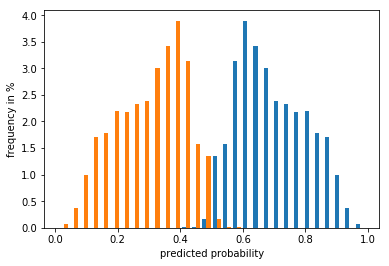

In [102]:
eva.predp_distribution(ypredp)

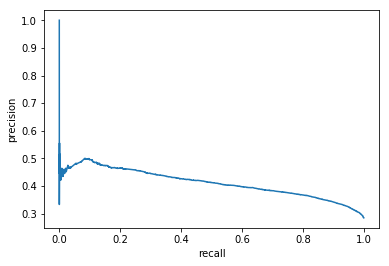

In [103]:
eva.depict_precision_recall_curve(y_test, ypredp)